In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Загрузка датасета

In [2]:
df = pd.read_excel("/content/gdrive/MyDrive/data/vickers_hardness_dataset.xlsx")
df.head()

,Type_of_samples,P,D1,D2,HV
0,0,500,61.606,63.455,226.406
1,0,500,62.380,61.992,249.658
2,0,500,59.052,62.373,244.361
3,0,500,60.825,62.618,243.444
4,0,500,60.368,62.374,231.127


In [3]:
df.describe()

,Type_of_samples,P,D1,D2,HV
count,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.000000,320.000000,46.014587,45.994812,274.718868
std,0.817041,160.106773,14.088705,14.117520,63.642977
min,0.000000,100.000000,15.658000,17.777000,131.551000
25%,0.000000,200.000000,34.489000,34.883250,229.161250
50%,1.000000,300.000000,48.276500,48.346000,265.860500
75%,2.000000,500.000000,57.872750,57.512500,316.910250
max,2.000000,500.000000,75.205000,76.127000,581.744000


In [4]:
columns = ['Type_of_samples', 'P', 'D1', 'D2']

In [5]:
df.isnull().sum()

Type_of_samples    0
P                  0
D1                 0
D2                 0
HV                 0
dtype: int64

In [6]:
df['HV'].value_counts()

271.584    5
278.914    4
380.861    4
228.887    4
353.125    3
          ..
202.600    1
241.111    1
208.088    1
254.022    1
250.292    1
Name: HV, Length: 607, dtype: int64

Разделение данных на выборки

In [7]:
from sklearn.model_selection import train_test_split

dfX = df.drop(['HV'],axis=1)
dfY = df['HV']
X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, test_size=0.3,
                                                    random_state=1)

GridSearch для подбора оптимальных гиперпараметров у каждого алгоритма

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_absolute_percentage_error

#Передавать обученую моедль и тестовые выборки
def calculate_error(model, X_test, Y_test):
    score = model.score(X_test, Y_test)
    print('R^2 score:', score)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)
    mape = mean_absolute_percentage_error(Y_test, y_pred)

    print('MSE:', round(mse, 3))
    print('MAE:', round(mae, 3))
    print('MAPE:', round(mape, 3))

In [9]:
import matplotlib.pyplot as plt

def plot_3d_graph(model, X_test, Y_test):
    predictions = model.predict(X_test)
    original = Y_test.to_numpy()
    x = X_test['P'].to_numpy()
    y = (X_test['D1'].to_numpy() + X_test['D2'].to_numpy()) / 2

    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(azim=340, elev=20)
    sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
    sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)
    ax.set_xlabel('P')
    ax.set_ylabel('D')
    ax.set_zlabel('HV')
    ax.legend(handles=[sc1, sc2], loc='best')
    plt.show()

def plot_2d_graph(model, X_test, Y_test):
    predictions = model.predict(X_test)
    original = Y_test.to_numpy()
    x = (X_test['D1'].to_numpy() + X_test['D2'].to_numpy()) / 2

    fig = plt.figure(figsize=(14, 8))
    plt.scatter(x, original, c='b', label='Original', s=20)
    plt.scatter(x, predictions, c='r', label='Predictions', s=20)
    plt.xlabel('D')
    plt.ylabel('HV')
    plt.title('Model Function')
    plt.legend()
    plt.show()

Модель линейного регрессора

In [10]:
from sklearn.linear_model import LinearRegression

LRModel = LinearRegression()
LRParameters = {}

gridLR = GridSearchCV(estimator=LRModel, param_grid = LRParameters, n_jobs = -1)
gridLR.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridLR.best_params_))
bestLR = gridLR.best_estimator_
calculate_error(bestLR, X_test, Y_test)

Best hyperparameters are: {}
R^2 score: 0.8163533926586499
MSE: 803.457
MAE: 18.59
MAPE: 0.07


<ipython-input-9-44e4ea302ba1>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-44e4ea302ba1>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


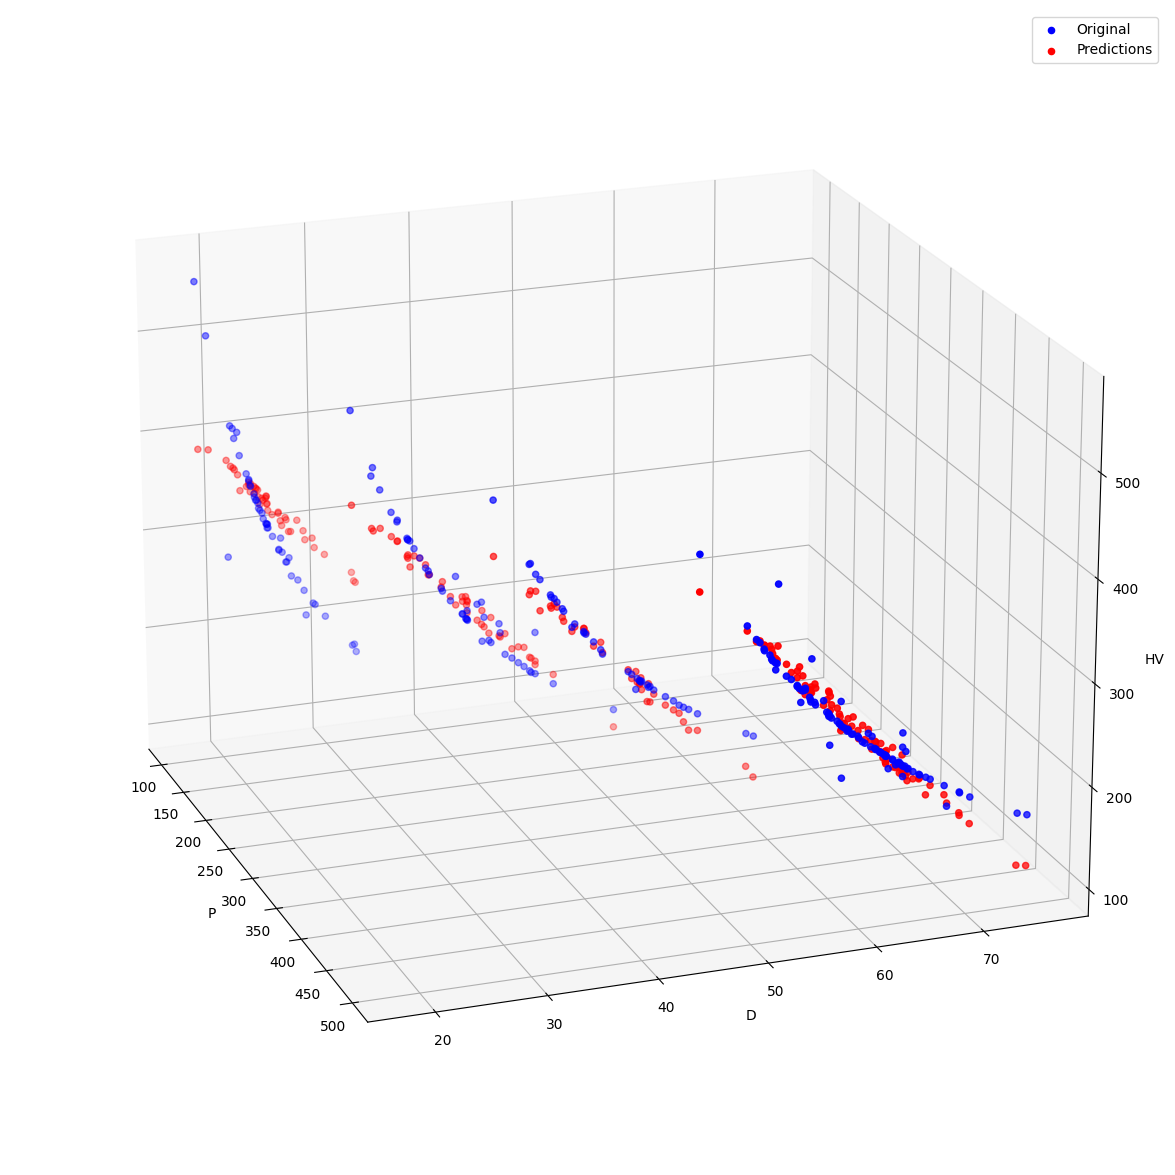

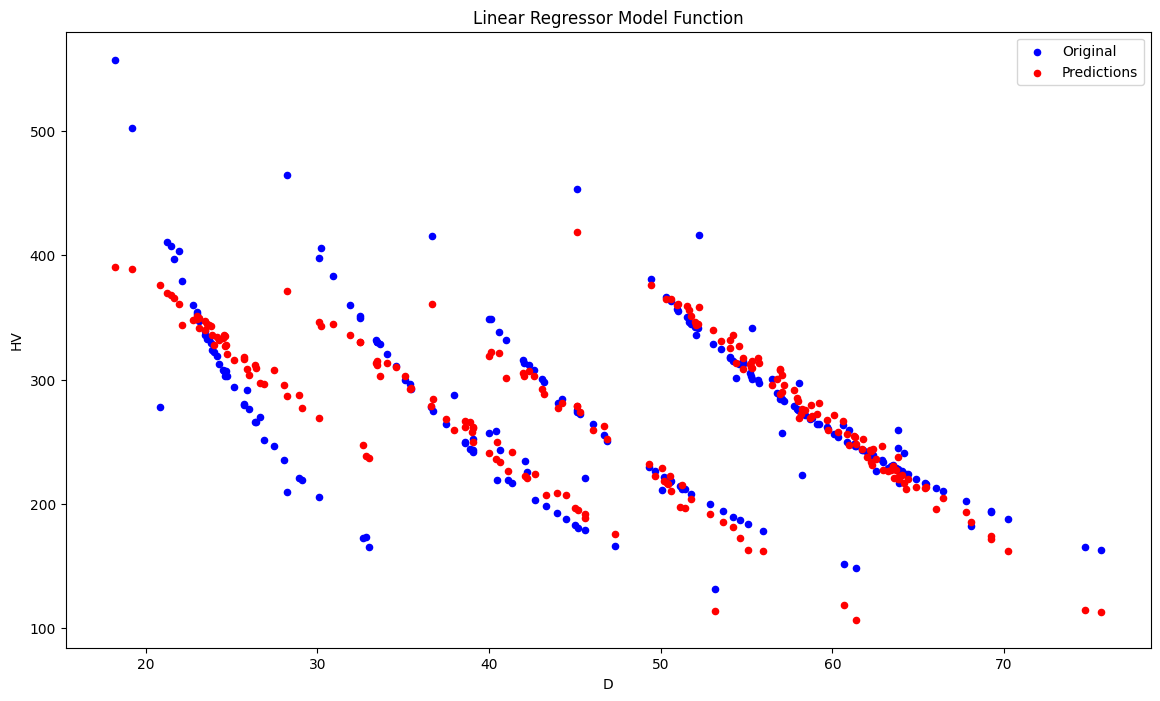

In [11]:
plot_3d_graph(bestLR, X_test, Y_test)
plot_2d_graph(bestLR, X_test, Y_test)

Модель полиномиального регрессора

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

PRModel = Pipeline([('poly', PolynomialFeatures()),
                  ('linear', LinearRegression())])

PRParameters = {'poly__degree': [2, 3, 4, 5]}

gridPR = GridSearchCV(PRModel, param_grid=PRParameters, cv=5)
gridPR.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridPR.best_params_))
bestPR = gridPR.best_estimator_
calculate_error(bestPR, X_test, Y_test)

Best hyperparameters are: {'poly__degree': 2}
R^2 score: 0.9201653943719188
MSE: 349.278
MAE: 10.557
MAPE: 0.041


Модель регрессора на случайном лесе

<ipython-input-9-44e4ea302ba1>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-44e4ea302ba1>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


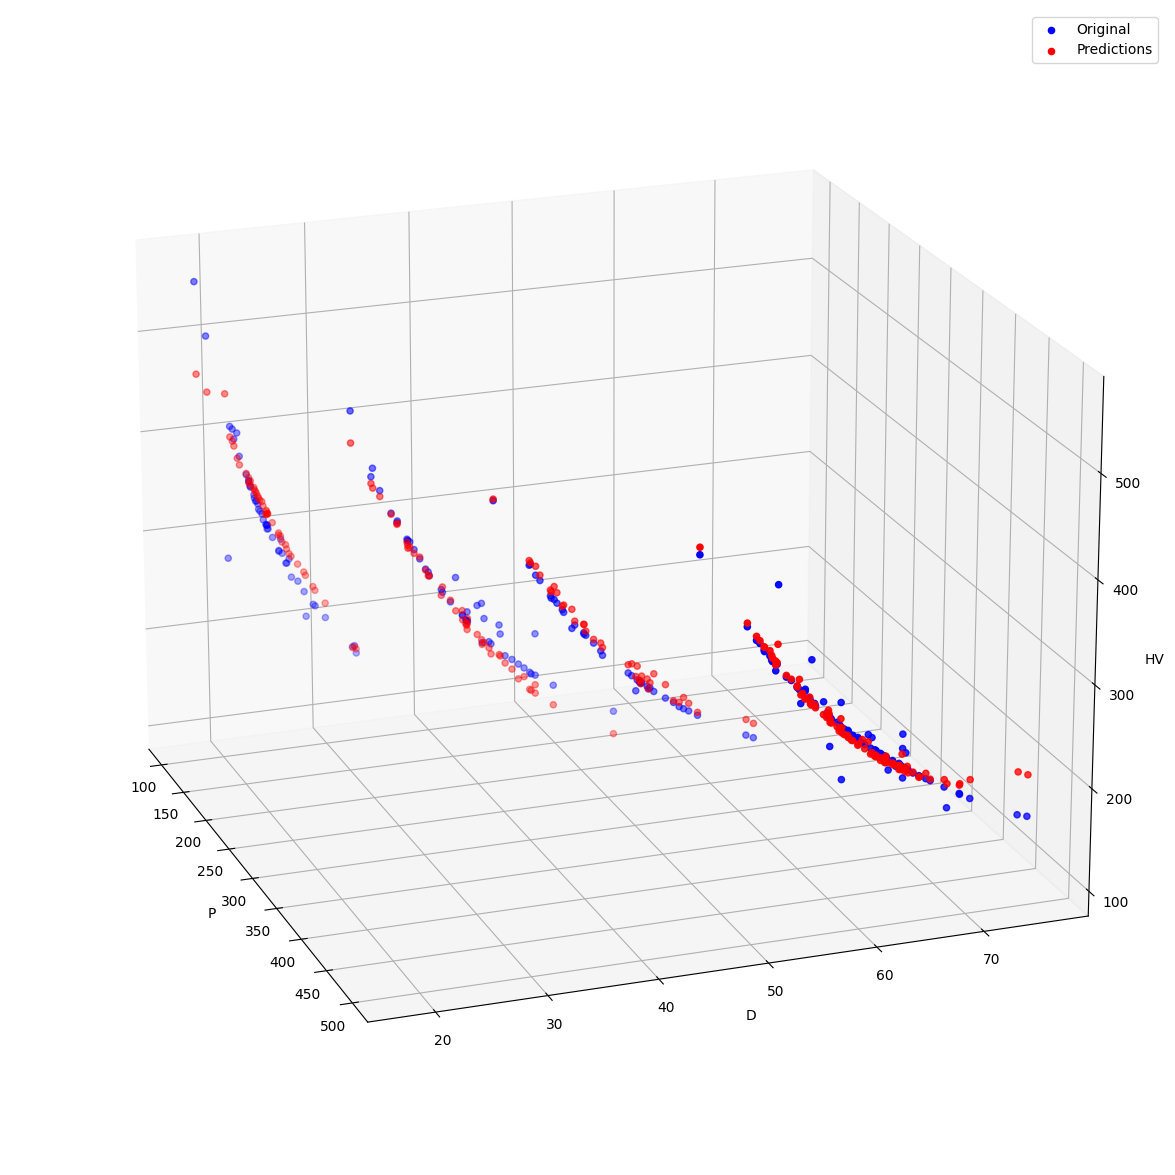

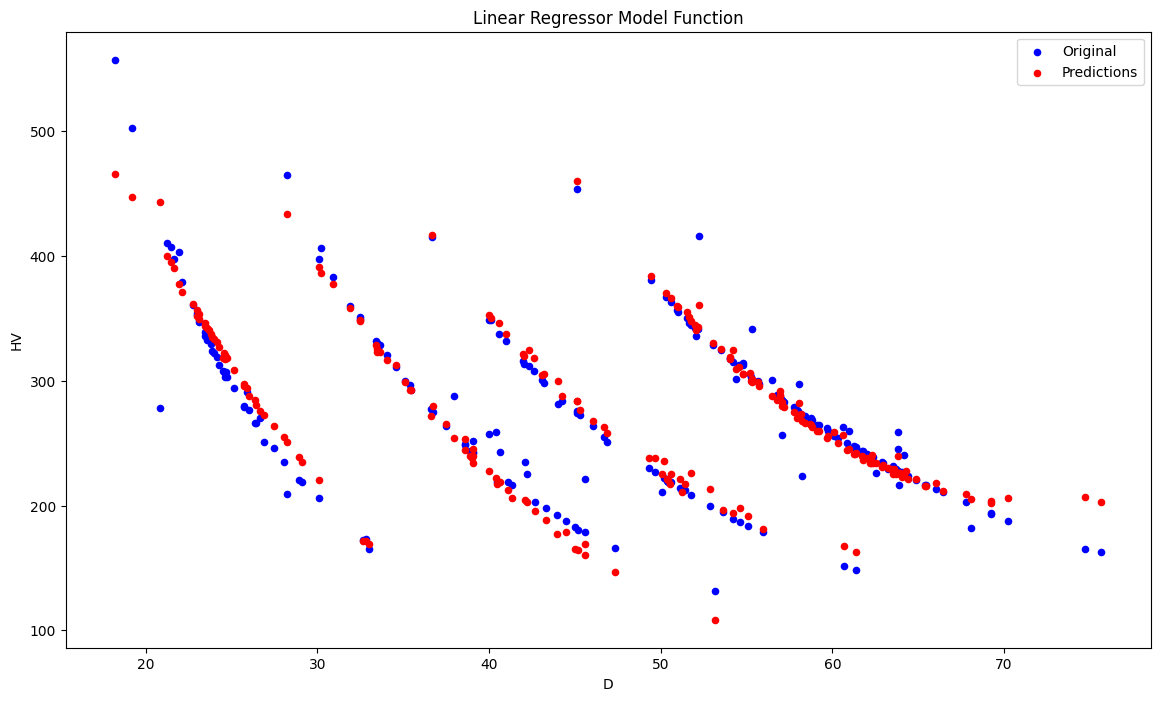

In [13]:
plot_3d_graph(bestPR, X_test, Y_test)
plot_2d_graph(bestPR, X_test, Y_test)

In [14]:
from sklearn.ensemble import RandomForestRegressor

RFModel = RandomForestRegressor()
RFParameters = {'n_estimators':[50,100,150],
                'max_depth':[3,5,10,None],
                'min_samples_split':[2,3,4],
                'min_samples_leaf':[1,2,3],
                'max_features':[1,3,5,7, "auto"]}

gridRF = GridSearchCV(estimator=RFModel, param_grid = RFParameters, n_jobs = -1, error_score='raise')
gridRF.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridRF.best_params_))
bestRF = gridRF.best_estimator_
calculate_error(bestRF, X_test, Y_test)

Best hyperparameters are: {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
R^2 score: 0.9084236705712895
MSE: 400.648
MAE: 11.123
MAPE: 0.041


<ipython-input-9-44e4ea302ba1>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-44e4ea302ba1>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


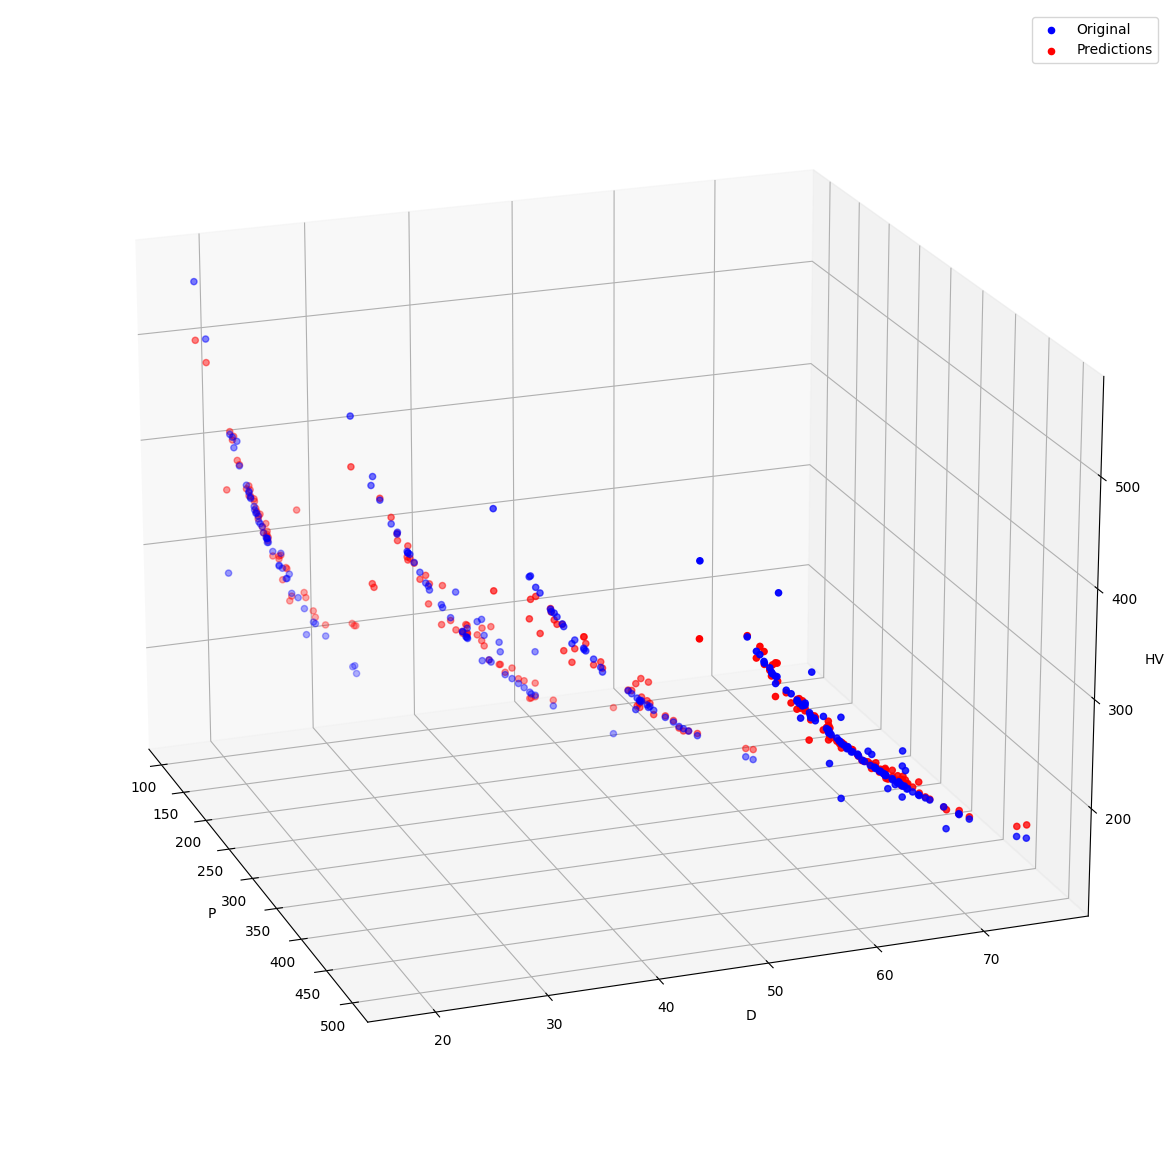

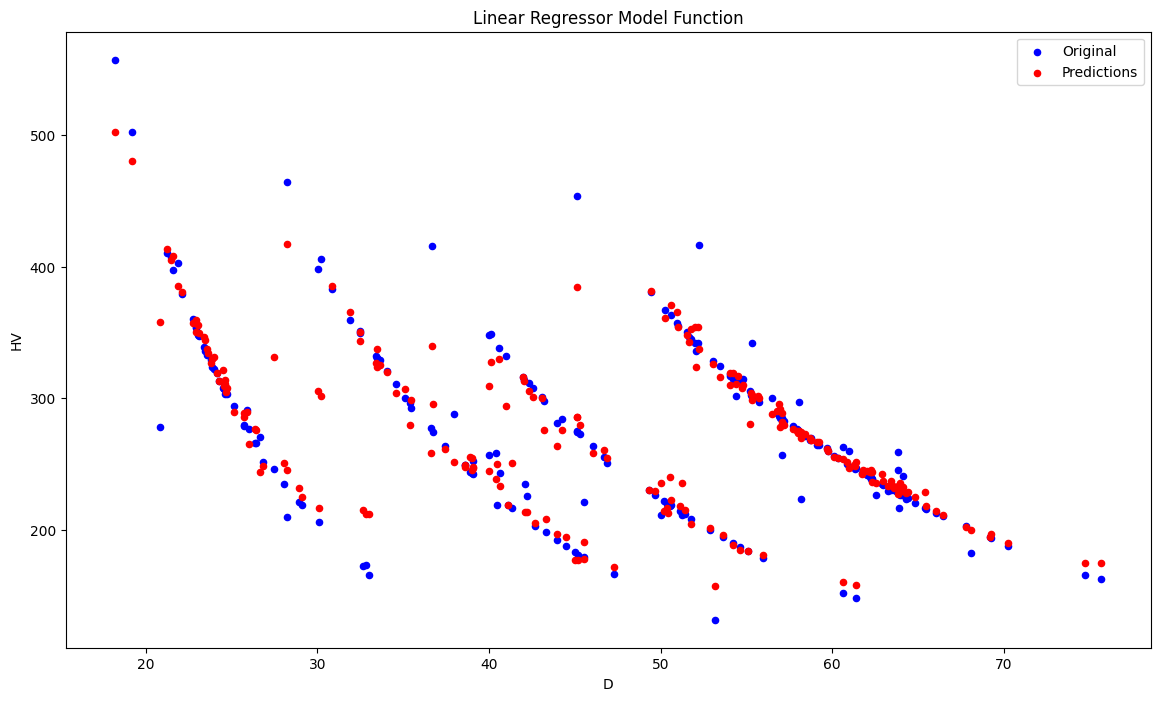

In [15]:
plot_3d_graph(bestRF, X_test, Y_test)
plot_2d_graph(bestRF, X_test, Y_test)

Модель AdaBoost Regressor




In [16]:
from sklearn.ensemble import AdaBoostRegressor

baseModel = RandomForestRegressor(max_depth = None, max_features = 3, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150)

# Создаем модель AdaBoostRegressor на основе базовой модели
boostedModel = AdaBoostRegressor(estimator=baseModel, n_estimators=100, learning_rate=0.1)

# Обучаем модель на тренировочных данных
boostedModel.fit(X_train, Y_train)
calculate_error(boostedModel, X_test, Y_test)

R^2 score: 0.9157802987927592
MSE: 368.463
MAE: 10.322
MAPE: 0.038


Сохранение лучшей модели

<Axes: >

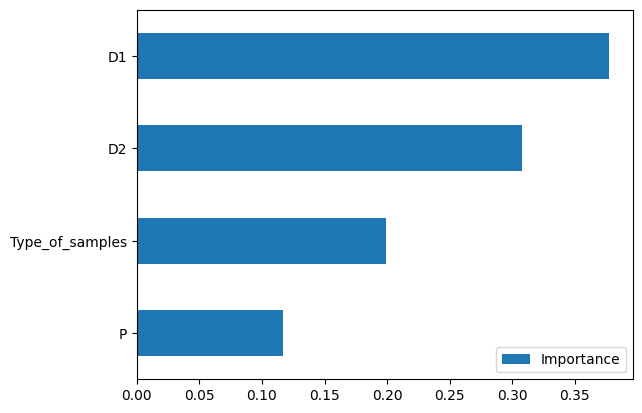

In [17]:
tree_feature_importances=pd.DataFrame(bestRF.feature_importances_,
                                      index=columns,
                                      columns=['Importance']).sort_values('Importance',
                                                                          ascending=True)
tree_feature_importances.plot.barh()

<ipython-input-9-44e4ea302ba1>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-44e4ea302ba1>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


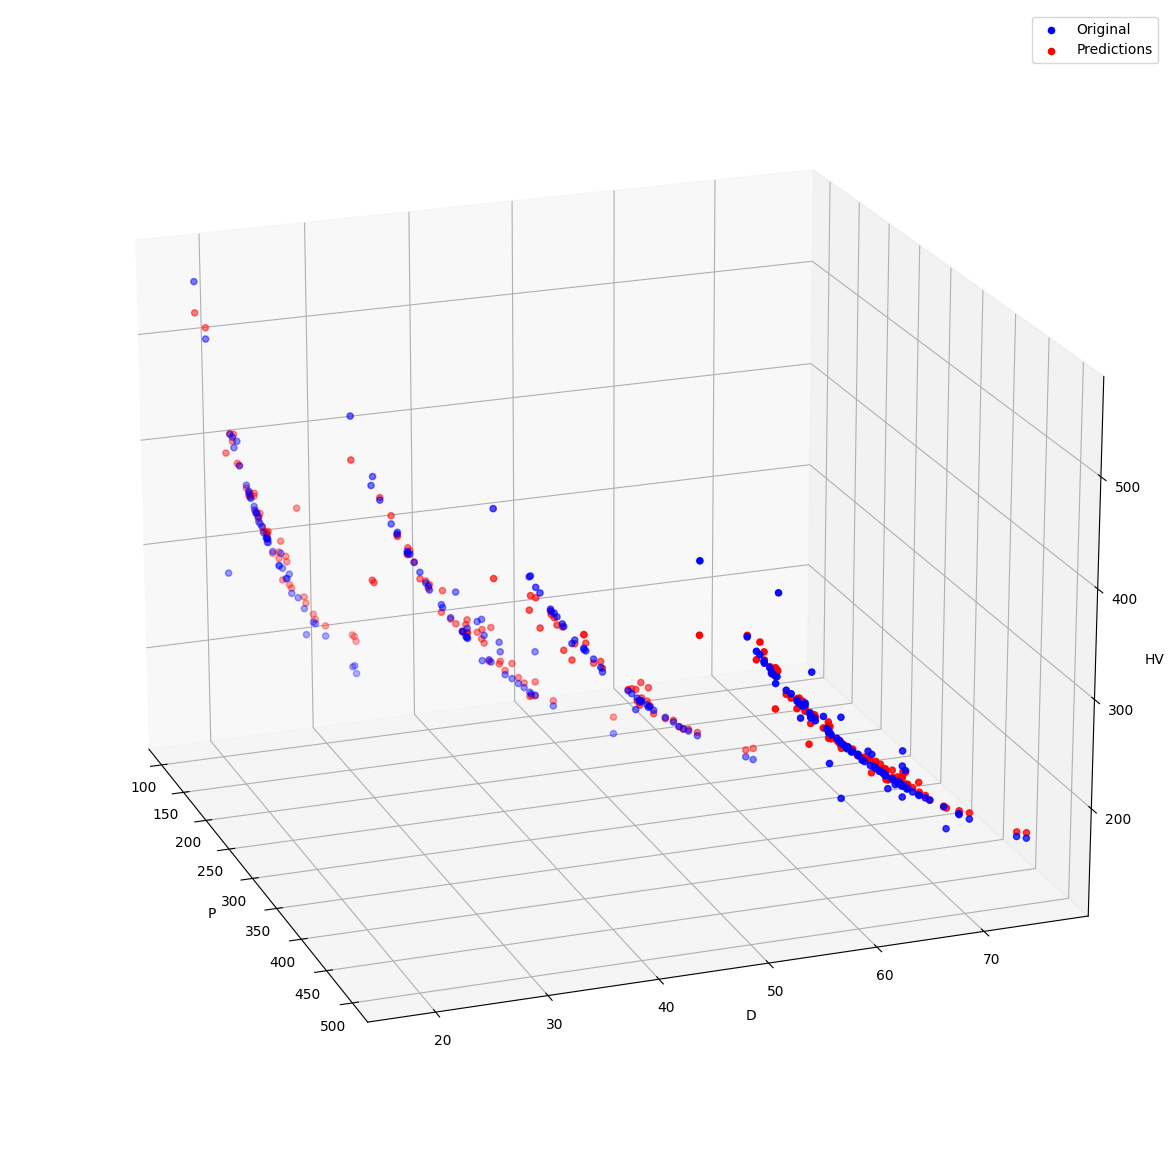

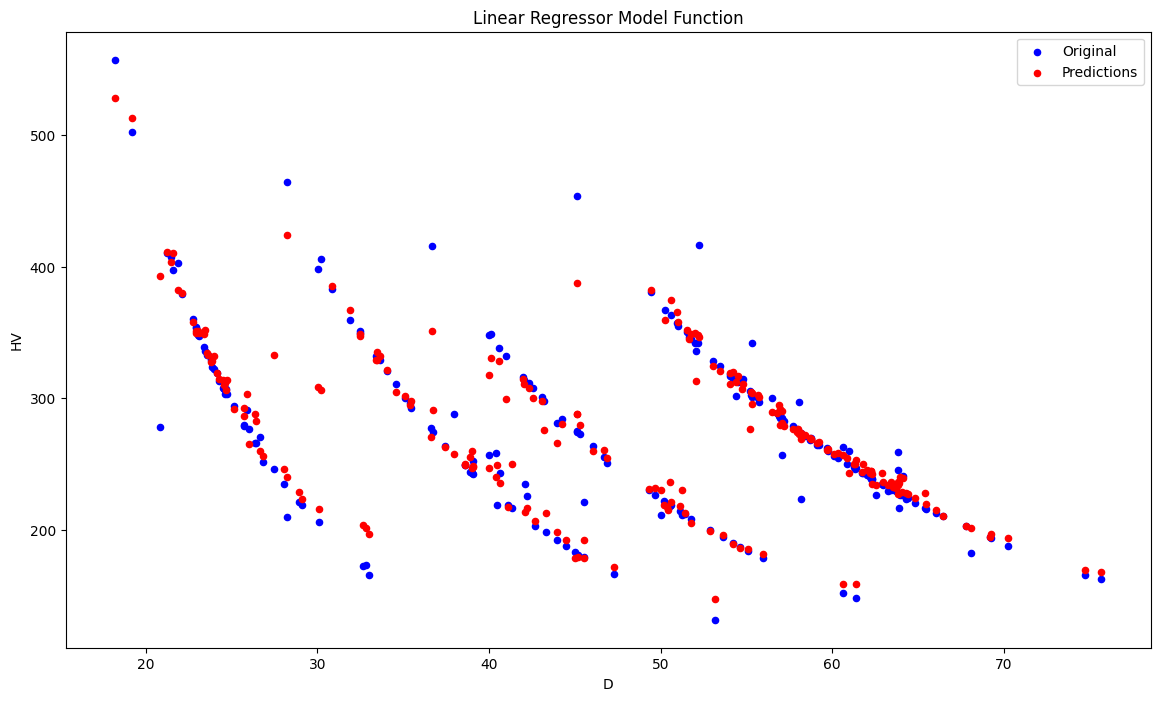

In [18]:
plot_3d_graph(boostedModel, X_test, Y_test)
plot_2d_graph(boostedModel, X_test, Y_test)

In [19]:
X = df.drop(['HV'],axis=1)
y = df['HV']

In [20]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [21]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size = 0.2,
                                                            random_state = 0)
print(f'Train : {X_train_val.shape}, Test : {X_test.shape}')

Train : (600, 4), Test : (150, 4)


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size = 0.2, random_state = 0)
print(f'Train : {X_train.shape}, Test : {X_val.shape}')

Train : (480, 4), Test : (120, 4)


In [23]:
from keras.models import Sequential
from keras.layers import Dense
regressor = Sequential()
regressor.add(Dense(32,activation='relu',input_dim=X_train.shape[1]))
regressor.add(Dense(1))

In [24]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [25]:
regressor.compile(loss='mse',optimizer='adam',metrics='mae')

In [26]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stop = EarlyStopping(monitor='val_mse',patience=10,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Temp/hardness_processing-{epoch:02d}-{val_loss:.3f}.hdf5',
                              monitor='val_loss',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [27]:
regressor_history = regressor.fit(X_train, y_train, batch_size=40,
                      validation_data=(X_val,y_val), callbacks=callbacks_list, epochs=1600)

Epoch 1/1600
 1/12 [=>............................] - ETA: 10s - loss: 77843.6016 - mae: 272.9050


Epoch 1: val_loss improved from inf to 70124.99219, saving model to /content/gdrive/My Drive/Temp/hardness_processing-01-70124.992.hdf5
12/12 [==============================] - 1s 35ms/step - loss: 83090.4453 - mae: 281.1703 - val_loss: 70124.9922 - val_mae: 257.9174
Epoch 2/1600
 1/12 [=>............................] - ETA: 0s - loss: 82794.3750 - mae: 281.0536


Epoch 2: val_loss improved from 70124.99219 to 69998.71094, saving model to /content/gdrive/My Drive/Temp/hardness_processing-02-69998.711.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 82966.9531 - mae: 280.9473 - val_loss: 69998.7109 - val_mae: 257.6736
Epoch 3/1600
 1/12 [=>............................] - ETA: 0s - loss: 75360.0781 - mae: 269.7379


Epoch 3: val_loss improved from 69998.71094 to 69866.69531, saving model to /content/gdrive/My Drive/Temp/hardness_processing-03-69866.695.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 82838.3359 - mae: 280.7155 - val_loss: 69866.6953 - val_mae: 257.4187
Epoch 4/1600
 1/12 [=>............................] - ETA: 0s - loss: 78191.1875 - mae: 271.8279


Epoch 4: val_loss improved from 69866.69531 to 69726.96094, saving model to /content/gdrive/My Drive/Temp/hardness_processing-04-69726.961.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 82704.0312 - mae: 280.4737 - val_loss: 69726.9609 - val_mae: 257.1488
Epoch 5/1600
 1/12 [=>............................] - ETA: 0s - loss: 78324.3359 - mae: 274.3260


Epoch 5: val_loss improved from 69726.96094 to 69579.38281, saving model to /content/gdrive/My Drive/Temp/hardness_processing-05-69579.383.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 82559.3594 - mae: 280.2128 - val_loss: 69579.3828 - val_mae: 256.8635
Epoch 6/1600
 1/12 [=>............................] - ETA: 0s - loss: 85642.0703 - mae: 286.1980


Epoch 6: val_loss improved from 69579.38281 to 69419.53906, saving model to /content/gdrive/My Drive/Temp/hardness_processing-06-69419.539.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 82405.1641 - mae: 279.9364 - val_loss: 69419.5391 - val_mae: 256.5541
Epoch 7/1600
 1/12 [=>............................] - ETA: 0s - loss: 83039.7578 - mae: 279.9040


Epoch 7: val_loss improved from 69419.53906 to 69249.42188, saving model to /content/gdrive/My Drive/Temp/hardness_processing-07-69249.422.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 82240.9297 - mae: 279.6395 - val_loss: 69249.4219 - val_mae: 256.2240
Epoch 8/1600
 1/12 [=>............................] - ETA: 0s - loss: 81330.0391 - mae: 277.8382


Epoch 8: val_loss improved from 69249.42188 to 69065.53906, saving model to /content/gdrive/My Drive/Temp/hardness_processing-08-69065.539.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 82064.8750 - mae: 279.3199 - val_loss: 69065.5391 - val_mae: 255.8661
Epoch 9/1600
 1/12 [=>............................] - ETA: 0s - loss: 93453.7344 - mae: 297.1609


Epoch 9: val_loss improved from 69065.53906 to 68867.29688, saving model to /content/gdrive/My Drive/Temp/hardness_processing-09-68867.297.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 81874.0703 - mae: 278.9719 - val_loss: 68867.2969 - val_mae: 255.4785
Epoch 10/1600
 1/12 [=>............................] - ETA: 0s - loss: 82773.6328 - mae: 278.6521


Epoch 10: val_loss improved from 68867.29688 to 68649.09375, saving model to /content/gdrive/My Drive/Temp/hardness_processing-10-68649.094.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 81666.5234 - mae: 278.5976 - val_loss: 68649.0938 - val_mae: 255.0512
Epoch 11/1600
 1/12 [=>............................] - ETA: 0s - loss: 88897.3906 - mae: 285.8290


Epoch 11: val_loss improved from 68649.09375 to 68412.28906, saving model to /content/gdrive/My Drive/Temp/hardness_processing-11-68412.289.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 81441.6250 - mae: 278.1844 - val_loss: 68412.2891 - val_mae: 254.5870
Epoch 12/1600
 1/12 [=>............................] - ETA: 0s - loss: 78321.2656 - mae: 274.6366


Epoch 12: val_loss improved from 68412.28906 to 68162.10156, saving model to /content/gdrive/My Drive/Temp/hardness_processing-12-68162.102.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 81198.2578 - mae: 277.7435 - val_loss: 68162.1016 - val_mae: 254.0954
Epoch 13/1600
 1/12 [=>............................] - ETA: 0s - loss: 85850.4531 - mae: 285.0583


Epoch 13: val_loss improved from 68162.10156 to 67897.54688, saving model to /content/gdrive/My Drive/Temp/hardness_processing-13-67897.547.hdf5
12/12 [==============================] - 0s 7ms/step - loss: 80943.5000 - mae: 277.2733 - val_loss: 67897.5469 - val_mae: 253.5747
Epoch 14/1600
 1/12 [=>............................] - ETA: 0s - loss: 70633.2188 - mae: 258.8144


Epoch 14: val_loss improved from 67897.54688 to 67620.78125, saving model to /content/gdrive/My Drive/Temp/hardness_processing-14-67620.781.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 80673.2578 - mae: 276.7801 - val_loss: 67620.7812 - val_mae: 253.0286
Epoch 15/1600
 1/12 [=>............................] - ETA: 0s - loss: 82205.9375 - mae: 276.6422


Epoch 15: val_loss improved from 67620.78125 to 67331.14062, saving model to /content/gdrive/My Drive/Temp/hardness_processing-15-67331.141.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 80390.3828 - mae: 276.2619 - val_loss: 67331.1406 - val_mae: 252.4558
Epoch 16/1600
 1/12 [=>............................] - ETA: 0s - loss: 69523.8359 - mae: 256.7000


Epoch 16: val_loss improved from 67331.14062 to 67029.92969, saving model to /content/gdrive/My Drive/Temp/hardness_processing-16-67029.930.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 80092.1328 - mae: 275.7143 - val_loss: 67029.9297 - val_mae: 251.8587
Epoch 17/1600
 1/12 [=>............................] - ETA: 0s - loss: 84493.0625 - mae: 282.7225


Epoch 17: val_loss improved from 67029.92969 to 66710.58594, saving model to /content/gdrive/My Drive/Temp/hardness_processing-17-66710.586.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 79786.2812 - mae: 275.1443 - val_loss: 66710.5859 - val_mae: 251.2240
Epoch 18/1600
 1/12 [=>............................] - ETA: 0s - loss: 76928.0156 - mae: 272.5439


Epoch 18: val_loss improved from 66710.58594 to 66377.44531, saving model to /content/gdrive/My Drive/Temp/hardness_processing-18-66377.445.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 79463.7188 - mae: 274.5492 - val_loss: 66377.4453 - val_mae: 250.5599
Epoch 19/1600
 1/12 [=>............................] - ETA: 0s - loss: 84944.0078 - mae: 286.0604


Epoch 19: val_loss improved from 66377.44531 to 66035.26562, saving model to /content/gdrive/My Drive/Temp/hardness_processing-19-66035.266.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 79122.7109 - mae: 273.9197 - val_loss: 66035.2656 - val_mae: 249.8759
Epoch 20/1600
 1/12 [=>............................] - ETA: 0s - loss: 68148.8359 - mae: 253.3557


Epoch 20: val_loss improved from 66035.26562 to 65677.35156, saving model to /content/gdrive/My Drive/Temp/hardness_processing-20-65677.352.hdf5
12/12 [==============================] - 0s 7ms/step - loss: 78773.3203 - mae: 273.2704 - val_loss: 65677.3516 - val_mae: 249.1585
Epoch 21/1600
 1/12 [=>............................] - ETA: 0s - loss: 74495.5391 - mae: 264.9252


Epoch 21: val_loss improved from 65677.35156 to 65302.35156, saving model to /content/gdrive/My Drive/Temp/hardness_processing-21-65302.352.hdf5
12/12 [==============================] - 0s 7ms/step - loss: 78407.8203 - mae: 272.5888 - val_loss: 65302.3516 - val_mae: 248.4048
Epoch 22/1600
 1/12 [=>............................] - ETA: 0s - loss: 66419.6406 - mae: 252.8773


Epoch 22: val_loss improved from 65302.35156 to 64910.17188, saving model to /content/gdrive/My Drive/Temp/hardness_processing-22-64910.172.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 78021.9219 - mae: 271.8719 - val_loss: 64910.1719 - val_mae: 247.6138
Epoch 23/1600
 1/12 [=>............................] - ETA: 0s - loss: 82296.5234 - mae: 282.7475


Epoch 23: val_loss improved from 64910.17188 to 64497.68359, saving model to /content/gdrive/My Drive/Temp/hardness_processing-23-64497.684.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 77618.5547 - mae: 271.1153 - val_loss: 64497.6836 - val_mae: 246.7789
Epoch 24/1600
 1/12 [=>............................] - ETA: 0s - loss: 69166.4453 - mae: 255.9043


Epoch 24: val_loss improved from 64497.68359 to 64069.18750, saving model to /content/gdrive/My Drive/Temp/hardness_processing-24-64069.188.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 77194.6484 - mae: 270.3208 - val_loss: 64069.1875 - val_mae: 245.9081
Epoch 25/1600
 1/12 [=>............................] - ETA: 0s - loss: 65531.6758 - mae: 249.8913


Epoch 25: val_loss improved from 64069.18750 to 63623.16797, saving model to /content/gdrive/My Drive/Temp/hardness_processing-25-63623.168.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 76756.6016 - mae: 269.4919 - val_loss: 63623.1680 - val_mae: 244.9984
Epoch 26/1600
 1/12 [=>............................] - ETA: 0s - loss: 71856.6172 - mae: 262.5353


Epoch 26: val_loss improved from 63623.16797 to 63162.96094, saving model to /content/gdrive/My Drive/Temp/hardness_processing-26-63162.961.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 76299.7344 - mae: 268.6323 - val_loss: 63162.9609 - val_mae: 244.0557
Epoch 27/1600
 1/12 [=>............................] - ETA: 0s - loss: 80461.0781 - mae: 276.8207


Epoch 27: val_loss improved from 63162.96094 to 62686.45703, saving model to /content/gdrive/My Drive/Temp/hardness_processing-27-62686.457.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 75830.5547 - mae: 267.7345 - val_loss: 62686.4570 - val_mae: 243.0757
Epoch 28/1600
 1/12 [=>............................] - ETA: 0s - loss: 72500.3594 - mae: 262.0295


Epoch 28: val_loss improved from 62686.45703 to 62197.92578, saving model to /content/gdrive/My Drive/Temp/hardness_processing-28-62197.926.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 75342.9922 - mae: 266.8118 - val_loss: 62197.9258 - val_mae: 242.0664
Epoch 29/1600
 1/12 [=>............................] - ETA: 0s - loss: 78916.5234 - mae: 275.1301


Epoch 29: val_loss improved from 62197.92578 to 61692.18359, saving model to /content/gdrive/My Drive/Temp/hardness_processing-29-61692.184.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 74846.9141 - mae: 265.8544 - val_loss: 61692.1836 - val_mae: 241.0170
Epoch 30/1600
 1/12 [=>............................] - ETA: 0s - loss: 80166.7500 - mae: 273.8413


Epoch 30: val_loss improved from 61692.18359 to 61173.36328, saving model to /content/gdrive/My Drive/Temp/hardness_processing-30-61173.363.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 74333.8672 - mae: 264.8692 - val_loss: 61173.3633 - val_mae: 239.9351
Epoch 31/1600
 1/12 [=>............................] - ETA: 0s - loss: 79077.4609 - mae: 272.7922


Epoch 31: val_loss improved from 61173.36328 to 60646.67578, saving model to /content/gdrive/My Drive/Temp/hardness_processing-31-60646.676.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 73802.8984 - mae: 263.8480 - val_loss: 60646.6758 - val_mae: 238.8315
Epoch 32/1600
 1/12 [=>............................] - ETA: 0s - loss: 80452.8906 - mae: 276.2951


Epoch 32: val_loss improved from 60646.67578 to 60103.79297, saving model to /content/gdrive/My Drive/Temp/hardness_processing-32-60103.793.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 73266.9844 - mae: 262.8036 - val_loss: 60103.7930 - val_mae: 237.6882
Epoch 33/1600
 1/12 [=>............................] - ETA: 0s - loss: 86582.1406 - mae: 284.7654


Epoch 33: val_loss improved from 60103.79297 to 59550.36328, saving model to /content/gdrive/My Drive/Temp/hardness_processing-33-59550.363.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 72713.6953 - mae: 261.7253 - val_loss: 59550.3633 - val_mae: 236.5167
Epoch 34/1600
 1/12 [=>............................] - ETA: 0s - loss: 66376.3906 - mae: 250.9966


Epoch 34: val_loss improved from 59550.36328 to 58984.66797, saving model to /content/gdrive/My Drive/Temp/hardness_processing-34-58984.668.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 72149.7266 - mae: 260.6298 - val_loss: 58984.6680 - val_mae: 235.3126
Epoch 35/1600
 1/12 [=>............................] - ETA: 0s - loss: 63922.3516 - mae: 247.0809


Epoch 35: val_loss improved from 58984.66797 to 58408.75781, saving model to /content/gdrive/My Drive/Temp/hardness_processing-35-58408.758.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 71572.4688 - mae: 259.4961 - val_loss: 58408.7578 - val_mae: 234.0800
Epoch 36/1600
 1/12 [=>............................] - ETA: 0s - loss: 65758.2344 - mae: 251.0944


Epoch 36: val_loss improved from 58408.75781 to 57818.11719, saving model to /content/gdrive/My Drive/Temp/hardness_processing-36-57818.117.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 70987.9844 - mae: 258.3317 - val_loss: 57818.1172 - val_mae: 232.8088
Epoch 37/1600
 1/12 [=>............................] - ETA: 0s - loss: 61761.1992 - mae: 240.8363


Epoch 37: val_loss improved from 57818.11719 to 57221.74219, saving model to /content/gdrive/My Drive/Temp/hardness_processing-37-57221.742.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 70383.9531 - mae: 257.1421 - val_loss: 57221.7422 - val_mae: 231.5175
Epoch 38/1600
 1/12 [=>............................] - ETA: 0s - loss: 62394.1758 - mae: 245.1612


Epoch 38: val_loss improved from 57221.74219 to 56614.67578, saving model to /content/gdrive/My Drive/Temp/hardness_processing-38-56614.676.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 69773.1641 - mae: 255.9284 - val_loss: 56614.6758 - val_mae: 230.1949
Epoch 39/1600
 1/12 [=>............................] - ETA: 0s - loss: 70442.9531 - mae: 258.6402


Epoch 39: val_loss improved from 56614.67578 to 55992.45312, saving model to /content/gdrive/My Drive/Temp/hardness_processing-39-55992.453.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 69156.5859 - mae: 254.6813 - val_loss: 55992.4531 - val_mae: 228.8312
Epoch 40/1600
 1/12 [=>............................] - ETA: 0s - loss: 78600.9766 - mae: 269.8467


Epoch 40: val_loss improved from 55992.45312 to 55363.39062, saving model to /content/gdrive/My Drive/Temp/hardness_processing-40-55363.391.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 68521.1094 - mae: 253.3996 - val_loss: 55363.3906 - val_mae: 227.4434
Epoch 41/1600
 1/12 [=>............................] - ETA: 0s - loss: 62498.1992 - mae: 242.2839


Epoch 41: val_loss improved from 55363.39062 to 54727.20703, saving model to /content/gdrive/My Drive/Temp/hardness_processing-41-54727.207.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 67875.4219 - mae: 252.0904 - val_loss: 54727.2070 - val_mae: 226.0304
Epoch 42/1600
 1/12 [=>............................] - ETA: 0s - loss: 65078.7734 - mae: 247.7935


Epoch 42: val_loss improved from 54727.20703 to 54076.02734, saving model to /content/gdrive/My Drive/Temp/hardness_processing-42-54076.027.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 67226.4297 - mae: 250.7676 - val_loss: 54076.0273 - val_mae: 224.5745
Epoch 43/1600
 1/12 [=>............................] - ETA: 0s - loss: 65468.2812 - mae: 249.2537


Epoch 43: val_loss improved from 54076.02734 to 53418.11719, saving model to /content/gdrive/My Drive/Temp/hardness_processing-43-53418.117.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 66560.7578 - mae: 249.3941 - val_loss: 53418.1172 - val_mae: 223.0933
Epoch 44/1600
 1/12 [=>............................] - ETA: 0s - loss: 64519.2188 - mae: 243.6335


Epoch 44: val_loss improved from 53418.11719 to 52753.01562, saving model to /content/gdrive/My Drive/Temp/hardness_processing-44-52753.016.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 65885.0938 - mae: 247.9978 - val_loss: 52753.0156 - val_mae: 221.5849
Epoch 45/1600
 1/12 [=>............................] - ETA: 0s - loss: 66779.3359 - mae: 248.8670


Epoch 45: val_loss improved from 52753.01562 to 52076.97266, saving model to /content/gdrive/My Drive/Temp/hardness_processing-45-52076.973.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 65203.5000 - mae: 246.5856 - val_loss: 52076.9727 - val_mae: 220.0402
Epoch 46/1600
 1/12 [=>............................] - ETA: 0s - loss: 63005.1484 - mae: 243.7935


Epoch 46: val_loss improved from 52076.97266 to 51387.75000, saving model to /content/gdrive/My Drive/Temp/hardness_processing-46-51387.750.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 64515.9922 - mae: 245.1409 - val_loss: 51387.7500 - val_mae: 218.4535
Epoch 47/1600
 1/12 [=>............................] - ETA: 0s - loss: 61397.2383 - mae: 239.8026


Epoch 47: val_loss improved from 51387.75000 to 50699.43359, saving model to /content/gdrive/My Drive/Temp/hardness_processing-47-50699.434.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 63807.3086 - mae: 243.6487 - val_loss: 50699.4336 - val_mae: 216.8563
Epoch 48/1600
 1/12 [=>............................] - ETA: 0s - loss: 68095.4219 - mae: 253.2165


Epoch 48: val_loss improved from 50699.43359 to 49998.47266, saving model to /content/gdrive/My Drive/Temp/hardness_processing-48-49998.473.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 63102.8086 - mae: 242.1406 - val_loss: 49998.4727 - val_mae: 215.2167
Epoch 49/1600
 1/12 [=>............................] - ETA: 0s - loss: 53763.2578 - mae: 224.8377


Epoch 49: val_loss improved from 49998.47266 to 49295.50000, saving model to /content/gdrive/My Drive/Temp/hardness_processing-49-49295.500.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 62381.6797 - mae: 240.6106 - val_loss: 49295.5000 - val_mae: 213.5587
Epoch 50/1600
 1/12 [=>............................] - ETA: 0s - loss: 63198.3984 - mae: 240.9427


Epoch 50: val_loss improved from 49295.50000 to 48582.09766, saving model to /content/gdrive/My Drive/Temp/hardness_processing-50-48582.098.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 61661.7344 - mae: 239.0696 - val_loss: 48582.0977 - val_mae: 211.8619
Epoch 51/1600
 1/12 [=>............................] - ETA: 0s - loss: 54062.3242 - mae: 226.2085


Epoch 51: val_loss improved from 48582.09766 to 47867.22656, saving model to /content/gdrive/My Drive/Temp/hardness_processing-51-47867.227.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 60928.0430 - mae: 237.4631 - val_loss: 47867.2266 - val_mae: 210.1467
Epoch 52/1600
 1/12 [=>............................] - ETA: 0s - loss: 55199.4180 - mae: 226.5998


Epoch 52: val_loss improved from 47867.22656 to 47148.07031, saving model to /content/gdrive/My Drive/Temp/hardness_processing-52-47148.070.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 60191.1250 - mae: 235.8634 - val_loss: 47148.0703 - val_mae: 208.4060
Epoch 53/1600
 1/12 [=>............................] - ETA: 0s - loss: 56621.4258 - mae: 225.3012


Epoch 53: val_loss improved from 47148.07031 to 46424.58984, saving model to /content/gdrive/My Drive/Temp/hardness_processing-53-46424.590.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 59449.4727 - mae: 234.2234 - val_loss: 46424.5898 - val_mae: 206.6389
Epoch 54/1600
 1/12 [=>............................] - ETA: 0s - loss: 60954.1367 - mae: 237.6801


Epoch 54: val_loss improved from 46424.58984 to 45693.35156, saving model to /content/gdrive/My Drive/Temp/hardness_processing-54-45693.352.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 58706.9961 - mae: 232.5603 - val_loss: 45693.3516 - val_mae: 204.8360
Epoch 55/1600
 1/12 [=>............................] - ETA: 0s - loss: 51997.7734 - mae: 218.5937


Epoch 55: val_loss improved from 45693.35156 to 44961.06641, saving model to /content/gdrive/My Drive/Temp/hardness_processing-55-44961.066.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 57955.0664 - mae: 230.8913 - val_loss: 44961.0664 - val_mae: 203.0132
Epoch 56/1600
 1/12 [=>............................] - ETA: 0s - loss: 61233.4805 - mae: 237.8586


Epoch 56: val_loss improved from 44961.06641 to 44232.00000, saving model to /content/gdrive/My Drive/Temp/hardness_processing-56-44232.000.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 57196.4883 - mae: 229.1676 - val_loss: 44232.0000 - val_mae: 201.1808
Epoch 57/1600
 1/12 [=>............................] - ETA: 0s - loss: 57187.7617 - mae: 227.7740


Epoch 57: val_loss improved from 44232.00000 to 43499.76953, saving model to /content/gdrive/My Drive/Temp/hardness_processing-57-43499.770.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 56440.2891 - mae: 227.4517 - val_loss: 43499.7695 - val_mae: 199.3220
Epoch 58/1600
 1/12 [=>............................] - ETA: 0s - loss: 59208.8008 - mae: 232.9365


Epoch 58: val_loss improved from 43499.76953 to 42763.94141, saving model to /content/gdrive/My Drive/Temp/hardness_processing-58-42763.941.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 55682.7148 - mae: 225.7150 - val_loss: 42763.9414 - val_mae: 197.4351
Epoch 59/1600
 1/12 [=>............................] - ETA: 0s - loss: 53206.2188 - mae: 220.2471


Epoch 59: val_loss improved from 42763.94141 to 42026.89844, saving model to /content/gdrive/My Drive/Temp/hardness_processing-59-42026.898.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 54921.8086 - mae: 223.9399 - val_loss: 42026.8984 - val_mae: 195.5251
Epoch 60/1600
 1/12 [=>............................] - ETA: 0s - loss: 52120.0078 - mae: 214.2853


Epoch 60: val_loss improved from 42026.89844 to 41292.74609, saving model to /content/gdrive/My Drive/Temp/hardness_processing-60-41292.746.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 54156.4766 - mae: 222.1612 - val_loss: 41292.7461 - val_mae: 193.6023
Epoch 61/1600
 1/12 [=>............................] - ETA: 0s - loss: 52070.4883 - mae: 220.4666


Epoch 61: val_loss improved from 41292.74609 to 40551.95703, saving model to /content/gdrive/My Drive/Temp/hardness_processing-61-40551.957.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 53399.2578 - mae: 220.3596 - val_loss: 40551.9570 - val_mae: 191.6410
Epoch 62/1600
 1/12 [=>............................] - ETA: 0s - loss: 48347.3203 - mae: 212.1121


Epoch 62: val_loss improved from 40551.95703 to 39815.33203, saving model to /content/gdrive/My Drive/Temp/hardness_processing-62-39815.332.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 52632.7148 - mae: 218.5338 - val_loss: 39815.3320 - val_mae: 189.6688
Epoch 63/1600
 1/12 [=>............................] - ETA: 0s - loss: 51590.3672 - mae: 214.8958


Epoch 63: val_loss improved from 39815.33203 to 39087.47266, saving model to /content/gdrive/My Drive/Temp/hardness_processing-63-39087.473.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 51862.4336 - mae: 216.6913 - val_loss: 39087.4727 - val_mae: 187.6980
Epoch 64/1600
 1/12 [=>............................] - ETA: 0s - loss: 45771.8828 - mae: 203.9398


Epoch 64: val_loss improved from 39087.47266 to 38355.54297, saving model to /content/gdrive/My Drive/Temp/hardness_processing-64-38355.543.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 51104.1602 - mae: 214.8441 - val_loss: 38355.5430 - val_mae: 185.6931
Epoch 65/1600
 1/12 [=>............................] - ETA: 0s - loss: 70863.6016 - mae: 249.3503


Epoch 65: val_loss improved from 38355.54297 to 37625.82812, saving model to /content/gdrive/My Drive/Temp/hardness_processing-65-37625.828.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 50342.3906 - mae: 212.9597 - val_loss: 37625.8281 - val_mae: 183.6707
Epoch 66/1600
 1/12 [=>............................] - ETA: 0s - loss: 52704.8828 - mae: 217.8187


Epoch 66: val_loss improved from 37625.82812 to 36903.82812, saving model to /content/gdrive/My Drive/Temp/hardness_processing-66-36903.828.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 49577.7070 - mae: 211.0720 - val_loss: 36903.8281 - val_mae: 181.6458
Epoch 67/1600
 1/12 [=>............................] - ETA: 0s - loss: 52603.3438 - mae: 210.2767


Epoch 67: val_loss improved from 36903.82812 to 36183.56250, saving model to /content/gdrive/My Drive/Temp/hardness_processing-67-36183.562.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 48819.6992 - mae: 209.1887 - val_loss: 36183.5625 - val_mae: 179.6005
Epoch 68/1600
 1/12 [=>............................] - ETA: 0s - loss: 47274.5859 - mae: 207.6687


Epoch 68: val_loss improved from 36183.56250 to 35459.35938, saving model to /content/gdrive/My Drive/Temp/hardness_processing-68-35459.359.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 48070.6914 - mae: 207.2755 - val_loss: 35459.3594 - val_mae: 177.5184
Epoch 69/1600
 1/12 [=>............................] - ETA: 0s - loss: 49508.3320 - mae: 207.4207


Epoch 69: val_loss improved from 35459.35938 to 34751.71094, saving model to /content/gdrive/My Drive/Temp/hardness_processing-69-34751.711.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 47305.8281 - mae: 205.3301 - val_loss: 34751.7109 - val_mae: 175.4574
Epoch 70/1600
 1/12 [=>............................] - ETA: 0s - loss: 49084.9141 - mae: 208.0248


Epoch 70: val_loss improved from 34751.71094 to 34039.21094, saving model to /content/gdrive/My Drive/Temp/hardness_processing-70-34039.211.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 46564.1172 - mae: 203.4063 - val_loss: 34039.2109 - val_mae: 173.3556
Epoch 71/1600
 1/12 [=>............................] - ETA: 0s - loss: 39570.4258 - mae: 188.3189


Epoch 71: val_loss improved from 34039.21094 to 33336.81641, saving model to /content/gdrive/My Drive/Temp/hardness_processing-71-33336.816.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 45812.9531 - mae: 201.4468 - val_loss: 33336.8164 - val_mae: 171.2560
Epoch 72/1600
 1/12 [=>............................] - ETA: 0s - loss: 37987.9258 - mae: 184.6762


Epoch 72: val_loss improved from 33336.81641 to 32636.08203, saving model to /content/gdrive/My Drive/Temp/hardness_processing-72-32636.082.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 45073.7656 - mae: 199.4784 - val_loss: 32636.0820 - val_mae: 169.1328
Epoch 73/1600
 1/12 [=>............................] - ETA: 0s - loss: 45187.8516 - mae: 200.2321


Epoch 73: val_loss improved from 32636.08203 to 31948.06250, saving model to /content/gdrive/My Drive/Temp/hardness_processing-73-31948.062.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 44329.2266 - mae: 197.4964 - val_loss: 31948.0625 - val_mae: 167.0190
Epoch 74/1600
 1/12 [=>............................] - ETA: 0s - loss: 41029.0391 - mae: 193.2626


Epoch 74: val_loss improved from 31948.06250 to 31261.95117, saving model to /content/gdrive/My Drive/Temp/hardness_processing-74-31261.951.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 43599.7305 - mae: 195.5180 - val_loss: 31261.9512 - val_mae: 164.8818
Epoch 75/1600
 1/12 [=>............................] - ETA: 0s - loss: 45871.8828 - mae: 201.1898


Epoch 75: val_loss improved from 31261.95117 to 30581.26953, saving model to /content/gdrive/My Drive/Temp/hardness_processing-75-30581.270.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 42872.1914 - mae: 193.5293 - val_loss: 30581.2695 - val_mae: 162.7306
Epoch 76/1600
 1/12 [=>............................] - ETA: 0s - loss: 50693.9062 - mae: 207.3064


Epoch 76: val_loss improved from 30581.26953 to 29908.28711, saving model to /content/gdrive/My Drive/Temp/hardness_processing-76-29908.287.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 42149.3125 - mae: 191.5041 - val_loss: 29908.2871 - val_mae: 160.5733
Epoch 77/1600
 1/12 [=>............................] - ETA: 0s - loss: 40603.5078 - mae: 191.7343


Epoch 77: val_loss improved from 29908.28711 to 29241.35742, saving model to /content/gdrive/My Drive/Temp/hardness_processing-77-29241.357.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 41433.5078 - mae: 189.4957 - val_loss: 29241.3574 - val_mae: 158.4032
Epoch 78/1600
 1/12 [=>............................] - ETA: 0s - loss: 39131.7305 - mae: 182.8347


Epoch 78: val_loss improved from 29241.35742 to 28589.63672, saving model to /content/gdrive/My Drive/Temp/hardness_processing-78-28589.637.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 40715.3711 - mae: 187.4809 - val_loss: 28589.6367 - val_mae: 156.2500
Epoch 79/1600
 1/12 [=>............................] - ETA: 0s - loss: 42822.7930 - mae: 194.1646


Epoch 79: val_loss improved from 28589.63672 to 27940.15430, saving model to /content/gdrive/My Drive/Temp/hardness_processing-79-27940.154.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 40016.0898 - mae: 185.4599 - val_loss: 27940.1543 - val_mae: 154.0713
Epoch 80/1600
 1/12 [=>............................] - ETA: 0s - loss: 36394.1484 - mae: 177.1556


Epoch 80: val_loss improved from 27940.15430 to 27296.62891, saving model to /content/gdrive/My Drive/Temp/hardness_processing-80-27296.629.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 39320.9766 - mae: 183.4201 - val_loss: 27296.6289 - val_mae: 151.8787
Epoch 81/1600
 1/12 [=>............................] - ETA: 0s - loss: 33079.0391 - mae: 172.4253


Epoch 81: val_loss improved from 27296.62891 to 26662.04492, saving model to /content/gdrive/My Drive/Temp/hardness_processing-81-26662.045.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 38629.9492 - mae: 181.3974 - val_loss: 26662.0449 - val_mae: 149.6814
Epoch 82/1600
 1/12 [=>............................] - ETA: 0s - loss: 38090.5664 - mae: 184.6964


Epoch 82: val_loss improved from 26662.04492 to 26037.16016, saving model to /content/gdrive/My Drive/Temp/hardness_processing-82-26037.160.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 37946.1367 - mae: 179.3489 - val_loss: 26037.1602 - val_mae: 147.4823
Epoch 83/1600
 1/12 [=>............................] - ETA: 0s - loss: 36723.3359 - mae: 179.0733


Epoch 83: val_loss improved from 26037.16016 to 25425.66211, saving model to /content/gdrive/My Drive/Temp/hardness_processing-83-25425.662.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 37266.5352 - mae: 177.2945 - val_loss: 25425.6621 - val_mae: 145.2944
Epoch 84/1600
 1/12 [=>............................] - ETA: 0s - loss: 27486.6348 - mae: 153.3949


Epoch 84: val_loss improved from 25425.66211 to 24820.39648, saving model to /content/gdrive/My Drive/Temp/hardness_processing-84-24820.396.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 36601.6484 - mae: 175.2515 - val_loss: 24820.3965 - val_mae: 143.0924
Epoch 85/1600
 1/12 [=>............................] - ETA: 0s - loss: 35990.9766 - mae: 172.9876


Epoch 85: val_loss improved from 24820.39648 to 24223.32227, saving model to /content/gdrive/My Drive/Temp/hardness_processing-85-24223.322.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 35943.6992 - mae: 173.1927 - val_loss: 24223.3223 - val_mae: 140.8830
Epoch 86/1600
 1/12 [=>............................] - ETA: 0s - loss: 31300.3223 - mae: 165.8302


Epoch 86: val_loss improved from 24223.32227 to 23638.55469, saving model to /content/gdrive/My Drive/Temp/hardness_processing-86-23638.555.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 35289.7422 - mae: 171.1408 - val_loss: 23638.5547 - val_mae: 138.7050
Epoch 87/1600
 1/12 [=>............................] - ETA: 0s - loss: 30937.4473 - mae: 161.5186


Epoch 87: val_loss improved from 23638.55469 to 23060.65625, saving model to /content/gdrive/My Drive/Temp/hardness_processing-87-23060.656.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 34650.4961 - mae: 169.0970 - val_loss: 23060.6562 - val_mae: 136.5406
Epoch 88/1600
 1/12 [=>............................] - ETA: 0s - loss: 26945.0273 - mae: 152.3580


Epoch 88: val_loss improved from 23060.65625 to 22494.00977, saving model to /content/gdrive/My Drive/Temp/hardness_processing-88-22494.010.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 34016.0195 - mae: 167.0414 - val_loss: 22494.0098 - val_mae: 134.3796
Epoch 89/1600
 1/12 [=>............................] - ETA: 0s - loss: 36515.2578 - mae: 173.1188


Epoch 89: val_loss improved from 22494.00977 to 21940.04492, saving model to /content/gdrive/My Drive/Temp/hardness_processing-89-21940.045.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 33388.8828 - mae: 164.9881 - val_loss: 21940.0449 - val_mae: 132.2269
Epoch 90/1600
 1/12 [=>............................] - ETA: 0s - loss: 34680.6797 - mae: 159.8714


Epoch 90: val_loss improved from 21940.04492 to 21395.91992, saving model to /content/gdrive/My Drive/Temp/hardness_processing-90-21395.920.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 32774.5742 - mae: 162.9392 - val_loss: 21395.9199 - val_mae: 130.0735
Epoch 91/1600
 1/12 [=>............................] - ETA: 0s - loss: 30683.4258 - mae: 153.3503


Epoch 91: val_loss improved from 21395.91992 to 20857.38672, saving model to /content/gdrive/My Drive/Temp/hardness_processing-91-20857.387.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 32173.4316 - mae: 160.8960 - val_loss: 20857.3867 - val_mae: 127.9004
Epoch 92/1600
 1/12 [=>............................] - ETA: 0s - loss: 29495.6875 - mae: 156.1265


Epoch 92: val_loss improved from 20857.38672 to 20335.03711, saving model to /content/gdrive/My Drive/Temp/hardness_processing-92-20335.037.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 31571.6387 - mae: 158.8736 - val_loss: 20335.0371 - val_mae: 125.7502
Epoch 93/1600
 1/12 [=>............................] - ETA: 0s - loss: 28165.2695 - mae: 148.1217


Epoch 93: val_loss improved from 20335.03711 to 19822.45703, saving model to /content/gdrive/My Drive/Temp/hardness_processing-93-19822.457.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 30986.5078 - mae: 156.8360 - val_loss: 19822.4570 - val_mae: 123.5990
Epoch 94/1600
 1/12 [=>............................] - ETA: 0s - loss: 31123.3086 - mae: 160.7254


Epoch 94: val_loss improved from 19822.45703 to 19318.64258, saving model to /content/gdrive/My Drive/Temp/hardness_processing-94-19318.643.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 30412.5391 - mae: 154.8049 - val_loss: 19318.6426 - val_mae: 121.4631
Epoch 95/1600
 1/12 [=>............................] - ETA: 0s - loss: 29659.0977 - mae: 157.3304


Epoch 95: val_loss improved from 19318.64258 to 18827.24023, saving model to /content/gdrive/My Drive/Temp/hardness_processing-95-18827.240.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 29844.3711 - mae: 152.8103 - val_loss: 18827.2402 - val_mae: 119.3539
Epoch 96/1600
 1/12 [=>............................] - ETA: 0s - loss: 27960.4258 - mae: 149.2502


Epoch 96: val_loss improved from 18827.24023 to 18348.38672, saving model to /content/gdrive/My Drive/Temp/hardness_processing-96-18348.387.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 29286.8809 - mae: 150.8285 - val_loss: 18348.3867 - val_mae: 117.2717
Epoch 97/1600
 1/12 [=>............................] - ETA: 0s - loss: 22129.1387 - mae: 132.7630


Epoch 97: val_loss improved from 18348.38672 to 17880.90430, saving model to /content/gdrive/My Drive/Temp/hardness_processing-97-17880.904.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 28740.5723 - mae: 148.8592 - val_loss: 17880.9043 - val_mae: 115.2181
Epoch 98/1600
 1/12 [=>............................] - ETA: 0s - loss: 25906.8281 - mae: 138.0451


Epoch 98: val_loss improved from 17880.90430 to 17422.48242, saving model to /content/gdrive/My Drive/Temp/hardness_processing-98-17422.482.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 28207.0586 - mae: 146.8936 - val_loss: 17422.4824 - val_mae: 113.1609
Epoch 99/1600
 1/12 [=>............................] - ETA: 0s - loss: 28991.6289 - mae: 148.6018


Epoch 99: val_loss improved from 17422.48242 to 16974.32617, saving model to /content/gdrive/My Drive/Temp/hardness_processing-99-16974.326.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 27683.3027 - mae: 144.9097 - val_loss: 16974.3262 - val_mae: 111.1521
Epoch 100/1600
 1/12 [=>............................] - ETA: 0s - loss: 29858.5352 - mae: 157.1399


Epoch 100: val_loss improved from 16974.32617 to 16542.60352, saving model to /content/gdrive/My Drive/Temp/hardness_processing-100-16542.604.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 27163.5488 - mae: 142.9644 - val_loss: 16542.6035 - val_mae: 109.1721
Epoch 101/1600
 1/12 [=>............................] - ETA: 0s - loss: 19411.7773 - mae: 121.4838


Epoch 101: val_loss improved from 16542.60352 to 16121.52246, saving model to /content/gdrive/My Drive/Temp/hardness_processing-101-16121.522.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 26660.1582 - mae: 141.0416 - val_loss: 16121.5225 - val_mae: 107.1963
Epoch 102/1600
 1/12 [=>............................] - ETA: 0s - loss: 29069.6680 - mae: 147.3150


Epoch 102: val_loss improved from 16121.52246 to 15709.89941, saving model to /content/gdrive/My Drive/Temp/hardness_processing-102-15709.899.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 26168.8711 - mae: 139.1539 - val_loss: 15709.8994 - val_mae: 105.2211
Epoch 103/1600
 1/12 [=>............................] - ETA: 0s - loss: 19766.7500 - mae: 121.2120


Epoch 103: val_loss improved from 15709.89941 to 15311.18359, saving model to /content/gdrive/My Drive/Temp/hardness_processing-103-15311.184.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 25684.8203 - mae: 137.2441 - val_loss: 15311.1836 - val_mae: 103.3062
Epoch 104/1600
 1/12 [=>............................] - ETA: 0s - loss: 32552.9629 - mae: 148.6831


Epoch 104: val_loss improved from 15311.18359 to 14920.40039, saving model to /content/gdrive/My Drive/Temp/hardness_processing-104-14920.400.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 25216.4141 - mae: 135.3717 - val_loss: 14920.4004 - val_mae: 101.3824
Epoch 105/1600
 1/12 [=>............................] - ETA: 0s - loss: 30410.2461 - mae: 154.1965


Epoch 105: val_loss improved from 14920.40039 to 14544.43750, saving model to /content/gdrive/My Drive/Temp/hardness_processing-105-14544.438.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 24752.0020 - mae: 133.5208 - val_loss: 14544.4375 - val_mae: 99.5262
Epoch 106/1600
 1/12 [=>............................] - ETA: 0s - loss: 27905.2441 - mae: 145.1545


Epoch 106: val_loss improved from 14544.43750 to 14178.76758, saving model to /content/gdrive/My Drive/Temp/hardness_processing-106-14178.768.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 24302.6016 - mae: 131.6770 - val_loss: 14178.7676 - val_mae: 97.7109
Epoch 107/1600
 1/12 [=>............................] - ETA: 0s - loss: 20363.9492 - mae: 118.0551


Epoch 107: val_loss improved from 14178.76758 to 13828.38379, saving model to /content/gdrive/My Drive/Temp/hardness_processing-107-13828.384.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 23858.9453 - mae: 129.8526 - val_loss: 13828.3838 - val_mae: 95.9267
Epoch 108/1600
 1/12 [=>............................] - ETA: 0s - loss: 18298.5625 - mae: 112.1134


Epoch 108: val_loss improved from 13828.38379 to 13488.20410, saving model to /content/gdrive/My Drive/Temp/hardness_processing-108-13488.204.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 23430.3965 - mae: 128.0590 - val_loss: 13488.2041 - val_mae: 94.2204
Epoch 109/1600
 1/12 [=>............................] - ETA: 0s - loss: 30897.1758 - mae: 147.0891


Epoch 109: val_loss improved from 13488.20410 to 13152.77930, saving model to /content/gdrive/My Drive/Temp/hardness_processing-109-13152.779.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 23018.8887 - mae: 126.2938 - val_loss: 13152.7793 - val_mae: 92.5080
Epoch 110/1600
 1/12 [=>............................] - ETA: 0s - loss: 16959.9082 - mae: 98.0634


Epoch 110: val_loss improved from 13152.77930 to 12834.37695, saving model to /content/gdrive/My Drive/Temp/hardness_processing-110-12834.377.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 22604.7227 - mae: 124.5955 - val_loss: 12834.3770 - val_mae: 90.8369
Epoch 111/1600
 1/12 [=>............................] - ETA: 0s - loss: 26532.9473 - mae: 138.0264


Epoch 111: val_loss improved from 12834.37695 to 12522.59961, saving model to /content/gdrive/My Drive/Temp/hardness_processing-111-12522.600.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 22212.2207 - mae: 122.8874 - val_loss: 12522.5996 - val_mae: 89.1605
Epoch 112/1600
 1/12 [=>............................] - ETA: 0s - loss: 20251.8223 - mae: 109.1828


Epoch 112: val_loss improved from 12522.59961 to 12226.29883, saving model to /content/gdrive/My Drive/Temp/hardness_processing-112-12226.299.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 21820.9238 - mae: 121.2066 - val_loss: 12226.2988 - val_mae: 87.5577
Epoch 113/1600
 1/12 [=>............................] - ETA: 0s - loss: 27500.0879 - mae: 134.9751


Epoch 113: val_loss improved from 12226.29883 to 11937.94824, saving model to /content/gdrive/My Drive/Temp/hardness_processing-113-11937.948.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 21447.6523 - mae: 119.5887 - val_loss: 11937.9482 - val_mae: 85.9828
Epoch 114/1600
 1/12 [=>............................] - ETA: 0s - loss: 26669.7500 - mae: 123.1955


Epoch 114: val_loss improved from 11937.94824 to 11660.80859, saving model to /content/gdrive/My Drive/Temp/hardness_processing-114-11660.809.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 21081.4434 - mae: 118.0191 - val_loss: 11660.8086 - val_mae: 84.4760
Epoch 115/1600
 1/12 [=>............................] - ETA: 0s - loss: 20426.3906 - mae: 108.0151


Epoch 115: val_loss improved from 11660.80859 to 11394.63086, saving model to /content/gdrive/My Drive/Temp/hardness_processing-115-11394.631.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 20725.4688 - mae: 116.4986 - val_loss: 11394.6309 - val_mae: 83.0363
Epoch 116/1600
 1/12 [=>............................] - ETA: 0s - loss: 13639.8652 - mae: 99.6656


Epoch 116: val_loss improved from 11394.63086 to 11141.33301, saving model to /content/gdrive/My Drive/Temp/hardness_processing-116-11141.333.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 20377.1680 - mae: 114.9995 - val_loss: 11141.3330 - val_mae: 81.6641
Epoch 117/1600
 1/12 [=>............................] - ETA: 0s - loss: 14706.6973 - mae: 99.8280


Epoch 117: val_loss improved from 11141.33301 to 10896.18359, saving model to /content/gdrive/My Drive/Temp/hardness_processing-117-10896.184.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 20044.3184 - mae: 113.5443 - val_loss: 10896.1836 - val_mae: 80.3910
Epoch 118/1600
 1/12 [=>............................] - ETA: 0s - loss: 16398.6445 - mae: 104.8310


Epoch 118: val_loss improved from 10896.18359 to 10660.16699, saving model to /content/gdrive/My Drive/Temp/hardness_processing-118-10660.167.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 19719.9180 - mae: 112.1413 - val_loss: 10660.1670 - val_mae: 79.2044
Epoch 119/1600
 1/12 [=>............................] - ETA: 0s - loss: 17794.4727 - mae: 107.0871


Epoch 119: val_loss improved from 10660.16699 to 10433.47949, saving model to /content/gdrive/My Drive/Temp/hardness_processing-119-10433.479.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 19405.3086 - mae: 110.7424 - val_loss: 10433.4795 - val_mae: 78.1471
Epoch 120/1600
 1/12 [=>............................] - ETA: 0s - loss: 20012.7773 - mae: 109.5336


Epoch 120: val_loss improved from 10433.47949 to 10218.29004, saving model to /content/gdrive/My Drive/Temp/hardness_processing-120-10218.290.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 19097.1992 - mae: 109.3975 - val_loss: 10218.2900 - val_mae: 77.1098
Epoch 121/1600
 1/12 [=>............................] - ETA: 0s - loss: 20338.9492 - mae: 116.3245


Epoch 121: val_loss improved from 10218.29004 to 10010.60938, saving model to /content/gdrive/My Drive/Temp/hardness_processing-121-10010.609.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 18804.0352 - mae: 108.1084 - val_loss: 10010.6094 - val_mae: 76.0774
Epoch 122/1600
 1/12 [=>............................] - ETA: 0s - loss: 15750.2607 - mae: 97.9236


Epoch 122: val_loss improved from 10010.60938 to 9813.74023, saving model to /content/gdrive/My Drive/Temp/hardness_processing-122-9813.740.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 18515.2676 - mae: 106.9118 - val_loss: 9813.7402 - val_mae: 75.1838
Epoch 123/1600
 1/12 [=>............................] - ETA: 0s - loss: 19180.8496 - mae: 118.9852


Epoch 123: val_loss improved from 9813.74023 to 9625.28613, saving model to /content/gdrive/My Drive/Temp/hardness_processing-123-9625.286.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 18239.2207 - mae: 105.7229 - val_loss: 9625.2861 - val_mae: 74.3409
Epoch 124/1600
 1/12 [=>............................] - ETA: 0s - loss: 17416.4238 - mae: 108.2292


Epoch 124: val_loss improved from 9625.28613 to 9449.67188, saving model to /content/gdrive/My Drive/Temp/hardness_processing-124-9449.672.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 17966.0449 - mae: 104.5841 - val_loss: 9449.6719 - val_mae: 73.5261
Epoch 125/1600
 1/12 [=>............................] - ETA: 0s - loss: 18275.4180 - mae: 101.7300


Epoch 125: val_loss improved from 9449.67188 to 9276.73535, saving model to /content/gdrive/My Drive/Temp/hardness_processing-125-9276.735.hdf5
12/12 [==============================] - 0s 7ms/step - loss: 17714.6016 - mae: 103.5265 - val_loss: 9276.7354 - val_mae: 72.7263
Epoch 126/1600
 1/12 [=>............................] - ETA: 0s - loss: 18862.7246 - mae: 107.3265


Epoch 126: val_loss improved from 9276.73535 to 9114.08398, saving model to /content/gdrive/My Drive/Temp/hardness_processing-126-9114.084.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 17462.3203 - mae: 102.4664 - val_loss: 9114.0840 - val_mae: 71.9625
Epoch 127/1600
 1/12 [=>............................] - ETA: 0s - loss: 15685.9609 - mae: 101.8518


Epoch 127: val_loss improved from 9114.08398 to 8961.21680, saving model to /content/gdrive/My Drive/Temp/hardness_processing-127-8961.217.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 17218.3281 - mae: 101.4350 - val_loss: 8961.2168 - val_mae: 71.2342
Epoch 128/1600
 1/12 [=>............................] - ETA: 0s - loss: 11239.2158 - mae: 80.8878


Epoch 128: val_loss improved from 8961.21680 to 8817.11523, saving model to /content/gdrive/My Drive/Temp/hardness_processing-128-8817.115.hdf5
12/12 [==============================] - 0s 7ms/step - loss: 16984.1094 - mae: 100.5065 - val_loss: 8817.1152 - val_mae: 70.5258
Epoch 129/1600
 1/12 [=>............................] - ETA: 0s - loss: 19520.7090 - mae: 106.0318


Epoch 129: val_loss improved from 8817.11523 to 8680.30664, saving model to /content/gdrive/My Drive/Temp/hardness_processing-129-8680.307.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 16759.7715 - mae: 99.5669 - val_loss: 8680.3066 - val_mae: 69.8761
Epoch 130/1600
 1/12 [=>............................] - ETA: 0s - loss: 10437.2324 - mae: 76.8980


Epoch 130: val_loss improved from 8680.30664 to 8550.88672, saving model to /content/gdrive/My Drive/Temp/hardness_processing-130-8550.887.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 16542.8867 - mae: 98.6862 - val_loss: 8550.8867 - val_mae: 69.2472
Epoch 131/1600
 1/12 [=>............................] - ETA: 0s - loss: 18096.4609 - mae: 98.6853


Epoch 131: val_loss improved from 8550.88672 to 8427.95996, saving model to /content/gdrive/My Drive/Temp/hardness_processing-131-8427.960.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 16334.7393 - mae: 97.8515 - val_loss: 8427.9600 - val_mae: 68.6302
Epoch 132/1600
 1/12 [=>............................] - ETA: 0s - loss: 15437.9482 - mae: 98.6678


Epoch 132: val_loss improved from 8427.95996 to 8312.19336, saving model to /content/gdrive/My Drive/Temp/hardness_processing-132-8312.193.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 16133.4062 - mae: 97.0811 - val_loss: 8312.1934 - val_mae: 68.0561
Epoch 133/1600
 1/12 [=>............................] - ETA: 0s - loss: 21061.3086 - mae: 113.8422


Epoch 133: val_loss improved from 8312.19336 to 8202.43457, saving model to /content/gdrive/My Drive/Temp/hardness_processing-133-8202.435.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 15941.1582 - mae: 96.3109 - val_loss: 8202.4346 - val_mae: 67.4978
Epoch 134/1600
 1/12 [=>............................] - ETA: 0s - loss: 13382.2158 - mae: 88.2239


Epoch 134: val_loss improved from 8202.43457 to 8100.61621, saving model to /content/gdrive/My Drive/Temp/hardness_processing-134-8100.616.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 15752.4590 - mae: 95.5827 - val_loss: 8100.6162 - val_mae: 66.9988
Epoch 135/1600
 1/12 [=>............................] - ETA: 0s - loss: 23672.8281 - mae: 111.7465


Epoch 135: val_loss improved from 8100.61621 to 8007.56396, saving model to /content/gdrive/My Drive/Temp/hardness_processing-135-8007.564.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 15569.2070 - mae: 94.8335 - val_loss: 8007.5640 - val_mae: 66.5389
Epoch 136/1600
 1/12 [=>............................] - ETA: 0s - loss: 15883.5654 - mae: 97.1501


Epoch 136: val_loss improved from 8007.56396 to 7919.59277, saving model to /content/gdrive/My Drive/Temp/hardness_processing-136-7919.593.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 15397.6436 - mae: 94.2010 - val_loss: 7919.5928 - val_mae: 66.1005
Epoch 137/1600
 1/12 [=>............................] - ETA: 0s - loss: 8624.8672 - mae: 67.9944


Epoch 137: val_loss improved from 7919.59277 to 7836.35010, saving model to /content/gdrive/My Drive/Temp/hardness_processing-137-7836.350.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 15233.1660 - mae: 93.5984 - val_loss: 7836.3501 - val_mae: 65.7097
Epoch 138/1600
 1/12 [=>............................] - ETA: 0s - loss: 17043.0312 - mae: 97.0924


Epoch 138: val_loss improved from 7836.35010 to 7756.88330, saving model to /content/gdrive/My Drive/Temp/hardness_processing-138-7756.883.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 15076.9189 - mae: 92.9983 - val_loss: 7756.8833 - val_mae: 65.3625
Epoch 139/1600
 1/12 [=>............................] - ETA: 0s - loss: 18014.8574 - mae: 99.4611


Epoch 139: val_loss improved from 7756.88330 to 7686.11279, saving model to /content/gdrive/My Drive/Temp/hardness_processing-139-7686.113.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 14917.8711 - mae: 92.3904 - val_loss: 7686.1128 - val_mae: 65.0574
Epoch 140/1600
 1/12 [=>............................] - ETA: 0s - loss: 9984.6650 - mae: 74.5191


Epoch 140: val_loss improved from 7686.11279 to 7618.97607, saving model to /content/gdrive/My Drive/Temp/hardness_processing-140-7618.976.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 14773.0557 - mae: 91.8328 - val_loss: 7618.9761 - val_mae: 64.7744
Epoch 141/1600
 1/12 [=>............................] - ETA: 0s - loss: 12902.5391 - mae: 80.0734


Epoch 141: val_loss improved from 7618.97607 to 7556.71191, saving model to /content/gdrive/My Drive/Temp/hardness_processing-141-7556.712.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 14631.6035 - mae: 91.3117 - val_loss: 7556.7119 - val_mae: 64.5493
Epoch 142/1600
 1/12 [=>............................] - ETA: 0s - loss: 12472.8379 - mae: 87.7030


Epoch 142: val_loss improved from 7556.71191 to 7499.94043, saving model to /content/gdrive/My Drive/Temp/hardness_processing-142-7499.940.hdf5
12/12 [==============================] - 0s 7ms/step - loss: 14494.3652 - mae: 90.8614 - val_loss: 7499.9404 - val_mae: 64.4030
Epoch 143/1600
 1/12 [=>............................] - ETA: 0s - loss: 13317.4160 - mae: 88.2207


Epoch 143: val_loss improved from 7499.94043 to 7447.11816, saving model to /content/gdrive/My Drive/Temp/hardness_processing-143-7447.118.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 14364.7715 - mae: 90.4037 - val_loss: 7447.1182 - val_mae: 64.2809
Epoch 144/1600
 1/12 [=>............................] - ETA: 0s - loss: 12601.4297 - mae: 85.9043


Epoch 144: val_loss improved from 7447.11816 to 7398.98926, saving model to /content/gdrive/My Drive/Temp/hardness_processing-144-7398.989.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 14238.7471 - mae: 90.0039 - val_loss: 7398.9893 - val_mae: 64.1812
Epoch 145/1600
 1/12 [=>............................] - ETA: 0s - loss: 17462.6914 - mae: 102.8533


Epoch 145: val_loss improved from 7398.98926 to 7353.87598, saving model to /content/gdrive/My Drive/Temp/hardness_processing-145-7353.876.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 14120.9814 - mae: 89.6485 - val_loss: 7353.8760 - val_mae: 64.0798
Epoch 146/1600
 1/12 [=>............................] - ETA: 0s - loss: 10965.7061 - mae: 82.1420


Epoch 146: val_loss improved from 7353.87598 to 7313.78857, saving model to /content/gdrive/My Drive/Temp/hardness_processing-146-7313.789.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 14002.7686 - mae: 89.2686 - val_loss: 7313.7886 - val_mae: 63.9965
Epoch 147/1600
 1/12 [=>............................] - ETA: 0s - loss: 14298.3496 - mae: 92.3057


Epoch 147: val_loss improved from 7313.78857 to 7277.29590, saving model to /content/gdrive/My Drive/Temp/hardness_processing-147-7277.296.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 13891.9883 - mae: 88.9242 - val_loss: 7277.2959 - val_mae: 63.9163
Epoch 148/1600
 1/12 [=>............................] - ETA: 0s - loss: 16430.6543 - mae: 100.0631


Epoch 148: val_loss improved from 7277.29590 to 7243.03076, saving model to /content/gdrive/My Drive/Temp/hardness_processing-148-7243.031.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 13788.8994 - mae: 88.6118 - val_loss: 7243.0308 - val_mae: 63.8338
Epoch 149/1600
 1/12 [=>............................] - ETA: 0s - loss: 11847.2383 - mae: 89.6784


Epoch 149: val_loss improved from 7243.03076 to 7212.45898, saving model to /content/gdrive/My Drive/Temp/hardness_processing-149-7212.459.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 13686.3506 - mae: 88.3236 - val_loss: 7212.4590 - val_mae: 63.7527
Epoch 150/1600
 1/12 [=>............................] - ETA: 0s - loss: 11590.7783 - mae: 86.9777


Epoch 150: val_loss improved from 7212.45898 to 7186.06006, saving model to /content/gdrive/My Drive/Temp/hardness_processing-150-7186.060.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 13584.6904 - mae: 88.0196 - val_loss: 7186.0601 - val_mae: 63.6747
Epoch 151/1600
 1/12 [=>............................] - ETA: 0s - loss: 15258.2031 - mae: 88.3395


Epoch 151: val_loss improved from 7186.06006 to 7161.91895, saving model to /content/gdrive/My Drive/Temp/hardness_processing-151-7161.919.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 13492.1396 - mae: 87.7194 - val_loss: 7161.9189 - val_mae: 63.6488
Epoch 152/1600
 1/12 [=>............................] - ETA: 0s - loss: 9291.8145 - mae: 74.3262


Epoch 152: val_loss improved from 7161.91895 to 7139.96045, saving model to /content/gdrive/My Drive/Temp/hardness_processing-152-7139.960.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 13403.8184 - mae: 87.4784 - val_loss: 7139.9604 - val_mae: 63.6446
Epoch 153/1600
 1/12 [=>............................] - ETA: 0s - loss: 18309.2129 - mae: 103.8761


Epoch 153: val_loss improved from 7139.96045 to 7120.82666, saving model to /content/gdrive/My Drive/Temp/hardness_processing-153-7120.827.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 13314.6338 - mae: 87.2149 - val_loss: 7120.8267 - val_mae: 63.6610
Epoch 154/1600
 1/12 [=>............................] - ETA: 0s - loss: 10116.2168 - mae: 74.3837


Epoch 154: val_loss improved from 7120.82666 to 7103.99365, saving model to /content/gdrive/My Drive/Temp/hardness_processing-154-7103.994.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 13232.0195 - mae: 87.0006 - val_loss: 7103.9937 - val_mae: 63.6780
Epoch 155/1600
 1/12 [=>............................] - ETA: 0s - loss: 14204.5029 - mae: 93.4216


Epoch 155: val_loss improved from 7103.99365 to 7088.79688, saving model to /content/gdrive/My Drive/Temp/hardness_processing-155-7088.797.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 13154.0938 - mae: 86.7671 - val_loss: 7088.7969 - val_mae: 63.6935
Epoch 156/1600
 1/12 [=>............................] - ETA: 0s - loss: 14540.6621 - mae: 95.1343


Epoch 156: val_loss improved from 7088.79688 to 7076.13721, saving model to /content/gdrive/My Drive/Temp/hardness_processing-156-7076.137.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 13076.3662 - mae: 86.5960 - val_loss: 7076.1372 - val_mae: 63.7088
Epoch 157/1600
 1/12 [=>............................] - ETA: 0s - loss: 17185.1816 - mae: 97.8713


Epoch 157: val_loss improved from 7076.13721 to 7064.86475, saving model to /content/gdrive/My Drive/Temp/hardness_processing-157-7064.865.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 13001.2852 - mae: 86.3698 - val_loss: 7064.8647 - val_mae: 63.7259
Epoch 158/1600
 1/12 [=>............................] - ETA: 0s - loss: 15008.2754 - mae: 99.5919


Epoch 158: val_loss improved from 7064.86475 to 7055.71973, saving model to /content/gdrive/My Drive/Temp/hardness_processing-158-7055.720.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 12928.3164 - mae: 86.1893 - val_loss: 7055.7197 - val_mae: 63.7462
Epoch 159/1600
 1/12 [=>............................] - ETA: 0s - loss: 8868.8535 - mae: 77.7940


Epoch 159: val_loss improved from 7055.71973 to 7047.70312, saving model to /content/gdrive/My Drive/Temp/hardness_processing-159-7047.703.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 12860.3818 - mae: 86.0266 - val_loss: 7047.7031 - val_mae: 63.7824
Epoch 160/1600
 1/12 [=>............................] - ETA: 0s - loss: 12744.8955 - mae: 93.4277


Epoch 160: val_loss improved from 7047.70312 to 7041.26221, saving model to /content/gdrive/My Drive/Temp/hardness_processing-160-7041.262.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 12794.6709 - mae: 85.8471 - val_loss: 7041.2622 - val_mae: 63.8327
Epoch 161/1600
 1/12 [=>............................] - ETA: 0s - loss: 8238.3848 - mae: 72.4493


Epoch 161: val_loss improved from 7041.26221 to 7035.88037, saving model to /content/gdrive/My Drive/Temp/hardness_processing-161-7035.880.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 12731.0820 - mae: 85.6855 - val_loss: 7035.8804 - val_mae: 63.8790
Epoch 162/1600
 1/12 [=>............................] - ETA: 0s - loss: 13427.4238 - mae: 80.5722


Epoch 162: val_loss improved from 7035.88037 to 7032.19238, saving model to /content/gdrive/My Drive/Temp/hardness_processing-162-7032.192.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 12669.8584 - mae: 85.5643 - val_loss: 7032.1924 - val_mae: 63.9263
Epoch 163/1600
 1/12 [=>............................] - ETA: 0s - loss: 9414.5625 - mae: 73.3118


Epoch 163: val_loss improved from 7032.19238 to 7029.04980, saving model to /content/gdrive/My Drive/Temp/hardness_processing-163-7029.050.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 12608.2812 - mae: 85.4085 - val_loss: 7029.0498 - val_mae: 63.9651
Epoch 164/1600
 1/12 [=>............................] - ETA: 0s - loss: 12236.3311 - mae: 90.1145


Epoch 164: val_loss improved from 7029.04980 to 7027.53906, saving model to /content/gdrive/My Drive/Temp/hardness_processing-164-7027.539.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 12553.2295 - mae: 85.2926 - val_loss: 7027.5391 - val_mae: 64.0076
Epoch 165/1600
 1/12 [=>............................] - ETA: 0s - loss: 12642.6660 - mae: 81.9622


Epoch 165: val_loss improved from 7027.53906 to 7025.03662, saving model to /content/gdrive/My Drive/Temp/hardness_processing-165-7025.037.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 12493.7412 - mae: 85.1556 - val_loss: 7025.0366 - val_mae: 64.0453
Epoch 166/1600
 1/12 [=>............................] - ETA: 0s - loss: 15489.7061 - mae: 97.9946


Epoch 166: val_loss improved from 7025.03662 to 7024.75439, saving model to /content/gdrive/My Drive/Temp/hardness_processing-166-7024.754.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 12442.4199 - mae: 85.0359 - val_loss: 7024.7544 - val_mae: 64.1078
Epoch 167/1600
 1/12 [=>............................] - ETA: 0s - loss: 13224.4033 - mae: 92.9591


Epoch 167: val_loss did not improve from 7024.75439
12/12 [==============================] - 0s 10ms/step - loss: 12390.1240 - mae: 84.9488 - val_loss: 7024.8813 - val_mae: 64.1651
Epoch 168/1600
 1/12 [=>............................] - ETA: 0s - loss: 11168.4980 - mae: 82.8313


Epoch 168: val_loss improved from 7024.75439 to 7024.39014, saving model to /content/gdrive/My Drive/Temp/hardness_processing-168-7024.390.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 12335.8643 - mae: 84.8273 - val_loss: 7024.3901 - val_mae: 64.2086
Epoch 169/1600
 1/12 [=>............................] - ETA: 0s - loss: 12929.2803 - mae: 92.6846


Epoch 169: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 12288.0420 - mae: 84.7536 - val_loss: 7024.7607 - val_mae: 64.2676
Epoch 170/1600
 1/12 [=>............................] - ETA: 0s - loss: 13379.1621 - mae: 95.1014


Epoch 170: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 13ms/step - loss: 12239.3018 - mae: 84.6642 - val_loss: 7025.7822 - val_mae: 64.3365
Epoch 171/1600
 1/12 [=>............................] - ETA: 0s - loss: 11107.5312 - mae: 77.6458


Epoch 171: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 10ms/step - loss: 12192.1455 - mae: 84.5662 - val_loss: 7026.1631 - val_mae: 64.4061
Epoch 172/1600
 1/12 [=>............................] - ETA: 0s - loss: 9586.3271 - mae: 76.0700


Epoch 172: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 12146.4219 - mae: 84.4794 - val_loss: 7028.0186 - val_mae: 64.4814
Epoch 173/1600
 1/12 [=>............................] - ETA: 0s - loss: 8772.4473 - mae: 66.5783


Epoch 173: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 8ms/step - loss: 12103.0137 - mae: 84.4217 - val_loss: 7031.5845 - val_mae: 64.5638
Epoch 174/1600
 1/12 [=>............................] - ETA: 0s - loss: 12548.9043 - mae: 92.8978


Epoch 174: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 12057.2334 - mae: 84.3349 - val_loss: 7032.2969 - val_mae: 64.6203
Epoch 175/1600
 1/12 [=>............................] - ETA: 0s - loss: 15446.3311 - mae: 96.3058


Epoch 175: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 10ms/step - loss: 12012.9102 - mae: 84.2351 - val_loss: 7032.6489 - val_mae: 64.6686
Epoch 176/1600
 1/12 [=>............................] - ETA: 0s - loss: 9265.2314 - mae: 78.1997


Epoch 176: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 11975.0420 - mae: 84.1610 - val_loss: 7035.3062 - val_mae: 64.7327
Epoch 177/1600
 1/12 [=>............................] - ETA: 0s - loss: 8598.3672 - mae: 77.5237


Epoch 177: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 11930.5264 - mae: 84.0631 - val_loss: 7035.9111 - val_mae: 64.7768
Epoch 178/1600
 1/12 [=>............................] - ETA: 0s - loss: 9500.8076 - mae: 77.2426


Epoch 178: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 11889.1816 - mae: 83.9639 - val_loss: 7036.1260 - val_mae: 64.8146
Epoch 179/1600
 1/12 [=>............................] - ETA: 0s - loss: 16152.4199 - mae: 86.0990


Epoch 179: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 8ms/step - loss: 11852.1631 - mae: 83.8902 - val_loss: 7038.7266 - val_mae: 64.8667
Epoch 180/1600
 1/12 [=>............................] - ETA: 0s - loss: 6817.7524 - mae: 64.1287


Epoch 180: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 10ms/step - loss: 11810.3789 - mae: 83.7894 - val_loss: 7038.4468 - val_mae: 64.9002
Epoch 181/1600
 1/12 [=>............................] - ETA: 0s - loss: 10668.7002 - mae: 84.1630


Epoch 181: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 11774.6680 - mae: 83.7175 - val_loss: 7041.5938 - val_mae: 64.9581
Epoch 182/1600
 1/12 [=>............................] - ETA: 0s - loss: 11578.1846 - mae: 86.2709


Epoch 182: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 11733.3135 - mae: 83.6078 - val_loss: 7039.7368 - val_mae: 64.9799
Epoch 183/1600
 1/12 [=>............................] - ETA: 0s - loss: 12497.1221 - mae: 85.9694


Epoch 183: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 8ms/step - loss: 11698.1123 - mae: 83.5245 - val_loss: 7040.9390 - val_mae: 65.0206
Epoch 184/1600
 1/12 [=>............................] - ETA: 0s - loss: 14814.3184 - mae: 95.6282


Epoch 184: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 10ms/step - loss: 11658.6768 - mae: 83.4298 - val_loss: 7040.6548 - val_mae: 65.0483
Epoch 185/1600
 1/12 [=>............................] - ETA: 0s - loss: 13627.9551 - mae: 94.3136


Epoch 185: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 7ms/step - loss: 11623.3389 - mae: 83.3451 - val_loss: 7041.5083 - val_mae: 65.0820
Epoch 186/1600
 1/12 [=>............................] - ETA: 0s - loss: 11657.5674 - mae: 91.1085


Epoch 186: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 8ms/step - loss: 11585.4004 - mae: 83.2488 - val_loss: 7039.0669 - val_mae: 65.1007
Epoch 187/1600
 1/12 [=>............................] - ETA: 0s - loss: 14667.3496 - mae: 89.4665


Epoch 187: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 11551.5840 - mae: 83.1707 - val_loss: 7040.3516 - val_mae: 65.1429
Epoch 188/1600
 1/12 [=>............................] - ETA: 0s - loss: 14925.6172 - mae: 95.3856


Epoch 188: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 10ms/step - loss: 11514.2520 - mae: 83.0673 - val_loss: 7039.9395 - val_mae: 65.1723
Epoch 189/1600
 1/12 [=>............................] - ETA: 0s - loss: 12022.2383 - mae: 86.0620


Epoch 189: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 11ms/step - loss: 11479.1064 - mae: 82.9840 - val_loss: 7038.4478 - val_mae: 65.1944
Epoch 190/1600
 1/12 [=>............................] - ETA: 0s - loss: 7902.9243 - mae: 69.4576


Epoch 190: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 10ms/step - loss: 11442.1260 - mae: 82.8776 - val_loss: 7033.5879 - val_mae: 65.1943
Epoch 191/1600
 1/12 [=>............................] - ETA: 0s - loss: 8913.7783 - mae: 78.4577


Epoch 191: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 9ms/step - loss: 11408.7920 - mae: 82.7821 - val_loss: 7030.5972 - val_mae: 65.2058
Epoch 192/1600
 1/12 [=>............................] - ETA: 0s - loss: 6801.5732 - mae: 68.3602


Epoch 192: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 8ms/step - loss: 11373.3945 - mae: 82.6879 - val_loss: 7028.8408 - val_mae: 65.2281
Epoch 193/1600
 1/12 [=>............................] - ETA: 0s - loss: 11598.8389 - mae: 79.4751


Epoch 193: val_loss did not improve from 7024.39014
12/12 [==============================] - 0s 8ms/step - loss: 11340.0498 - mae: 82.6012 - val_loss: 7027.2544 - val_mae: 65.2521
Epoch 194/1600
 1/12 [=>............................] - ETA: 0s - loss: 9582.8906 - mae: 78.5215


Epoch 194: val_loss improved from 7024.39014 to 7020.73975, saving model to /content/gdrive/My Drive/Temp/hardness_processing-194-7020.740.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 11303.5938 - mae: 82.4921 - val_loss: 7020.7397 - val_mae: 65.2439
Epoch 195/1600
 1/12 [=>............................] - ETA: 0s - loss: 10170.5107 - mae: 80.3954


Epoch 195: val_loss improved from 7020.73975 to 7017.95947, saving model to /content/gdrive/My Drive/Temp/hardness_processing-195-7017.959.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 11270.5566 - mae: 82.3916 - val_loss: 7017.9595 - val_mae: 65.2582
Epoch 196/1600
 1/12 [=>............................] - ETA: 0s - loss: 16154.0498 - mae: 87.4600


Epoch 196: val_loss improved from 7017.95947 to 7014.04395, saving model to /content/gdrive/My Drive/Temp/hardness_processing-196-7014.044.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 11235.6855 - mae: 82.2941 - val_loss: 7014.0439 - val_mae: 65.2644
Epoch 197/1600
 1/12 [=>............................] - ETA: 0s - loss: 11092.0967 - mae: 84.2984


Epoch 197: val_loss improved from 7014.04395 to 7010.17383, saving model to /content/gdrive/My Drive/Temp/hardness_processing-197-7010.174.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 11201.9932 - mae: 82.1969 - val_loss: 7010.1738 - val_mae: 65.2716
Epoch 198/1600
 1/12 [=>............................] - ETA: 0s - loss: 10632.9961 - mae: 84.6167


Epoch 198: val_loss improved from 7010.17383 to 7006.59570, saving model to /content/gdrive/My Drive/Temp/hardness_processing-198-7006.596.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 11167.7949 - mae: 82.0965 - val_loss: 7006.5957 - val_mae: 65.2833
Epoch 199/1600
 1/12 [=>............................] - ETA: 0s - loss: 8383.8955 - mae: 73.6930


Epoch 199: val_loss improved from 7006.59570 to 7000.15283, saving model to /content/gdrive/My Drive/Temp/hardness_processing-199-7000.153.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 11133.4062 - mae: 81.9939 - val_loss: 7000.1528 - val_mae: 65.2763
Epoch 200/1600
 1/12 [=>............................] - ETA: 0s - loss: 8405.2129 - mae: 74.1007


Epoch 200: val_loss improved from 7000.15283 to 6992.07764, saving model to /content/gdrive/My Drive/Temp/hardness_processing-200-6992.078.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 11099.2852 - mae: 81.8805 - val_loss: 6992.0776 - val_mae: 65.2583
Epoch 201/1600
 1/12 [=>............................] - ETA: 0s - loss: 7364.6157 - mae: 67.2073


Epoch 201: val_loss improved from 6992.07764 to 6985.27930, saving model to /content/gdrive/My Drive/Temp/hardness_processing-201-6985.279.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 11065.8623 - mae: 81.7677 - val_loss: 6985.2793 - val_mae: 65.2478
Epoch 202/1600
 1/12 [=>............................] - ETA: 0s - loss: 19811.4414 - mae: 109.1684


Epoch 202: val_loss improved from 6985.27930 to 6979.90088, saving model to /content/gdrive/My Drive/Temp/hardness_processing-202-6979.901.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 11033.2158 - mae: 81.6670 - val_loss: 6979.9009 - val_mae: 65.2468
Epoch 203/1600
 1/12 [=>............................] - ETA: 0s - loss: 11242.7939 - mae: 78.4604


Epoch 203: val_loss improved from 6979.90088 to 6974.79883, saving model to /content/gdrive/My Drive/Temp/hardness_processing-203-6974.799.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10998.5635 - mae: 81.5620 - val_loss: 6974.7988 - val_mae: 65.2453
Epoch 204/1600
 1/12 [=>............................] - ETA: 0s - loss: 7827.8374 - mae: 65.2490


Epoch 204: val_loss improved from 6974.79883 to 6967.36572, saving model to /content/gdrive/My Drive/Temp/hardness_processing-204-6967.366.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 10965.6445 - mae: 81.4546 - val_loss: 6967.3657 - val_mae: 65.2303
Epoch 205/1600
 1/12 [=>............................] - ETA: 0s - loss: 8125.1226 - mae: 68.1382


Epoch 205: val_loss improved from 6967.36572 to 6961.23291, saving model to /content/gdrive/My Drive/Temp/hardness_processing-205-6961.233.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10931.5898 - mae: 81.3412 - val_loss: 6961.2329 - val_mae: 65.2238
Epoch 206/1600
 1/12 [=>............................] - ETA: 0s - loss: 15085.9346 - mae: 93.7130


Epoch 206: val_loss improved from 6961.23291 to 6955.36133, saving model to /content/gdrive/My Drive/Temp/hardness_processing-206-6955.361.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 10899.0244 - mae: 81.2356 - val_loss: 6955.3613 - val_mae: 65.2211
Epoch 207/1600
 1/12 [=>............................] - ETA: 0s - loss: 13605.0176 - mae: 95.6638


Epoch 207: val_loss improved from 6955.36133 to 6944.52881, saving model to /content/gdrive/My Drive/Temp/hardness_processing-207-6944.529.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10864.5293 - mae: 81.1218 - val_loss: 6944.5288 - val_mae: 65.1861
Epoch 208/1600
 1/12 [=>............................] - ETA: 0s - loss: 11809.9082 - mae: 79.3101


Epoch 208: val_loss improved from 6944.52881 to 6934.85303, saving model to /content/gdrive/My Drive/Temp/hardness_processing-208-6934.853.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 10831.5029 - mae: 81.0055 - val_loss: 6934.8530 - val_mae: 65.1620
Epoch 209/1600
 1/12 [=>............................] - ETA: 0s - loss: 9715.8223 - mae: 77.5497


Epoch 209: val_loss improved from 6934.85303 to 6929.65381, saving model to /content/gdrive/My Drive/Temp/hardness_processing-209-6929.654.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10797.9932 - mae: 80.8982 - val_loss: 6929.6538 - val_mae: 65.1702
Epoch 210/1600
 1/12 [=>............................] - ETA: 0s - loss: 9738.8564 - mae: 84.6028


Epoch 210: val_loss improved from 6929.65381 to 6922.88525, saving model to /content/gdrive/My Drive/Temp/hardness_processing-210-6922.885.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 10764.7539 - mae: 80.7905 - val_loss: 6922.8853 - val_mae: 65.1679
Epoch 211/1600
 1/12 [=>............................] - ETA: 0s - loss: 11531.4453 - mae: 74.9053


Epoch 211: val_loss improved from 6922.88525 to 6910.59424, saving model to /content/gdrive/My Drive/Temp/hardness_processing-211-6910.594.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 10730.9668 - mae: 80.6674 - val_loss: 6910.5942 - val_mae: 65.1278
Epoch 212/1600
 1/12 [=>............................] - ETA: 0s - loss: 10934.6621 - mae: 83.0033


Epoch 212: val_loss improved from 6910.59424 to 6903.17969, saving model to /content/gdrive/My Drive/Temp/hardness_processing-212-6903.180.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 10698.2637 - mae: 80.5507 - val_loss: 6903.1797 - val_mae: 65.1206
Epoch 213/1600
 1/12 [=>............................] - ETA: 0s - loss: 9517.0645 - mae: 70.4077


Epoch 213: val_loss improved from 6903.17969 to 6890.18311, saving model to /content/gdrive/My Drive/Temp/hardness_processing-213-6890.183.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10663.8682 - mae: 80.4278 - val_loss: 6890.1831 - val_mae: 65.0738
Epoch 214/1600
 1/12 [=>............................] - ETA: 0s - loss: 11540.0391 - mae: 91.2980


Epoch 214: val_loss improved from 6890.18311 to 6882.75928, saving model to /content/gdrive/My Drive/Temp/hardness_processing-214-6882.759.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10631.9092 - mae: 80.3113 - val_loss: 6882.7593 - val_mae: 65.0667
Epoch 215/1600
 1/12 [=>............................] - ETA: 0s - loss: 9475.6064 - mae: 75.1412


Epoch 215: val_loss improved from 6882.75928 to 6873.02490, saving model to /content/gdrive/My Drive/Temp/hardness_processing-215-6873.025.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 10597.1289 - mae: 80.1846 - val_loss: 6873.0249 - val_mae: 65.0415
Epoch 216/1600
 1/12 [=>............................] - ETA: 0s - loss: 12672.8877 - mae: 80.2197


Epoch 216: val_loss improved from 6873.02490 to 6864.50439, saving model to /content/gdrive/My Drive/Temp/hardness_processing-216-6864.504.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10563.9707 - mae: 80.0739 - val_loss: 6864.5044 - val_mae: 65.0249
Epoch 217/1600
 1/12 [=>............................] - ETA: 0s - loss: 13759.5801 - mae: 86.9505


Epoch 217: val_loss improved from 6864.50439 to 6852.56494, saving model to /content/gdrive/My Drive/Temp/hardness_processing-217-6852.565.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 10531.3330 - mae: 79.9498 - val_loss: 6852.5649 - val_mae: 64.9857
Epoch 218/1600
 1/12 [=>............................] - ETA: 0s - loss: 10468.2900 - mae: 82.9580


Epoch 218: val_loss improved from 6852.56494 to 6841.73877, saving model to /content/gdrive/My Drive/Temp/hardness_processing-218-6841.739.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 10496.9932 - mae: 79.8245 - val_loss: 6841.7388 - val_mae: 64.9525
Epoch 219/1600
 1/12 [=>............................] - ETA: 0s - loss: 9890.0029 - mae: 74.9834


Epoch 219: val_loss improved from 6841.73877 to 6829.81689, saving model to /content/gdrive/My Drive/Temp/hardness_processing-219-6829.817.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 10463.9648 - mae: 79.6988 - val_loss: 6829.8169 - val_mae: 64.9118
Epoch 220/1600
 1/12 [=>............................] - ETA: 0s - loss: 14305.5840 - mae: 90.7571


Epoch 220: val_loss improved from 6829.81689 to 6819.40137, saving model to /content/gdrive/My Drive/Temp/hardness_processing-220-6819.401.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 10430.7949 - mae: 79.5770 - val_loss: 6819.4014 - val_mae: 64.8816
Epoch 221/1600
 1/12 [=>............................] - ETA: 0s - loss: 11947.4492 - mae: 84.7692


Epoch 221: val_loss improved from 6819.40137 to 6809.89111, saving model to /content/gdrive/My Drive/Temp/hardness_processing-221-6809.891.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10397.6211 - mae: 79.4620 - val_loss: 6809.8911 - val_mae: 64.8573
Epoch 222/1600
 1/12 [=>............................] - ETA: 0s - loss: 14373.5967 - mae: 80.9344


Epoch 222: val_loss improved from 6809.89111 to 6794.94189, saving model to /content/gdrive/My Drive/Temp/hardness_processing-222-6794.942.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 10364.2754 - mae: 79.3326 - val_loss: 6794.9419 - val_mae: 64.7954
Epoch 223/1600
 1/12 [=>............................] - ETA: 0s - loss: 8867.1514 - mae: 80.3900


Epoch 223: val_loss improved from 6794.94189 to 6785.41357, saving model to /content/gdrive/My Drive/Temp/hardness_processing-223-6785.414.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10330.8027 - mae: 79.2006 - val_loss: 6785.4136 - val_mae: 64.7701
Epoch 224/1600
 1/12 [=>............................] - ETA: 0s - loss: 15741.2158 - mae: 89.0630


Epoch 224: val_loss improved from 6785.41357 to 6773.74658, saving model to /content/gdrive/My Drive/Temp/hardness_processing-224-6773.747.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 10296.8574 - mae: 79.0757 - val_loss: 6773.7466 - val_mae: 64.7291
Epoch 225/1600
 1/12 [=>............................] - ETA: 0s - loss: 8593.4111 - mae: 76.6339


Epoch 225: val_loss improved from 6773.74658 to 6764.18945, saving model to /content/gdrive/My Drive/Temp/hardness_processing-225-6764.189.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 10263.7598 - mae: 78.9533 - val_loss: 6764.1895 - val_mae: 64.7027
Epoch 226/1600
 1/12 [=>............................] - ETA: 0s - loss: 10154.2988 - mae: 82.1197


Epoch 226: val_loss improved from 6764.18945 to 6750.66650, saving model to /content/gdrive/My Drive/Temp/hardness_processing-226-6750.667.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 10229.9111 - mae: 78.8235 - val_loss: 6750.6665 - val_mae: 64.6485
Epoch 227/1600
 1/12 [=>............................] - ETA: 0s - loss: 11645.8926 - mae: 83.9969


Epoch 227: val_loss improved from 6750.66650 to 6738.65576, saving model to /content/gdrive/My Drive/Temp/hardness_processing-227-6738.656.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 10197.7627 - mae: 78.6995 - val_loss: 6738.6558 - val_mae: 64.6059
Epoch 228/1600
 1/12 [=>............................] - ETA: 0s - loss: 10413.7324 - mae: 83.5491


Epoch 228: val_loss improved from 6738.65576 to 6731.18066, saving model to /content/gdrive/My Drive/Temp/hardness_processing-228-6731.181.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10163.4092 - mae: 78.5776 - val_loss: 6731.1807 - val_mae: 64.5917
Epoch 229/1600
 1/12 [=>............................] - ETA: 0s - loss: 8009.8008 - mae: 66.8618


Epoch 229: val_loss improved from 6731.18066 to 6717.29541, saving model to /content/gdrive/My Drive/Temp/hardness_processing-229-6717.295.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 10129.8604 - mae: 78.4475 - val_loss: 6717.2954 - val_mae: 64.5345
Epoch 230/1600
 1/12 [=>............................] - ETA: 0s - loss: 13788.0566 - mae: 89.4721


Epoch 230: val_loss improved from 6717.29541 to 6708.20166, saving model to /content/gdrive/My Drive/Temp/hardness_processing-230-6708.202.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 10097.7373 - mae: 78.3264 - val_loss: 6708.2017 - val_mae: 64.5103
Epoch 231/1600
 1/12 [=>............................] - ETA: 0s - loss: 5203.6489 - mae: 57.5108


Epoch 231: val_loss improved from 6708.20166 to 6692.36475, saving model to /content/gdrive/My Drive/Temp/hardness_processing-231-6692.365.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 10062.3281 - mae: 78.1836 - val_loss: 6692.3647 - val_mae: 64.4383
Epoch 232/1600
 1/12 [=>............................] - ETA: 0s - loss: 7097.0923 - mae: 70.6022


Epoch 232: val_loss improved from 6692.36475 to 6680.00049, saving model to /content/gdrive/My Drive/Temp/hardness_processing-232-6680.000.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 10029.9531 - mae: 78.0569 - val_loss: 6680.0005 - val_mae: 64.3905
Epoch 233/1600
 1/12 [=>............................] - ETA: 0s - loss: 9762.1592 - mae: 74.9497


Epoch 233: val_loss improved from 6680.00049 to 6669.15430, saving model to /content/gdrive/My Drive/Temp/hardness_processing-233-6669.154.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 9996.9316 - mae: 77.9239 - val_loss: 6669.1543 - val_mae: 64.3530
Epoch 234/1600
 1/12 [=>............................] - ETA: 0s - loss: 9782.9688 - mae: 73.5825


Epoch 234: val_loss improved from 6669.15430 to 6653.36475, saving model to /content/gdrive/My Drive/Temp/hardness_processing-234-6653.365.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9962.7764 - mae: 77.7854 - val_loss: 6653.3647 - val_mae: 64.2819
Epoch 235/1600
 1/12 [=>............................] - ETA: 0s - loss: 10647.3643 - mae: 84.6904


Epoch 235: val_loss improved from 6653.36475 to 6643.50977, saving model to /content/gdrive/My Drive/Temp/hardness_processing-235-6643.510.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 9929.4551 - mae: 77.6589 - val_loss: 6643.5098 - val_mae: 64.2490
Epoch 236/1600
 1/12 [=>............................] - ETA: 0s - loss: 8340.7344 - mae: 75.7087


Epoch 236: val_loss improved from 6643.50977 to 6629.97900, saving model to /content/gdrive/My Drive/Temp/hardness_processing-236-6629.979.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9896.1162 - mae: 77.5271 - val_loss: 6629.9790 - val_mae: 64.1929
Epoch 237/1600
 1/12 [=>............................] - ETA: 0s - loss: 12819.8779 - mae: 82.0844


Epoch 237: val_loss improved from 6629.97900 to 6616.97510, saving model to /content/gdrive/My Drive/Temp/hardness_processing-237-6616.975.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9862.9941 - mae: 77.3883 - val_loss: 6616.9751 - val_mae: 64.1400
Epoch 238/1600
 1/12 [=>............................] - ETA: 0s - loss: 5609.3906 - mae: 60.7620


Epoch 238: val_loss improved from 6616.97510 to 6600.53174, saving model to /content/gdrive/My Drive/Temp/hardness_processing-238-6600.532.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9828.8799 - mae: 77.2433 - val_loss: 6600.5317 - val_mae: 64.0634
Epoch 239/1600
 1/12 [=>............................] - ETA: 0s - loss: 7358.6187 - mae: 67.3023


Epoch 239: val_loss improved from 6600.53174 to 6590.63525, saving model to /content/gdrive/My Drive/Temp/hardness_processing-239-6590.635.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9795.7412 - mae: 77.1108 - val_loss: 6590.6353 - val_mae: 64.0315
Epoch 240/1600
 1/12 [=>............................] - ETA: 0s - loss: 7317.1875 - mae: 69.6362


Epoch 240: val_loss improved from 6590.63525 to 6579.16895, saving model to /content/gdrive/My Drive/Temp/hardness_processing-240-6579.169.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9762.2041 - mae: 76.9859 - val_loss: 6579.1689 - val_mae: 63.9908
Epoch 241/1600
 1/12 [=>............................] - ETA: 0s - loss: 6534.0947 - mae: 65.2241


Epoch 241: val_loss improved from 6579.16895 to 6565.38770, saving model to /content/gdrive/My Drive/Temp/hardness_processing-241-6565.388.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9728.6152 - mae: 76.8483 - val_loss: 6565.3877 - val_mae: 63.9344
Epoch 242/1600
 1/12 [=>............................] - ETA: 0s - loss: 9296.9248 - mae: 79.9220


Epoch 242: val_loss improved from 6565.38770 to 6549.60498, saving model to /content/gdrive/My Drive/Temp/hardness_processing-242-6549.605.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 9695.8467 - mae: 76.7082 - val_loss: 6549.6050 - val_mae: 63.8650
Epoch 243/1600
 1/12 [=>............................] - ETA: 0s - loss: 7636.1655 - mae: 69.9090


Epoch 243: val_loss improved from 6549.60498 to 6541.92432, saving model to /content/gdrive/My Drive/Temp/hardness_processing-243-6541.924.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9663.1465 - mae: 76.5788 - val_loss: 6541.9243 - val_mae: 63.8496
Epoch 244/1600
 1/12 [=>............................] - ETA: 0s - loss: 8478.6221 - mae: 78.1573


Epoch 244: val_loss improved from 6541.92432 to 6529.37598, saving model to /content/gdrive/My Drive/Temp/hardness_processing-244-6529.376.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 9629.3418 - mae: 76.4490 - val_loss: 6529.3760 - val_mae: 63.8024
Epoch 245/1600
 1/12 [=>............................] - ETA: 0s - loss: 9287.4434 - mae: 81.4958


Epoch 245: val_loss improved from 6529.37598 to 6516.35645, saving model to /content/gdrive/My Drive/Temp/hardness_processing-245-6516.356.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9595.7275 - mae: 76.3100 - val_loss: 6516.3564 - val_mae: 63.7582
Epoch 246/1600
 1/12 [=>............................] - ETA: 0s - loss: 6195.2134 - mae: 60.9093


Epoch 246: val_loss improved from 6516.35645 to 6497.06152, saving model to /content/gdrive/My Drive/Temp/hardness_processing-246-6497.062.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9561.2002 - mae: 76.1560 - val_loss: 6497.0615 - val_mae: 63.6677
Epoch 247/1600
 1/12 [=>............................] - ETA: 0s - loss: 8450.1768 - mae: 77.0755


Epoch 247: val_loss improved from 6497.06152 to 6482.89160, saving model to /content/gdrive/My Drive/Temp/hardness_processing-247-6482.892.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 9527.9600 - mae: 76.0099 - val_loss: 6482.8916 - val_mae: 63.6146
Epoch 248/1600
 1/12 [=>............................] - ETA: 0s - loss: 13291.5938 - mae: 88.7269


Epoch 248: val_loss improved from 6482.89160 to 6473.87939, saving model to /content/gdrive/My Drive/Temp/hardness_processing-248-6473.879.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 9496.4268 - mae: 75.8817 - val_loss: 6473.8794 - val_mae: 63.6009
Epoch 249/1600
 1/12 [=>............................] - ETA: 0s - loss: 6272.4341 - mae: 63.8811


Epoch 249: val_loss improved from 6473.87939 to 6461.43311, saving model to /content/gdrive/My Drive/Temp/hardness_processing-249-6461.433.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9462.0967 - mae: 75.7467 - val_loss: 6461.4331 - val_mae: 63.5606
Epoch 250/1600
 1/12 [=>............................] - ETA: 0s - loss: 7660.9375 - mae: 69.1207


Epoch 250: val_loss improved from 6461.43311 to 6447.57275, saving model to /content/gdrive/My Drive/Temp/hardness_processing-250-6447.573.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 9428.6611 - mae: 75.6097 - val_loss: 6447.5728 - val_mae: 63.5101
Epoch 251/1600
 1/12 [=>............................] - ETA: 0s - loss: 13885.1094 - mae: 84.2982


Epoch 251: val_loss improved from 6447.57275 to 6428.91699, saving model to /content/gdrive/My Drive/Temp/hardness_processing-251-6428.917.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 9395.2129 - mae: 75.4593 - val_loss: 6428.9170 - val_mae: 63.4233
Epoch 252/1600
 1/12 [=>............................] - ETA: 0s - loss: 9128.8574 - mae: 78.7003


Epoch 252: val_loss improved from 6428.91699 to 6420.64502, saving model to /content/gdrive/My Drive/Temp/hardness_processing-252-6420.645.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9362.4639 - mae: 75.3213 - val_loss: 6420.6450 - val_mae: 63.4123
Epoch 253/1600
 1/12 [=>............................] - ETA: 0s - loss: 11479.0605 - mae: 77.2327


Epoch 253: val_loss improved from 6420.64502 to 6405.10840, saving model to /content/gdrive/My Drive/Temp/hardness_processing-253-6405.108.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9328.5479 - mae: 75.1795 - val_loss: 6405.1084 - val_mae: 63.3490
Epoch 254/1600
 1/12 [=>............................] - ETA: 0s - loss: 9216.4951 - mae: 75.4840


Epoch 254: val_loss improved from 6405.10840 to 6390.32080, saving model to /content/gdrive/My Drive/Temp/hardness_processing-254-6390.321.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9295.5791 - mae: 75.0336 - val_loss: 6390.3208 - val_mae: 63.2912
Epoch 255/1600
 1/12 [=>............................] - ETA: 0s - loss: 8574.6250 - mae: 71.8787


Epoch 255: val_loss improved from 6390.32080 to 6381.19873, saving model to /content/gdrive/My Drive/Temp/hardness_processing-255-6381.199.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 9262.1699 - mae: 74.8978 - val_loss: 6381.1987 - val_mae: 63.2745
Epoch 256/1600
 1/12 [=>............................] - ETA: 0s - loss: 6993.8970 - mae: 70.2353


Epoch 256: val_loss improved from 6381.19873 to 6368.75439, saving model to /content/gdrive/My Drive/Temp/hardness_processing-256-6368.754.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9229.6055 - mae: 74.7600 - val_loss: 6368.7544 - val_mae: 63.2355
Epoch 257/1600
 1/12 [=>............................] - ETA: 0s - loss: 6744.6357 - mae: 65.7569


Epoch 257: val_loss improved from 6368.75439 to 6352.59277, saving model to /content/gdrive/My Drive/Temp/hardness_processing-257-6352.593.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9195.0986 - mae: 74.6116 - val_loss: 6352.5928 - val_mae: 63.1673
Epoch 258/1600
 1/12 [=>............................] - ETA: 0s - loss: 9227.5762 - mae: 79.5375


Epoch 258: val_loss improved from 6352.59277 to 6340.79443, saving model to /content/gdrive/My Drive/Temp/hardness_processing-258-6340.794.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9163.4199 - mae: 74.4750 - val_loss: 6340.7944 - val_mae: 63.1348
Epoch 259/1600
 1/12 [=>............................] - ETA: 0s - loss: 8769.8066 - mae: 73.3901


Epoch 259: val_loss improved from 6340.79443 to 6321.58545, saving model to /content/gdrive/My Drive/Temp/hardness_processing-259-6321.585.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9129.1738 - mae: 74.3220 - val_loss: 6321.5854 - val_mae: 63.0420
Epoch 260/1600
 1/12 [=>............................] - ETA: 0s - loss: 8132.3604 - mae: 72.5443


Epoch 260: val_loss improved from 6321.58545 to 6301.51660, saving model to /content/gdrive/My Drive/Temp/hardness_processing-260-6301.517.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 9097.9756 - mae: 74.1676 - val_loss: 6301.5166 - val_mae: 62.9439
Epoch 261/1600
 1/12 [=>............................] - ETA: 0s - loss: 7750.3062 - mae: 57.8229


Epoch 261: val_loss improved from 6301.51660 to 6296.08545, saving model to /content/gdrive/My Drive/Temp/hardness_processing-261-6296.085.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 9064.1514 - mae: 74.0193 - val_loss: 6296.0854 - val_mae: 62.9601
Epoch 262/1600
 1/12 [=>............................] - ETA: 0s - loss: 10807.0312 - mae: 83.4318


Epoch 262: val_loss improved from 6296.08545 to 6282.78662, saving model to /content/gdrive/My Drive/Temp/hardness_processing-262-6282.787.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 9030.9287 - mae: 73.8871 - val_loss: 6282.7866 - val_mae: 62.9140
Epoch 263/1600
 1/12 [=>............................] - ETA: 0s - loss: 7261.5327 - mae: 65.0756


Epoch 263: val_loss improved from 6282.78662 to 6267.01270, saving model to /content/gdrive/My Drive/Temp/hardness_processing-263-6267.013.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8997.1494 - mae: 73.7388 - val_loss: 6267.0127 - val_mae: 62.8465
Epoch 264/1600
 1/12 [=>............................] - ETA: 0s - loss: 6869.8506 - mae: 65.6282


Epoch 264: val_loss improved from 6267.01270 to 6258.73193, saving model to /content/gdrive/My Drive/Temp/hardness_processing-264-6258.732.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 8965.5039 - mae: 73.5983 - val_loss: 6258.7319 - val_mae: 62.8385
Epoch 265/1600
 1/12 [=>............................] - ETA: 0s - loss: 10864.2168 - mae: 83.9937


Epoch 265: val_loss improved from 6258.73193 to 6247.44043, saving model to /content/gdrive/My Drive/Temp/hardness_processing-265-6247.440.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8932.3496 - mae: 73.4644 - val_loss: 6247.4404 - val_mae: 62.8064
Epoch 266/1600
 1/12 [=>............................] - ETA: 0s - loss: 5106.4951 - mae: 61.1793


Epoch 266: val_loss improved from 6247.44043 to 6228.16211, saving model to /content/gdrive/My Drive/Temp/hardness_processing-266-6228.162.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 8898.3555 - mae: 73.3065 - val_loss: 6228.1621 - val_mae: 62.7097
Epoch 267/1600
 1/12 [=>............................] - ETA: 0s - loss: 6792.2954 - mae: 66.7751


Epoch 267: val_loss improved from 6228.16211 to 6213.86865, saving model to /content/gdrive/My Drive/Temp/hardness_processing-267-6213.869.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 8865.7979 - mae: 73.1580 - val_loss: 6213.8687 - val_mae: 62.6523
Epoch 268/1600
 1/12 [=>............................] - ETA: 0s - loss: 8817.3096 - mae: 76.3646


Epoch 268: val_loss improved from 6213.86865 to 6199.75635, saving model to /content/gdrive/My Drive/Temp/hardness_processing-268-6199.756.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 8832.7842 - mae: 73.0138 - val_loss: 6199.7563 - val_mae: 62.5950
Epoch 269/1600
 1/12 [=>............................] - ETA: 0s - loss: 7605.5518 - mae: 70.2103


Epoch 269: val_loss improved from 6199.75635 to 6186.24561, saving model to /content/gdrive/My Drive/Temp/hardness_processing-269-6186.246.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 8800.7324 - mae: 72.8678 - val_loss: 6186.2456 - val_mae: 62.5438
Epoch 270/1600
 1/12 [=>............................] - ETA: 0s - loss: 8867.4434 - mae: 78.1126


Epoch 270: val_loss improved from 6186.24561 to 6173.14160, saving model to /content/gdrive/My Drive/Temp/hardness_processing-270-6173.142.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8767.2295 - mae: 72.7199 - val_loss: 6173.1416 - val_mae: 62.4939
Epoch 271/1600
 1/12 [=>............................] - ETA: 0s - loss: 9463.0879 - mae: 81.8901


Epoch 271: val_loss improved from 6173.14160 to 6160.34619, saving model to /content/gdrive/My Drive/Temp/hardness_processing-271-6160.346.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 8735.2607 - mae: 72.5745 - val_loss: 6160.3462 - val_mae: 62.4472
Epoch 272/1600
 1/12 [=>............................] - ETA: 0s - loss: 9808.4434 - mae: 73.5297


Epoch 272: val_loss improved from 6160.34619 to 6150.32666, saving model to /content/gdrive/My Drive/Temp/hardness_processing-272-6150.327.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 8703.3779 - mae: 72.4428 - val_loss: 6150.3267 - val_mae: 62.4230
Epoch 273/1600
 1/12 [=>............................] - ETA: 0s - loss: 9198.4795 - mae: 72.8918


Epoch 273: val_loss improved from 6150.32666 to 6138.03467, saving model to /content/gdrive/My Drive/Temp/hardness_processing-273-6138.035.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8669.7148 - mae: 72.2987 - val_loss: 6138.0347 - val_mae: 62.3781
Epoch 274/1600
 1/12 [=>............................] - ETA: 0s - loss: 5561.4663 - mae: 60.8627


Epoch 274: val_loss improved from 6138.03467 to 6122.87695, saving model to /content/gdrive/My Drive/Temp/hardness_processing-274-6122.877.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8637.2021 - mae: 72.1507 - val_loss: 6122.8770 - val_mae: 62.3112
Epoch 275/1600
 1/12 [=>............................] - ETA: 0s - loss: 6630.1040 - mae: 64.1121


Epoch 275: val_loss improved from 6122.87695 to 6107.26807, saving model to /content/gdrive/My Drive/Temp/hardness_processing-275-6107.268.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8604.3389 - mae: 72.0004 - val_loss: 6107.2681 - val_mae: 62.2397
Epoch 276/1600
 1/12 [=>............................] - ETA: 0s - loss: 7223.1421 - mae: 66.4809


Epoch 276: val_loss improved from 6107.26807 to 6090.42676, saving model to /content/gdrive/My Drive/Temp/hardness_processing-276-6090.427.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 8571.8311 - mae: 71.8414 - val_loss: 6090.4268 - val_mae: 62.1575
Epoch 277/1600
 1/12 [=>............................] - ETA: 0s - loss: 9320.4404 - mae: 77.3037


Epoch 277: val_loss improved from 6090.42676 to 6077.93408, saving model to /content/gdrive/My Drive/Temp/hardness_processing-277-6077.934.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 8539.4932 - mae: 71.6919 - val_loss: 6077.9341 - val_mae: 62.1094
Epoch 278/1600
 1/12 [=>............................] - ETA: 0s - loss: 5872.2515 - mae: 63.8616


Epoch 278: val_loss improved from 6077.93408 to 6061.81934, saving model to /content/gdrive/My Drive/Temp/hardness_processing-278-6061.819.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8507.6152 - mae: 71.5446 - val_loss: 6061.8193 - val_mae: 62.0327
Epoch 279/1600
 1/12 [=>............................] - ETA: 0s - loss: 12195.0215 - mae: 83.3233


Epoch 279: val_loss improved from 6061.81934 to 6051.00488, saving model to /content/gdrive/My Drive/Temp/hardness_processing-279-6051.005.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 8475.3242 - mae: 71.4052 - val_loss: 6051.0049 - val_mae: 61.9973
Epoch 280/1600
 1/12 [=>............................] - ETA: 0s - loss: 6688.6611 - mae: 70.3943


Epoch 280: val_loss improved from 6051.00488 to 6042.38428, saving model to /content/gdrive/My Drive/Temp/hardness_processing-280-6042.384.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 8442.8262 - mae: 71.2695 - val_loss: 6042.3843 - val_mae: 61.9781
Epoch 281/1600
 1/12 [=>............................] - ETA: 0s - loss: 4138.1182 - mae: 53.4839


Epoch 281: val_loss improved from 6042.38428 to 6028.72363, saving model to /content/gdrive/My Drive/Temp/hardness_processing-281-6028.724.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 8410.7314 - mae: 71.1229 - val_loss: 6028.7236 - val_mae: 61.9195
Epoch 282/1600
 1/12 [=>............................] - ETA: 0s - loss: 8655.8975 - mae: 72.2772


Epoch 282: val_loss improved from 6028.72363 to 6011.02002, saving model to /content/gdrive/My Drive/Temp/hardness_processing-282-6011.020.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 8378.0508 - mae: 70.9745 - val_loss: 6011.0200 - val_mae: 61.8331
Epoch 283/1600
 1/12 [=>............................] - ETA: 0s - loss: 4866.3564 - mae: 54.6593


Epoch 283: val_loss improved from 6011.02002 to 5997.44873, saving model to /content/gdrive/My Drive/Temp/hardness_processing-283-5997.449.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 8346.2217 - mae: 70.8232 - val_loss: 5997.4487 - val_mae: 61.7792
Epoch 284/1600
 1/12 [=>............................] - ETA: 0s - loss: 6195.3545 - mae: 57.9765


Epoch 284: val_loss improved from 5997.44873 to 5982.27393, saving model to /content/gdrive/My Drive/Temp/hardness_processing-284-5982.274.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8314.0791 - mae: 70.6743 - val_loss: 5982.2739 - val_mae: 61.7121
Epoch 285/1600
 1/12 [=>............................] - ETA: 0s - loss: 7598.0547 - mae: 67.5287


Epoch 285: val_loss improved from 5982.27393 to 5972.21875, saving model to /content/gdrive/My Drive/Temp/hardness_processing-285-5972.219.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 8282.4971 - mae: 70.5345 - val_loss: 5972.2188 - val_mae: 61.6862
Epoch 286/1600
 1/12 [=>............................] - ETA: 0s - loss: 13036.4160 - mae: 86.5279


Epoch 286: val_loss improved from 5972.21875 to 5958.62549, saving model to /content/gdrive/My Drive/Temp/hardness_processing-286-5958.625.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 8251.2529 - mae: 70.3913 - val_loss: 5958.6255 - val_mae: 61.6386
Epoch 287/1600
 1/12 [=>............................] - ETA: 0s - loss: 5999.7075 - mae: 62.4825


Epoch 287: val_loss improved from 5958.62549 to 5947.94092, saving model to /content/gdrive/My Drive/Temp/hardness_processing-287-5947.941.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 8218.4873 - mae: 70.2479 - val_loss: 5947.9409 - val_mae: 61.6119
Epoch 288/1600
 1/12 [=>............................] - ETA: 0s - loss: 7494.4385 - mae: 72.0574


Epoch 288: val_loss improved from 5947.94092 to 5932.03467, saving model to /content/gdrive/My Drive/Temp/hardness_processing-288-5932.035.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 8185.2271 - mae: 70.0952 - val_loss: 5932.0347 - val_mae: 61.5387
Epoch 289/1600
 1/12 [=>............................] - ETA: 0s - loss: 11824.6074 - mae: 79.5053


Epoch 289: val_loss improved from 5932.03467 to 5916.22803, saving model to /content/gdrive/My Drive/Temp/hardness_processing-289-5916.228.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 8154.7207 - mae: 69.9435 - val_loss: 5916.2280 - val_mae: 61.4690
Epoch 290/1600
 1/12 [=>............................] - ETA: 0s - loss: 5319.0273 - mae: 57.4225


Epoch 290: val_loss improved from 5916.22803 to 5904.41504, saving model to /content/gdrive/My Drive/Temp/hardness_processing-290-5904.415.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 8122.6011 - mae: 69.7959 - val_loss: 5904.4150 - val_mae: 61.4307
Epoch 291/1600
 1/12 [=>............................] - ETA: 0s - loss: 9967.8828 - mae: 85.7528


Epoch 291: val_loss improved from 5904.41504 to 5894.18945, saving model to /content/gdrive/My Drive/Temp/hardness_processing-291-5894.189.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 8092.1221 - mae: 69.6582 - val_loss: 5894.1895 - val_mae: 61.4073
Epoch 292/1600
 1/12 [=>............................] - ETA: 0s - loss: 6879.6001 - mae: 59.8396


Epoch 292: val_loss improved from 5894.18945 to 5881.22412, saving model to /content/gdrive/My Drive/Temp/hardness_processing-292-5881.224.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 8059.3584 - mae: 69.5098 - val_loss: 5881.2241 - val_mae: 61.3586
Epoch 293/1600
 1/12 [=>............................] - ETA: 0s - loss: 7488.4624 - mae: 66.5701


Epoch 293: val_loss improved from 5881.22412 to 5868.57080, saving model to /content/gdrive/My Drive/Temp/hardness_processing-293-5868.571.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 8028.2510 - mae: 69.3697 - val_loss: 5868.5708 - val_mae: 61.3155
Epoch 294/1600
 1/12 [=>............................] - ETA: 0s - loss: 7244.4751 - mae: 64.7489


Epoch 294: val_loss improved from 5868.57080 to 5854.29590, saving model to /content/gdrive/My Drive/Temp/hardness_processing-294-5854.296.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7996.4438 - mae: 69.2169 - val_loss: 5854.2959 - val_mae: 61.2600
Epoch 295/1600
 1/12 [=>............................] - ETA: 0s - loss: 7998.4937 - mae: 68.0235


Epoch 295: val_loss improved from 5854.29590 to 5844.40723, saving model to /content/gdrive/My Drive/Temp/hardness_processing-295-5844.407.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 7965.6934 - mae: 69.0736 - val_loss: 5844.4072 - val_mae: 61.2396
Epoch 296/1600
 1/12 [=>............................] - ETA: 0s - loss: 7293.7119 - mae: 69.7248


Epoch 296: val_loss improved from 5844.40723 to 5833.10205, saving model to /content/gdrive/My Drive/Temp/hardness_processing-296-5833.102.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 7934.6216 - mae: 68.9313 - val_loss: 5833.1021 - val_mae: 61.2077
Epoch 297/1600
 1/12 [=>............................] - ETA: 0s - loss: 5820.1689 - mae: 60.8098


Epoch 297: val_loss improved from 5833.10205 to 5815.65332, saving model to /content/gdrive/My Drive/Temp/hardness_processing-297-5815.653.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7902.6084 - mae: 68.7766 - val_loss: 5815.6533 - val_mae: 61.1252
Epoch 298/1600
 1/12 [=>............................] - ETA: 0s - loss: 3687.9883 - mae: 46.1603


Epoch 298: val_loss improved from 5815.65332 to 5800.78223, saving model to /content/gdrive/My Drive/Temp/hardness_processing-298-5800.782.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7870.7827 - mae: 68.6248 - val_loss: 5800.7822 - val_mae: 61.0620
Epoch 299/1600
 1/12 [=>............................] - ETA: 0s - loss: 5759.9326 - mae: 62.5378


Epoch 299: val_loss improved from 5800.78223 to 5783.43652, saving model to /content/gdrive/My Drive/Temp/hardness_processing-299-5783.437.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7840.7324 - mae: 68.4749 - val_loss: 5783.4365 - val_mae: 60.9803
Epoch 300/1600
 1/12 [=>............................] - ETA: 0s - loss: 10757.8652 - mae: 83.4091


Epoch 300: val_loss improved from 5783.43652 to 5775.86816, saving model to /content/gdrive/My Drive/Temp/hardness_processing-300-5775.868.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 7811.3823 - mae: 68.3341 - val_loss: 5775.8682 - val_mae: 60.9776
Epoch 301/1600
 1/12 [=>............................] - ETA: 0s - loss: 4474.6709 - mae: 52.1770


Epoch 301: val_loss improved from 5775.86816 to 5764.38086, saving model to /content/gdrive/My Drive/Temp/hardness_processing-301-5764.381.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 7778.0029 - mae: 68.1829 - val_loss: 5764.3809 - val_mae: 60.9400
Epoch 302/1600
 1/12 [=>............................] - ETA: 0s - loss: 7607.3086 - mae: 70.4913


Epoch 302: val_loss improved from 5764.38086 to 5753.59912, saving model to /content/gdrive/My Drive/Temp/hardness_processing-302-5753.599.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 7747.0474 - mae: 68.0368 - val_loss: 5753.5991 - val_mae: 60.9070
Epoch 303/1600
 1/12 [=>............................] - ETA: 0s - loss: 5819.5376 - mae: 60.2811


Epoch 303: val_loss improved from 5753.59912 to 5739.13232, saving model to /content/gdrive/My Drive/Temp/hardness_processing-303-5739.132.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7716.4229 - mae: 67.8911 - val_loss: 5739.1323 - val_mae: 60.8446
Epoch 304/1600
 1/12 [=>............................] - ETA: 0s - loss: 6992.0522 - mae: 66.8347


Epoch 304: val_loss improved from 5739.13232 to 5725.17285, saving model to /content/gdrive/My Drive/Temp/hardness_processing-304-5725.173.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7686.1938 - mae: 67.7505 - val_loss: 5725.1729 - val_mae: 60.7865
Epoch 305/1600
 1/12 [=>............................] - ETA: 0s - loss: 5970.8057 - mae: 65.5504


Epoch 305: val_loss improved from 5725.17285 to 5712.32373, saving model to /content/gdrive/My Drive/Temp/hardness_processing-305-5712.324.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7654.8755 - mae: 67.5909 - val_loss: 5712.3237 - val_mae: 60.7352
Epoch 306/1600
 1/12 [=>............................] - ETA: 0s - loss: 6018.9917 - mae: 59.3075


Epoch 306: val_loss improved from 5712.32373 to 5698.39600, saving model to /content/gdrive/My Drive/Temp/hardness_processing-306-5698.396.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 7624.6006 - mae: 67.4481 - val_loss: 5698.3960 - val_mae: 60.6756
Epoch 307/1600
 1/12 [=>............................] - ETA: 0s - loss: 4902.7632 - mae: 53.7386


Epoch 307: val_loss improved from 5698.39600 to 5686.30518, saving model to /content/gdrive/My Drive/Temp/hardness_processing-307-5686.305.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7594.7656 - mae: 67.3029 - val_loss: 5686.3052 - val_mae: 60.6312
Epoch 308/1600
 1/12 [=>............................] - ETA: 0s - loss: 7745.2227 - mae: 70.5019


Epoch 308: val_loss improved from 5686.30518 to 5677.57178, saving model to /content/gdrive/My Drive/Temp/hardness_processing-308-5677.572.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 7564.9985 - mae: 67.1692 - val_loss: 5677.5718 - val_mae: 60.6120
Epoch 309/1600
 1/12 [=>............................] - ETA: 0s - loss: 7787.2656 - mae: 62.6355


Epoch 309: val_loss improved from 5677.57178 to 5661.14355, saving model to /content/gdrive/My Drive/Temp/hardness_processing-309-5661.144.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7533.4512 - mae: 67.0109 - val_loss: 5661.1436 - val_mae: 60.5304
Epoch 310/1600
 1/12 [=>............................] - ETA: 0s - loss: 8463.7686 - mae: 64.0081


Epoch 310: val_loss improved from 5661.14355 to 5650.43945, saving model to /content/gdrive/My Drive/Temp/hardness_processing-310-5650.439.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7503.6060 - mae: 66.8693 - val_loss: 5650.4395 - val_mae: 60.4940
Epoch 311/1600
 1/12 [=>............................] - ETA: 0s - loss: 4435.3457 - mae: 54.3229


Epoch 311: val_loss improved from 5650.43945 to 5633.14160, saving model to /content/gdrive/My Drive/Temp/hardness_processing-311-5633.142.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7473.5845 - mae: 66.7129 - val_loss: 5633.1416 - val_mae: 60.4039
Epoch 312/1600
 1/12 [=>............................] - ETA: 0s - loss: 6411.4463 - mae: 63.2577


Epoch 312: val_loss improved from 5633.14160 to 5621.10498, saving model to /content/gdrive/My Drive/Temp/hardness_processing-312-5621.105.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7444.2002 - mae: 66.5651 - val_loss: 5621.1050 - val_mae: 60.3565
Epoch 313/1600
 1/12 [=>............................] - ETA: 0s - loss: 6933.5049 - mae: 70.0897


Epoch 313: val_loss improved from 5621.10498 to 5609.67090, saving model to /content/gdrive/My Drive/Temp/hardness_processing-313-5609.671.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7412.7280 - mae: 66.4216 - val_loss: 5609.6709 - val_mae: 60.3115
Epoch 314/1600
 1/12 [=>............................] - ETA: 0s - loss: 8851.0371 - mae: 72.6300


Epoch 314: val_loss improved from 5609.67090 to 5602.13525, saving model to /content/gdrive/My Drive/Temp/hardness_processing-314-5602.135.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7384.5063 - mae: 66.2831 - val_loss: 5602.1353 - val_mae: 60.2992
Epoch 315/1600
 1/12 [=>............................] - ETA: 0s - loss: 7408.9170 - mae: 69.6853


Epoch 315: val_loss improved from 5602.13525 to 5587.56152, saving model to /content/gdrive/My Drive/Temp/hardness_processing-315-5587.562.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7353.1748 - mae: 66.1298 - val_loss: 5587.5615 - val_mae: 60.2279
Epoch 316/1600
 1/12 [=>............................] - ETA: 0s - loss: 5568.4600 - mae: 59.8958


Epoch 316: val_loss improved from 5587.56152 to 5571.56592, saving model to /content/gdrive/My Drive/Temp/hardness_processing-316-5571.566.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7323.0698 - mae: 65.9796 - val_loss: 5571.5659 - val_mae: 60.1434
Epoch 317/1600
 1/12 [=>............................] - ETA: 0s - loss: 7773.4624 - mae: 63.7672


Epoch 317: val_loss improved from 5571.56592 to 5559.96875, saving model to /content/gdrive/My Drive/Temp/hardness_processing-317-5559.969.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7294.4702 - mae: 65.8298 - val_loss: 5559.9688 - val_mae: 60.0960
Epoch 318/1600
 1/12 [=>............................] - ETA: 0s - loss: 6872.6104 - mae: 66.7587


Epoch 318: val_loss improved from 5559.96875 to 5551.85742, saving model to /content/gdrive/My Drive/Temp/hardness_processing-318-5551.857.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7264.3203 - mae: 65.6894 - val_loss: 5551.8574 - val_mae: 60.0739
Epoch 319/1600
 1/12 [=>............................] - ETA: 0s - loss: 4708.0000 - mae: 54.1050


Epoch 319: val_loss improved from 5551.85742 to 5537.41650, saving model to /content/gdrive/My Drive/Temp/hardness_processing-319-5537.417.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 7235.3823 - mae: 65.5504 - val_loss: 5537.4165 - val_mae: 60.0022
Epoch 320/1600
 1/12 [=>............................] - ETA: 0s - loss: 4550.1665 - mae: 53.1895


Epoch 320: val_loss improved from 5537.41650 to 5527.67969, saving model to /content/gdrive/My Drive/Temp/hardness_processing-320-5527.680.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7207.3306 - mae: 65.4047 - val_loss: 5527.6797 - val_mae: 59.9739
Epoch 321/1600
 1/12 [=>............................] - ETA: 0s - loss: 7955.4502 - mae: 63.2722


Epoch 321: val_loss improved from 5527.67969 to 5510.98340, saving model to /content/gdrive/My Drive/Temp/hardness_processing-321-5510.983.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7176.4814 - mae: 65.2489 - val_loss: 5510.9834 - val_mae: 59.8871
Epoch 322/1600
 1/12 [=>............................] - ETA: 0s - loss: 3989.6323 - mae: 50.5447


Epoch 322: val_loss improved from 5510.98340 to 5500.05322, saving model to /content/gdrive/My Drive/Temp/hardness_processing-322-5500.053.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7147.1616 - mae: 65.1040 - val_loss: 5500.0532 - val_mae: 59.8483
Epoch 323/1600
 1/12 [=>............................] - ETA: 0s - loss: 12335.6406 - mae: 78.7466


Epoch 323: val_loss improved from 5500.05322 to 5487.65527, saving model to /content/gdrive/My Drive/Temp/hardness_processing-323-5487.655.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 7118.9863 - mae: 64.9657 - val_loss: 5487.6553 - val_mae: 59.7992
Epoch 324/1600
 1/12 [=>............................] - ETA: 0s - loss: 7616.6421 - mae: 74.8873


Epoch 324: val_loss improved from 5487.65527 to 5473.01270, saving model to /content/gdrive/My Drive/Temp/hardness_processing-324-5473.013.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 7090.6724 - mae: 64.8132 - val_loss: 5473.0127 - val_mae: 59.7310
Epoch 325/1600
 1/12 [=>............................] - ETA: 0s - loss: 6094.7021 - mae: 63.2663


Epoch 325: val_loss improved from 5473.01270 to 5466.73877, saving model to /content/gdrive/My Drive/Temp/hardness_processing-325-5466.739.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 7061.1240 - mae: 64.6727 - val_loss: 5466.7388 - val_mae: 59.7308
Epoch 326/1600
 1/12 [=>............................] - ETA: 0s - loss: 4691.2939 - mae: 57.0670


Epoch 326: val_loss improved from 5466.73877 to 5458.27148, saving model to /content/gdrive/My Drive/Temp/hardness_processing-326-5458.271.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 7031.6245 - mae: 64.5319 - val_loss: 5458.2715 - val_mae: 59.7133
Epoch 327/1600
 1/12 [=>............................] - ETA: 0s - loss: 6349.2759 - mae: 65.5033


Epoch 327: val_loss improved from 5458.27148 to 5440.71191, saving model to /content/gdrive/My Drive/Temp/hardness_processing-327-5440.712.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 7003.9077 - mae: 64.3859 - val_loss: 5440.7119 - val_mae: 59.6241
Epoch 328/1600
 1/12 [=>............................] - ETA: 0s - loss: 5591.5342 - mae: 62.7767


Epoch 328: val_loss improved from 5440.71191 to 5430.39160, saving model to /content/gdrive/My Drive/Temp/hardness_processing-328-5430.392.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6974.8193 - mae: 64.2365 - val_loss: 5430.3916 - val_mae: 59.5920
Epoch 329/1600
 1/12 [=>............................] - ETA: 0s - loss: 6392.8110 - mae: 62.0098


Epoch 329: val_loss improved from 5430.39160 to 5417.10400, saving model to /content/gdrive/My Drive/Temp/hardness_processing-329-5417.104.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 6946.4810 - mae: 64.0947 - val_loss: 5417.1040 - val_mae: 59.5357
Epoch 330/1600
 1/12 [=>............................] - ETA: 0s - loss: 5494.7993 - mae: 62.0342


Epoch 330: val_loss improved from 5417.10400 to 5407.21777, saving model to /content/gdrive/My Drive/Temp/hardness_processing-330-5407.218.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 6917.6665 - mae: 63.9473 - val_loss: 5407.2178 - val_mae: 59.5044
Epoch 331/1600
 1/12 [=>............................] - ETA: 0s - loss: 10340.9424 - mae: 82.7624


Epoch 331: val_loss improved from 5407.21777 to 5393.14062, saving model to /content/gdrive/My Drive/Temp/hardness_processing-331-5393.141.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6890.0283 - mae: 63.8078 - val_loss: 5393.1406 - val_mae: 59.4407
Epoch 332/1600
 1/12 [=>............................] - ETA: 0s - loss: 7568.2764 - mae: 63.1289


Epoch 332: val_loss improved from 5393.14062 to 5384.00293, saving model to /content/gdrive/My Drive/Temp/hardness_processing-332-5384.003.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 6861.8960 - mae: 63.6697 - val_loss: 5384.0029 - val_mae: 59.4151
Epoch 333/1600
 1/12 [=>............................] - ETA: 0s - loss: 6127.5649 - mae: 61.7145


Epoch 333: val_loss improved from 5384.00293 to 5372.69287, saving model to /content/gdrive/My Drive/Temp/hardness_processing-333-5372.693.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6833.6738 - mae: 63.5284 - val_loss: 5372.6929 - val_mae: 59.3713
Epoch 334/1600
 1/12 [=>............................] - ETA: 0s - loss: 5983.0249 - mae: 59.2040


Epoch 334: val_loss improved from 5372.69287 to 5358.99316, saving model to /content/gdrive/My Drive/Temp/hardness_processing-334-5358.993.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6805.3037 - mae: 63.3842 - val_loss: 5358.9932 - val_mae: 59.3070
Epoch 335/1600
 1/12 [=>............................] - ETA: 0s - loss: 4320.7822 - mae: 52.6930


Epoch 335: val_loss improved from 5358.99316 to 5347.41650, saving model to /content/gdrive/My Drive/Temp/hardness_processing-335-5347.417.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6778.0034 - mae: 63.2473 - val_loss: 5347.4165 - val_mae: 59.2606
Epoch 336/1600
 1/12 [=>............................] - ETA: 0s - loss: 8669.1455 - mae: 64.7159


Epoch 336: val_loss improved from 5347.41650 to 5338.95117, saving model to /content/gdrive/My Drive/Temp/hardness_processing-336-5338.951.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6749.8535 - mae: 63.1110 - val_loss: 5338.9512 - val_mae: 59.2374
Epoch 337/1600
 1/12 [=>............................] - ETA: 0s - loss: 4834.2954 - mae: 58.2400


Epoch 337: val_loss improved from 5338.95117 to 5322.36768, saving model to /content/gdrive/My Drive/Temp/hardness_processing-337-5322.368.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6722.1909 - mae: 62.9710 - val_loss: 5322.3677 - val_mae: 59.1516
Epoch 338/1600
 1/12 [=>............................] - ETA: 0s - loss: 6625.4829 - mae: 68.4876


Epoch 338: val_loss improved from 5322.36768 to 5309.90186, saving model to /content/gdrive/My Drive/Temp/hardness_processing-338-5309.902.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6695.4038 - mae: 62.8349 - val_loss: 5309.9019 - val_mae: 59.1065
Epoch 339/1600
 1/12 [=>............................] - ETA: 0s - loss: 9790.1230 - mae: 80.7553


Epoch 339: val_loss improved from 5309.90186 to 5303.81055, saving model to /content/gdrive/My Drive/Temp/hardness_processing-339-5303.811.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6668.5259 - mae: 62.7050 - val_loss: 5303.8105 - val_mae: 59.1115
Epoch 340/1600
 1/12 [=>............................] - ETA: 0s - loss: 4547.7607 - mae: 56.3500


Epoch 340: val_loss improved from 5303.81055 to 5289.92285, saving model to /content/gdrive/My Drive/Temp/hardness_processing-340-5289.923.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6639.2295 - mae: 62.5607 - val_loss: 5289.9229 - val_mae: 59.0515
Epoch 341/1600
 1/12 [=>............................] - ETA: 0s - loss: 7031.9272 - mae: 67.1483


Epoch 341: val_loss improved from 5289.92285 to 5279.09277, saving model to /content/gdrive/My Drive/Temp/hardness_processing-341-5279.093.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6612.5415 - mae: 62.4292 - val_loss: 5279.0928 - val_mae: 59.0201
Epoch 342/1600
 1/12 [=>............................] - ETA: 0s - loss: 8649.1162 - mae: 71.0420


Epoch 342: val_loss improved from 5279.09277 to 5268.11670, saving model to /content/gdrive/My Drive/Temp/hardness_processing-342-5268.117.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6585.2495 - mae: 62.2927 - val_loss: 5268.1167 - val_mae: 58.9875
Epoch 343/1600
 1/12 [=>............................] - ETA: 0s - loss: 9217.9463 - mae: 73.3220


Epoch 343: val_loss improved from 5268.11670 to 5258.04785, saving model to /content/gdrive/My Drive/Temp/hardness_processing-343-5258.048.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6558.9175 - mae: 62.1618 - val_loss: 5258.0479 - val_mae: 58.9638
Epoch 344/1600
 1/12 [=>............................] - ETA: 0s - loss: 5681.6025 - mae: 62.1025


Epoch 344: val_loss improved from 5258.04785 to 5244.63770, saving model to /content/gdrive/My Drive/Temp/hardness_processing-344-5244.638.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 6531.2896 - mae: 62.0239 - val_loss: 5244.6377 - val_mae: 58.9112
Epoch 345/1600
 1/12 [=>............................] - ETA: 0s - loss: 4076.3071 - mae: 51.9476


Epoch 345: val_loss improved from 5244.63770 to 5236.67822, saving model to /content/gdrive/My Drive/Temp/hardness_processing-345-5236.678.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6504.9478 - mae: 61.8891 - val_loss: 5236.6782 - val_mae: 58.9025
Epoch 346/1600
 1/12 [=>............................] - ETA: 0s - loss: 3387.9641 - mae: 43.8614


Epoch 346: val_loss improved from 5236.67822 to 5225.37158, saving model to /content/gdrive/My Drive/Temp/hardness_processing-346-5225.372.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 6477.6436 - mae: 61.7563 - val_loss: 5225.3716 - val_mae: 58.8651
Epoch 347/1600
 1/12 [=>............................] - ETA: 0s - loss: 8874.0820 - mae: 67.6275


Epoch 347: val_loss improved from 5225.37158 to 5213.24951, saving model to /content/gdrive/My Drive/Temp/hardness_processing-347-5213.250.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 6451.7510 - mae: 61.6205 - val_loss: 5213.2495 - val_mae: 58.8229
Epoch 348/1600
 1/12 [=>............................] - ETA: 0s - loss: 4253.7944 - mae: 49.9073


Epoch 348: val_loss improved from 5213.24951 to 5202.68848, saving model to /content/gdrive/My Drive/Temp/hardness_processing-348-5202.688.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6424.3857 - mae: 61.4788 - val_loss: 5202.6885 - val_mae: 58.7894
Epoch 349/1600
 1/12 [=>............................] - ETA: 0s - loss: 4580.8022 - mae: 55.7151


Epoch 349: val_loss improved from 5202.68848 to 5185.74707, saving model to /content/gdrive/My Drive/Temp/hardness_processing-349-5185.747.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 6399.0601 - mae: 61.3440 - val_loss: 5185.7471 - val_mae: 58.7047
Epoch 350/1600
 1/12 [=>............................] - ETA: 0s - loss: 3361.7532 - mae: 48.7879


Epoch 350: val_loss improved from 5185.74707 to 5171.77100, saving model to /content/gdrive/My Drive/Temp/hardness_processing-350-5171.771.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6371.8530 - mae: 61.1981 - val_loss: 5171.7710 - val_mae: 58.6410
Epoch 351/1600
 1/12 [=>............................] - ETA: 0s - loss: 8150.6094 - mae: 63.3894


Epoch 351: val_loss improved from 5171.77100 to 5166.35449, saving model to /content/gdrive/My Drive/Temp/hardness_processing-351-5166.354.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6346.4463 - mae: 61.0695 - val_loss: 5166.3545 - val_mae: 58.6503
Epoch 352/1600
 1/12 [=>............................] - ETA: 0s - loss: 4630.0298 - mae: 53.8762


Epoch 352: val_loss improved from 5166.35449 to 5154.89355, saving model to /content/gdrive/My Drive/Temp/hardness_processing-352-5154.894.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 6319.5967 - mae: 60.9404 - val_loss: 5154.8936 - val_mae: 58.6079
Epoch 353/1600
 1/12 [=>............................] - ETA: 0s - loss: 10095.8145 - mae: 77.5206


Epoch 353: val_loss improved from 5154.89355 to 5146.27686, saving model to /content/gdrive/My Drive/Temp/hardness_processing-353-5146.277.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6294.2061 - mae: 60.8036 - val_loss: 5146.2769 - val_mae: 58.5885
Epoch 354/1600
 1/12 [=>............................] - ETA: 0s - loss: 3741.0535 - mae: 50.9584


Epoch 354: val_loss improved from 5146.27686 to 5138.24268, saving model to /content/gdrive/My Drive/Temp/hardness_processing-354-5138.243.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 6267.8325 - mae: 60.6707 - val_loss: 5138.2427 - val_mae: 58.5710
Epoch 355/1600
 1/12 [=>............................] - ETA: 0s - loss: 6892.8774 - mae: 59.5336


Epoch 355: val_loss improved from 5138.24268 to 5121.08838, saving model to /content/gdrive/My Drive/Temp/hardness_processing-355-5121.088.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6242.2075 - mae: 60.5403 - val_loss: 5121.0884 - val_mae: 58.4799
Epoch 356/1600
 1/12 [=>............................] - ETA: 0s - loss: 5899.8848 - mae: 60.8781


Epoch 356: val_loss improved from 5121.08838 to 5108.37744, saving model to /content/gdrive/My Drive/Temp/hardness_processing-356-5108.377.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 6216.7051 - mae: 60.4027 - val_loss: 5108.3774 - val_mae: 58.4233
Epoch 357/1600
 1/12 [=>............................] - ETA: 0s - loss: 4594.1357 - mae: 53.0635


Epoch 357: val_loss improved from 5108.37744 to 5102.18652, saving model to /content/gdrive/My Drive/Temp/hardness_processing-357-5102.187.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 6191.7314 - mae: 60.2780 - val_loss: 5102.1865 - val_mae: 58.4222
Epoch 358/1600
 1/12 [=>............................] - ETA: 0s - loss: 5297.5679 - mae: 59.3091


Epoch 358: val_loss improved from 5102.18652 to 5088.37207, saving model to /content/gdrive/My Drive/Temp/hardness_processing-358-5088.372.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6165.3628 - mae: 60.1401 - val_loss: 5088.3721 - val_mae: 58.3566
Epoch 359/1600
 1/12 [=>............................] - ETA: 0s - loss: 5687.2339 - mae: 57.9889


Epoch 359: val_loss improved from 5088.37207 to 5081.40186, saving model to /content/gdrive/My Drive/Temp/hardness_processing-359-5081.402.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 6141.2769 - mae: 60.0181 - val_loss: 5081.4019 - val_mae: 58.3512
Epoch 360/1600
 1/12 [=>............................] - ETA: 0s - loss: 6207.6221 - mae: 54.8935


Epoch 360: val_loss improved from 5081.40186 to 5072.59814, saving model to /content/gdrive/My Drive/Temp/hardness_processing-360-5072.598.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6115.5283 - mae: 59.8793 - val_loss: 5072.5981 - val_mae: 58.3298
Epoch 361/1600
 1/12 [=>............................] - ETA: 0s - loss: 10421.0986 - mae: 75.3214


Epoch 361: val_loss improved from 5072.59814 to 5064.28955, saving model to /content/gdrive/My Drive/Temp/hardness_processing-361-5064.290.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 6090.7007 - mae: 59.7511 - val_loss: 5064.2896 - val_mae: 58.3122
Epoch 362/1600
 1/12 [=>............................] - ETA: 0s - loss: 7316.7358 - mae: 64.7636


Epoch 362: val_loss improved from 5064.28955 to 5048.49902, saving model to /content/gdrive/My Drive/Temp/hardness_processing-362-5048.499.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 6065.0283 - mae: 59.6139 - val_loss: 5048.4990 - val_mae: 58.2300
Epoch 363/1600
 1/12 [=>............................] - ETA: 0s - loss: 5163.6860 - mae: 58.1676


Epoch 363: val_loss improved from 5048.49902 to 5037.05713, saving model to /content/gdrive/My Drive/Temp/hardness_processing-363-5037.057.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6041.0317 - mae: 59.4847 - val_loss: 5037.0571 - val_mae: 58.1853
Epoch 364/1600
 1/12 [=>............................] - ETA: 0s - loss: 4630.1069 - mae: 55.8892


Epoch 364: val_loss improved from 5037.05713 to 5023.03955, saving model to /content/gdrive/My Drive/Temp/hardness_processing-364-5023.040.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 6015.4429 - mae: 59.3496 - val_loss: 5023.0396 - val_mae: 58.1140
Epoch 365/1600
 1/12 [=>............................] - ETA: 0s - loss: 5743.8159 - mae: 61.4779


Epoch 365: val_loss improved from 5023.03955 to 5018.90771, saving model to /content/gdrive/My Drive/Temp/hardness_processing-365-5018.908.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5992.0054 - mae: 59.2249 - val_loss: 5018.9077 - val_mae: 58.1293
Epoch 366/1600
 1/12 [=>............................] - ETA: 0s - loss: 8222.0664 - mae: 69.9775


Epoch 366: val_loss improved from 5018.90771 to 5004.03223, saving model to /content/gdrive/My Drive/Temp/hardness_processing-366-5004.032.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5966.8394 - mae: 59.0855 - val_loss: 5004.0322 - val_mae: 58.0512
Epoch 367/1600
 1/12 [=>............................] - ETA: 0s - loss: 8099.7969 - mae: 64.3395


Epoch 367: val_loss improved from 5004.03223 to 4998.97168, saving model to /content/gdrive/My Drive/Temp/hardness_processing-367-4998.972.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5942.8096 - mae: 58.9580 - val_loss: 4998.9717 - val_mae: 58.0560
Epoch 368/1600
 1/12 [=>............................] - ETA: 0s - loss: 4946.8604 - mae: 59.4736


Epoch 368: val_loss improved from 4998.97168 to 4991.55322, saving model to /content/gdrive/My Drive/Temp/hardness_processing-368-4991.553.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5918.7432 - mae: 58.8331 - val_loss: 4991.5532 - val_mae: 58.0411
Epoch 369/1600
 1/12 [=>............................] - ETA: 0s - loss: 6108.5273 - mae: 54.5235


Epoch 369: val_loss improved from 4991.55322 to 4973.92529, saving model to /content/gdrive/My Drive/Temp/hardness_processing-369-4973.925.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5893.8989 - mae: 58.7036 - val_loss: 4973.9253 - val_mae: 57.9351
Epoch 370/1600
 1/12 [=>............................] - ETA: 0s - loss: 5279.2188 - mae: 58.5007


Epoch 370: val_loss improved from 4973.92529 to 4964.97656, saving model to /content/gdrive/My Drive/Temp/hardness_processing-370-4964.977.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5870.0640 - mae: 58.5736 - val_loss: 4964.9766 - val_mae: 57.9050
Epoch 371/1600
 1/12 [=>............................] - ETA: 0s - loss: 4448.3848 - mae: 51.2159


Epoch 371: val_loss improved from 4964.97656 to 4956.06689, saving model to /content/gdrive/My Drive/Temp/hardness_processing-371-4956.067.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5845.9126 - mae: 58.4468 - val_loss: 4956.0669 - val_mae: 57.8727
Epoch 372/1600
 1/12 [=>............................] - ETA: 0s - loss: 9867.6982 - mae: 71.7939


Epoch 372: val_loss improved from 4956.06689 to 4951.74414, saving model to /content/gdrive/My Drive/Temp/hardness_processing-372-4951.744.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 5823.7764 - mae: 58.3214 - val_loss: 4951.7441 - val_mae: 57.8823
Epoch 373/1600
 1/12 [=>............................] - ETA: 0s - loss: 8942.9717 - mae: 65.4576


Epoch 373: val_loss improved from 4951.74414 to 4937.18799, saving model to /content/gdrive/My Drive/Temp/hardness_processing-373-4937.188.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5799.1475 - mae: 58.1901 - val_loss: 4937.1880 - val_mae: 57.8030
Epoch 374/1600
 1/12 [=>............................] - ETA: 0s - loss: 5457.0806 - mae: 55.7364


Epoch 374: val_loss improved from 4937.18799 to 4926.83936, saving model to /content/gdrive/My Drive/Temp/hardness_processing-374-4926.839.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5774.2510 - mae: 58.0640 - val_loss: 4926.8394 - val_mae: 57.7543
Epoch 375/1600
 1/12 [=>............................] - ETA: 0s - loss: 4679.5625 - mae: 54.2810


Epoch 375: val_loss improved from 4926.83936 to 4919.41162, saving model to /content/gdrive/My Drive/Temp/hardness_processing-375-4919.412.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5752.4092 - mae: 57.9435 - val_loss: 4919.4116 - val_mae: 57.7338
Epoch 376/1600
 1/12 [=>............................] - ETA: 0s - loss: 8566.2588 - mae: 65.9406


Epoch 376: val_loss improved from 4919.41162 to 4903.90088, saving model to /content/gdrive/My Drive/Temp/hardness_processing-376-4903.901.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5728.8604 - mae: 57.8203 - val_loss: 4903.9009 - val_mae: 57.6433
Epoch 377/1600
 1/12 [=>............................] - ETA: 0s - loss: 9580.7695 - mae: 74.0737


Epoch 377: val_loss improved from 4903.90088 to 4890.65039, saving model to /content/gdrive/My Drive/Temp/hardness_processing-377-4890.650.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 5705.9067 - mae: 57.6955 - val_loss: 4890.6504 - val_mae: 57.5762
Epoch 378/1600
 1/12 [=>............................] - ETA: 0s - loss: 6421.0215 - mae: 59.4106


Epoch 378: val_loss improved from 4890.65039 to 4880.72900, saving model to /content/gdrive/My Drive/Temp/hardness_processing-378-4880.729.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5682.1782 - mae: 57.5707 - val_loss: 4880.7290 - val_mae: 57.5373
Epoch 379/1600
 1/12 [=>............................] - ETA: 0s - loss: 3527.0344 - mae: 45.3992


Epoch 379: val_loss improved from 4880.72900 to 4869.18848, saving model to /content/gdrive/My Drive/Temp/hardness_processing-379-4869.188.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 5659.0693 - mae: 57.4506 - val_loss: 4869.1885 - val_mae: 57.4835
Epoch 380/1600
 1/12 [=>............................] - ETA: 0s - loss: 7767.1655 - mae: 61.2337


Epoch 380: val_loss improved from 4869.18848 to 4861.93164, saving model to /content/gdrive/My Drive/Temp/hardness_processing-380-4861.932.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 5637.0854 - mae: 57.3287 - val_loss: 4861.9316 - val_mae: 57.4655
Epoch 381/1600
 1/12 [=>............................] - ETA: 0s - loss: 4241.0029 - mae: 54.9975


Epoch 381: val_loss improved from 4861.93164 to 4854.78613, saving model to /content/gdrive/My Drive/Temp/hardness_processing-381-4854.786.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5613.5815 - mae: 57.2039 - val_loss: 4854.7861 - val_mae: 57.4464
Epoch 382/1600
 1/12 [=>............................] - ETA: 0s - loss: 5931.7446 - mae: 59.0154


Epoch 382: val_loss improved from 4854.78613 to 4844.72363, saving model to /content/gdrive/My Drive/Temp/hardness_processing-382-4844.724.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5591.6274 - mae: 57.0847 - val_loss: 4844.7236 - val_mae: 57.4038
Epoch 383/1600
 1/12 [=>............................] - ETA: 0s - loss: 4672.7949 - mae: 53.7020


Epoch 383: val_loss improved from 4844.72363 to 4838.73145, saving model to /content/gdrive/My Drive/Temp/hardness_processing-383-4838.731.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5568.4263 - mae: 56.9548 - val_loss: 4838.7314 - val_mae: 57.3915
Epoch 384/1600
 1/12 [=>............................] - ETA: 0s - loss: 7145.2319 - mae: 60.5141


Epoch 384: val_loss improved from 4838.73145 to 4832.25537, saving model to /content/gdrive/My Drive/Temp/hardness_processing-384-4832.255.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5546.5991 - mae: 56.8391 - val_loss: 4832.2554 - val_mae: 57.3761
Epoch 385/1600
 1/12 [=>............................] - ETA: 0s - loss: 5363.4209 - mae: 60.8967


Epoch 385: val_loss improved from 4832.25537 to 4825.46582, saving model to /content/gdrive/My Drive/Temp/hardness_processing-385-4825.466.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5524.8291 - mae: 56.7156 - val_loss: 4825.4658 - val_mae: 57.3581
Epoch 386/1600
 1/12 [=>............................] - ETA: 0s - loss: 4811.8462 - mae: 56.2117


Epoch 386: val_loss improved from 4825.46582 to 4805.45215, saving model to /content/gdrive/My Drive/Temp/hardness_processing-386-4805.452.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5502.7798 - mae: 56.5950 - val_loss: 4805.4521 - val_mae: 57.2340
Epoch 387/1600
 1/12 [=>............................] - ETA: 0s - loss: 6278.4038 - mae: 58.4722


Epoch 387: val_loss improved from 4805.45215 to 4802.55957, saving model to /content/gdrive/My Drive/Temp/hardness_processing-387-4802.560.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 5479.7446 - mae: 56.4696 - val_loss: 4802.5596 - val_mae: 57.2435
Epoch 388/1600
 1/12 [=>............................] - ETA: 0s - loss: 4726.8228 - mae: 55.5188


Epoch 388: val_loss improved from 4802.55957 to 4795.59668, saving model to /content/gdrive/My Drive/Temp/hardness_processing-388-4795.597.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5458.3081 - mae: 56.3471 - val_loss: 4795.5967 - val_mae: 57.2220
Epoch 389/1600
 1/12 [=>............................] - ETA: 0s - loss: 8689.5801 - mae: 67.2266


Epoch 389: val_loss improved from 4795.59668 to 4783.31885, saving model to /content/gdrive/My Drive/Temp/hardness_processing-389-4783.319.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5436.1011 - mae: 56.2246 - val_loss: 4783.3188 - val_mae: 57.1566
Epoch 390/1600
 1/12 [=>............................] - ETA: 0s - loss: 7582.8110 - mae: 73.9748


Epoch 390: val_loss improved from 4783.31885 to 4779.82520, saving model to /content/gdrive/My Drive/Temp/hardness_processing-390-4779.825.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5414.6611 - mae: 56.1009 - val_loss: 4779.8252 - val_mae: 57.1600
Epoch 391/1600
 1/12 [=>............................] - ETA: 0s - loss: 5584.3955 - mae: 50.9216


Epoch 391: val_loss improved from 4779.82520 to 4765.80615, saving model to /content/gdrive/My Drive/Temp/hardness_processing-391-4765.806.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5392.5327 - mae: 55.9838 - val_loss: 4765.8062 - val_mae: 57.0824
Epoch 392/1600
 1/12 [=>............................] - ETA: 0s - loss: 3176.2083 - mae: 43.9704


Epoch 392: val_loss improved from 4765.80615 to 4752.57275, saving model to /content/gdrive/My Drive/Temp/hardness_processing-392-4752.573.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5370.8335 - mae: 55.8611 - val_loss: 4752.5728 - val_mae: 57.0095
Epoch 393/1600
 1/12 [=>............................] - ETA: 0s - loss: 5079.7314 - mae: 56.7784


Epoch 393: val_loss improved from 4752.57275 to 4744.15820, saving model to /content/gdrive/My Drive/Temp/hardness_processing-393-4744.158.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5350.4248 - mae: 55.7422 - val_loss: 4744.1582 - val_mae: 56.9752
Epoch 394/1600
 1/12 [=>............................] - ETA: 0s - loss: 5973.9199 - mae: 54.7825


Epoch 394: val_loss improved from 4744.15820 to 4735.53955, saving model to /content/gdrive/My Drive/Temp/hardness_processing-394-4735.540.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5328.3130 - mae: 55.6214 - val_loss: 4735.5396 - val_mae: 56.9362
Epoch 395/1600
 1/12 [=>............................] - ETA: 0s - loss: 2594.6526 - mae: 38.8622


Epoch 395: val_loss improved from 4735.53955 to 4729.27393, saving model to /content/gdrive/My Drive/Temp/hardness_processing-395-4729.274.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5308.2075 - mae: 55.5047 - val_loss: 4729.2739 - val_mae: 56.9163
Epoch 396/1600
 1/12 [=>............................] - ETA: 0s - loss: 7912.0508 - mae: 69.7782


Epoch 396: val_loss improved from 4729.27393 to 4715.85840, saving model to /content/gdrive/My Drive/Temp/hardness_processing-396-4715.858.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 5286.5381 - mae: 55.3811 - val_loss: 4715.8584 - val_mae: 56.8411
Epoch 397/1600
 1/12 [=>............................] - ETA: 0s - loss: 8532.2451 - mae: 66.7815


Epoch 397: val_loss improved from 4715.85840 to 4709.67188, saving model to /content/gdrive/My Drive/Temp/hardness_processing-397-4709.672.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5265.3550 - mae: 55.2603 - val_loss: 4709.6719 - val_mae: 56.8191
Epoch 398/1600
 1/12 [=>............................] - ETA: 0s - loss: 4069.7495 - mae: 52.3790


Epoch 398: val_loss improved from 4709.67188 to 4704.01221, saving model to /content/gdrive/My Drive/Temp/hardness_processing-398-4704.012.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5244.8252 - mae: 55.1495 - val_loss: 4704.0122 - val_mae: 56.8019
Epoch 399/1600
 1/12 [=>............................] - ETA: 0s - loss: 6375.7075 - mae: 57.6392


Epoch 399: val_loss improved from 4704.01221 to 4698.73340, saving model to /content/gdrive/My Drive/Temp/hardness_processing-399-4698.733.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5224.2017 - mae: 55.0263 - val_loss: 4698.7334 - val_mae: 56.7854
Epoch 400/1600
 1/12 [=>............................] - ETA: 0s - loss: 3857.6360 - mae: 50.9081


Epoch 400: val_loss improved from 4698.73340 to 4686.63574, saving model to /content/gdrive/My Drive/Temp/hardness_processing-400-4686.636.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5202.2490 - mae: 54.9051 - val_loss: 4686.6357 - val_mae: 56.7166
Epoch 401/1600
 1/12 [=>............................] - ETA: 0s - loss: 5788.0234 - mae: 60.6929


Epoch 401: val_loss improved from 4686.63574 to 4668.85352, saving model to /content/gdrive/My Drive/Temp/hardness_processing-401-4668.854.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5183.1387 - mae: 54.7976 - val_loss: 4668.8535 - val_mae: 56.6052
Epoch 402/1600
 1/12 [=>............................] - ETA: 0s - loss: 6531.5674 - mae: 57.4033


Epoch 402: val_loss improved from 4668.85352 to 4662.88867, saving model to /content/gdrive/My Drive/Temp/hardness_processing-402-4662.889.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5162.1763 - mae: 54.6818 - val_loss: 4662.8887 - val_mae: 56.5827
Epoch 403/1600
 1/12 [=>............................] - ETA: 0s - loss: 4370.9590 - mae: 54.9394


Epoch 403: val_loss improved from 4662.88867 to 4655.91357, saving model to /content/gdrive/My Drive/Temp/hardness_processing-403-4655.914.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 5142.0732 - mae: 54.5695 - val_loss: 4655.9136 - val_mae: 56.5516
Epoch 404/1600
 1/12 [=>............................] - ETA: 0s - loss: 4883.1587 - mae: 58.4458


Epoch 404: val_loss improved from 4655.91357 to 4644.14551, saving model to /content/gdrive/My Drive/Temp/hardness_processing-404-4644.146.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5121.5723 - mae: 54.4570 - val_loss: 4644.1455 - val_mae: 56.4830
Epoch 405/1600
 1/12 [=>............................] - ETA: 0s - loss: 4933.0405 - mae: 56.6315


Epoch 405: val_loss improved from 4644.14551 to 4638.37207, saving model to /content/gdrive/My Drive/Temp/hardness_processing-405-4638.372.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5101.5308 - mae: 54.3420 - val_loss: 4638.3721 - val_mae: 56.4596
Epoch 406/1600
 1/12 [=>............................] - ETA: 0s - loss: 6172.9985 - mae: 58.0958


Epoch 406: val_loss improved from 4638.37207 to 4625.59082, saving model to /content/gdrive/My Drive/Temp/hardness_processing-406-4625.591.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 5081.8936 - mae: 54.2378 - val_loss: 4625.5908 - val_mae: 56.3825
Epoch 407/1600
 1/12 [=>............................] - ETA: 0s - loss: 5778.7900 - mae: 59.4992


Epoch 407: val_loss improved from 4625.59082 to 4619.29053, saving model to /content/gdrive/My Drive/Temp/hardness_processing-407-4619.291.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 5061.1230 - mae: 54.1262 - val_loss: 4619.2905 - val_mae: 56.3536
Epoch 408/1600
 1/12 [=>............................] - ETA: 0s - loss: 6173.5381 - mae: 55.6592


Epoch 408: val_loss improved from 4619.29053 to 4613.13770, saving model to /content/gdrive/My Drive/Temp/hardness_processing-408-4613.138.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 5042.0176 - mae: 54.0226 - val_loss: 4613.1377 - val_mae: 56.3262
Epoch 409/1600
 1/12 [=>............................] - ETA: 0s - loss: 5258.4517 - mae: 58.3083


Epoch 409: val_loss improved from 4613.13770 to 4604.42871, saving model to /content/gdrive/My Drive/Temp/hardness_processing-409-4604.429.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 5021.7856 - mae: 53.9180 - val_loss: 4604.4287 - val_mae: 56.2802
Epoch 410/1600
 1/12 [=>............................] - ETA: 0s - loss: 5271.3452 - mae: 52.4808


Epoch 410: val_loss improved from 4604.42871 to 4596.02197, saving model to /content/gdrive/My Drive/Temp/hardness_processing-410-4596.022.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 5003.0576 - mae: 53.8181 - val_loss: 4596.0220 - val_mae: 56.2364
Epoch 411/1600
 1/12 [=>............................] - ETA: 0s - loss: 4739.2983 - mae: 57.0745


Epoch 411: val_loss improved from 4596.02197 to 4582.63770, saving model to /content/gdrive/My Drive/Temp/hardness_processing-411-4582.638.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 4982.8457 - mae: 53.7134 - val_loss: 4582.6377 - val_mae: 56.1552
Epoch 412/1600
 1/12 [=>............................] - ETA: 0s - loss: 4996.4365 - mae: 57.1971


Epoch 412: val_loss improved from 4582.63770 to 4573.42188, saving model to /content/gdrive/My Drive/Temp/hardness_processing-412-4573.422.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4963.5781 - mae: 53.6089 - val_loss: 4573.4219 - val_mae: 56.1037
Epoch 413/1600
 1/12 [=>............................] - ETA: 0s - loss: 6680.8750 - mae: 56.4837


Epoch 413: val_loss improved from 4573.42188 to 4559.09229, saving model to /content/gdrive/My Drive/Temp/hardness_processing-413-4559.092.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 4944.5386 - mae: 53.5096 - val_loss: 4559.0923 - val_mae: 56.0136
Epoch 414/1600
 1/12 [=>............................] - ETA: 0s - loss: 3215.7827 - mae: 46.3743


Epoch 414: val_loss improved from 4559.09229 to 4555.19678, saving model to /content/gdrive/My Drive/Temp/hardness_processing-414-4555.197.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 4925.5493 - mae: 53.4013 - val_loss: 4555.1968 - val_mae: 56.0003
Epoch 415/1600
 1/12 [=>............................] - ETA: 0s - loss: 4590.3574 - mae: 47.7102


Epoch 415: val_loss improved from 4555.19678 to 4553.63232, saving model to /content/gdrive/My Drive/Temp/hardness_processing-415-4553.632.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 4906.1826 - mae: 53.2972 - val_loss: 4553.6323 - val_mae: 56.0023
Epoch 416/1600
 1/12 [=>............................] - ETA: 0s - loss: 6044.4863 - mae: 53.6709


Epoch 416: val_loss improved from 4553.63232 to 4543.04395, saving model to /content/gdrive/My Drive/Temp/hardness_processing-416-4543.044.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 4887.6196 - mae: 53.1929 - val_loss: 4543.0439 - val_mae: 55.9392
Epoch 417/1600
 1/12 [=>............................] - ETA: 0s - loss: 6954.4014 - mae: 62.0274


Epoch 417: val_loss improved from 4543.04395 to 4533.75537, saving model to /content/gdrive/My Drive/Temp/hardness_processing-417-4533.755.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4867.8765 - mae: 53.0851 - val_loss: 4533.7554 - val_mae: 55.8841
Epoch 418/1600
 1/12 [=>............................] - ETA: 0s - loss: 4633.9468 - mae: 55.6937


Epoch 418: val_loss improved from 4533.75537 to 4525.14600, saving model to /content/gdrive/My Drive/Temp/hardness_processing-418-4525.146.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 4849.0737 - mae: 52.9837 - val_loss: 4525.1460 - val_mae: 55.8330
Epoch 419/1600
 1/12 [=>............................] - ETA: 0s - loss: 4123.5151 - mae: 54.8671


Epoch 419: val_loss improved from 4525.14600 to 4520.71094, saving model to /content/gdrive/My Drive/Temp/hardness_processing-419-4520.711.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4830.7944 - mae: 52.8894 - val_loss: 4520.7109 - val_mae: 55.8123
Epoch 420/1600
 1/12 [=>............................] - ETA: 0s - loss: 4855.0225 - mae: 52.8501


Epoch 420: val_loss improved from 4520.71094 to 4508.00439, saving model to /content/gdrive/My Drive/Temp/hardness_processing-420-4508.004.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 4812.4106 - mae: 52.7851 - val_loss: 4508.0044 - val_mae: 55.7355
Epoch 421/1600
 1/12 [=>............................] - ETA: 0s - loss: 4179.1475 - mae: 52.3883


Epoch 421: val_loss improved from 4508.00439 to 4503.47705, saving model to /content/gdrive/My Drive/Temp/hardness_processing-421-4503.477.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 4794.1934 - mae: 52.6848 - val_loss: 4503.4771 - val_mae: 55.7149
Epoch 422/1600
 1/12 [=>............................] - ETA: 0s - loss: 4399.4575 - mae: 52.4567


Epoch 422: val_loss improved from 4503.47705 to 4489.57275, saving model to /content/gdrive/My Drive/Temp/hardness_processing-422-4489.573.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 4775.4434 - mae: 52.5821 - val_loss: 4489.5728 - val_mae: 55.6290
Epoch 423/1600
 1/12 [=>............................] - ETA: 0s - loss: 3108.2546 - mae: 45.4887


Epoch 423: val_loss improved from 4489.57275 to 4481.16309, saving model to /content/gdrive/My Drive/Temp/hardness_processing-423-4481.163.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 4756.7510 - mae: 52.4796 - val_loss: 4481.1631 - val_mae: 55.5808
Epoch 424/1600
 1/12 [=>............................] - ETA: 0s - loss: 6940.0063 - mae: 66.3710


Epoch 424: val_loss improved from 4481.16309 to 4477.33154, saving model to /content/gdrive/My Drive/Temp/hardness_processing-424-4477.332.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 4739.6021 - mae: 52.3860 - val_loss: 4477.3315 - val_mae: 55.5633
Epoch 425/1600
 1/12 [=>............................] - ETA: 0s - loss: 3194.4314 - mae: 47.5048


Epoch 425: val_loss improved from 4477.33154 to 4464.04883, saving model to /content/gdrive/My Drive/Temp/hardness_processing-425-4464.049.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 4720.8560 - mae: 52.2813 - val_loss: 4464.0488 - val_mae: 55.4800
Epoch 426/1600
 1/12 [=>............................] - ETA: 0s - loss: 3577.5227 - mae: 48.5211


Epoch 426: val_loss improved from 4464.04883 to 4453.29834, saving model to /content/gdrive/My Drive/Temp/hardness_processing-426-4453.298.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 4702.9131 - mae: 52.1851 - val_loss: 4453.2983 - val_mae: 55.4127
Epoch 427/1600
 1/12 [=>............................] - ETA: 0s - loss: 3848.6726 - mae: 50.0779


Epoch 427: val_loss improved from 4453.29834 to 4451.09619, saving model to /content/gdrive/My Drive/Temp/hardness_processing-427-4451.096.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4685.7139 - mae: 52.0855 - val_loss: 4451.0962 - val_mae: 55.4063
Epoch 428/1600
 1/12 [=>............................] - ETA: 0s - loss: 3271.3008 - mae: 46.0936


Epoch 428: val_loss improved from 4451.09619 to 4443.92383, saving model to /content/gdrive/My Drive/Temp/hardness_processing-428-4443.924.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 4667.6665 - mae: 51.9831 - val_loss: 4443.9238 - val_mae: 55.3635
Epoch 429/1600
 1/12 [=>............................] - ETA: 0s - loss: 3190.2664 - mae: 47.2302


Epoch 429: val_loss improved from 4443.92383 to 4443.77930, saving model to /content/gdrive/My Drive/Temp/hardness_processing-429-4443.779.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 4650.0127 - mae: 51.8813 - val_loss: 4443.7793 - val_mae: 55.3691
Epoch 430/1600
 1/12 [=>............................] - ETA: 0s - loss: 3603.0750 - mae: 45.3676


Epoch 430: val_loss improved from 4443.77930 to 4431.33643, saving model to /content/gdrive/My Drive/Temp/hardness_processing-430-4431.336.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 4631.6353 - mae: 51.7813 - val_loss: 4431.3364 - val_mae: 55.2889
Epoch 431/1600
 1/12 [=>............................] - ETA: 0s - loss: 2612.5571 - mae: 38.9919


Epoch 431: val_loss improved from 4431.33643 to 4423.88770, saving model to /content/gdrive/My Drive/Temp/hardness_processing-431-4423.888.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 4614.2554 - mae: 51.6781 - val_loss: 4423.8877 - val_mae: 55.2426
Epoch 432/1600
 1/12 [=>............................] - ETA: 0s - loss: 4378.2881 - mae: 53.1909


Epoch 432: val_loss improved from 4423.88770 to 4415.25098, saving model to /content/gdrive/My Drive/Temp/hardness_processing-432-4415.251.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 4598.1709 - mae: 51.5798 - val_loss: 4415.2510 - val_mae: 55.1876
Epoch 433/1600
 1/12 [=>............................] - ETA: 0s - loss: 4195.9521 - mae: 49.6528


Epoch 433: val_loss improved from 4415.25098 to 4405.22949, saving model to /content/gdrive/My Drive/Temp/hardness_processing-433-4405.229.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 4579.6318 - mae: 51.4755 - val_loss: 4405.2295 - val_mae: 55.1226
Epoch 434/1600
 1/12 [=>............................] - ETA: 0s - loss: 3817.7656 - mae: 50.0041


Epoch 434: val_loss improved from 4405.22949 to 4396.62305, saving model to /content/gdrive/My Drive/Temp/hardness_processing-434-4396.623.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4562.4277 - mae: 51.3729 - val_loss: 4396.6230 - val_mae: 55.0656
Epoch 435/1600
 1/12 [=>............................] - ETA: 0s - loss: 2711.2644 - mae: 44.0894


Epoch 435: val_loss improved from 4396.62305 to 4387.06201, saving model to /content/gdrive/My Drive/Temp/hardness_processing-435-4387.062.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4545.0981 - mae: 51.2744 - val_loss: 4387.0620 - val_mae: 55.0023
Epoch 436/1600
 1/12 [=>............................] - ETA: 0s - loss: 5372.3530 - mae: 57.5464


Epoch 436: val_loss improved from 4387.06201 to 4381.81787, saving model to /content/gdrive/My Drive/Temp/hardness_processing-436-4381.818.hdf5
12/12 [==============================] - 0s 18ms/step - loss: 4529.1118 - mae: 51.1783 - val_loss: 4381.8179 - val_mae: 54.9761
Epoch 437/1600
 1/12 [=>............................] - ETA: 0s - loss: 4116.8525 - mae: 49.1182


Epoch 437: val_loss improved from 4381.81787 to 4368.82715, saving model to /content/gdrive/My Drive/Temp/hardness_processing-437-4368.827.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 4512.0459 - mae: 51.0770 - val_loss: 4368.8271 - val_mae: 54.8920
Epoch 438/1600
 1/12 [=>............................] - ETA: 0s - loss: 4006.6890 - mae: 52.2038


Epoch 438: val_loss improved from 4368.82715 to 4363.83252, saving model to /content/gdrive/My Drive/Temp/hardness_processing-438-4363.833.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 4494.8892 - mae: 50.9808 - val_loss: 4363.8325 - val_mae: 54.8660
Epoch 439/1600
 1/12 [=>............................] - ETA: 0s - loss: 5929.6714 - mae: 52.3732


Epoch 439: val_loss improved from 4363.83252 to 4359.90527, saving model to /content/gdrive/My Drive/Temp/hardness_processing-439-4359.905.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4478.4038 - mae: 50.8793 - val_loss: 4359.9053 - val_mae: 54.8475
Epoch 440/1600
 1/12 [=>............................] - ETA: 0s - loss: 3422.2969 - mae: 47.8549


Epoch 440: val_loss improved from 4359.90527 to 4348.07715, saving model to /content/gdrive/My Drive/Temp/hardness_processing-440-4348.077.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 4461.0806 - mae: 50.7819 - val_loss: 4348.0771 - val_mae: 54.7689
Epoch 441/1600
 1/12 [=>............................] - ETA: 0s - loss: 2808.1577 - mae: 40.6567


Epoch 441: val_loss improved from 4348.07715 to 4336.53662, saving model to /content/gdrive/My Drive/Temp/hardness_processing-441-4336.537.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4446.3184 - mae: 50.6927 - val_loss: 4336.5366 - val_mae: 54.6939
Epoch 442/1600
 1/12 [=>............................] - ETA: 0s - loss: 5173.9990 - mae: 49.1204


Epoch 442: val_loss improved from 4336.53662 to 4325.46484, saving model to /content/gdrive/My Drive/Temp/hardness_processing-442-4325.465.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 4428.8779 - mae: 50.5876 - val_loss: 4325.4648 - val_mae: 54.6200
Epoch 443/1600
 1/12 [=>............................] - ETA: 0s - loss: 4996.8379 - mae: 54.2567


Epoch 443: val_loss improved from 4325.46484 to 4320.37891, saving model to /content/gdrive/My Drive/Temp/hardness_processing-443-4320.379.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 4411.8975 - mae: 50.4892 - val_loss: 4320.3789 - val_mae: 54.5942
Epoch 444/1600
 1/12 [=>............................] - ETA: 0s - loss: 5992.6299 - mae: 56.9730


Epoch 444: val_loss improved from 4320.37891 to 4315.43457, saving model to /content/gdrive/My Drive/Temp/hardness_processing-444-4315.435.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 4396.3521 - mae: 50.3932 - val_loss: 4315.4346 - val_mae: 54.5708
Epoch 445/1600
 1/12 [=>............................] - ETA: 0s - loss: 3485.6282 - mae: 47.5283


Epoch 445: val_loss improved from 4315.43457 to 4307.84473, saving model to /content/gdrive/My Drive/Temp/hardness_processing-445-4307.845.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 4380.0083 - mae: 50.2942 - val_loss: 4307.8447 - val_mae: 54.5253
Epoch 446/1600
 1/12 [=>............................] - ETA: 0s - loss: 4533.8506 - mae: 51.4545


Epoch 446: val_loss improved from 4307.84473 to 4303.59424, saving model to /content/gdrive/My Drive/Temp/hardness_processing-446-4303.594.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 4363.7271 - mae: 50.1955 - val_loss: 4303.5942 - val_mae: 54.5050
Epoch 447/1600
 1/12 [=>............................] - ETA: 0s - loss: 6552.2227 - mae: 62.6458


Epoch 447: val_loss improved from 4303.59424 to 4302.98877, saving model to /content/gdrive/My Drive/Temp/hardness_processing-447-4302.989.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 4349.5200 - mae: 50.1106 - val_loss: 4302.9888 - val_mae: 54.5128
Epoch 448/1600
 1/12 [=>............................] - ETA: 0s - loss: 5602.7915 - mae: 52.8121


Epoch 448: val_loss improved from 4302.98877 to 4291.43408, saving model to /content/gdrive/My Drive/Temp/hardness_processing-448-4291.434.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 4331.7354 - mae: 50.0019 - val_loss: 4291.4341 - val_mae: 54.4348
Epoch 449/1600
 1/12 [=>............................] - ETA: 0s - loss: 3497.9961 - mae: 49.6935


Epoch 449: val_loss improved from 4291.43408 to 4278.45215, saving model to /content/gdrive/My Drive/Temp/hardness_processing-449-4278.452.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4316.4116 - mae: 49.9108 - val_loss: 4278.4521 - val_mae: 54.3453
Epoch 450/1600
 1/12 [=>............................] - ETA: 0s - loss: 4351.2578 - mae: 53.0413


Epoch 450: val_loss improved from 4278.45215 to 4272.79541, saving model to /content/gdrive/My Drive/Temp/hardness_processing-450-4272.795.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 4300.1328 - mae: 49.8101 - val_loss: 4272.7954 - val_mae: 54.3122
Epoch 451/1600
 1/12 [=>............................] - ETA: 0s - loss: 2598.6162 - mae: 40.9289


Epoch 451: val_loss improved from 4272.79541 to 4263.06201, saving model to /content/gdrive/My Drive/Temp/hardness_processing-451-4263.062.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 4285.2168 - mae: 49.7201 - val_loss: 4263.0620 - val_mae: 54.2491
Epoch 452/1600
 1/12 [=>............................] - ETA: 0s - loss: 3042.1548 - mae: 45.4919


Epoch 452: val_loss improved from 4263.06201 to 4255.01611, saving model to /content/gdrive/My Drive/Temp/hardness_processing-452-4255.016.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 4269.6772 - mae: 49.6206 - val_loss: 4255.0161 - val_mae: 54.1996
Epoch 453/1600
 1/12 [=>............................] - ETA: 0s - loss: 3766.5649 - mae: 50.0882


Epoch 453: val_loss improved from 4255.01611 to 4252.21436, saving model to /content/gdrive/My Drive/Temp/hardness_processing-453-4252.214.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 4253.9272 - mae: 49.5270 - val_loss: 4252.2144 - val_mae: 54.1873
Epoch 454/1600
 1/12 [=>............................] - ETA: 0s - loss: 3493.1743 - mae: 48.3831


Epoch 454: val_loss improved from 4252.21436 to 4245.01855, saving model to /content/gdrive/My Drive/Temp/hardness_processing-454-4245.019.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 4238.6792 - mae: 49.4295 - val_loss: 4245.0186 - val_mae: 54.1431
Epoch 455/1600
 1/12 [=>............................] - ETA: 0s - loss: 4059.8960 - mae: 51.2014


Epoch 455: val_loss improved from 4245.01855 to 4229.66699, saving model to /content/gdrive/My Drive/Temp/hardness_processing-455-4229.667.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 4224.1431 - mae: 49.3408 - val_loss: 4229.6670 - val_mae: 54.0365
Epoch 456/1600
 1/12 [=>............................] - ETA: 0s - loss: 5216.0723 - mae: 55.6131


Epoch 456: val_loss improved from 4229.66699 to 4224.96777, saving model to /content/gdrive/My Drive/Temp/hardness_processing-456-4224.968.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 4208.8687 - mae: 49.2437 - val_loss: 4224.9678 - val_mae: 54.0097
Epoch 457/1600
 1/12 [=>............................] - ETA: 0s - loss: 5854.3232 - mae: 51.2049


Epoch 457: val_loss improved from 4224.96777 to 4219.26025, saving model to /content/gdrive/My Drive/Temp/hardness_processing-457-4219.260.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 4193.2446 - mae: 49.1454 - val_loss: 4219.2603 - val_mae: 53.9731
Epoch 458/1600
 1/12 [=>............................] - ETA: 0s - loss: 4505.4937 - mae: 49.6868


Epoch 458: val_loss improved from 4219.26025 to 4211.67236, saving model to /content/gdrive/My Drive/Temp/hardness_processing-458-4211.672.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 4178.1421 - mae: 49.0543 - val_loss: 4211.6724 - val_mae: 53.9238
Epoch 459/1600
 1/12 [=>............................] - ETA: 0s - loss: 5014.3525 - mae: 46.2560


Epoch 459: val_loss improved from 4211.67236 to 4207.97217, saving model to /content/gdrive/My Drive/Temp/hardness_processing-459-4207.972.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 4162.8145 - mae: 48.9538 - val_loss: 4207.9722 - val_mae: 53.9017
Epoch 460/1600
 1/12 [=>............................] - ETA: 0s - loss: 2773.6133 - mae: 41.3250


Epoch 460: val_loss improved from 4207.97217 to 4195.49463, saving model to /content/gdrive/My Drive/Temp/hardness_processing-460-4195.495.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 4148.8970 - mae: 48.8662 - val_loss: 4195.4946 - val_mae: 53.8132
Epoch 461/1600
 1/12 [=>............................] - ETA: 0s - loss: 4399.2329 - mae: 46.6978


Epoch 461: val_loss improved from 4195.49463 to 4188.91748, saving model to /content/gdrive/My Drive/Temp/hardness_processing-461-4188.917.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 4134.3232 - mae: 48.7699 - val_loss: 4188.9175 - val_mae: 53.7694
Epoch 462/1600
 1/12 [=>............................] - ETA: 0s - loss: 3991.4055 - mae: 51.1956


Epoch 462: val_loss improved from 4188.91748 to 4180.29639, saving model to /content/gdrive/My Drive/Temp/hardness_processing-462-4180.296.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 4119.6235 - mae: 48.6733 - val_loss: 4180.2964 - val_mae: 53.7097
Epoch 463/1600
 1/12 [=>............................] - ETA: 0s - loss: 8760.7344 - mae: 67.7246


Epoch 463: val_loss improved from 4180.29639 to 4176.13916, saving model to /content/gdrive/My Drive/Temp/hardness_processing-463-4176.139.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 4105.1558 - mae: 48.5778 - val_loss: 4176.1392 - val_mae: 53.6830
Epoch 464/1600
 1/12 [=>............................] - ETA: 0s - loss: 2775.7456 - mae: 42.7246


Epoch 464: val_loss improved from 4176.13916 to 4171.90576, saving model to /content/gdrive/My Drive/Temp/hardness_processing-464-4171.906.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 4089.7969 - mae: 48.4842 - val_loss: 4171.9058 - val_mae: 53.6549
Epoch 465/1600
 1/12 [=>............................] - ETA: 0s - loss: 1876.2477 - mae: 36.8608


Epoch 465: val_loss improved from 4171.90576 to 4171.10059, saving model to /content/gdrive/My Drive/Temp/hardness_processing-465-4171.101.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 4076.6128 - mae: 48.4029 - val_loss: 4171.1006 - val_mae: 53.6517
Epoch 466/1600
 1/12 [=>............................] - ETA: 0s - loss: 4223.4097 - mae: 51.4072


Epoch 466: val_loss improved from 4171.10059 to 4155.06445, saving model to /content/gdrive/My Drive/Temp/hardness_processing-466-4155.064.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 4062.1106 - mae: 48.3093 - val_loss: 4155.0645 - val_mae: 53.5340
Epoch 467/1600
 1/12 [=>............................] - ETA: 0s - loss: 4948.8838 - mae: 52.4038


Epoch 467: val_loss improved from 4155.06445 to 4147.13965, saving model to /content/gdrive/My Drive/Temp/hardness_processing-467-4147.140.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 4047.7322 - mae: 48.2151 - val_loss: 4147.1396 - val_mae: 53.4765
Epoch 468/1600
 1/12 [=>............................] - ETA: 0s - loss: 3217.4536 - mae: 47.2718


Epoch 468: val_loss improved from 4147.13965 to 4141.41748, saving model to /content/gdrive/My Drive/Temp/hardness_processing-468-4141.417.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 4033.1575 - mae: 48.1331 - val_loss: 4141.4175 - val_mae: 53.4356
Epoch 469/1600
 1/12 [=>............................] - ETA: 0s - loss: 2600.2815 - mae: 43.5959


Epoch 469: val_loss improved from 4141.41748 to 4134.13965, saving model to /content/gdrive/My Drive/Temp/hardness_processing-469-4134.140.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4019.9988 - mae: 48.0489 - val_loss: 4134.1396 - val_mae: 53.3834
Epoch 470/1600
 1/12 [=>............................] - ETA: 0s - loss: 4107.2490 - mae: 48.8873


Epoch 470: val_loss improved from 4134.13965 to 4128.35498, saving model to /content/gdrive/My Drive/Temp/hardness_processing-470-4128.355.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 4005.1919 - mae: 47.9541 - val_loss: 4128.3550 - val_mae: 53.3408
Epoch 471/1600
 1/12 [=>............................] - ETA: 0s - loss: 3446.3835 - mae: 47.4306


Epoch 471: val_loss improved from 4128.35498 to 4118.31689, saving model to /content/gdrive/My Drive/Temp/hardness_processing-471-4118.317.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3991.4937 - mae: 47.8730 - val_loss: 4118.3169 - val_mae: 53.2649
Epoch 472/1600
 1/12 [=>............................] - ETA: 0s - loss: 4898.9897 - mae: 48.2044


Epoch 472: val_loss did not improve from 4118.31689
12/12 [==============================] - 0s 6ms/step - loss: 3978.7693 - mae: 47.7924 - val_loss: 4119.8604 - val_mae: 53.2783
Epoch 473/1600
 1/12 [=>............................] - ETA: 0s - loss: 2791.1248 - mae: 43.9254


Epoch 473: val_loss improved from 4118.31689 to 4104.17871, saving model to /content/gdrive/My Drive/Temp/hardness_processing-473-4104.179.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3964.3467 - mae: 47.7070 - val_loss: 4104.1787 - val_mae: 53.1578
Epoch 474/1600
 1/12 [=>............................] - ETA: 0s - loss: 3416.6118 - mae: 47.1318


Epoch 474: val_loss improved from 4104.17871 to 4102.64160, saving model to /content/gdrive/My Drive/Temp/hardness_processing-474-4102.642.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3951.5383 - mae: 47.6199 - val_loss: 4102.6416 - val_mae: 53.1462
Epoch 475/1600
 1/12 [=>............................] - ETA: 0s - loss: 9685.1348 - mae: 70.3183


Epoch 475: val_loss improved from 4102.64160 to 4095.72241, saving model to /content/gdrive/My Drive/Temp/hardness_processing-475-4095.722.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3936.9053 - mae: 47.5269 - val_loss: 4095.7224 - val_mae: 53.0930
Epoch 476/1600
 1/12 [=>............................] - ETA: 0s - loss: 3055.6130 - mae: 45.9133


Epoch 476: val_loss improved from 4095.72241 to 4079.89380, saving model to /content/gdrive/My Drive/Temp/hardness_processing-476-4079.894.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3924.4272 - mae: 47.4475 - val_loss: 4079.8938 - val_mae: 52.9700
Epoch 477/1600
 1/12 [=>............................] - ETA: 0s - loss: 4636.3584 - mae: 48.3629


Epoch 477: val_loss improved from 4079.89380 to 4078.30859, saving model to /content/gdrive/My Drive/Temp/hardness_processing-477-4078.309.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3910.3328 - mae: 47.3613 - val_loss: 4078.3086 - val_mae: 52.9575
Epoch 478/1600
 1/12 [=>............................] - ETA: 0s - loss: 3297.1812 - mae: 46.7888


Epoch 478: val_loss improved from 4078.30859 to 4076.51855, saving model to /content/gdrive/My Drive/Temp/hardness_processing-478-4076.519.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3897.1287 - mae: 47.2864 - val_loss: 4076.5186 - val_mae: 52.9432
Epoch 479/1600
 1/12 [=>............................] - ETA: 0s - loss: 6938.9854 - mae: 55.0586


Epoch 479: val_loss improved from 4076.51855 to 4062.56226, saving model to /content/gdrive/My Drive/Temp/hardness_processing-479-4062.562.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3884.9072 - mae: 47.2099 - val_loss: 4062.5623 - val_mae: 52.8386
Epoch 480/1600
 1/12 [=>............................] - ETA: 0s - loss: 3196.8816 - mae: 47.2395


Epoch 480: val_loss improved from 4062.56226 to 4058.74780, saving model to /content/gdrive/My Drive/Temp/hardness_processing-480-4058.748.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3870.1228 - mae: 47.1174 - val_loss: 4058.7478 - val_mae: 52.8091
Epoch 481/1600
 1/12 [=>............................] - ETA: 0s - loss: 5610.6924 - mae: 59.1064


Epoch 481: val_loss improved from 4058.74780 to 4053.89795, saving model to /content/gdrive/My Drive/Temp/hardness_processing-481-4053.898.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3858.3015 - mae: 47.0470 - val_loss: 4053.8979 - val_mae: 52.7702
Epoch 482/1600
 1/12 [=>............................] - ETA: 0s - loss: 3126.1277 - mae: 41.9461


Epoch 482: val_loss improved from 4053.89795 to 4045.33862, saving model to /content/gdrive/My Drive/Temp/hardness_processing-482-4045.339.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3844.5596 - mae: 46.9615 - val_loss: 4045.3386 - val_mae: 52.7088
Epoch 483/1600
 1/12 [=>............................] - ETA: 0s - loss: 4492.8325 - mae: 49.6697


Epoch 483: val_loss improved from 4045.33862 to 4036.61328, saving model to /content/gdrive/My Drive/Temp/hardness_processing-483-4036.613.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3832.4399 - mae: 46.8869 - val_loss: 4036.6133 - val_mae: 52.6470
Epoch 484/1600
 1/12 [=>............................] - ETA: 0s - loss: 3575.7852 - mae: 46.7821


Epoch 484: val_loss improved from 4036.61328 to 4031.48828, saving model to /content/gdrive/My Drive/Temp/hardness_processing-484-4031.488.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3819.4402 - mae: 46.8104 - val_loss: 4031.4883 - val_mae: 52.6094
Epoch 485/1600
 1/12 [=>............................] - ETA: 0s - loss: 5345.1484 - mae: 52.8894


Epoch 485: val_loss improved from 4031.48828 to 4024.01147, saving model to /content/gdrive/My Drive/Temp/hardness_processing-485-4024.011.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3806.9324 - mae: 46.7328 - val_loss: 4024.0115 - val_mae: 52.5574
Epoch 486/1600
 1/12 [=>............................] - ETA: 0s - loss: 4401.7280 - mae: 48.1329


Epoch 486: val_loss improved from 4024.01147 to 4017.43115, saving model to /content/gdrive/My Drive/Temp/hardness_processing-486-4017.431.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3794.0508 - mae: 46.6511 - val_loss: 4017.4312 - val_mae: 52.5082
Epoch 487/1600
 1/12 [=>............................] - ETA: 0s - loss: 5009.9570 - mae: 55.9813


Epoch 487: val_loss improved from 4017.43115 to 4015.59106, saving model to /content/gdrive/My Drive/Temp/hardness_processing-487-4015.591.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3781.3911 - mae: 46.5798 - val_loss: 4015.5911 - val_mae: 52.4929
Epoch 488/1600
 1/12 [=>............................] - ETA: 0s - loss: 2465.1472 - mae: 39.9157


Epoch 488: val_loss improved from 4015.59106 to 4009.24292, saving model to /content/gdrive/My Drive/Temp/hardness_processing-488-4009.243.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3769.0005 - mae: 46.4984 - val_loss: 4009.2429 - val_mae: 52.4477
Epoch 489/1600
 1/12 [=>............................] - ETA: 0s - loss: 2396.3804 - mae: 39.9191


Epoch 489: val_loss improved from 4009.24292 to 3997.83081, saving model to /content/gdrive/My Drive/Temp/hardness_processing-489-3997.831.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3756.2288 - mae: 46.4216 - val_loss: 3997.8308 - val_mae: 52.3689
Epoch 490/1600
 1/12 [=>............................] - ETA: 0s - loss: 2983.6348 - mae: 45.3345


Epoch 490: val_loss improved from 3997.83081 to 3993.88232, saving model to /content/gdrive/My Drive/Temp/hardness_processing-490-3993.882.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3744.5706 - mae: 46.3449 - val_loss: 3993.8823 - val_mae: 52.3387
Epoch 491/1600
 1/12 [=>............................] - ETA: 0s - loss: 3526.5210 - mae: 47.7843


Epoch 491: val_loss improved from 3993.88232 to 3981.08911, saving model to /content/gdrive/My Drive/Temp/hardness_processing-491-3981.089.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3732.8760 - mae: 46.2687 - val_loss: 3981.0891 - val_mae: 52.2504
Epoch 492/1600
 1/12 [=>............................] - ETA: 0s - loss: 2711.6108 - mae: 41.6213


Epoch 492: val_loss improved from 3981.08911 to 3976.96826, saving model to /content/gdrive/My Drive/Temp/hardness_processing-492-3976.968.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3719.7078 - mae: 46.1864 - val_loss: 3976.9683 - val_mae: 52.2189
Epoch 493/1600
 1/12 [=>............................] - ETA: 0s - loss: 7255.1704 - mae: 61.1571


Epoch 493: val_loss improved from 3976.96826 to 3975.85059, saving model to /content/gdrive/My Drive/Temp/hardness_processing-493-3975.851.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3709.2275 - mae: 46.1186 - val_loss: 3975.8506 - val_mae: 52.2068
Epoch 494/1600
 1/12 [=>............................] - ETA: 0s - loss: 4142.4170 - mae: 50.9916


Epoch 494: val_loss improved from 3975.85059 to 3963.02222, saving model to /content/gdrive/My Drive/Temp/hardness_processing-494-3963.022.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3695.7668 - mae: 46.0347 - val_loss: 3963.0222 - val_mae: 52.1174
Epoch 495/1600
 1/12 [=>............................] - ETA: 0s - loss: 3311.6484 - mae: 46.1196


Epoch 495: val_loss improved from 3963.02222 to 3956.12598, saving model to /content/gdrive/My Drive/Temp/hardness_processing-495-3956.126.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3683.6299 - mae: 45.9565 - val_loss: 3956.1260 - val_mae: 52.0661
Epoch 496/1600
 1/12 [=>............................] - ETA: 0s - loss: 1844.7371 - mae: 33.4843


Epoch 496: val_loss improved from 3956.12598 to 3945.32983, saving model to /content/gdrive/My Drive/Temp/hardness_processing-496-3945.330.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 3671.6167 - mae: 45.8814 - val_loss: 3945.3298 - val_mae: 51.9903
Epoch 497/1600
 1/12 [=>............................] - ETA: 0s - loss: 3098.8984 - mae: 43.6998


Epoch 497: val_loss improved from 3945.32983 to 3933.42236, saving model to /content/gdrive/My Drive/Temp/hardness_processing-497-3933.422.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3658.6118 - mae: 45.8030 - val_loss: 3933.4224 - val_mae: 51.9039
Epoch 498/1600
 1/12 [=>............................] - ETA: 0s - loss: 3546.1392 - mae: 39.1740


Epoch 498: val_loss improved from 3933.42236 to 3923.17651, saving model to /content/gdrive/My Drive/Temp/hardness_processing-498-3923.177.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3645.2532 - mae: 45.7200 - val_loss: 3923.1765 - val_mae: 51.8290
Epoch 499/1600
 1/12 [=>............................] - ETA: 0s - loss: 2425.6765 - mae: 39.7001


Epoch 499: val_loss improved from 3923.17651 to 3918.29419, saving model to /content/gdrive/My Drive/Temp/hardness_processing-499-3918.294.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3632.0891 - mae: 45.6346 - val_loss: 3918.2942 - val_mae: 51.7896
Epoch 500/1600
 1/12 [=>............................] - ETA: 0s - loss: 5268.0947 - mae: 50.6191


Epoch 500: val_loss improved from 3918.29419 to 3915.74756, saving model to /content/gdrive/My Drive/Temp/hardness_processing-500-3915.748.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3620.3726 - mae: 45.5613 - val_loss: 3915.7476 - val_mae: 51.7645
Epoch 501/1600
 1/12 [=>............................] - ETA: 0s - loss: 1917.7141 - mae: 37.1251


Epoch 501: val_loss improved from 3915.74756 to 3904.21704, saving model to /content/gdrive/My Drive/Temp/hardness_processing-501-3904.217.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3607.3862 - mae: 45.4805 - val_loss: 3904.2170 - val_mae: 51.6791
Epoch 502/1600
 1/12 [=>............................] - ETA: 0s - loss: 2311.1484 - mae: 37.0516


Epoch 502: val_loss improved from 3904.21704 to 3900.94434, saving model to /content/gdrive/My Drive/Temp/hardness_processing-502-3900.944.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3594.4971 - mae: 45.3979 - val_loss: 3900.9443 - val_mae: 51.6500
Epoch 503/1600
 1/12 [=>............................] - ETA: 0s - loss: 2840.0906 - mae: 41.5499


Epoch 503: val_loss improved from 3900.94434 to 3898.26611, saving model to /content/gdrive/My Drive/Temp/hardness_processing-503-3898.266.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3583.9375 - mae: 45.3349 - val_loss: 3898.2661 - val_mae: 51.6247
Epoch 504/1600
 1/12 [=>............................] - ETA: 0s - loss: 2682.1348 - mae: 44.1157


Epoch 504: val_loss improved from 3898.26611 to 3876.40796, saving model to /content/gdrive/My Drive/Temp/hardness_processing-504-3876.408.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 3570.3813 - mae: 45.2444 - val_loss: 3876.4080 - val_mae: 51.4663
Epoch 505/1600
 1/12 [=>............................] - ETA: 0s - loss: 1566.6145 - mae: 31.0028


Epoch 505: val_loss improved from 3876.40796 to 3873.45728, saving model to /content/gdrive/My Drive/Temp/hardness_processing-505-3873.457.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3558.0923 - mae: 45.1722 - val_loss: 3873.4573 - val_mae: 51.4387
Epoch 506/1600
 1/12 [=>............................] - ETA: 0s - loss: 4165.9512 - mae: 52.3088


Epoch 506: val_loss improved from 3873.45728 to 3862.95874, saving model to /content/gdrive/My Drive/Temp/hardness_processing-506-3862.959.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3546.3337 - mae: 45.0917 - val_loss: 3862.9587 - val_mae: 51.3573
Epoch 507/1600
 1/12 [=>............................] - ETA: 0s - loss: 2570.2795 - mae: 42.8953


Epoch 507: val_loss did not improve from 3862.95874
12/12 [==============================] - 0s 7ms/step - loss: 3535.5093 - mae: 45.0246 - val_loss: 3865.3083 - val_mae: 51.3644
Epoch 508/1600
 1/12 [=>............................] - ETA: 0s - loss: 3892.7642 - mae: 51.5396


Epoch 508: val_loss improved from 3862.95874 to 3852.65698, saving model to /content/gdrive/My Drive/Temp/hardness_processing-508-3852.657.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3521.8530 - mae: 44.9342 - val_loss: 3852.6570 - val_mae: 51.2682
Epoch 509/1600
 1/12 [=>............................] - ETA: 0s - loss: 4373.2490 - mae: 48.3792


Epoch 509: val_loss improved from 3852.65698 to 3840.35938, saving model to /content/gdrive/My Drive/Temp/hardness_processing-509-3840.359.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 3510.2864 - mae: 44.8554 - val_loss: 3840.3594 - val_mae: 51.1739
Epoch 510/1600
 1/12 [=>............................] - ETA: 0s - loss: 3573.4785 - mae: 47.2355


Epoch 510: val_loss improved from 3840.35938 to 3832.64233, saving model to /content/gdrive/My Drive/Temp/hardness_processing-510-3832.642.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3498.7905 - mae: 44.7809 - val_loss: 3832.6423 - val_mae: 51.1103
Epoch 511/1600
 1/12 [=>............................] - ETA: 0s - loss: 2468.7849 - mae: 40.5737


Epoch 511: val_loss improved from 3832.64233 to 3819.80933, saving model to /content/gdrive/My Drive/Temp/hardness_processing-511-3819.809.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3486.9075 - mae: 44.7040 - val_loss: 3819.8093 - val_mae: 51.0111
Epoch 512/1600
 1/12 [=>............................] - ETA: 0s - loss: 1933.5173 - mae: 37.6119


Epoch 512: val_loss improved from 3819.80933 to 3812.43433, saving model to /content/gdrive/My Drive/Temp/hardness_processing-512-3812.434.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3475.6135 - mae: 44.6313 - val_loss: 3812.4343 - val_mae: 50.9498
Epoch 513/1600
 1/12 [=>............................] - ETA: 0s - loss: 3972.2974 - mae: 52.4534


Epoch 513: val_loss did not improve from 3812.43433
12/12 [==============================] - 0s 7ms/step - loss: 3464.1711 - mae: 44.5635 - val_loss: 3815.3389 - val_mae: 50.9615
Epoch 514/1600
 1/12 [=>............................] - ETA: 0s - loss: 5553.0962 - mae: 54.2520


Epoch 514: val_loss improved from 3812.43433 to 3809.36816, saving model to /content/gdrive/My Drive/Temp/hardness_processing-514-3809.368.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3453.2749 - mae: 44.4886 - val_loss: 3809.3682 - val_mae: 50.9115
Epoch 515/1600
 1/12 [=>............................] - ETA: 0s - loss: 4146.6499 - mae: 51.2286


Epoch 515: val_loss improved from 3809.36816 to 3802.28345, saving model to /content/gdrive/My Drive/Temp/hardness_processing-515-3802.283.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3442.0916 - mae: 44.4277 - val_loss: 3802.2834 - val_mae: 50.8530
Epoch 516/1600
 1/12 [=>............................] - ETA: 0s - loss: 4348.4243 - mae: 49.5955


Epoch 516: val_loss improved from 3802.28345 to 3791.24731, saving model to /content/gdrive/My Drive/Temp/hardness_processing-516-3791.247.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3429.9404 - mae: 44.3478 - val_loss: 3791.2473 - val_mae: 50.7650
Epoch 517/1600
 1/12 [=>............................] - ETA: 0s - loss: 3906.7117 - mae: 45.1031


Epoch 517: val_loss improved from 3791.24731 to 3787.50488, saving model to /content/gdrive/My Drive/Temp/hardness_processing-517-3787.505.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3418.5791 - mae: 44.2753 - val_loss: 3787.5049 - val_mae: 50.7314
Epoch 518/1600
 1/12 [=>............................] - ETA: 0s - loss: 2685.9062 - mae: 43.9473


Epoch 518: val_loss improved from 3787.50488 to 3783.28027, saving model to /content/gdrive/My Drive/Temp/hardness_processing-518-3783.280.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3408.1436 - mae: 44.2133 - val_loss: 3783.2803 - val_mae: 50.6937
Epoch 519/1600
 1/12 [=>............................] - ETA: 0s - loss: 4013.3250 - mae: 45.7759


Epoch 519: val_loss improved from 3783.28027 to 3772.65063, saving model to /content/gdrive/My Drive/Temp/hardness_processing-519-3772.651.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3397.2412 - mae: 44.1438 - val_loss: 3772.6506 - val_mae: 50.6077
Epoch 520/1600
 1/12 [=>............................] - ETA: 0s - loss: 3097.0623 - mae: 45.7553


Epoch 520: val_loss improved from 3772.65063 to 3767.82812, saving model to /content/gdrive/My Drive/Temp/hardness_processing-520-3767.828.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3386.3970 - mae: 44.0766 - val_loss: 3767.8281 - val_mae: 50.5643
Epoch 521/1600
 1/12 [=>............................] - ETA: 0s - loss: 2566.8364 - mae: 42.6681


Epoch 521: val_loss improved from 3767.82812 to 3758.13037, saving model to /content/gdrive/My Drive/Temp/hardness_processing-521-3758.130.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3375.4832 - mae: 44.0023 - val_loss: 3758.1304 - val_mae: 50.4846
Epoch 522/1600
 1/12 [=>............................] - ETA: 0s - loss: 1771.6555 - mae: 33.3238


Epoch 522: val_loss improved from 3758.13037 to 3749.47095, saving model to /content/gdrive/My Drive/Temp/hardness_processing-522-3749.471.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3364.8821 - mae: 43.9365 - val_loss: 3749.4709 - val_mae: 50.4137
Epoch 523/1600
 1/12 [=>............................] - ETA: 0s - loss: 2656.1638 - mae: 42.0456


Epoch 523: val_loss improved from 3749.47095 to 3749.00781, saving model to /content/gdrive/My Drive/Temp/hardness_processing-523-3749.008.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3354.7271 - mae: 43.8743 - val_loss: 3749.0078 - val_mae: 50.4015
Epoch 524/1600
 1/12 [=>............................] - ETA: 0s - loss: 2222.9023 - mae: 39.0073


Epoch 524: val_loss improved from 3749.00781 to 3734.22925, saving model to /content/gdrive/My Drive/Temp/hardness_processing-524-3734.229.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3344.3813 - mae: 43.8095 - val_loss: 3734.2292 - val_mae: 50.2906
Epoch 525/1600
 1/12 [=>............................] - ETA: 0s - loss: 5533.0630 - mae: 52.0377


Epoch 525: val_loss improved from 3734.22925 to 3725.26221, saving model to /content/gdrive/My Drive/Temp/hardness_processing-525-3725.262.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3333.5354 - mae: 43.7326 - val_loss: 3725.2622 - val_mae: 50.2192
Epoch 526/1600
 1/12 [=>............................] - ETA: 0s - loss: 3180.9688 - mae: 43.7854


Epoch 526: val_loss improved from 3725.26221 to 3724.43726, saving model to /content/gdrive/My Drive/Temp/hardness_processing-526-3724.437.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3322.9968 - mae: 43.6617 - val_loss: 3724.4373 - val_mae: 50.2044
Epoch 527/1600
 1/12 [=>............................] - ETA: 0s - loss: 3879.1177 - mae: 42.3329


Epoch 527: val_loss improved from 3724.43726 to 3723.18262, saving model to /content/gdrive/My Drive/Temp/hardness_processing-527-3723.183.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3312.9812 - mae: 43.6037 - val_loss: 3723.1826 - val_mae: 50.1856
Epoch 528/1600
 1/12 [=>............................] - ETA: 0s - loss: 2274.1277 - mae: 38.5248


Epoch 528: val_loss improved from 3723.18262 to 3721.75928, saving model to /content/gdrive/My Drive/Temp/hardness_processing-528-3721.759.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3303.1277 - mae: 43.5478 - val_loss: 3721.7593 - val_mae: 50.1658
Epoch 529/1600
 1/12 [=>............................] - ETA: 0s - loss: 6813.1626 - mae: 61.0525


Epoch 529: val_loss improved from 3721.75928 to 3710.39526, saving model to /content/gdrive/My Drive/Temp/hardness_processing-529-3710.395.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3292.1907 - mae: 43.4718 - val_loss: 3710.3953 - val_mae: 50.0774
Epoch 530/1600
 1/12 [=>............................] - ETA: 0s - loss: 6373.3374 - mae: 60.8172


Epoch 530: val_loss improved from 3710.39526 to 3703.68188, saving model to /content/gdrive/My Drive/Temp/hardness_processing-530-3703.682.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 3282.7249 - mae: 43.4092 - val_loss: 3703.6819 - val_mae: 50.0216
Epoch 531/1600
 1/12 [=>............................] - ETA: 0s - loss: 4272.0547 - mae: 42.8786


Epoch 531: val_loss improved from 3703.68188 to 3686.30322, saving model to /content/gdrive/My Drive/Temp/hardness_processing-531-3686.303.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3272.5466 - mae: 43.3422 - val_loss: 3686.3032 - val_mae: 49.8929
Epoch 532/1600
 1/12 [=>............................] - ETA: 0s - loss: 3722.8516 - mae: 49.4090


Epoch 532: val_loss improved from 3686.30322 to 3682.54370, saving model to /content/gdrive/My Drive/Temp/hardness_processing-532-3682.544.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 3262.2349 - mae: 43.2673 - val_loss: 3682.5437 - val_mae: 49.8627
Epoch 533/1600
11/12 [==========================>...] - ETA: 0s - loss: 3280.1995 - mae: 43.4800


Epoch 533: val_loss improved from 3682.54370 to 3677.62598, saving model to /content/gdrive/My Drive/Temp/hardness_processing-533-3677.626.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 3252.4133 - mae: 43.2000 - val_loss: 3677.6260 - val_mae: 49.8236
Epoch 534/1600
 1/12 [=>............................] - ETA: 0s - loss: 4963.7490 - mae: 52.5362


Epoch 534: val_loss improved from 3677.62598 to 3666.55298, saving model to /content/gdrive/My Drive/Temp/hardness_processing-534-3666.553.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 3243.0464 - mae: 43.1413 - val_loss: 3666.5530 - val_mae: 49.7397
Epoch 535/1600
 1/12 [=>............................] - ETA: 0s - loss: 3725.5845 - mae: 45.3545


Epoch 535: val_loss improved from 3666.55298 to 3658.53882, saving model to /content/gdrive/My Drive/Temp/hardness_processing-535-3658.539.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3233.4636 - mae: 43.0767 - val_loss: 3658.5388 - val_mae: 49.6801
Epoch 536/1600
 1/12 [=>............................] - ETA: 0s - loss: 6887.0283 - mae: 58.2281


Epoch 536: val_loss improved from 3658.53882 to 3653.06616, saving model to /content/gdrive/My Drive/Temp/hardness_processing-536-3653.066.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3223.5808 - mae: 43.0102 - val_loss: 3653.0662 - val_mae: 49.6403
Epoch 537/1600
 1/12 [=>............................] - ETA: 0s - loss: 5116.4966 - mae: 52.6667


Epoch 537: val_loss did not improve from 3653.06616
12/12 [==============================] - 0s 10ms/step - loss: 3214.9504 - mae: 42.9584 - val_loss: 3658.8140 - val_mae: 49.6860
Epoch 538/1600
 1/12 [=>............................] - ETA: 0s - loss: 4313.6118 - mae: 48.6128


Epoch 538: val_loss improved from 3653.06616 to 3644.13550, saving model to /content/gdrive/My Drive/Temp/hardness_processing-538-3644.135.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3204.6863 - mae: 42.8813 - val_loss: 3644.1355 - val_mae: 49.5753
Epoch 539/1600
 1/12 [=>............................] - ETA: 0s - loss: 1586.7532 - mae: 31.6413


Epoch 539: val_loss improved from 3644.13550 to 3634.48340, saving model to /content/gdrive/My Drive/Temp/hardness_processing-539-3634.483.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 3194.7244 - mae: 42.8158 - val_loss: 3634.4834 - val_mae: 49.5028
Epoch 540/1600
 1/12 [=>............................] - ETA: 0s - loss: 3089.8694 - mae: 40.2427


Epoch 540: val_loss improved from 3634.48340 to 3630.29321, saving model to /content/gdrive/My Drive/Temp/hardness_processing-540-3630.293.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3185.6379 - mae: 42.7483 - val_loss: 3630.2932 - val_mae: 49.4718
Epoch 541/1600
 1/12 [=>............................] - ETA: 0s - loss: 2646.3562 - mae: 41.8261


Epoch 541: val_loss improved from 3630.29321 to 3619.79932, saving model to /content/gdrive/My Drive/Temp/hardness_processing-541-3619.799.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3177.2251 - mae: 42.6905 - val_loss: 3619.7993 - val_mae: 49.3919
Epoch 542/1600
 1/12 [=>............................] - ETA: 0s - loss: 2559.4409 - mae: 39.7057


Epoch 542: val_loss improved from 3619.79932 to 3617.94434, saving model to /content/gdrive/My Drive/Temp/hardness_processing-542-3617.944.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 3166.8269 - mae: 42.6166 - val_loss: 3617.9443 - val_mae: 49.3782
Epoch 543/1600
 1/12 [=>............................] - ETA: 0s - loss: 2111.5020 - mae: 38.4516


Epoch 543: val_loss did not improve from 3617.94434
12/12 [==============================] - 0s 8ms/step - loss: 3158.0964 - mae: 42.5585 - val_loss: 3618.3311 - val_mae: 49.3809
Epoch 544/1600
 1/12 [=>............................] - ETA: 0s - loss: 1792.3074 - mae: 33.7729


Epoch 544: val_loss improved from 3617.94434 to 3608.23706, saving model to /content/gdrive/My Drive/Temp/hardness_processing-544-3608.237.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 3148.8560 - mae: 42.4930 - val_loss: 3608.2371 - val_mae: 49.3041
Epoch 545/1600
 1/12 [=>............................] - ETA: 0s - loss: 2366.9634 - mae: 39.0968


Epoch 545: val_loss improved from 3608.23706 to 3603.34375, saving model to /content/gdrive/My Drive/Temp/hardness_processing-545-3603.344.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3139.9041 - mae: 42.4307 - val_loss: 3603.3438 - val_mae: 49.2661
Epoch 546/1600
 1/12 [=>............................] - ETA: 0s - loss: 2370.1558 - mae: 39.5271


Epoch 546: val_loss improved from 3603.34375 to 3595.35791, saving model to /content/gdrive/My Drive/Temp/hardness_processing-546-3595.358.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3130.7021 - mae: 42.3676 - val_loss: 3595.3579 - val_mae: 49.2041
Epoch 547/1600
 1/12 [=>............................] - ETA: 0s - loss: 2977.7395 - mae: 42.1702


Epoch 547: val_loss improved from 3595.35791 to 3583.84741, saving model to /content/gdrive/My Drive/Temp/hardness_processing-547-3583.847.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 3121.9192 - mae: 42.3120 - val_loss: 3583.8474 - val_mae: 49.1146
Epoch 548/1600
 1/12 [=>............................] - ETA: 0s - loss: 4287.6353 - mae: 44.9861


Epoch 548: val_loss did not improve from 3583.84741
12/12 [==============================] - 0s 8ms/step - loss: 3113.8523 - mae: 42.2470 - val_loss: 3586.2446 - val_mae: 49.1356
Epoch 549/1600
 1/12 [=>............................] - ETA: 0s - loss: 2612.0454 - mae: 41.5656


Epoch 549: val_loss improved from 3583.84741 to 3576.88794, saving model to /content/gdrive/My Drive/Temp/hardness_processing-549-3576.888.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 3104.0728 - mae: 42.1874 - val_loss: 3576.8879 - val_mae: 49.0673
Epoch 550/1600
 1/12 [=>............................] - ETA: 0s - loss: 3021.2349 - mae: 41.9124


Epoch 550: val_loss improved from 3576.88794 to 3559.77417, saving model to /content/gdrive/My Drive/Temp/hardness_processing-550-3559.774.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 3096.9165 - mae: 42.1252 - val_loss: 3559.7742 - val_mae: 48.9422
Epoch 551/1600
 1/12 [=>............................] - ETA: 0s - loss: 2237.9014 - mae: 37.7165


Epoch 551: val_loss improved from 3559.77417 to 3556.69751, saving model to /content/gdrive/My Drive/Temp/hardness_processing-551-3556.698.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3087.2971 - mae: 42.0618 - val_loss: 3556.6975 - val_mae: 48.9233
Epoch 552/1600
 1/12 [=>............................] - ETA: 0s - loss: 3549.6606 - mae: 42.9946


Epoch 552: val_loss improved from 3556.69751 to 3554.92798, saving model to /content/gdrive/My Drive/Temp/hardness_processing-552-3554.928.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 3078.0662 - mae: 41.9989 - val_loss: 3554.9280 - val_mae: 48.9138
Epoch 553/1600
 1/12 [=>............................] - ETA: 0s - loss: 2253.7949 - mae: 39.1011


Epoch 553: val_loss improved from 3554.92798 to 3545.66309, saving model to /content/gdrive/My Drive/Temp/hardness_processing-553-3545.663.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 3070.5562 - mae: 41.9433 - val_loss: 3545.6631 - val_mae: 48.8479
Epoch 554/1600
 1/12 [=>............................] - ETA: 0s - loss: 4607.5127 - mae: 47.0709


Epoch 554: val_loss improved from 3545.66309 to 3542.65308, saving model to /content/gdrive/My Drive/Temp/hardness_processing-554-3542.653.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 3061.3904 - mae: 41.8765 - val_loss: 3542.6531 - val_mae: 48.8286
Epoch 555/1600
 1/12 [=>............................] - ETA: 0s - loss: 3895.6406 - mae: 44.5605


Epoch 555: val_loss improved from 3542.65308 to 3536.96753, saving model to /content/gdrive/My Drive/Temp/hardness_processing-555-3536.968.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 3052.9846 - mae: 41.8190 - val_loss: 3536.9675 - val_mae: 48.7891
Epoch 556/1600
11/12 [==========================>...] - ETA: 0s - loss: 3064.3596 - mae: 41.4446


Epoch 556: val_loss improved from 3536.96753 to 3531.30054, saving model to /content/gdrive/My Drive/Temp/hardness_processing-556-3531.301.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 3044.9163 - mae: 41.7607 - val_loss: 3531.3005 - val_mae: 48.7492
Epoch 557/1600
 1/12 [=>............................] - ETA: 0s - loss: 4365.1353 - mae: 50.5473


Epoch 557: val_loss improved from 3531.30054 to 3528.64014, saving model to /content/gdrive/My Drive/Temp/hardness_processing-557-3528.640.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 3036.5637 - mae: 41.7020 - val_loss: 3528.6401 - val_mae: 48.7318
Epoch 558/1600
 1/12 [=>............................] - ETA: 0s - loss: 4086.9167 - mae: 44.8144


Epoch 558: val_loss improved from 3528.64014 to 3514.93750, saving model to /content/gdrive/My Drive/Temp/hardness_processing-558-3514.938.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 3028.5603 - mae: 41.6484 - val_loss: 3514.9375 - val_mae: 48.6317
Epoch 559/1600
 1/12 [=>............................] - ETA: 0s - loss: 2255.3521 - mae: 38.4912


Epoch 559: val_loss did not improve from 3514.93750
12/12 [==============================] - 0s 10ms/step - loss: 3020.5090 - mae: 41.5874 - val_loss: 3516.1885 - val_mae: 48.6429
Epoch 560/1600
 1/12 [=>............................] - ETA: 0s - loss: 2394.6333 - mae: 41.4019


Epoch 560: val_loss improved from 3514.93750 to 3506.60718, saving model to /content/gdrive/My Drive/Temp/hardness_processing-560-3506.607.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 3011.7075 - mae: 41.5226 - val_loss: 3506.6072 - val_mae: 48.5732
Epoch 561/1600
 1/12 [=>............................] - ETA: 0s - loss: 3557.2864 - mae: 45.0078


Epoch 561: val_loss improved from 3506.60718 to 3499.28149, saving model to /content/gdrive/My Drive/Temp/hardness_processing-561-3499.281.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 3003.9548 - mae: 41.4710 - val_loss: 3499.2815 - val_mae: 48.5198
Epoch 562/1600
 1/12 [=>............................] - ETA: 0s - loss: 3063.7642 - mae: 49.4888


Epoch 562: val_loss improved from 3499.28149 to 3489.92871, saving model to /content/gdrive/My Drive/Temp/hardness_processing-562-3489.929.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 2995.7295 - mae: 41.4192 - val_loss: 3489.9287 - val_mae: 48.4510
Epoch 563/1600
 1/12 [=>............................] - ETA: 0s - loss: 2580.7297 - mae: 42.1478


Epoch 563: val_loss improved from 3489.92871 to 3487.43750, saving model to /content/gdrive/My Drive/Temp/hardness_processing-563-3487.438.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2988.5669 - mae: 41.3658 - val_loss: 3487.4375 - val_mae: 48.4338
Epoch 564/1600
 1/12 [=>............................] - ETA: 0s - loss: 2264.9119 - mae: 38.3214


Epoch 564: val_loss improved from 3487.43750 to 3479.74731, saving model to /content/gdrive/My Drive/Temp/hardness_processing-564-3479.747.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 2979.9375 - mae: 41.3006 - val_loss: 3479.7473 - val_mae: 48.3770
Epoch 565/1600
 1/12 [=>............................] - ETA: 0s - loss: 2365.3770 - mae: 36.6876


Epoch 565: val_loss improved from 3479.74731 to 3475.26172, saving model to /content/gdrive/My Drive/Temp/hardness_processing-565-3475.262.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2971.9534 - mae: 41.2432 - val_loss: 3475.2617 - val_mae: 48.3443
Epoch 566/1600
 1/12 [=>............................] - ETA: 0s - loss: 3041.8530 - mae: 42.3684


Epoch 566: val_loss improved from 3475.26172 to 3474.51880, saving model to /content/gdrive/My Drive/Temp/hardness_processing-566-3474.519.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2964.7271 - mae: 41.1843 - val_loss: 3474.5188 - val_mae: 48.3393
Epoch 567/1600
 1/12 [=>............................] - ETA: 0s - loss: 1126.9629 - mae: 28.3113


Epoch 567: val_loss improved from 3474.51880 to 3451.81665, saving model to /content/gdrive/My Drive/Temp/hardness_processing-567-3451.817.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2957.9622 - mae: 41.1367 - val_loss: 3451.8167 - val_mae: 48.1681
Epoch 568/1600
 1/12 [=>............................] - ETA: 0s - loss: 2843.6816 - mae: 43.5522


Epoch 568: val_loss did not improve from 3451.81665
12/12 [==============================] - 0s 9ms/step - loss: 2949.9397 - mae: 41.0835 - val_loss: 3454.3044 - val_mae: 48.1878
Epoch 569/1600
 1/12 [=>............................] - ETA: 0s - loss: 2336.9878 - mae: 38.4388


Epoch 569: val_loss improved from 3451.81665 to 3447.38916, saving model to /content/gdrive/My Drive/Temp/hardness_processing-569-3447.389.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2940.8511 - mae: 41.0212 - val_loss: 3447.3892 - val_mae: 48.1359
Epoch 570/1600
 1/12 [=>............................] - ETA: 0s - loss: 2256.9968 - mae: 38.1172


Epoch 570: val_loss improved from 3447.38916 to 3437.70312, saving model to /content/gdrive/My Drive/Temp/hardness_processing-570-3437.703.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2933.4614 - mae: 40.9693 - val_loss: 3437.7031 - val_mae: 48.0629
Epoch 571/1600
 1/12 [=>............................] - ETA: 0s - loss: 1735.0977 - mae: 35.0728


Epoch 571: val_loss improved from 3437.70312 to 3432.35254, saving model to /content/gdrive/My Drive/Temp/hardness_processing-571-3432.353.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2926.1553 - mae: 40.9193 - val_loss: 3432.3525 - val_mae: 48.0221
Epoch 572/1600
 1/12 [=>............................] - ETA: 0s - loss: 3993.2649 - mae: 46.0547


Epoch 572: val_loss improved from 3432.35254 to 3428.05518, saving model to /content/gdrive/My Drive/Temp/hardness_processing-572-3428.055.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2918.7217 - mae: 40.8672 - val_loss: 3428.0552 - val_mae: 47.9893
Epoch 573/1600
 1/12 [=>............................] - ETA: 0s - loss: 2336.2844 - mae: 38.4911


Epoch 573: val_loss improved from 3428.05518 to 3417.77856, saving model to /content/gdrive/My Drive/Temp/hardness_processing-573-3417.779.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2911.5244 - mae: 40.8172 - val_loss: 3417.7786 - val_mae: 47.9104
Epoch 574/1600
 1/12 [=>............................] - ETA: 0s - loss: 1908.7664 - mae: 36.4821


Epoch 574: val_loss improved from 3417.77856 to 3414.52197, saving model to /content/gdrive/My Drive/Temp/hardness_processing-574-3414.522.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2903.5005 - mae: 40.7568 - val_loss: 3414.5220 - val_mae: 47.8859
Epoch 575/1600
 1/12 [=>............................] - ETA: 0s - loss: 1893.4719 - mae: 34.0435


Epoch 575: val_loss did not improve from 3414.52197
12/12 [==============================] - 0s 10ms/step - loss: 2897.2410 - mae: 40.7116 - val_loss: 3415.5188 - val_mae: 47.8930
Epoch 576/1600
 1/12 [=>............................] - ETA: 0s - loss: 2967.3579 - mae: 41.7252


Epoch 576: val_loss improved from 3414.52197 to 3406.07300, saving model to /content/gdrive/My Drive/Temp/hardness_processing-576-3406.073.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2888.7524 - mae: 40.6476 - val_loss: 3406.0730 - val_mae: 47.8205
Epoch 577/1600
 1/12 [=>............................] - ETA: 0s - loss: 4494.1147 - mae: 48.9254


Epoch 577: val_loss improved from 3406.07300 to 3401.37769, saving model to /content/gdrive/My Drive/Temp/hardness_processing-577-3401.378.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2881.7405 - mae: 40.5995 - val_loss: 3401.3777 - val_mae: 47.7840
Epoch 578/1600
 1/12 [=>............................] - ETA: 0s - loss: 3426.4368 - mae: 43.0632


Epoch 578: val_loss improved from 3401.37769 to 3393.17407, saving model to /content/gdrive/My Drive/Temp/hardness_processing-578-3393.174.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 2874.3108 - mae: 40.5466 - val_loss: 3393.1741 - val_mae: 47.7203
Epoch 579/1600
 1/12 [=>............................] - ETA: 0s - loss: 2745.3801 - mae: 40.5706


Epoch 579: val_loss improved from 3393.17407 to 3381.67627, saving model to /content/gdrive/My Drive/Temp/hardness_processing-579-3381.676.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2867.6467 - mae: 40.4950 - val_loss: 3381.6763 - val_mae: 47.6312
Epoch 580/1600
 1/12 [=>............................] - ETA: 0s - loss: 1855.3324 - mae: 36.2836


Epoch 580: val_loss improved from 3381.67627 to 3370.78760, saving model to /content/gdrive/My Drive/Temp/hardness_processing-580-3370.788.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2860.0464 - mae: 40.4383 - val_loss: 3370.7876 - val_mae: 47.5463
Epoch 581/1600
 1/12 [=>............................] - ETA: 0s - loss: 5628.7568 - mae: 56.7793


Epoch 581: val_loss improved from 3370.78760 to 3368.18872, saving model to /content/gdrive/My Drive/Temp/hardness_processing-581-3368.189.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2852.9983 - mae: 40.3859 - val_loss: 3368.1887 - val_mae: 47.5254
Epoch 582/1600
 1/12 [=>............................] - ETA: 0s - loss: 2056.2078 - mae: 35.8106


Epoch 582: val_loss did not improve from 3368.18872
12/12 [==============================] - 0s 8ms/step - loss: 2846.8171 - mae: 40.3414 - val_loss: 3375.3069 - val_mae: 47.5795
Epoch 583/1600
 1/12 [=>............................] - ETA: 0s - loss: 1478.3044 - mae: 31.1029


Epoch 583: val_loss improved from 3368.18872 to 3361.91626, saving model to /content/gdrive/My Drive/Temp/hardness_processing-583-3361.916.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2838.5820 - mae: 40.2731 - val_loss: 3361.9163 - val_mae: 47.4757
Epoch 584/1600
 1/12 [=>............................] - ETA: 0s - loss: 5252.5244 - mae: 58.0171


Epoch 584: val_loss improved from 3361.91626 to 3353.70825, saving model to /content/gdrive/My Drive/Temp/hardness_processing-584-3353.708.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2832.1458 - mae: 40.2234 - val_loss: 3353.7083 - val_mae: 47.4129
Epoch 585/1600
 1/12 [=>............................] - ETA: 0s - loss: 2880.6226 - mae: 39.7858


Epoch 585: val_loss improved from 3353.70825 to 3341.45361, saving model to /content/gdrive/My Drive/Temp/hardness_processing-585-3341.454.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2825.7354 - mae: 40.1875 - val_loss: 3341.4536 - val_mae: 47.3166
Epoch 586/1600
 1/12 [=>............................] - ETA: 0s - loss: 2180.9780 - mae: 36.2200


Epoch 586: val_loss did not improve from 3341.45361
12/12 [==============================] - 0s 10ms/step - loss: 2818.4067 - mae: 40.1262 - val_loss: 3342.4402 - val_mae: 47.3288
Epoch 587/1600
 1/12 [=>............................] - ETA: 0s - loss: 2050.4807 - mae: 36.7332


Epoch 587: val_loss improved from 3341.45361 to 3337.09351, saving model to /content/gdrive/My Drive/Temp/hardness_processing-587-3337.094.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2811.2432 - mae: 40.0672 - val_loss: 3337.0935 - val_mae: 47.2889
Epoch 588/1600
 1/12 [=>............................] - ETA: 0s - loss: 1455.5095 - mae: 31.5579


Epoch 588: val_loss improved from 3337.09351 to 3329.33374, saving model to /content/gdrive/My Drive/Temp/hardness_processing-588-3329.334.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2804.2058 - mae: 40.0192 - val_loss: 3329.3337 - val_mae: 47.2291
Epoch 589/1600
 1/12 [=>............................] - ETA: 0s - loss: 2334.7527 - mae: 35.1378


Epoch 589: val_loss improved from 3329.33374 to 3320.00464, saving model to /content/gdrive/My Drive/Temp/hardness_processing-589-3320.005.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2797.4155 - mae: 39.9671 - val_loss: 3320.0046 - val_mae: 47.1561
Epoch 590/1600
 1/12 [=>............................] - ETA: 0s - loss: 2529.7090 - mae: 39.0126


Epoch 590: val_loss did not improve from 3320.00464
12/12 [==============================] - 0s 7ms/step - loss: 2791.0156 - mae: 39.9197 - val_loss: 3321.2209 - val_mae: 47.1688
Epoch 591/1600
 1/12 [=>............................] - ETA: 0s - loss: 1671.4919 - mae: 32.2809


Epoch 591: val_loss improved from 3320.00464 to 3313.54199, saving model to /content/gdrive/My Drive/Temp/hardness_processing-591-3313.542.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2783.7603 - mae: 39.8683 - val_loss: 3313.5420 - val_mae: 47.1095
Epoch 592/1600
 1/12 [=>............................] - ETA: 0s - loss: 2835.5781 - mae: 43.4598


Epoch 592: val_loss improved from 3313.54199 to 3308.20435, saving model to /content/gdrive/My Drive/Temp/hardness_processing-592-3308.204.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2777.2151 - mae: 39.8146 - val_loss: 3308.2043 - val_mae: 47.0692
Epoch 593/1600
 1/12 [=>............................] - ETA: 0s - loss: 2319.8862 - mae: 39.4126


Epoch 593: val_loss improved from 3308.20435 to 3296.45728, saving model to /content/gdrive/My Drive/Temp/hardness_processing-593-3296.457.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2770.9407 - mae: 39.7676 - val_loss: 3296.4573 - val_mae: 46.9756
Epoch 594/1600
 1/12 [=>............................] - ETA: 0s - loss: 4611.0317 - mae: 46.5974


Epoch 594: val_loss improved from 3296.45728 to 3294.45605, saving model to /content/gdrive/My Drive/Temp/hardness_processing-594-3294.456.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2764.2322 - mae: 39.7191 - val_loss: 3294.4561 - val_mae: 46.9620
Epoch 595/1600
 1/12 [=>............................] - ETA: 0s - loss: 1943.4231 - mae: 35.9617


Epoch 595: val_loss improved from 3294.45605 to 3281.97290, saving model to /content/gdrive/My Drive/Temp/hardness_processing-595-3281.973.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2757.2190 - mae: 39.6672 - val_loss: 3281.9729 - val_mae: 46.8623
Epoch 596/1600
 1/12 [=>............................] - ETA: 0s - loss: 3243.8691 - mae: 37.8495


Epoch 596: val_loss did not improve from 3281.97290
12/12 [==============================] - 0s 8ms/step - loss: 2751.4214 - mae: 39.6270 - val_loss: 3285.2688 - val_mae: 46.8941
Epoch 597/1600
 1/12 [=>............................] - ETA: 0s - loss: 3390.9114 - mae: 38.4705


Epoch 597: val_loss improved from 3281.97290 to 3271.35107, saving model to /content/gdrive/My Drive/Temp/hardness_processing-597-3271.351.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2744.3186 - mae: 39.5723 - val_loss: 3271.3511 - val_mae: 46.7811
Epoch 598/1600
 1/12 [=>............................] - ETA: 0s - loss: 1315.9767 - mae: 27.7144


Epoch 598: val_loss improved from 3271.35107 to 3263.80054, saving model to /content/gdrive/My Drive/Temp/hardness_processing-598-3263.801.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2737.6482 - mae: 39.5202 - val_loss: 3263.8005 - val_mae: 46.7226
Epoch 599/1600
 1/12 [=>............................] - ETA: 0s - loss: 1690.9905 - mae: 32.5344


Epoch 599: val_loss improved from 3263.80054 to 3255.93115, saving model to /content/gdrive/My Drive/Temp/hardness_processing-599-3255.931.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2731.2244 - mae: 39.4719 - val_loss: 3255.9312 - val_mae: 46.6613
Epoch 600/1600
 1/12 [=>............................] - ETA: 0s - loss: 2823.2996 - mae: 42.5339


Epoch 600: val_loss improved from 3255.93115 to 3247.33057, saving model to /content/gdrive/My Drive/Temp/hardness_processing-600-3247.331.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2724.7434 - mae: 39.4213 - val_loss: 3247.3306 - val_mae: 46.5930
Epoch 601/1600
 1/12 [=>............................] - ETA: 0s - loss: 2488.1150 - mae: 40.4355


Epoch 601: val_loss did not improve from 3247.33057
12/12 [==============================] - 0s 9ms/step - loss: 2718.2952 - mae: 39.3760 - val_loss: 3248.6340 - val_mae: 46.6115
Epoch 602/1600
 1/12 [=>............................] - ETA: 0s - loss: 2287.3931 - mae: 35.8019


Epoch 602: val_loss improved from 3247.33057 to 3242.16968, saving model to /content/gdrive/My Drive/Temp/hardness_processing-602-3242.170.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2711.8420 - mae: 39.3236 - val_loss: 3242.1697 - val_mae: 46.5616
Epoch 603/1600
 1/12 [=>............................] - ETA: 0s - loss: 3663.4055 - mae: 42.2445


Epoch 603: val_loss improved from 3242.16968 to 3238.31787, saving model to /content/gdrive/My Drive/Temp/hardness_processing-603-3238.318.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2705.7476 - mae: 39.2751 - val_loss: 3238.3179 - val_mae: 46.5343
Epoch 604/1600
 1/12 [=>............................] - ETA: 0s - loss: 2111.1665 - mae: 37.5782


Epoch 604: val_loss improved from 3238.31787 to 3231.72192, saving model to /content/gdrive/My Drive/Temp/hardness_processing-604-3231.722.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2698.9749 - mae: 39.2215 - val_loss: 3231.7219 - val_mae: 46.4833
Epoch 605/1600
 1/12 [=>............................] - ETA: 0s - loss: 2370.8179 - mae: 39.0784


Epoch 605: val_loss improved from 3231.72192 to 3214.53052, saving model to /content/gdrive/My Drive/Temp/hardness_processing-605-3214.531.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2694.2764 - mae: 39.1893 - val_loss: 3214.5305 - val_mae: 46.3394
Epoch 606/1600
 1/12 [=>............................] - ETA: 0s - loss: 2284.9880 - mae: 35.4306


Epoch 606: val_loss did not improve from 3214.53052
12/12 [==============================] - 0s 8ms/step - loss: 2686.8577 - mae: 39.1267 - val_loss: 3218.2944 - val_mae: 46.3797
Epoch 607/1600
 1/12 [=>............................] - ETA: 0s - loss: 2257.6875 - mae: 39.6717


Epoch 607: val_loss improved from 3214.53052 to 3214.20801, saving model to /content/gdrive/My Drive/Temp/hardness_processing-607-3214.208.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2680.3516 - mae: 39.0720 - val_loss: 3214.2080 - val_mae: 46.3498
Epoch 608/1600
 1/12 [=>............................] - ETA: 0s - loss: 2669.2319 - mae: 41.2771


Epoch 608: val_loss improved from 3214.20801 to 3209.33276, saving model to /content/gdrive/My Drive/Temp/hardness_processing-608-3209.333.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2674.2358 - mae: 39.0248 - val_loss: 3209.3328 - val_mae: 46.3128
Epoch 609/1600
 1/12 [=>............................] - ETA: 0s - loss: 2218.3047 - mae: 38.9492


Epoch 609: val_loss improved from 3209.33276 to 3203.09473, saving model to /content/gdrive/My Drive/Temp/hardness_processing-609-3203.095.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2667.8232 - mae: 38.9752 - val_loss: 3203.0947 - val_mae: 46.2638
Epoch 610/1600
 1/12 [=>............................] - ETA: 0s - loss: 2381.2500 - mae: 38.2552


Epoch 610: val_loss improved from 3203.09473 to 3190.31152, saving model to /content/gdrive/My Drive/Temp/hardness_processing-610-3190.312.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2661.6321 - mae: 38.9280 - val_loss: 3190.3115 - val_mae: 46.1582
Epoch 611/1600
 1/12 [=>............................] - ETA: 0s - loss: 1654.9379 - mae: 32.6610


Epoch 611: val_loss improved from 3190.31152 to 3180.17920, saving model to /content/gdrive/My Drive/Temp/hardness_processing-611-3180.179.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2655.7605 - mae: 38.8818 - val_loss: 3180.1792 - val_mae: 46.0742
Epoch 612/1600
 1/12 [=>............................] - ETA: 0s - loss: 2560.0149 - mae: 39.9797


Epoch 612: val_loss did not improve from 3180.17920
12/12 [==============================] - 0s 8ms/step - loss: 2649.5820 - mae: 38.8307 - val_loss: 3181.6428 - val_mae: 46.0940
Epoch 613/1600
 1/12 [=>............................] - ETA: 0s - loss: 2686.6804 - mae: 36.3090


Epoch 613: val_loss improved from 3180.17920 to 3177.68701, saving model to /content/gdrive/My Drive/Temp/hardness_processing-613-3177.687.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2643.8550 - mae: 38.7824 - val_loss: 3177.6870 - val_mae: 46.0648
Epoch 614/1600
 1/12 [=>............................] - ETA: 0s - loss: 2452.3682 - mae: 38.5188


Epoch 614: val_loss improved from 3177.68701 to 3163.66064, saving model to /content/gdrive/My Drive/Temp/hardness_processing-614-3163.661.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2637.6565 - mae: 38.7353 - val_loss: 3163.6606 - val_mae: 45.9474
Epoch 615/1600
 1/12 [=>............................] - ETA: 0s - loss: 2679.5581 - mae: 32.7539


Epoch 615: val_loss improved from 3163.66064 to 3162.96655, saving model to /content/gdrive/My Drive/Temp/hardness_processing-615-3162.967.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2631.5815 - mae: 38.6873 - val_loss: 3162.9666 - val_mae: 45.9468
Epoch 616/1600
 1/12 [=>............................] - ETA: 0s - loss: 2239.5823 - mae: 37.5596


Epoch 616: val_loss improved from 3162.96655 to 3162.39697, saving model to /content/gdrive/My Drive/Temp/hardness_processing-616-3162.397.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2625.8350 - mae: 38.6385 - val_loss: 3162.3970 - val_mae: 45.9457
Epoch 617/1600
 1/12 [=>............................] - ETA: 0s - loss: 2467.5083 - mae: 41.5486


Epoch 617: val_loss improved from 3162.39697 to 3150.41113, saving model to /content/gdrive/My Drive/Temp/hardness_processing-617-3150.411.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2619.0959 - mae: 38.5862 - val_loss: 3150.4111 - val_mae: 45.8464
Epoch 618/1600
 1/12 [=>............................] - ETA: 0s - loss: 2862.1541 - mae: 37.9633


Epoch 618: val_loss improved from 3150.41113 to 3134.92041, saving model to /content/gdrive/My Drive/Temp/hardness_processing-618-3134.920.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2613.6523 - mae: 38.5466 - val_loss: 3134.9204 - val_mae: 45.7133
Epoch 619/1600
 1/12 [=>............................] - ETA: 0s - loss: 2164.7231 - mae: 38.5852


Epoch 619: val_loss improved from 3134.92041 to 3129.02832, saving model to /content/gdrive/My Drive/Temp/hardness_processing-619-3129.028.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2607.6409 - mae: 38.4961 - val_loss: 3129.0283 - val_mae: 45.6685
Epoch 620/1600
 1/12 [=>............................] - ETA: 0s - loss: 1728.3508 - mae: 31.9874


Epoch 620: val_loss did not improve from 3129.02832
12/12 [==============================] - 0s 7ms/step - loss: 2601.9189 - mae: 38.4473 - val_loss: 3133.1531 - val_mae: 45.7111
Epoch 621/1600
 1/12 [=>............................] - ETA: 0s - loss: 2645.3064 - mae: 44.4673


Epoch 621: val_loss improved from 3129.02832 to 3122.26709, saving model to /content/gdrive/My Drive/Temp/hardness_processing-621-3122.267.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2595.6531 - mae: 38.3961 - val_loss: 3122.2671 - val_mae: 45.6193
Epoch 622/1600
 1/12 [=>............................] - ETA: 0s - loss: 2124.9907 - mae: 37.6086


Epoch 622: val_loss improved from 3122.26709 to 3113.49902, saving model to /content/gdrive/My Drive/Temp/hardness_processing-622-3113.499.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2589.8152 - mae: 38.3478 - val_loss: 3113.4990 - val_mae: 45.5465
Epoch 623/1600
 1/12 [=>............................] - ETA: 0s - loss: 3254.1226 - mae: 41.1207


Epoch 623: val_loss improved from 3113.49902 to 3110.68701, saving model to /content/gdrive/My Drive/Temp/hardness_processing-623-3110.687.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2583.8616 - mae: 38.3013 - val_loss: 3110.6870 - val_mae: 45.5268
Epoch 624/1600
 1/12 [=>............................] - ETA: 0s - loss: 2473.5012 - mae: 42.0319


Epoch 624: val_loss improved from 3110.68701 to 3106.21729, saving model to /content/gdrive/My Drive/Temp/hardness_processing-624-3106.217.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2577.8789 - mae: 38.2518 - val_loss: 3106.2173 - val_mae: 45.4927
Epoch 625/1600
 1/12 [=>............................] - ETA: 0s - loss: 3165.5649 - mae: 39.7067


Epoch 625: val_loss improved from 3106.21729 to 3096.44995, saving model to /content/gdrive/My Drive/Temp/hardness_processing-625-3096.450.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2572.2034 - mae: 38.2027 - val_loss: 3096.4500 - val_mae: 45.4099
Epoch 626/1600
 1/12 [=>............................] - ETA: 0s - loss: 1011.1864 - mae: 24.1675


Epoch 626: val_loss improved from 3096.44995 to 3085.37231, saving model to /content/gdrive/My Drive/Temp/hardness_processing-626-3085.372.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2566.7661 - mae: 38.1625 - val_loss: 3085.3723 - val_mae: 45.3163
Epoch 627/1600
 1/12 [=>............................] - ETA: 0s - loss: 1339.3909 - mae: 29.2416


Epoch 627: val_loss did not improve from 3085.37231
12/12 [==============================] - 0s 8ms/step - loss: 2561.2183 - mae: 38.1128 - val_loss: 3088.4675 - val_mae: 45.3491
Epoch 628/1600
 1/12 [=>............................] - ETA: 0s - loss: 3540.4702 - mae: 41.3951


Epoch 628: val_loss improved from 3085.37231 to 3077.99170, saving model to /content/gdrive/My Drive/Temp/hardness_processing-628-3077.992.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2555.2705 - mae: 38.0566 - val_loss: 3077.9917 - val_mae: 45.2609
Epoch 629/1600
 1/12 [=>............................] - ETA: 0s - loss: 1582.9507 - mae: 33.1073


Epoch 629: val_loss improved from 3077.99170 to 3076.94189, saving model to /content/gdrive/My Drive/Temp/hardness_processing-629-3076.942.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2549.0808 - mae: 38.0075 - val_loss: 3076.9419 - val_mae: 45.2569
Epoch 630/1600
 1/12 [=>............................] - ETA: 0s - loss: 1848.8762 - mae: 34.2837


Epoch 630: val_loss improved from 3076.94189 to 3074.87354, saving model to /content/gdrive/My Drive/Temp/hardness_processing-630-3074.874.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2543.9070 - mae: 37.9604 - val_loss: 3074.8735 - val_mae: 45.2432
Epoch 631/1600
 1/12 [=>............................] - ETA: 0s - loss: 1537.9811 - mae: 32.1069


Epoch 631: val_loss improved from 3074.87354 to 3062.62915, saving model to /content/gdrive/My Drive/Temp/hardness_processing-631-3062.629.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2537.8845 - mae: 37.9124 - val_loss: 3062.6292 - val_mae: 45.1393
Epoch 632/1600
 1/12 [=>............................] - ETA: 0s - loss: 2826.3462 - mae: 41.4541


Epoch 632: val_loss improved from 3062.62915 to 3053.62158, saving model to /content/gdrive/My Drive/Temp/hardness_processing-632-3053.622.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2532.0361 - mae: 37.8628 - val_loss: 3053.6216 - val_mae: 45.0665
Epoch 633/1600
 1/12 [=>............................] - ETA: 0s - loss: 4728.1201 - mae: 40.3518


Epoch 633: val_loss improved from 3053.62158 to 3051.98755, saving model to /content/gdrive/My Drive/Temp/hardness_processing-633-3051.988.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2528.0720 - mae: 37.8296 - val_loss: 3051.9875 - val_mae: 45.0612
Epoch 634/1600
 1/12 [=>............................] - ETA: 0s - loss: 2491.2063 - mae: 39.7684


Epoch 634: val_loss improved from 3051.98755 to 3042.71729, saving model to /content/gdrive/My Drive/Temp/hardness_processing-634-3042.717.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2521.0583 - mae: 37.7702 - val_loss: 3042.7173 - val_mae: 44.9851
Epoch 635/1600
 1/12 [=>............................] - ETA: 0s - loss: 2261.0498 - mae: 40.2616


Epoch 635: val_loss improved from 3042.71729 to 3028.35938, saving model to /content/gdrive/My Drive/Temp/hardness_processing-635-3028.359.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2515.7158 - mae: 37.7272 - val_loss: 3028.3594 - val_mae: 44.8609
Epoch 636/1600
 1/12 [=>............................] - ETA: 0s - loss: 2102.7273 - mae: 35.9499


Epoch 636: val_loss improved from 3028.35938 to 3027.94800, saving model to /content/gdrive/My Drive/Temp/hardness_processing-636-3027.948.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2510.9180 - mae: 37.6825 - val_loss: 3027.9480 - val_mae: 44.8678
Epoch 637/1600
 1/12 [=>............................] - ETA: 0s - loss: 3347.9180 - mae: 41.9117


Epoch 637: val_loss improved from 3027.94800 to 3016.50220, saving model to /content/gdrive/My Drive/Temp/hardness_processing-637-3016.502.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2505.4448 - mae: 37.6418 - val_loss: 3016.5022 - val_mae: 44.7701
Epoch 638/1600
 1/12 [=>............................] - ETA: 0s - loss: 1354.7773 - mae: 28.8606


Epoch 638: val_loss improved from 3016.50220 to 3015.77856, saving model to /content/gdrive/My Drive/Temp/hardness_processing-638-3015.779.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2498.8787 - mae: 37.5794 - val_loss: 3015.7786 - val_mae: 44.7751
Epoch 639/1600
 1/12 [=>............................] - ETA: 0s - loss: 1599.0267 - mae: 30.7947


Epoch 639: val_loss improved from 3015.77856 to 3012.55176, saving model to /content/gdrive/My Drive/Temp/hardness_processing-639-3012.552.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2493.5396 - mae: 37.5392 - val_loss: 3012.5518 - val_mae: 44.7561
Epoch 640/1600
 1/12 [=>............................] - ETA: 0s - loss: 2348.8809 - mae: 37.8685


Epoch 640: val_loss improved from 3012.55176 to 3000.99731, saving model to /content/gdrive/My Drive/Temp/hardness_processing-640-3000.997.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2488.1282 - mae: 37.4913 - val_loss: 3000.9973 - val_mae: 44.6572
Epoch 641/1600
 1/12 [=>............................] - ETA: 0s - loss: 3479.1665 - mae: 38.7878


Epoch 641: val_loss did not improve from 3000.99731
12/12 [==============================] - 0s 7ms/step - loss: 2484.1255 - mae: 37.4555 - val_loss: 3005.3542 - val_mae: 44.7083
Epoch 642/1600
 1/12 [=>............................] - ETA: 0s - loss: 2752.1438 - mae: 30.9828


Epoch 642: val_loss improved from 3000.99731 to 2989.73340, saving model to /content/gdrive/My Drive/Temp/hardness_processing-642-2989.733.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2477.3503 - mae: 37.3945 - val_loss: 2989.7334 - val_mae: 44.5718
Epoch 643/1600
 1/12 [=>............................] - ETA: 0s - loss: 3357.4507 - mae: 37.2586


Epoch 643: val_loss improved from 2989.73340 to 2980.69946, saving model to /content/gdrive/My Drive/Temp/hardness_processing-643-2980.699.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2472.0239 - mae: 37.3547 - val_loss: 2980.6995 - val_mae: 44.4950
Epoch 644/1600
 1/12 [=>............................] - ETA: 0s - loss: 4066.0789 - mae: 44.7478


Epoch 644: val_loss improved from 2980.69946 to 2978.76514, saving model to /content/gdrive/My Drive/Temp/hardness_processing-644-2978.765.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2466.3794 - mae: 37.3073 - val_loss: 2978.7651 - val_mae: 44.4884
Epoch 645/1600
 1/12 [=>............................] - ETA: 0s - loss: 2976.3103 - mae: 40.9231


Epoch 645: val_loss did not improve from 2978.76514
12/12 [==============================] - 0s 9ms/step - loss: 2461.5378 - mae: 37.2566 - val_loss: 2979.4780 - val_mae: 44.5063
Epoch 646/1600
 1/12 [=>............................] - ETA: 0s - loss: 3124.7759 - mae: 39.9045


Epoch 646: val_loss improved from 2978.76514 to 2968.50732, saving model to /content/gdrive/My Drive/Temp/hardness_processing-646-2968.507.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2455.8684 - mae: 37.2105 - val_loss: 2968.5073 - val_mae: 44.4122
Epoch 647/1600
 1/12 [=>............................] - ETA: 0s - loss: 2030.8851 - mae: 35.9157


Epoch 647: val_loss improved from 2968.50732 to 2960.67139, saving model to /content/gdrive/My Drive/Temp/hardness_processing-647-2960.671.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2450.6057 - mae: 37.1662 - val_loss: 2960.6714 - val_mae: 44.3480
Epoch 648/1600
 1/12 [=>............................] - ETA: 0s - loss: 2381.2546 - mae: 40.0146


Epoch 648: val_loss improved from 2960.67139 to 2957.47778, saving model to /content/gdrive/My Drive/Temp/hardness_processing-648-2957.478.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2445.4797 - mae: 37.1224 - val_loss: 2957.4778 - val_mae: 44.3295
Epoch 649/1600
 1/12 [=>............................] - ETA: 0s - loss: 2029.6462 - mae: 36.2036


Epoch 649: val_loss improved from 2957.47778 to 2941.37329, saving model to /content/gdrive/My Drive/Temp/hardness_processing-649-2941.373.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2440.5017 - mae: 37.0818 - val_loss: 2941.3733 - val_mae: 44.1846
Epoch 650/1600
 1/12 [=>............................] - ETA: 0s - loss: 2257.3860 - mae: 36.7141


Epoch 650: val_loss improved from 2941.37329 to 2931.97119, saving model to /content/gdrive/My Drive/Temp/hardness_processing-650-2931.971.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2434.6995 - mae: 37.0344 - val_loss: 2931.9712 - val_mae: 44.1031
Epoch 651/1600
 1/12 [=>............................] - ETA: 0s - loss: 1876.9021 - mae: 33.6231


Epoch 651: val_loss did not improve from 2931.97119
12/12 [==============================] - 0s 9ms/step - loss: 2430.4929 - mae: 36.9987 - val_loss: 2941.4026 - val_mae: 44.2097
Epoch 652/1600
 1/12 [=>............................] - ETA: 0s - loss: 2890.4316 - mae: 33.5685


Epoch 652: val_loss did not improve from 2931.97119
12/12 [==============================] - 0s 7ms/step - loss: 2424.6550 - mae: 36.9407 - val_loss: 2939.6633 - val_mae: 44.2046
Epoch 653/1600
 1/12 [=>............................] - ETA: 0s - loss: 3632.0493 - mae: 45.6696


Epoch 653: val_loss improved from 2931.97119 to 2923.74121, saving model to /content/gdrive/My Drive/Temp/hardness_processing-653-2923.741.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2418.9021 - mae: 36.8936 - val_loss: 2923.7412 - val_mae: 44.0598
Epoch 654/1600
 1/12 [=>............................] - ETA: 0s - loss: 2654.9297 - mae: 38.2027


Epoch 654: val_loss improved from 2923.74121 to 2915.34155, saving model to /content/gdrive/My Drive/Temp/hardness_processing-654-2915.342.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2413.5459 - mae: 36.8509 - val_loss: 2915.3416 - val_mae: 43.9897
Epoch 655/1600
 1/12 [=>............................] - ETA: 0s - loss: 2042.0280 - mae: 35.6421


Epoch 655: val_loss did not improve from 2915.34155
12/12 [==============================] - 0s 7ms/step - loss: 2410.0166 - mae: 36.8165 - val_loss: 2917.8667 - val_mae: 44.0306
Epoch 656/1600
 1/12 [=>............................] - ETA: 0s - loss: 2474.6367 - mae: 34.4198


Epoch 656: val_loss improved from 2915.34155 to 2902.45068, saving model to /content/gdrive/My Drive/Temp/hardness_processing-656-2902.451.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2403.1650 - mae: 36.7549 - val_loss: 2902.4507 - val_mae: 43.8906
Epoch 657/1600
 1/12 [=>............................] - ETA: 0s - loss: 2239.4497 - mae: 33.6850


Epoch 657: val_loss improved from 2902.45068 to 2892.52832, saving model to /content/gdrive/My Drive/Temp/hardness_processing-657-2892.528.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2398.4021 - mae: 36.7224 - val_loss: 2892.5283 - val_mae: 43.8015
Epoch 658/1600
 1/12 [=>............................] - ETA: 0s - loss: 2519.1941 - mae: 39.3709


Epoch 658: val_loss improved from 2892.52832 to 2888.20874, saving model to /content/gdrive/My Drive/Temp/hardness_processing-658-2888.209.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2393.0310 - mae: 36.6740 - val_loss: 2888.2087 - val_mae: 43.7738
Epoch 659/1600
 1/12 [=>............................] - ETA: 0s - loss: 1961.1156 - mae: 34.1953


Epoch 659: val_loss improved from 2888.20874 to 2872.22388, saving model to /content/gdrive/My Drive/Temp/hardness_processing-659-2872.224.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2389.1445 - mae: 36.6378 - val_loss: 2872.2239 - val_mae: 43.6268
Epoch 660/1600
 1/12 [=>............................] - ETA: 0s - loss: 1637.2363 - mae: 32.6222


Epoch 660: val_loss improved from 2872.22388 to 2869.76660, saving model to /content/gdrive/My Drive/Temp/hardness_processing-660-2869.767.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2382.7546 - mae: 36.5837 - val_loss: 2869.7666 - val_mae: 43.6150
Epoch 661/1600
 1/12 [=>............................] - ETA: 0s - loss: 1810.2334 - mae: 36.7323


Epoch 661: val_loss improved from 2869.76660 to 2868.97607, saving model to /content/gdrive/My Drive/Temp/hardness_processing-661-2868.976.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2377.5769 - mae: 36.5379 - val_loss: 2868.9761 - val_mae: 43.6238
Epoch 662/1600
 1/12 [=>............................] - ETA: 0s - loss: 2793.2402 - mae: 37.4345


Epoch 662: val_loss improved from 2868.97607 to 2866.88281, saving model to /content/gdrive/My Drive/Temp/hardness_processing-662-2866.883.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2372.2178 - mae: 36.4894 - val_loss: 2866.8828 - val_mae: 43.6159
Epoch 663/1600
 1/12 [=>............................] - ETA: 0s - loss: 1543.8851 - mae: 31.6730


Epoch 663: val_loss improved from 2866.88281 to 2851.92139, saving model to /content/gdrive/My Drive/Temp/hardness_processing-663-2851.921.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2369.3743 - mae: 36.4704 - val_loss: 2851.9214 - val_mae: 43.4771
Epoch 664/1600
 1/12 [=>............................] - ETA: 0s - loss: 1806.7073 - mae: 33.7064


Epoch 664: val_loss did not improve from 2851.92139
12/12 [==============================] - 0s 11ms/step - loss: 2361.9634 - mae: 36.4015 - val_loss: 2855.8271 - val_mae: 43.5327
Epoch 665/1600
 1/12 [=>............................] - ETA: 0s - loss: 1740.2766 - mae: 30.5595


Epoch 665: val_loss did not improve from 2851.92139
12/12 [==============================] - 0s 9ms/step - loss: 2359.3740 - mae: 36.3673 - val_loss: 2861.4275 - val_mae: 43.6024
Epoch 666/1600
 1/12 [=>............................] - ETA: 0s - loss: 2505.2112 - mae: 36.8861


Epoch 666: val_loss improved from 2851.92139 to 2843.19116, saving model to /content/gdrive/My Drive/Temp/hardness_processing-666-2843.191.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2352.3796 - mae: 36.3185 - val_loss: 2843.1912 - val_mae: 43.4345
Epoch 667/1600
 1/12 [=>............................] - ETA: 0s - loss: 1808.3259 - mae: 32.3273


Epoch 667: val_loss improved from 2843.19116 to 2835.08740, saving model to /content/gdrive/My Drive/Temp/hardness_processing-667-2835.087.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2347.0464 - mae: 36.2705 - val_loss: 2835.0874 - val_mae: 43.3650
Epoch 668/1600
 1/12 [=>............................] - ETA: 0s - loss: 3004.5581 - mae: 34.8516


Epoch 668: val_loss improved from 2835.08740 to 2831.22339, saving model to /content/gdrive/My Drive/Temp/hardness_processing-668-2831.223.hdf5
12/12 [==============================] - 0s 19ms/step - loss: 2342.1379 - mae: 36.2250 - val_loss: 2831.2234 - val_mae: 43.3407
Epoch 669/1600
 1/12 [=>............................] - ETA: 0s - loss: 1614.9266 - mae: 32.3341


Epoch 669: val_loss improved from 2831.22339 to 2822.59888, saving model to /content/gdrive/My Drive/Temp/hardness_processing-669-2822.599.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2336.8755 - mae: 36.1803 - val_loss: 2822.5989 - val_mae: 43.2668
Epoch 670/1600
 1/12 [=>............................] - ETA: 0s - loss: 2384.2649 - mae: 36.4794


Epoch 670: val_loss improved from 2822.59888 to 2814.18433, saving model to /content/gdrive/My Drive/Temp/hardness_processing-670-2814.184.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2332.0266 - mae: 36.1401 - val_loss: 2814.1843 - val_mae: 43.1938
Epoch 671/1600
 1/12 [=>............................] - ETA: 0s - loss: 2076.6636 - mae: 37.9066


Epoch 671: val_loss improved from 2814.18433 to 2810.75757, saving model to /content/gdrive/My Drive/Temp/hardness_processing-671-2810.758.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2326.9255 - mae: 36.0945 - val_loss: 2810.7576 - val_mae: 43.1734
Epoch 672/1600
 1/12 [=>............................] - ETA: 0s - loss: 1570.8617 - mae: 31.3540


Epoch 672: val_loss improved from 2810.75757 to 2806.63501, saving model to /content/gdrive/My Drive/Temp/hardness_processing-672-2806.635.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 2321.9253 - mae: 36.0523 - val_loss: 2806.6350 - val_mae: 43.1447
Epoch 673/1600
10/12 [========================>.....] - ETA: 0s - loss: 2421.4385 - mae: 36.8057


Epoch 673: val_loss improved from 2806.63501 to 2793.51147, saving model to /content/gdrive/My Drive/Temp/hardness_processing-673-2793.511.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 2317.3982 - mae: 36.0120 - val_loss: 2793.5115 - val_mae: 43.0243
Epoch 674/1600
 1/12 [=>............................] - ETA: 0s - loss: 1954.5367 - mae: 32.2042


Epoch 674: val_loss improved from 2793.51147 to 2780.47925, saving model to /content/gdrive/My Drive/Temp/hardness_processing-674-2780.479.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2312.5366 - mae: 35.9771 - val_loss: 2780.4792 - val_mae: 42.9036
Epoch 675/1600
 1/12 [=>............................] - ETA: 0s - loss: 1589.0564 - mae: 30.5526


Epoch 675: val_loss improved from 2780.47925 to 2780.15479, saving model to /content/gdrive/My Drive/Temp/hardness_processing-675-2780.155.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 2306.7241 - mae: 35.9161 - val_loss: 2780.1548 - val_mae: 42.9159
Epoch 676/1600
 1/12 [=>............................] - ETA: 0s - loss: 3087.2266 - mae: 33.0347


Epoch 676: val_loss improved from 2780.15479 to 2774.03687, saving model to /content/gdrive/My Drive/Temp/hardness_processing-676-2774.037.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2302.0276 - mae: 35.8755 - val_loss: 2774.0369 - val_mae: 42.8672
Epoch 677/1600
 1/12 [=>............................] - ETA: 0s - loss: 1443.4423 - mae: 30.6878


Epoch 677: val_loss improved from 2774.03687 to 2772.93433, saving model to /content/gdrive/My Drive/Temp/hardness_processing-677-2772.934.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2296.9802 - mae: 35.8321 - val_loss: 2772.9343 - val_mae: 42.8701
Epoch 678/1600
 1/12 [=>............................] - ETA: 0s - loss: 1910.4219 - mae: 37.9162


Epoch 678: val_loss improved from 2772.93433 to 2761.44653, saving model to /content/gdrive/My Drive/Temp/hardness_processing-678-2761.447.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2292.8562 - mae: 35.8022 - val_loss: 2761.4465 - val_mae: 42.7683
Epoch 679/1600
 1/12 [=>............................] - ETA: 0s - loss: 3055.3147 - mae: 38.8610


Epoch 679: val_loss did not improve from 2761.44653
12/12 [==============================] - 0s 11ms/step - loss: 2289.9763 - mae: 35.7810 - val_loss: 2770.8892 - val_mae: 42.8800
Epoch 680/1600
 1/12 [=>............................] - ETA: 0s - loss: 1690.1797 - mae: 31.8440


Epoch 680: val_loss improved from 2761.44653 to 2751.51709, saving model to /content/gdrive/My Drive/Temp/hardness_processing-680-2751.517.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2282.8811 - mae: 35.6980 - val_loss: 2751.5171 - val_mae: 42.6947
Epoch 681/1600
10/12 [========================>.....] - ETA: 0s - loss: 2350.1008 - mae: 35.7327


Epoch 681: val_loss improved from 2751.51709 to 2745.35474, saving model to /content/gdrive/My Drive/Temp/hardness_processing-681-2745.355.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 2277.5178 - mae: 35.6563 - val_loss: 2745.3547 - val_mae: 42.6433
Epoch 682/1600
 1/12 [=>............................] - ETA: 0s - loss: 5150.2554 - mae: 49.9106


Epoch 682: val_loss improved from 2745.35474 to 2732.50854, saving model to /content/gdrive/My Drive/Temp/hardness_processing-682-2732.509.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 2272.9014 - mae: 35.6168 - val_loss: 2732.5085 - val_mae: 42.5216
Epoch 683/1600
 1/12 [=>............................] - ETA: 0s - loss: 2785.6733 - mae: 37.3656


Epoch 683: val_loss improved from 2732.50854 to 2729.80054, saving model to /content/gdrive/My Drive/Temp/hardness_processing-683-2729.801.hdf5
12/12 [==============================] - 0s 20ms/step - loss: 2267.5249 - mae: 35.5727 - val_loss: 2729.8005 - val_mae: 42.5095
Epoch 684/1600
 1/12 [=>............................] - ETA: 0s - loss: 1045.9177 - mae: 26.3313


Epoch 684: val_loss improved from 2729.80054 to 2728.89062, saving model to /content/gdrive/My Drive/Temp/hardness_processing-684-2728.891.hdf5
12/12 [==============================] - 0s 18ms/step - loss: 2262.5288 - mae: 35.5269 - val_loss: 2728.8906 - val_mae: 42.5146
Epoch 685/1600
12/12 [==============================] - ETA: 0s - loss: 2257.4006 - mae: 35.4821


Epoch 685: val_loss improved from 2728.89062 to 2722.13550, saving model to /content/gdrive/My Drive/Temp/hardness_processing-685-2722.135.hdf5
12/12 [==============================] - 0s 18ms/step - loss: 2257.4006 - mae: 35.4821 - val_loss: 2722.1355 - val_mae: 42.4600
Epoch 686/1600
 1/12 [=>............................] - ETA: 0s - loss: 1991.9373 - mae: 33.1710


Epoch 686: val_loss improved from 2722.13550 to 2714.12646, saving model to /content/gdrive/My Drive/Temp/hardness_processing-686-2714.126.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 2252.6719 - mae: 35.4384 - val_loss: 2714.1265 - val_mae: 42.3906
Epoch 687/1600
 1/12 [=>............................] - ETA: 0s - loss: 1519.1028 - mae: 29.8151


Epoch 687: val_loss improved from 2714.12646 to 2704.48022, saving model to /content/gdrive/My Drive/Temp/hardness_processing-687-2704.480.hdf5
12/12 [==============================] - 0s 18ms/step - loss: 2247.8540 - mae: 35.4005 - val_loss: 2704.4802 - val_mae: 42.3034
Epoch 688/1600
 1/12 [=>............................] - ETA: 0s - loss: 1043.9773 - mae: 26.8791


Epoch 688: val_loss improved from 2704.48022 to 2699.53833, saving model to /content/gdrive/My Drive/Temp/hardness_processing-688-2699.538.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 2242.7551 - mae: 35.3514 - val_loss: 2699.5383 - val_mae: 42.2670
Epoch 689/1600
 1/12 [=>............................] - ETA: 0s - loss: 1069.6160 - mae: 26.0577


Epoch 689: val_loss improved from 2699.53833 to 2695.41455, saving model to /content/gdrive/My Drive/Temp/hardness_processing-689-2695.415.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2237.8293 - mae: 35.3071 - val_loss: 2695.4146 - val_mae: 42.2384
Epoch 690/1600
 1/12 [=>............................] - ETA: 0s - loss: 1971.2992 - mae: 36.0247


Epoch 690: val_loss improved from 2695.41455 to 2686.31104, saving model to /content/gdrive/My Drive/Temp/hardness_processing-690-2686.311.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2233.1299 - mae: 35.2644 - val_loss: 2686.3110 - val_mae: 42.1575
Epoch 691/1600
 1/12 [=>............................] - ETA: 0s - loss: 1769.2917 - mae: 34.3027


Epoch 691: val_loss improved from 2686.31104 to 2680.14697, saving model to /content/gdrive/My Drive/Temp/hardness_processing-691-2680.147.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2228.1804 - mae: 35.2207 - val_loss: 2680.1470 - val_mae: 42.1073
Epoch 692/1600
 1/12 [=>............................] - ETA: 0s - loss: 2033.5883 - mae: 34.6541


Epoch 692: val_loss improved from 2680.14697 to 2677.93848, saving model to /content/gdrive/My Drive/Temp/hardness_processing-692-2677.938.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2223.3611 - mae: 35.1779 - val_loss: 2677.9385 - val_mae: 42.0992
Epoch 693/1600
 1/12 [=>............................] - ETA: 0s - loss: 2200.0374 - mae: 37.9435


Epoch 693: val_loss improved from 2677.93848 to 2670.04858, saving model to /content/gdrive/My Drive/Temp/hardness_processing-693-2670.049.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2218.3938 - mae: 35.1332 - val_loss: 2670.0486 - val_mae: 42.0307
Epoch 694/1600
 1/12 [=>............................] - ETA: 0s - loss: 1043.4994 - mae: 25.2194


Epoch 694: val_loss improved from 2670.04858 to 2660.32080, saving model to /content/gdrive/My Drive/Temp/hardness_processing-694-2660.321.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2213.7380 - mae: 35.0924 - val_loss: 2660.3208 - val_mae: 41.9415
Epoch 695/1600
 1/12 [=>............................] - ETA: 0s - loss: 2604.4656 - mae: 37.4934


Epoch 695: val_loss did not improve from 2660.32080
12/12 [==============================] - 0s 10ms/step - loss: 2209.8342 - mae: 35.0607 - val_loss: 2660.3530 - val_mae: 41.9560
Epoch 696/1600
 1/12 [=>............................] - ETA: 0s - loss: 1688.2113 - mae: 32.0613


Epoch 696: val_loss improved from 2660.32080 to 2648.28125, saving model to /content/gdrive/My Drive/Temp/hardness_processing-696-2648.281.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2204.1033 - mae: 35.0065 - val_loss: 2648.2812 - val_mae: 41.8426
Epoch 697/1600
 1/12 [=>............................] - ETA: 0s - loss: 2201.4956 - mae: 37.9063


Epoch 697: val_loss improved from 2648.28125 to 2645.69531, saving model to /content/gdrive/My Drive/Temp/hardness_processing-697-2645.695.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2199.7131 - mae: 34.9732 - val_loss: 2645.6953 - val_mae: 41.8311
Epoch 698/1600
 1/12 [=>............................] - ETA: 0s - loss: 2572.9509 - mae: 33.8466


Epoch 698: val_loss improved from 2645.69531 to 2638.18066, saving model to /content/gdrive/My Drive/Temp/hardness_processing-698-2638.181.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 2194.4280 - mae: 34.9243 - val_loss: 2638.1807 - val_mae: 41.7668
Epoch 699/1600
 1/12 [=>............................] - ETA: 0s - loss: 1619.0417 - mae: 31.8579


Epoch 699: val_loss improved from 2638.18066 to 2629.97925, saving model to /content/gdrive/My Drive/Temp/hardness_processing-699-2629.979.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2189.4548 - mae: 34.8797 - val_loss: 2629.9792 - val_mae: 41.6952
Epoch 700/1600
 1/12 [=>............................] - ETA: 0s - loss: 1833.5641 - mae: 31.9361


Epoch 700: val_loss improved from 2629.97925 to 2621.01587, saving model to /content/gdrive/My Drive/Temp/hardness_processing-700-2621.016.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2184.7437 - mae: 34.8342 - val_loss: 2621.0159 - val_mae: 41.6131
Epoch 701/1600
 1/12 [=>............................] - ETA: 0s - loss: 2857.1406 - mae: 41.5646


Epoch 701: val_loss improved from 2621.01587 to 2605.23877, saving model to /content/gdrive/My Drive/Temp/hardness_processing-701-2605.239.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2181.7751 - mae: 34.8137 - val_loss: 2605.2388 - val_mae: 41.4558
Epoch 702/1600
 1/12 [=>............................] - ETA: 0s - loss: 4195.0513 - mae: 43.3678


Epoch 702: val_loss did not improve from 2605.23877
12/12 [==============================] - 0s 10ms/step - loss: 2175.4192 - mae: 34.7453 - val_loss: 2607.4412 - val_mae: 41.4972
Epoch 703/1600
 1/12 [=>............................] - ETA: 0s - loss: 1818.3604 - mae: 31.2637


Epoch 703: val_loss did not improve from 2605.23877
12/12 [==============================] - 0s 10ms/step - loss: 2170.4690 - mae: 34.7115 - val_loss: 2608.3838 - val_mae: 41.5229
Epoch 704/1600
 1/12 [=>............................] - ETA: 0s - loss: 1699.1705 - mae: 32.5095


Epoch 704: val_loss improved from 2605.23877 to 2598.18140, saving model to /content/gdrive/My Drive/Temp/hardness_processing-704-2598.181.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2165.8643 - mae: 34.6696 - val_loss: 2598.1814 - val_mae: 41.4297
Epoch 705/1600
 1/12 [=>............................] - ETA: 0s - loss: 1319.0693 - mae: 29.9332


Epoch 705: val_loss improved from 2598.18140 to 2585.84277, saving model to /content/gdrive/My Drive/Temp/hardness_processing-705-2585.843.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 2161.7263 - mae: 34.6303 - val_loss: 2585.8428 - val_mae: 41.3086
Epoch 706/1600
 1/12 [=>............................] - ETA: 0s - loss: 4087.0110 - mae: 44.2494


Epoch 706: val_loss did not improve from 2585.84277
12/12 [==============================] - 0s 10ms/step - loss: 2157.0012 - mae: 34.5842 - val_loss: 2590.1572 - val_mae: 41.3729
Epoch 707/1600
 1/12 [=>............................] - ETA: 0s - loss: 3280.7234 - mae: 37.9585


Epoch 707: val_loss improved from 2585.84277 to 2582.86719, saving model to /content/gdrive/My Drive/Temp/hardness_processing-707-2582.867.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2151.9497 - mae: 34.5439 - val_loss: 2582.8672 - val_mae: 41.3110
Epoch 708/1600
 1/12 [=>............................] - ETA: 0s - loss: 1338.0033 - mae: 29.5205


Epoch 708: val_loss improved from 2582.86719 to 2573.45825, saving model to /content/gdrive/My Drive/Temp/hardness_processing-708-2573.458.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2146.7881 - mae: 34.4969 - val_loss: 2573.4583 - val_mae: 41.2238
Epoch 709/1600
 1/12 [=>............................] - ETA: 0s - loss: 1597.2881 - mae: 33.4206


Epoch 709: val_loss improved from 2573.45825 to 2569.90503, saving model to /content/gdrive/My Drive/Temp/hardness_processing-709-2569.905.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2142.3210 - mae: 34.4539 - val_loss: 2569.9050 - val_mae: 41.2020
Epoch 710/1600
 1/12 [=>............................] - ETA: 0s - loss: 4662.8726 - mae: 49.3705


Epoch 710: val_loss improved from 2569.90503 to 2564.56812, saving model to /content/gdrive/My Drive/Temp/hardness_processing-710-2564.568.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2137.6665 - mae: 34.4127 - val_loss: 2564.5681 - val_mae: 41.1600
Epoch 711/1600
 9/12 [=====================>........] - ETA: 0s - loss: 1941.3417 - mae: 33.5857


Epoch 711: val_loss improved from 2564.56812 to 2547.25366, saving model to /content/gdrive/My Drive/Temp/hardness_processing-711-2547.254.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2133.3264 - mae: 34.3815 - val_loss: 2547.2537 - val_mae: 40.9829
Epoch 712/1600
 1/12 [=>............................] - ETA: 0s - loss: 1835.8923 - mae: 29.6983


Epoch 712: val_loss did not improve from 2547.25366
12/12 [==============================] - 0s 8ms/step - loss: 2128.8088 - mae: 34.3292 - val_loss: 2550.7317 - val_mae: 41.0408
Epoch 713/1600
 1/12 [=>............................] - ETA: 0s - loss: 2135.8716 - mae: 38.5074


Epoch 713: val_loss improved from 2547.25366 to 2540.83911, saving model to /content/gdrive/My Drive/Temp/hardness_processing-713-2540.839.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2123.5818 - mae: 34.2849 - val_loss: 2540.8391 - val_mae: 40.9471
Epoch 714/1600
 1/12 [=>............................] - ETA: 0s - loss: 1344.9517 - mae: 28.1157


Epoch 714: val_loss improved from 2540.83911 to 2533.73877, saving model to /content/gdrive/My Drive/Temp/hardness_processing-714-2533.739.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2118.7058 - mae: 34.2401 - val_loss: 2533.7388 - val_mae: 40.8835
Epoch 715/1600
 1/12 [=>............................] - ETA: 0s - loss: 2026.7445 - mae: 35.8217


Epoch 715: val_loss improved from 2533.73877 to 2525.01660, saving model to /content/gdrive/My Drive/Temp/hardness_processing-715-2525.017.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2114.2737 - mae: 34.1983 - val_loss: 2525.0166 - val_mae: 40.8029
Epoch 716/1600
 1/12 [=>............................] - ETA: 0s - loss: 1917.2562 - mae: 33.4771


Epoch 716: val_loss improved from 2525.01660 to 2522.07349, saving model to /content/gdrive/My Drive/Temp/hardness_processing-716-2522.073.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2109.7158 - mae: 34.1523 - val_loss: 2522.0735 - val_mae: 40.7893
Epoch 717/1600
 1/12 [=>............................] - ETA: 0s - loss: 1312.2440 - mae: 27.8782


Epoch 717: val_loss improved from 2522.07349 to 2518.50488, saving model to /content/gdrive/My Drive/Temp/hardness_processing-717-2518.505.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2104.8074 - mae: 34.1129 - val_loss: 2518.5049 - val_mae: 40.7674
Epoch 718/1600
 1/12 [=>............................] - ETA: 0s - loss: 2029.3151 - mae: 35.2172


Epoch 718: val_loss improved from 2518.50488 to 2509.57300, saving model to /content/gdrive/My Drive/Temp/hardness_processing-718-2509.573.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2100.2202 - mae: 34.0724 - val_loss: 2509.5730 - val_mae: 40.6835
Epoch 719/1600
 1/12 [=>............................] - ETA: 0s - loss: 3297.6414 - mae: 38.6581


Epoch 719: val_loss improved from 2509.57300 to 2505.40479, saving model to /content/gdrive/My Drive/Temp/hardness_processing-719-2505.405.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2095.7239 - mae: 34.0347 - val_loss: 2505.4048 - val_mae: 40.6548
Epoch 720/1600
 1/12 [=>............................] - ETA: 0s - loss: 1727.0045 - mae: 28.6834


Epoch 720: val_loss improved from 2505.40479 to 2494.80298, saving model to /content/gdrive/My Drive/Temp/hardness_processing-720-2494.803.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2090.8901 - mae: 33.9859 - val_loss: 2494.8030 - val_mae: 40.5512
Epoch 721/1600
 1/12 [=>............................] - ETA: 0s - loss: 1356.7673 - mae: 29.9230


Epoch 721: val_loss improved from 2494.80298 to 2488.84326, saving model to /content/gdrive/My Drive/Temp/hardness_processing-721-2488.843.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2086.2202 - mae: 33.9429 - val_loss: 2488.8433 - val_mae: 40.5013
Epoch 722/1600
 1/12 [=>............................] - ETA: 0s - loss: 2508.3882 - mae: 40.5978


Epoch 722: val_loss improved from 2488.84326 to 2479.94678, saving model to /content/gdrive/My Drive/Temp/hardness_processing-722-2479.947.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2081.7932 - mae: 33.8984 - val_loss: 2479.9468 - val_mae: 40.4181
Epoch 723/1600
 1/12 [=>............................] - ETA: 0s - loss: 1259.4884 - mae: 28.0449


Epoch 723: val_loss did not improve from 2479.94678
12/12 [==============================] - 0s 7ms/step - loss: 2077.9438 - mae: 33.8704 - val_loss: 2480.0674 - val_mae: 40.4397
Epoch 724/1600
 1/12 [=>............................] - ETA: 0s - loss: 1631.9862 - mae: 33.1468


Epoch 724: val_loss improved from 2479.94678 to 2469.99683, saving model to /content/gdrive/My Drive/Temp/hardness_processing-724-2469.997.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2072.2507 - mae: 33.8170 - val_loss: 2469.9968 - val_mae: 40.3399
Epoch 725/1600
 1/12 [=>............................] - ETA: 0s - loss: 1358.5618 - mae: 30.5318


Epoch 725: val_loss improved from 2469.99683 to 2459.13306, saving model to /content/gdrive/My Drive/Temp/hardness_processing-725-2459.133.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2068.2622 - mae: 33.7778 - val_loss: 2459.1331 - val_mae: 40.2353
Epoch 726/1600
 1/12 [=>............................] - ETA: 0s - loss: 3290.8774 - mae: 38.7320


Epoch 726: val_loss improved from 2459.13306 to 2454.90771, saving model to /content/gdrive/My Drive/Temp/hardness_processing-726-2454.908.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2063.1470 - mae: 33.7276 - val_loss: 2454.9077 - val_mae: 40.2041
Epoch 727/1600
 1/12 [=>............................] - ETA: 0s - loss: 1625.1160 - mae: 30.5140


Epoch 727: val_loss did not improve from 2454.90771
12/12 [==============================] - 0s 10ms/step - loss: 2058.9182 - mae: 33.6932 - val_loss: 2455.6931 - val_mae: 40.2355
Epoch 728/1600
 1/12 [=>............................] - ETA: 0s - loss: 3042.4539 - mae: 36.6770


Epoch 728: val_loss improved from 2454.90771 to 2449.13281, saving model to /content/gdrive/My Drive/Temp/hardness_processing-728-2449.133.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2054.5083 - mae: 33.6574 - val_loss: 2449.1328 - val_mae: 40.1776
Epoch 729/1600
 1/12 [=>............................] - ETA: 0s - loss: 3629.5093 - mae: 39.6985


Epoch 729: val_loss improved from 2449.13281 to 2443.40503, saving model to /content/gdrive/My Drive/Temp/hardness_processing-729-2443.405.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2049.3499 - mae: 33.6105 - val_loss: 2443.4050 - val_mae: 40.1298
Epoch 730/1600
 1/12 [=>............................] - ETA: 0s - loss: 2481.5476 - mae: 33.5937


Epoch 730: val_loss improved from 2443.40503 to 2424.82593, saving model to /content/gdrive/My Drive/Temp/hardness_processing-730-2424.826.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2045.9479 - mae: 33.5669 - val_loss: 2424.8259 - val_mae: 39.9287
Epoch 731/1600
 1/12 [=>............................] - ETA: 0s - loss: 1516.4828 - mae: 31.0041


Epoch 731: val_loss improved from 2424.82593 to 2421.69922, saving model to /content/gdrive/My Drive/Temp/hardness_processing-731-2421.699.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2040.2777 - mae: 33.5187 - val_loss: 2421.6992 - val_mae: 39.9134
Epoch 732/1600
 1/12 [=>............................] - ETA: 0s - loss: 1550.9867 - mae: 30.2966


Epoch 732: val_loss did not improve from 2421.69922
12/12 [==============================] - 0s 8ms/step - loss: 2035.9163 - mae: 33.4823 - val_loss: 2421.8442 - val_mae: 39.9361
Epoch 733/1600
 1/12 [=>............................] - ETA: 0s - loss: 1461.5320 - mae: 30.6237


Epoch 733: val_loss improved from 2421.69922 to 2417.35449, saving model to /content/gdrive/My Drive/Temp/hardness_processing-733-2417.354.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 2031.8424 - mae: 33.4500 - val_loss: 2417.3545 - val_mae: 39.9035
Epoch 734/1600
 1/12 [=>............................] - ETA: 0s - loss: 2156.5859 - mae: 33.8041


Epoch 734: val_loss improved from 2417.35449 to 2408.14941, saving model to /content/gdrive/My Drive/Temp/hardness_processing-734-2408.149.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2026.5807 - mae: 33.3976 - val_loss: 2408.1494 - val_mae: 39.8147
Epoch 735/1600
 1/12 [=>............................] - ETA: 0s - loss: 3879.3679 - mae: 44.4768


Epoch 735: val_loss improved from 2408.14941 to 2399.29688, saving model to /content/gdrive/My Drive/Temp/hardness_processing-735-2399.297.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 2022.0087 - mae: 33.3533 - val_loss: 2399.2969 - val_mae: 39.7295
Epoch 736/1600
 1/12 [=>............................] - ETA: 0s - loss: 3468.3594 - mae: 37.6288


Epoch 736: val_loss did not improve from 2399.29688
12/12 [==============================] - 0s 7ms/step - loss: 2018.7655 - mae: 33.3304 - val_loss: 2402.3342 - val_mae: 39.7832
Epoch 737/1600
 1/12 [=>............................] - ETA: 0s - loss: 1204.0795 - mae: 28.4208


Epoch 737: val_loss improved from 2399.29688 to 2381.52612, saving model to /content/gdrive/My Drive/Temp/hardness_processing-737-2381.526.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 2013.7877 - mae: 33.2828 - val_loss: 2381.5261 - val_mae: 39.5544
Epoch 738/1600
 1/12 [=>............................] - ETA: 0s - loss: 1826.2253 - mae: 36.3357


Epoch 738: val_loss improved from 2381.52612 to 2379.41870, saving model to /content/gdrive/My Drive/Temp/hardness_processing-738-2379.419.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 2008.4384 - mae: 33.2256 - val_loss: 2379.4187 - val_mae: 39.5513
Epoch 739/1600
 1/12 [=>............................] - ETA: 0s - loss: 1427.8845 - mae: 31.1882


Epoch 739: val_loss improved from 2379.41870 to 2370.39014, saving model to /content/gdrive/My Drive/Temp/hardness_processing-739-2370.390.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 2004.0461 - mae: 33.1876 - val_loss: 2370.3901 - val_mae: 39.4629
Epoch 740/1600
 1/12 [=>............................] - ETA: 0s - loss: 3242.4370 - mae: 42.8095


Epoch 740: val_loss improved from 2370.39014 to 2367.85400, saving model to /content/gdrive/My Drive/Temp/hardness_processing-740-2367.854.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1999.5360 - mae: 33.1451 - val_loss: 2367.8540 - val_mae: 39.4552
Epoch 741/1600
 1/12 [=>............................] - ETA: 0s - loss: 3423.8979 - mae: 37.4283


Epoch 741: val_loss did not improve from 2367.85400
12/12 [==============================] - 0s 8ms/step - loss: 1996.1053 - mae: 33.1183 - val_loss: 2371.0122 - val_mae: 39.5128
Epoch 742/1600
 1/12 [=>............................] - ETA: 0s - loss: 1961.3873 - mae: 36.3872


Epoch 742: val_loss improved from 2367.85400 to 2354.38843, saving model to /content/gdrive/My Drive/Temp/hardness_processing-742-2354.388.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1990.7194 - mae: 33.0744 - val_loss: 2354.3884 - val_mae: 39.3321
Epoch 743/1600
 1/12 [=>............................] - ETA: 0s - loss: 2440.5730 - mae: 37.1952


Epoch 743: val_loss improved from 2354.38843 to 2345.92554, saving model to /content/gdrive/My Drive/Temp/hardness_processing-743-2345.926.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1985.8938 - mae: 33.0223 - val_loss: 2345.9255 - val_mae: 39.2506
Epoch 744/1600
 1/12 [=>............................] - ETA: 0s - loss: 3298.1880 - mae: 42.2517


Epoch 744: val_loss improved from 2345.92554 to 2340.93701, saving model to /content/gdrive/My Drive/Temp/hardness_processing-744-2340.937.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1981.2168 - mae: 32.9763 - val_loss: 2340.9370 - val_mae: 39.2119
Epoch 745/1600
 1/12 [=>............................] - ETA: 0s - loss: 1028.2799 - mae: 25.3429


Epoch 745: val_loss improved from 2340.93701 to 2340.50684, saving model to /content/gdrive/My Drive/Temp/hardness_processing-745-2340.507.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1976.9188 - mae: 32.9412 - val_loss: 2340.5068 - val_mae: 39.2294
Epoch 746/1600
 1/12 [=>............................] - ETA: 0s - loss: 3830.7852 - mae: 37.3030


Epoch 746: val_loss did not improve from 2340.50684
12/12 [==============================] - 0s 8ms/step - loss: 1973.2573 - mae: 32.9062 - val_loss: 2340.7979 - val_mae: 39.2508
Epoch 747/1600
 1/12 [=>............................] - ETA: 0s - loss: 1820.0576 - mae: 33.8118


Epoch 747: val_loss improved from 2340.50684 to 2318.69165, saving model to /content/gdrive/My Drive/Temp/hardness_processing-747-2318.692.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1969.3492 - mae: 32.8725 - val_loss: 2318.6917 - val_mae: 39.0099
Epoch 748/1600
 1/12 [=>............................] - ETA: 0s - loss: 1477.8014 - mae: 30.3690


Epoch 748: val_loss improved from 2318.69165 to 2313.12720, saving model to /content/gdrive/My Drive/Temp/hardness_processing-748-2313.127.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1963.3518 - mae: 32.8069 - val_loss: 2313.1272 - val_mae: 38.9635
Epoch 749/1600
 1/12 [=>............................] - ETA: 0s - loss: 2059.1965 - mae: 36.7660


Epoch 749: val_loss did not improve from 2313.12720
12/12 [==============================] - 0s 7ms/step - loss: 1959.8708 - mae: 32.7784 - val_loss: 2315.5732 - val_mae: 39.0103
Epoch 750/1600
 1/12 [=>............................] - ETA: 0s - loss: 2662.3640 - mae: 38.9076


Epoch 750: val_loss improved from 2313.12720 to 2307.83179, saving model to /content/gdrive/My Drive/Temp/hardness_processing-750-2307.832.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1954.2296 - mae: 32.7277 - val_loss: 2307.8318 - val_mae: 38.9402
Epoch 751/1600
 1/12 [=>............................] - ETA: 0s - loss: 1389.6934 - mae: 29.9793


Epoch 751: val_loss improved from 2307.83179 to 2297.28052, saving model to /content/gdrive/My Drive/Temp/hardness_processing-751-2297.281.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1949.9137 - mae: 32.6828 - val_loss: 2297.2805 - val_mae: 38.8339
Epoch 752/1600
 1/12 [=>............................] - ETA: 0s - loss: 1651.6627 - mae: 31.3297


Epoch 752: val_loss improved from 2297.28052 to 2293.28223, saving model to /content/gdrive/My Drive/Temp/hardness_processing-752-2293.282.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1945.2694 - mae: 32.6427 - val_loss: 2293.2822 - val_mae: 38.8069
Epoch 753/1600
 1/12 [=>............................] - ETA: 0s - loss: 1508.2620 - mae: 29.4764


Epoch 753: val_loss improved from 2293.28223 to 2282.59106, saving model to /content/gdrive/My Drive/Temp/hardness_processing-753-2282.591.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1941.0626 - mae: 32.5974 - val_loss: 2282.5911 - val_mae: 38.6983
Epoch 754/1600
 1/12 [=>............................] - ETA: 0s - loss: 2030.7136 - mae: 31.3862


Epoch 754: val_loss did not improve from 2282.59106
12/12 [==============================] - 0s 8ms/step - loss: 1936.8530 - mae: 32.5642 - val_loss: 2282.6577 - val_mae: 38.7177
Epoch 755/1600
 1/12 [=>............................] - ETA: 0s - loss: 1248.1254 - mae: 28.4037


Epoch 755: val_loss improved from 2282.59106 to 2267.57300, saving model to /content/gdrive/My Drive/Temp/hardness_processing-755-2267.573.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1933.4734 - mae: 32.5298 - val_loss: 2267.5730 - val_mae: 38.5588
Epoch 756/1600
 1/12 [=>............................] - ETA: 0s - loss: 2267.4517 - mae: 40.1218


Epoch 756: val_loss did not improve from 2267.57300
12/12 [==============================] - 0s 8ms/step - loss: 1927.6008 - mae: 32.4718 - val_loss: 2270.0569 - val_mae: 38.6092
Epoch 757/1600
 1/12 [=>............................] - ETA: 0s - loss: 1257.5559 - mae: 28.6294


Epoch 757: val_loss improved from 2267.57300 to 2261.51855, saving model to /content/gdrive/My Drive/Temp/hardness_processing-757-2261.519.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1922.9565 - mae: 32.4339 - val_loss: 2261.5186 - val_mae: 38.5265
Epoch 758/1600
 1/12 [=>............................] - ETA: 0s - loss: 1794.9570 - mae: 33.4498


Epoch 758: val_loss improved from 2261.51855 to 2258.14844, saving model to /content/gdrive/My Drive/Temp/hardness_processing-758-2258.148.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1918.9341 - mae: 32.3927 - val_loss: 2258.1484 - val_mae: 38.5046
Epoch 759/1600
 1/12 [=>............................] - ETA: 0s - loss: 2727.9453 - mae: 33.8925


Epoch 759: val_loss improved from 2258.14844 to 2250.15210, saving model to /content/gdrive/My Drive/Temp/hardness_processing-759-2250.152.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1914.4529 - mae: 32.3551 - val_loss: 2250.1521 - val_mae: 38.4257
Epoch 760/1600
 1/12 [=>............................] - ETA: 0s - loss: 3158.2642 - mae: 38.5044


Epoch 760: val_loss improved from 2250.15210 to 2241.06470, saving model to /content/gdrive/My Drive/Temp/hardness_processing-760-2241.065.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1910.0204 - mae: 32.3072 - val_loss: 2241.0647 - val_mae: 38.3393
Epoch 761/1600
 1/12 [=>............................] - ETA: 0s - loss: 1405.0352 - mae: 29.6642


Epoch 761: val_loss did not improve from 2241.06470
12/12 [==============================] - 0s 9ms/step - loss: 1906.6700 - mae: 32.2863 - val_loss: 2244.4575 - val_mae: 38.3949
Epoch 762/1600
 1/12 [=>............................] - ETA: 0s - loss: 1488.0557 - mae: 30.8733


Epoch 762: val_loss improved from 2241.06470 to 2231.40063, saving model to /content/gdrive/My Drive/Temp/hardness_processing-762-2231.401.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1900.9594 - mae: 32.2253 - val_loss: 2231.4006 - val_mae: 38.2602
Epoch 763/1600
 1/12 [=>............................] - ETA: 0s - loss: 1841.9656 - mae: 35.6175


Epoch 763: val_loss improved from 2231.40063 to 2223.88672, saving model to /content/gdrive/My Drive/Temp/hardness_processing-763-2223.887.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1896.5529 - mae: 32.1782 - val_loss: 2223.8867 - val_mae: 38.1904
Epoch 764/1600
 1/12 [=>............................] - ETA: 0s - loss: 2058.6011 - mae: 36.8543


Epoch 764: val_loss improved from 2223.88672 to 2214.89819, saving model to /content/gdrive/My Drive/Temp/hardness_processing-764-2214.898.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1892.1511 - mae: 32.1373 - val_loss: 2214.8982 - val_mae: 38.1030
Epoch 765/1600
 1/12 [=>............................] - ETA: 0s - loss: 1714.9447 - mae: 32.5801


Epoch 765: val_loss improved from 2214.89819 to 2202.04370, saving model to /content/gdrive/My Drive/Temp/hardness_processing-765-2202.044.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1889.2325 - mae: 32.1079 - val_loss: 2202.0437 - val_mae: 37.9634
Epoch 766/1600
 1/12 [=>............................] - ETA: 0s - loss: 1278.7789 - mae: 27.3614


Epoch 766: val_loss did not improve from 2202.04370
12/12 [==============================] - 0s 8ms/step - loss: 1883.0461 - mae: 32.0467 - val_loss: 2204.1135 - val_mae: 38.0118
Epoch 767/1600
 1/12 [=>............................] - ETA: 0s - loss: 1564.7330 - mae: 31.1350


Epoch 767: val_loss did not improve from 2202.04370
12/12 [==============================] - 0s 8ms/step - loss: 1879.4608 - mae: 32.0218 - val_loss: 2205.8745 - val_mae: 38.0505
Epoch 768/1600
 1/12 [=>............................] - ETA: 0s - loss: 1226.9808 - mae: 29.1330


Epoch 768: val_loss improved from 2202.04370 to 2198.75537, saving model to /content/gdrive/My Drive/Temp/hardness_processing-768-2198.755.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1874.8711 - mae: 31.9766 - val_loss: 2198.7554 - val_mae: 37.9828
Epoch 769/1600
 1/12 [=>............................] - ETA: 0s - loss: 2524.3335 - mae: 30.7462


Epoch 769: val_loss improved from 2198.75537 to 2180.87720, saving model to /content/gdrive/My Drive/Temp/hardness_processing-769-2180.877.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1870.9546 - mae: 31.9421 - val_loss: 2180.8772 - val_mae: 37.7838
Epoch 770/1600
 1/12 [=>............................] - ETA: 0s - loss: 1121.8793 - mae: 26.7876


Epoch 770: val_loss improved from 2180.87720 to 2178.64990, saving model to /content/gdrive/My Drive/Temp/hardness_processing-770-2178.650.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1865.4121 - mae: 31.8791 - val_loss: 2178.6499 - val_mae: 37.7778
Epoch 771/1600
 1/12 [=>............................] - ETA: 0s - loss: 1408.5999 - mae: 29.5611


Epoch 771: val_loss improved from 2178.64990 to 2173.52271, saving model to /content/gdrive/My Drive/Temp/hardness_processing-771-2173.523.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1861.3147 - mae: 31.8395 - val_loss: 2173.5227 - val_mae: 37.7363
Epoch 772/1600
 1/12 [=>............................] - ETA: 0s - loss: 1738.1117 - mae: 32.2835


Epoch 772: val_loss improved from 2173.52271 to 2161.33765, saving model to /content/gdrive/My Drive/Temp/hardness_processing-772-2161.338.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1857.1678 - mae: 31.7938 - val_loss: 2161.3376 - val_mae: 37.6081
Epoch 773/1600
 1/12 [=>............................] - ETA: 0s - loss: 2867.0093 - mae: 38.7883


Epoch 773: val_loss improved from 2161.33765 to 2159.89697, saving model to /content/gdrive/My Drive/Temp/hardness_processing-773-2159.897.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1852.4988 - mae: 31.7487 - val_loss: 2159.8970 - val_mae: 37.6094
Epoch 774/1600
 1/12 [=>............................] - ETA: 0s - loss: 865.1520 - mae: 23.1183


Epoch 774: val_loss improved from 2159.89697 to 2156.47095, saving model to /content/gdrive/My Drive/Temp/hardness_processing-774-2156.471.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1847.8302 - mae: 31.7085 - val_loss: 2156.4709 - val_mae: 37.5865
Epoch 775/1600
 1/12 [=>............................] - ETA: 0s - loss: 1536.7852 - mae: 27.9641


Epoch 775: val_loss improved from 2156.47095 to 2148.77661, saving model to /content/gdrive/My Drive/Temp/hardness_processing-775-2148.777.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1843.5566 - mae: 31.6646 - val_loss: 2148.7766 - val_mae: 37.5131
Epoch 776/1600
 1/12 [=>............................] - ETA: 0s - loss: 3655.2109 - mae: 38.8313


Epoch 776: val_loss improved from 2148.77661 to 2147.77197, saving model to /content/gdrive/My Drive/Temp/hardness_processing-776-2147.772.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1839.5114 - mae: 31.6287 - val_loss: 2147.7720 - val_mae: 37.5170
Epoch 777/1600
 1/12 [=>............................] - ETA: 0s - loss: 2284.9177 - mae: 32.5533


Epoch 777: val_loss improved from 2147.77197 to 2140.27051, saving model to /content/gdrive/My Drive/Temp/hardness_processing-777-2140.271.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1834.9849 - mae: 31.5869 - val_loss: 2140.2705 - val_mae: 37.4476
Epoch 778/1600
 1/12 [=>............................] - ETA: 0s - loss: 3552.3406 - mae: 43.2829


Epoch 778: val_loss improved from 2140.27051 to 2130.36328, saving model to /content/gdrive/My Drive/Temp/hardness_processing-778-2130.363.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1830.2650 - mae: 31.5389 - val_loss: 2130.3633 - val_mae: 37.3455
Epoch 779/1600
 1/12 [=>............................] - ETA: 0s - loss: 1585.2750 - mae: 28.8276


Epoch 779: val_loss improved from 2130.36328 to 2123.68677, saving model to /content/gdrive/My Drive/Temp/hardness_processing-779-2123.687.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1825.9553 - mae: 31.4958 - val_loss: 2123.6868 - val_mae: 37.2824
Epoch 780/1600
 1/12 [=>............................] - ETA: 0s - loss: 2361.2974 - mae: 32.4868


Epoch 780: val_loss improved from 2123.68677 to 2113.42749, saving model to /content/gdrive/My Drive/Temp/hardness_processing-780-2113.427.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1822.0885 - mae: 31.4564 - val_loss: 2113.4275 - val_mae: 37.1749
Epoch 781/1600
 1/12 [=>............................] - ETA: 0s - loss: 2052.0125 - mae: 33.2810


Epoch 781: val_loss improved from 2113.42749 to 2106.42456, saving model to /content/gdrive/My Drive/Temp/hardness_processing-781-2106.425.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1817.2301 - mae: 31.4093 - val_loss: 2106.4246 - val_mae: 37.1079
Epoch 782/1600
 1/12 [=>............................] - ETA: 0s - loss: 1705.1699 - mae: 31.8835


Epoch 782: val_loss improved from 2106.42456 to 2104.82812, saving model to /content/gdrive/My Drive/Temp/hardness_processing-782-2104.828.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1813.1335 - mae: 31.3674 - val_loss: 2104.8281 - val_mae: 37.1095
Epoch 783/1600
 1/12 [=>............................] - ETA: 0s - loss: 1558.9598 - mae: 31.2424


Epoch 783: val_loss improved from 2104.82812 to 2096.33691, saving model to /content/gdrive/My Drive/Temp/hardness_processing-783-2096.337.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1808.5992 - mae: 31.3250 - val_loss: 2096.3369 - val_mae: 37.0240
Epoch 784/1600
 1/12 [=>............................] - ETA: 0s - loss: 2335.1243 - mae: 31.5342


Epoch 784: val_loss improved from 2096.33691 to 2093.15991, saving model to /content/gdrive/My Drive/Temp/hardness_processing-784-2093.160.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1803.8529 - mae: 31.2776 - val_loss: 2093.1599 - val_mae: 37.0031
Epoch 785/1600
 1/12 [=>............................] - ETA: 0s - loss: 2475.0220 - mae: 28.8440


Epoch 785: val_loss improved from 2093.15991 to 2087.93262, saving model to /content/gdrive/My Drive/Temp/hardness_processing-785-2087.933.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1799.7227 - mae: 31.2421 - val_loss: 2087.9326 - val_mae: 36.9579
Epoch 786/1600
 1/12 [=>............................] - ETA: 0s - loss: 1923.6088 - mae: 34.4736


Epoch 786: val_loss improved from 2087.93262 to 2079.89893, saving model to /content/gdrive/My Drive/Temp/hardness_processing-786-2079.899.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1795.5549 - mae: 31.1992 - val_loss: 2079.8989 - val_mae: 36.8773
Epoch 787/1600
 1/12 [=>............................] - ETA: 0s - loss: 1626.2504 - mae: 31.0258


Epoch 787: val_loss improved from 2079.89893 to 2073.12036, saving model to /content/gdrive/My Drive/Temp/hardness_processing-787-2073.120.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1790.8706 - mae: 31.1515 - val_loss: 2073.1204 - val_mae: 36.8150
Epoch 788/1600
 1/12 [=>............................] - ETA: 0s - loss: 2651.4038 - mae: 41.0122


Epoch 788: val_loss improved from 2073.12036 to 2062.65723, saving model to /content/gdrive/My Drive/Temp/hardness_processing-788-2062.657.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1786.8846 - mae: 31.1087 - val_loss: 2062.6572 - val_mae: 36.7030
Epoch 789/1600
 1/12 [=>............................] - ETA: 0s - loss: 1345.2859 - mae: 30.8720


Epoch 789: val_loss did not improve from 2062.65723
12/12 [==============================] - 0s 9ms/step - loss: 1782.6602 - mae: 31.0708 - val_loss: 2063.2886 - val_mae: 36.7327
Epoch 790/1600
 1/12 [=>............................] - ETA: 0s - loss: 1362.9425 - mae: 29.7719


Epoch 790: val_loss improved from 2062.65723 to 2056.48218, saving model to /content/gdrive/My Drive/Temp/hardness_processing-790-2056.482.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1778.1128 - mae: 31.0262 - val_loss: 2056.4822 - val_mae: 36.6644
Epoch 791/1600
 1/12 [=>............................] - ETA: 0s - loss: 1217.7673 - mae: 26.5158


Epoch 791: val_loss improved from 2056.48218 to 2046.53345, saving model to /content/gdrive/My Drive/Temp/hardness_processing-791-2046.533.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1773.5214 - mae: 30.9820 - val_loss: 2046.5334 - val_mae: 36.5588
Epoch 792/1600
 1/12 [=>............................] - ETA: 0s - loss: 4375.7017 - mae: 38.4637


Epoch 792: val_loss improved from 2046.53345 to 2042.19983, saving model to /content/gdrive/My Drive/Temp/hardness_processing-792-2042.200.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1769.3223 - mae: 30.9408 - val_loss: 2042.1998 - val_mae: 36.5240
Epoch 793/1600
 1/12 [=>............................] - ETA: 0s - loss: 1797.7908 - mae: 33.8571


Epoch 793: val_loss improved from 2042.19983 to 2035.25391, saving model to /content/gdrive/My Drive/Temp/hardness_processing-793-2035.254.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1764.7367 - mae: 30.8976 - val_loss: 2035.2539 - val_mae: 36.4564
Epoch 794/1600
 1/12 [=>............................] - ETA: 0s - loss: 1235.8436 - mae: 27.8180


Epoch 794: val_loss improved from 2035.25391 to 2029.79419, saving model to /content/gdrive/My Drive/Temp/hardness_processing-794-2029.794.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1760.7206 - mae: 30.8564 - val_loss: 2029.7942 - val_mae: 36.4073
Epoch 795/1600
 1/12 [=>............................] - ETA: 0s - loss: 1365.2509 - mae: 27.2069


Epoch 795: val_loss improved from 2029.79419 to 2024.09448, saving model to /content/gdrive/My Drive/Temp/hardness_processing-795-2024.094.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1756.1332 - mae: 30.8110 - val_loss: 2024.0945 - val_mae: 36.3562
Epoch 796/1600
 1/12 [=>............................] - ETA: 0s - loss: 1120.0334 - mae: 27.6780


Epoch 796: val_loss improved from 2024.09448 to 2013.01819, saving model to /content/gdrive/My Drive/Temp/hardness_processing-796-2013.018.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1752.1652 - mae: 30.7694 - val_loss: 2013.0182 - val_mae: 36.2374
Epoch 797/1600
 1/12 [=>............................] - ETA: 0s - loss: 2835.6575 - mae: 35.0210


Epoch 797: val_loss improved from 2013.01819 to 2009.75256, saving model to /content/gdrive/My Drive/Temp/hardness_processing-797-2009.753.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1747.6847 - mae: 30.7226 - val_loss: 2009.7526 - val_mae: 36.2153
Epoch 798/1600
 1/12 [=>............................] - ETA: 0s - loss: 2424.6880 - mae: 31.2858


Epoch 798: val_loss improved from 2009.75256 to 2002.65161, saving model to /content/gdrive/My Drive/Temp/hardness_processing-798-2002.652.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1743.8977 - mae: 30.6907 - val_loss: 2002.6516 - val_mae: 36.1433
Epoch 799/1600
 1/12 [=>............................] - ETA: 0s - loss: 1632.2252 - mae: 34.1604


Epoch 799: val_loss improved from 2002.65161 to 1998.31702, saving model to /content/gdrive/My Drive/Temp/hardness_processing-799-1998.317.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1739.1499 - mae: 30.6396 - val_loss: 1998.3170 - val_mae: 36.1076
Epoch 800/1600
 1/12 [=>............................] - ETA: 0s - loss: 2870.2690 - mae: 33.1179


Epoch 800: val_loss improved from 1998.31702 to 1993.10901, saving model to /content/gdrive/My Drive/Temp/hardness_processing-800-1993.109.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1734.8417 - mae: 30.6030 - val_loss: 1993.1090 - val_mae: 36.0608
Epoch 801/1600
 1/12 [=>............................] - ETA: 0s - loss: 3349.0298 - mae: 41.6067


Epoch 801: val_loss improved from 1993.10901 to 1988.17590, saving model to /content/gdrive/My Drive/Temp/hardness_processing-801-1988.176.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 1730.8613 - mae: 30.5587 - val_loss: 1988.1759 - val_mae: 36.0192
Epoch 802/1600
 1/12 [=>............................] - ETA: 0s - loss: 1379.6803 - mae: 29.8283


Epoch 802: val_loss improved from 1988.17590 to 1979.34375, saving model to /content/gdrive/My Drive/Temp/hardness_processing-802-1979.344.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1726.1700 - mae: 30.5117 - val_loss: 1979.3438 - val_mae: 35.9268
Epoch 803/1600
 1/12 [=>............................] - ETA: 0s - loss: 2570.7634 - mae: 32.1953


Epoch 803: val_loss improved from 1979.34375 to 1976.28796, saving model to /content/gdrive/My Drive/Temp/hardness_processing-803-1976.288.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1722.1683 - mae: 30.4753 - val_loss: 1976.2880 - val_mae: 35.9059
Epoch 804/1600
 1/12 [=>............................] - ETA: 0s - loss: 2421.7957 - mae: 37.7755


Epoch 804: val_loss improved from 1976.28796 to 1964.54431, saving model to /content/gdrive/My Drive/Temp/hardness_processing-804-1964.544.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1717.7999 - mae: 30.4258 - val_loss: 1964.5443 - val_mae: 35.7766
Epoch 805/1600
 1/12 [=>............................] - ETA: 0s - loss: 1280.0282 - mae: 27.8732


Epoch 805: val_loss improved from 1964.54431 to 1963.25037, saving model to /content/gdrive/My Drive/Temp/hardness_processing-805-1963.250.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1713.7882 - mae: 30.3847 - val_loss: 1963.2504 - val_mae: 35.7788
Epoch 806/1600
 1/12 [=>............................] - ETA: 0s - loss: 2597.3076 - mae: 33.6304


Epoch 806: val_loss improved from 1963.25037 to 1954.77673, saving model to /content/gdrive/My Drive/Temp/hardness_processing-806-1954.777.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 1709.1346 - mae: 30.3372 - val_loss: 1954.7767 - val_mae: 35.6900
Epoch 807/1600
 1/12 [=>............................] - ETA: 0s - loss: 1283.9263 - mae: 29.0265


Epoch 807: val_loss improved from 1954.77673 to 1951.60852, saving model to /content/gdrive/My Drive/Temp/hardness_processing-807-1951.609.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1704.9181 - mae: 30.2988 - val_loss: 1951.6085 - val_mae: 35.6683
Epoch 808/1600
 1/12 [=>............................] - ETA: 0s - loss: 1345.9485 - mae: 28.8704


Epoch 808: val_loss improved from 1951.60852 to 1944.58313, saving model to /content/gdrive/My Drive/Temp/hardness_processing-808-1944.583.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1700.9816 - mae: 30.2543 - val_loss: 1944.5831 - val_mae: 35.5990
Epoch 809/1600
 1/12 [=>............................] - ETA: 0s - loss: 3342.4421 - mae: 35.9786


Epoch 809: val_loss improved from 1944.58313 to 1935.63806, saving model to /content/gdrive/My Drive/Temp/hardness_processing-809-1935.638.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1696.4579 - mae: 30.2111 - val_loss: 1935.6381 - val_mae: 35.5026
Epoch 810/1600
 1/12 [=>............................] - ETA: 0s - loss: 699.0139 - mae: 20.9219


Epoch 810: val_loss improved from 1935.63806 to 1929.90356, saving model to /content/gdrive/My Drive/Temp/hardness_processing-810-1929.904.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1692.2035 - mae: 30.1663 - val_loss: 1929.9036 - val_mae: 35.4484
Epoch 811/1600
 1/12 [=>............................] - ETA: 0s - loss: 2941.1965 - mae: 34.8501


Epoch 811: val_loss improved from 1929.90356 to 1927.08875, saving model to /content/gdrive/My Drive/Temp/hardness_processing-811-1927.089.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1688.0706 - mae: 30.1285 - val_loss: 1927.0887 - val_mae: 35.4305
Epoch 812/1600
 1/12 [=>............................] - ETA: 0s - loss: 1537.0063 - mae: 31.3251


Epoch 812: val_loss improved from 1927.08875 to 1915.25720, saving model to /content/gdrive/My Drive/Temp/hardness_processing-812-1915.257.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1683.7795 - mae: 30.0797 - val_loss: 1915.2572 - val_mae: 35.3022
Epoch 813/1600
 1/12 [=>............................] - ETA: 0s - loss: 678.7509 - mae: 21.6456


Epoch 813: val_loss improved from 1915.25720 to 1905.99622, saving model to /content/gdrive/My Drive/Temp/hardness_processing-813-1905.996.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1679.8473 - mae: 30.0357 - val_loss: 1905.9962 - val_mae: 35.2020
Epoch 814/1600
 1/12 [=>............................] - ETA: 0s - loss: 1501.4564 - mae: 31.4518


Epoch 814: val_loss did not improve from 1905.99622
12/12 [==============================] - 0s 8ms/step - loss: 1675.7047 - mae: 29.9984 - val_loss: 1909.3142 - val_mae: 35.2595
Epoch 815/1600
 1/12 [=>............................] - ETA: 0s - loss: 1638.6287 - mae: 29.8437


Epoch 815: val_loss improved from 1905.99622 to 1898.73047, saving model to /content/gdrive/My Drive/Temp/hardness_processing-815-1898.730.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1671.2996 - mae: 29.9562 - val_loss: 1898.7305 - val_mae: 35.1461
Epoch 816/1600
 1/12 [=>............................] - ETA: 0s - loss: 1444.5687 - mae: 29.2822


Epoch 816: val_loss improved from 1898.73047 to 1897.82874, saving model to /content/gdrive/My Drive/Temp/hardness_processing-816-1897.829.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1667.0345 - mae: 29.9126 - val_loss: 1897.8287 - val_mae: 35.1527
Epoch 817/1600
 1/12 [=>............................] - ETA: 0s - loss: 948.7670 - mae: 22.5403


Epoch 817: val_loss improved from 1897.82874 to 1892.10754, saving model to /content/gdrive/My Drive/Temp/hardness_processing-817-1892.108.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1662.7488 - mae: 29.8699 - val_loss: 1892.1075 - val_mae: 35.0961
Epoch 818/1600
 1/12 [=>............................] - ETA: 0s - loss: 3326.8059 - mae: 40.2348


Epoch 818: val_loss improved from 1892.10754 to 1881.37927, saving model to /content/gdrive/My Drive/Temp/hardness_processing-818-1881.379.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1658.4469 - mae: 29.8261 - val_loss: 1881.3793 - val_mae: 34.9787
Epoch 819/1600
 1/12 [=>............................] - ETA: 0s - loss: 1101.5217 - mae: 27.2817


Epoch 819: val_loss improved from 1881.37927 to 1877.82861, saving model to /content/gdrive/My Drive/Temp/hardness_processing-819-1877.829.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1654.4318 - mae: 29.7807 - val_loss: 1877.8286 - val_mae: 34.9516
Epoch 820/1600
 1/12 [=>............................] - ETA: 0s - loss: 1933.2994 - mae: 27.5887


Epoch 820: val_loss improved from 1877.82861 to 1870.17969, saving model to /content/gdrive/My Drive/Temp/hardness_processing-820-1870.180.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1649.7888 - mae: 29.7361 - val_loss: 1870.1797 - val_mae: 34.8736
Epoch 821/1600
 1/12 [=>............................] - ETA: 0s - loss: 2227.5737 - mae: 28.5245


Epoch 821: val_loss improved from 1870.17969 to 1862.79041, saving model to /content/gdrive/My Drive/Temp/hardness_processing-821-1862.790.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1645.6854 - mae: 29.6927 - val_loss: 1862.7904 - val_mae: 34.7974
Epoch 822/1600
 1/12 [=>............................] - ETA: 0s - loss: 1250.6205 - mae: 26.5595


Epoch 822: val_loss improved from 1862.79041 to 1848.13306, saving model to /content/gdrive/My Drive/Temp/hardness_processing-822-1848.133.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1642.6284 - mae: 29.6497 - val_loss: 1848.1331 - val_mae: 34.6315
Epoch 823/1600
 8/12 [===================>..........] - ETA: 0s - loss: 1702.4720 - mae: 29.9678


Epoch 823: val_loss improved from 1848.13306 to 1846.00854, saving model to /content/gdrive/My Drive/Temp/hardness_processing-823-1846.009.hdf5
12/12 [==============================] - 0s 19ms/step - loss: 1637.5184 - mae: 29.5959 - val_loss: 1846.0085 - val_mae: 34.6190
Epoch 824/1600
 1/12 [=>............................] - ETA: 0s - loss: 1007.8192 - mae: 24.5507


Epoch 824: val_loss did not improve from 1846.00854
12/12 [==============================] - 0s 9ms/step - loss: 1634.3679 - mae: 29.5667 - val_loss: 1850.9810 - val_mae: 34.6969
Epoch 825/1600
 1/12 [=>............................] - ETA: 0s - loss: 1836.6230 - mae: 28.8204


Epoch 825: val_loss improved from 1846.00854 to 1845.99634, saving model to /content/gdrive/My Drive/Temp/hardness_processing-825-1845.996.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1629.3575 - mae: 29.5300 - val_loss: 1845.9963 - val_mae: 34.6503
Epoch 826/1600
 1/12 [=>............................] - ETA: 0s - loss: 1830.3590 - mae: 33.6403


Epoch 826: val_loss improved from 1845.99634 to 1835.37781, saving model to /content/gdrive/My Drive/Temp/hardness_processing-826-1835.378.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 1624.7524 - mae: 29.4791 - val_loss: 1835.3778 - val_mae: 34.5354
Epoch 827/1600
 1/12 [=>............................] - ETA: 0s - loss: 974.7918 - mae: 25.3530


Epoch 827: val_loss improved from 1835.37781 to 1817.90967, saving model to /content/gdrive/My Drive/Temp/hardness_processing-827-1817.910.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1621.6566 - mae: 29.4319 - val_loss: 1817.9097 - val_mae: 34.3311
Epoch 828/1600
 1/12 [=>............................] - ETA: 0s - loss: 2191.7192 - mae: 32.0350


Epoch 828: val_loss improved from 1817.90967 to 1817.89526, saving model to /content/gdrive/My Drive/Temp/hardness_processing-828-1817.895.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1616.6617 - mae: 29.3744 - val_loss: 1817.8953 - val_mae: 34.3494
Epoch 829/1600
 1/12 [=>............................] - ETA: 0s - loss: 665.4432 - mae: 20.6482


Epoch 829: val_loss improved from 1817.89526 to 1810.64246, saving model to /content/gdrive/My Drive/Temp/hardness_processing-829-1810.642.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1612.4966 - mae: 29.3399 - val_loss: 1810.6425 - val_mae: 34.2716
Epoch 830/1600
 1/12 [=>............................] - ETA: 0s - loss: 790.1320 - mae: 21.4540


Epoch 830: val_loss improved from 1810.64246 to 1803.83276, saving model to /content/gdrive/My Drive/Temp/hardness_processing-830-1803.833.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1608.5237 - mae: 29.2965 - val_loss: 1803.8328 - val_mae: 34.2016
Epoch 831/1600
 1/12 [=>............................] - ETA: 0s - loss: 2801.7527 - mae: 38.2002


Epoch 831: val_loss did not improve from 1803.83276
12/12 [==============================] - 0s 9ms/step - loss: 1604.6990 - mae: 29.2660 - val_loss: 1808.7006 - val_mae: 34.2813
Epoch 832/1600
 1/12 [=>............................] - ETA: 0s - loss: 2604.3967 - mae: 36.2408


Epoch 832: val_loss improved from 1803.83276 to 1799.30688, saving model to /content/gdrive/My Drive/Temp/hardness_processing-832-1799.307.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1599.8921 - mae: 29.2103 - val_loss: 1799.3069 - val_mae: 34.1805
Epoch 833/1600
 1/12 [=>............................] - ETA: 0s - loss: 1134.6852 - mae: 28.7625


Epoch 833: val_loss improved from 1799.30688 to 1793.58594, saving model to /content/gdrive/My Drive/Temp/hardness_processing-833-1793.586.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1595.7413 - mae: 29.1659 - val_loss: 1793.5859 - val_mae: 34.1220
Epoch 834/1600
 1/12 [=>............................] - ETA: 0s - loss: 1641.7028 - mae: 32.4597


Epoch 834: val_loss improved from 1793.58594 to 1778.06897, saving model to /content/gdrive/My Drive/Temp/hardness_processing-834-1778.069.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1592.6335 - mae: 29.1214 - val_loss: 1778.0690 - val_mae: 33.9389
Epoch 835/1600
 1/12 [=>............................] - ETA: 0s - loss: 1550.3167 - mae: 30.8910


Epoch 835: val_loss improved from 1778.06897 to 1776.24976, saving model to /content/gdrive/My Drive/Temp/hardness_processing-835-1776.250.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1587.4425 - mae: 29.0666 - val_loss: 1776.2498 - val_mae: 33.9324
Epoch 836/1600
 1/12 [=>............................] - ETA: 0s - loss: 866.7627 - mae: 23.1016


Epoch 836: val_loss improved from 1776.24976 to 1770.13916, saving model to /content/gdrive/My Drive/Temp/hardness_processing-836-1770.139.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1583.5326 - mae: 29.0274 - val_loss: 1770.1392 - val_mae: 33.8693
Epoch 837/1600
 1/12 [=>............................] - ETA: 0s - loss: 3320.0110 - mae: 36.3538


Epoch 837: val_loss did not improve from 1770.13916
12/12 [==============================] - 0s 7ms/step - loss: 1580.2195 - mae: 29.0030 - val_loss: 1773.7737 - val_mae: 33.9293
Epoch 838/1600
 1/12 [=>............................] - ETA: 0s - loss: 1119.6862 - mae: 28.1797


Epoch 838: val_loss improved from 1770.13916 to 1758.10388, saving model to /content/gdrive/My Drive/Temp/hardness_processing-838-1758.104.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1576.2023 - mae: 28.9548 - val_loss: 1758.1039 - val_mae: 33.7456
Epoch 839/1600
 1/12 [=>............................] - ETA: 0s - loss: 1837.6189 - mae: 29.5112


Epoch 839: val_loss improved from 1758.10388 to 1753.40234, saving model to /content/gdrive/My Drive/Temp/hardness_processing-839-1753.402.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1571.1293 - mae: 28.8990 - val_loss: 1753.4023 - val_mae: 33.7009
Epoch 840/1600
 1/12 [=>............................] - ETA: 0s - loss: 2727.7585 - mae: 33.3888


Epoch 840: val_loss did not improve from 1753.40234
12/12 [==============================] - 0s 7ms/step - loss: 1567.5776 - mae: 28.8668 - val_loss: 1753.6096 - val_mae: 33.7186
Epoch 841/1600
 1/12 [=>............................] - ETA: 0s - loss: 2086.2671 - mae: 31.3934


Epoch 841: val_loss improved from 1753.40234 to 1743.30859, saving model to /content/gdrive/My Drive/Temp/hardness_processing-841-1743.309.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1563.0155 - mae: 28.8164 - val_loss: 1743.3086 - val_mae: 33.6031
Epoch 842/1600
 1/12 [=>............................] - ETA: 0s - loss: 1498.1670 - mae: 28.7682


Epoch 842: val_loss improved from 1743.30859 to 1739.90271, saving model to /content/gdrive/My Drive/Temp/hardness_processing-842-1739.903.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1559.0988 - mae: 28.7731 - val_loss: 1739.9027 - val_mae: 33.5723
Epoch 843/1600
 1/12 [=>............................] - ETA: 0s - loss: 2151.7678 - mae: 32.4513


Epoch 843: val_loss improved from 1739.90271 to 1733.87183, saving model to /content/gdrive/My Drive/Temp/hardness_processing-843-1733.872.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1555.4518 - mae: 28.7380 - val_loss: 1733.8718 - val_mae: 33.5102
Epoch 844/1600
 1/12 [=>............................] - ETA: 0s - loss: 1150.4635 - mae: 27.1882


Epoch 844: val_loss improved from 1733.87183 to 1724.47546, saving model to /content/gdrive/My Drive/Temp/hardness_processing-844-1724.475.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1551.1473 - mae: 28.6852 - val_loss: 1724.4755 - val_mae: 33.4052
Epoch 845/1600
 1/12 [=>............................] - ETA: 0s - loss: 1035.6381 - mae: 26.0534


Epoch 845: val_loss improved from 1724.47546 to 1721.73413, saving model to /content/gdrive/My Drive/Temp/hardness_processing-845-1721.734.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1547.1750 - mae: 28.6394 - val_loss: 1721.7341 - val_mae: 33.3868
Epoch 846/1600
 1/12 [=>............................] - ETA: 0s - loss: 1066.8557 - mae: 27.2776


Epoch 846: val_loss improved from 1721.73413 to 1702.36060, saving model to /content/gdrive/My Drive/Temp/hardness_processing-846-1702.361.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1546.0415 - mae: 28.6133 - val_loss: 1702.3606 - val_mae: 33.1441
Epoch 847/1600
 1/12 [=>............................] - ETA: 0s - loss: 2236.0229 - mae: 30.8298


Epoch 847: val_loss did not improve from 1702.36060
12/12 [==============================] - 0s 7ms/step - loss: 1539.5645 - mae: 28.5423 - val_loss: 1709.2131 - val_mae: 33.2553
Epoch 848/1600
 1/12 [=>............................] - ETA: 0s - loss: 1477.0275 - mae: 32.2833


Epoch 848: val_loss did not improve from 1702.36060
12/12 [==============================] - 0s 8ms/step - loss: 1535.2775 - mae: 28.5174 - val_loss: 1708.9216 - val_mae: 33.2660
Epoch 849/1600
 1/12 [=>............................] - ETA: 0s - loss: 1043.1672 - mae: 26.7024


Epoch 849: val_loss did not improve from 1702.36060
12/12 [==============================] - 0s 9ms/step - loss: 1531.8275 - mae: 28.4792 - val_loss: 1705.3906 - val_mae: 33.2371
Epoch 850/1600
 1/12 [=>............................] - ETA: 0s - loss: 1518.2452 - mae: 31.3029


Epoch 850: val_loss improved from 1702.36060 to 1690.04358, saving model to /content/gdrive/My Drive/Temp/hardness_processing-850-1690.044.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1526.8688 - mae: 28.4288 - val_loss: 1690.0436 - val_mae: 33.0479
Epoch 851/1600
 1/12 [=>............................] - ETA: 0s - loss: 1704.4297 - mae: 34.5188


Epoch 851: val_loss improved from 1690.04358 to 1675.79968, saving model to /content/gdrive/My Drive/Temp/hardness_processing-851-1675.800.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1523.6992 - mae: 28.3683 - val_loss: 1675.7997 - val_mae: 32.8730
Epoch 852/1600
 1/12 [=>............................] - ETA: 0s - loss: 1662.9817 - mae: 30.4589


Epoch 852: val_loss did not improve from 1675.79968
12/12 [==============================] - 0s 8ms/step - loss: 1519.2734 - mae: 28.3283 - val_loss: 1679.4995 - val_mae: 32.9428
Epoch 853/1600
 1/12 [=>............................] - ETA: 0s - loss: 1015.8846 - mae: 24.4876


Epoch 853: val_loss improved from 1675.79968 to 1670.78589, saving model to /content/gdrive/My Drive/Temp/hardness_processing-853-1670.786.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1514.8477 - mae: 28.2814 - val_loss: 1670.7859 - val_mae: 32.8441
Epoch 854/1600
 1/12 [=>............................] - ETA: 0s - loss: 1134.1853 - mae: 27.9790


Epoch 854: val_loss did not improve from 1670.78589
12/12 [==============================] - 0s 8ms/step - loss: 1512.2074 - mae: 28.2617 - val_loss: 1670.7870 - val_mae: 32.8535
Epoch 855/1600
 1/12 [=>............................] - ETA: 0s - loss: 1601.1333 - mae: 29.6634


Epoch 855: val_loss improved from 1670.78589 to 1667.27234, saving model to /content/gdrive/My Drive/Temp/hardness_processing-855-1667.272.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1507.2249 - mae: 28.2149 - val_loss: 1667.2723 - val_mae: 32.8232
Epoch 856/1600
 1/12 [=>............................] - ETA: 0s - loss: 2225.6204 - mae: 30.0975


Epoch 856: val_loss improved from 1667.27234 to 1656.30713, saving model to /content/gdrive/My Drive/Temp/hardness_processing-856-1656.307.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1502.9961 - mae: 28.1630 - val_loss: 1656.3071 - val_mae: 32.6918
Epoch 857/1600
 1/12 [=>............................] - ETA: 0s - loss: 1177.1155 - mae: 27.6261


Epoch 857: val_loss improved from 1656.30713 to 1644.94849, saving model to /content/gdrive/My Drive/Temp/hardness_processing-857-1644.948.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1499.8904 - mae: 28.1110 - val_loss: 1644.9485 - val_mae: 32.5581
Epoch 858/1600
 1/12 [=>............................] - ETA: 0s - loss: 2259.9668 - mae: 34.2066


Epoch 858: val_loss improved from 1644.94849 to 1643.01990, saving model to /content/gdrive/My Drive/Temp/hardness_processing-858-1643.020.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1495.3778 - mae: 28.0624 - val_loss: 1643.0199 - val_mae: 32.5535
Epoch 859/1600
 1/12 [=>............................] - ETA: 0s - loss: 2500.7173 - mae: 37.0654


Epoch 859: val_loss improved from 1643.01990 to 1636.24500, saving model to /content/gdrive/My Drive/Temp/hardness_processing-859-1636.245.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1491.1115 - mae: 28.0149 - val_loss: 1636.2450 - val_mae: 32.4771
Epoch 860/1600
 1/12 [=>............................] - ETA: 0s - loss: 1008.3510 - mae: 24.2903


Epoch 860: val_loss improved from 1636.24500 to 1633.01880, saving model to /content/gdrive/My Drive/Temp/hardness_processing-860-1633.019.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1487.6683 - mae: 27.9852 - val_loss: 1633.0188 - val_mae: 32.4474
Epoch 861/1600
 1/12 [=>............................] - ETA: 0s - loss: 1177.3090 - mae: 27.2842


Epoch 861: val_loss improved from 1633.01880 to 1625.20337, saving model to /content/gdrive/My Drive/Temp/hardness_processing-861-1625.203.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1483.5396 - mae: 27.9353 - val_loss: 1625.2034 - val_mae: 32.3538
Epoch 862/1600
 1/12 [=>............................] - ETA: 0s - loss: 1217.2574 - mae: 29.1899


Epoch 862: val_loss improved from 1625.20337 to 1621.55725, saving model to /content/gdrive/My Drive/Temp/hardness_processing-862-1621.557.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1479.4382 - mae: 27.8921 - val_loss: 1621.5573 - val_mae: 32.3220
Epoch 863/1600
 1/12 [=>............................] - ETA: 0s - loss: 1394.4785 - mae: 27.8678


Epoch 863: val_loss improved from 1621.55725 to 1614.59375, saving model to /content/gdrive/My Drive/Temp/hardness_processing-863-1614.594.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1475.5911 - mae: 27.8495 - val_loss: 1614.5938 - val_mae: 32.2441
Epoch 864/1600
 1/12 [=>............................] - ETA: 0s - loss: 1551.3384 - mae: 29.9636


Epoch 864: val_loss improved from 1614.59375 to 1610.55310, saving model to /content/gdrive/My Drive/Temp/hardness_processing-864-1610.553.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1471.7814 - mae: 27.8021 - val_loss: 1610.5531 - val_mae: 32.2042
Epoch 865/1600
 1/12 [=>............................] - ETA: 0s - loss: 1279.3920 - mae: 22.8651


Epoch 865: val_loss improved from 1610.55310 to 1602.87000, saving model to /content/gdrive/My Drive/Temp/hardness_processing-865-1602.870.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1468.0309 - mae: 27.7599 - val_loss: 1602.8700 - val_mae: 32.1195
Epoch 866/1600
 1/12 [=>............................] - ETA: 0s - loss: 1856.9633 - mae: 31.8415


Epoch 866: val_loss improved from 1602.87000 to 1597.97107, saving model to /content/gdrive/My Drive/Temp/hardness_processing-866-1597.971.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1464.0192 - mae: 27.7172 - val_loss: 1597.9711 - val_mae: 32.0668
Epoch 867/1600
 1/12 [=>............................] - ETA: 0s - loss: 1306.2992 - mae: 24.8206


Epoch 867: val_loss improved from 1597.97107 to 1595.50171, saving model to /content/gdrive/My Drive/Temp/hardness_processing-867-1595.502.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1460.3831 - mae: 27.6749 - val_loss: 1595.5017 - val_mae: 32.0443
Epoch 868/1600
 1/12 [=>............................] - ETA: 0s - loss: 3104.7407 - mae: 36.4156


Epoch 868: val_loss improved from 1595.50171 to 1585.50623, saving model to /content/gdrive/My Drive/Temp/hardness_processing-868-1585.506.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1456.2703 - mae: 27.6302 - val_loss: 1585.5062 - val_mae: 31.9241
Epoch 869/1600
 1/12 [=>............................] - ETA: 0s - loss: 2893.9868 - mae: 31.0629


Epoch 869: val_loss improved from 1585.50623 to 1582.39612, saving model to /content/gdrive/My Drive/Temp/hardness_processing-869-1582.396.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1452.3101 - mae: 27.5781 - val_loss: 1582.3961 - val_mae: 31.8982
Epoch 870/1600
 1/12 [=>............................] - ETA: 0s - loss: 1120.0325 - mae: 28.3598


Epoch 870: val_loss improved from 1582.39612 to 1577.21301, saving model to /content/gdrive/My Drive/Temp/hardness_processing-870-1577.213.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1448.3400 - mae: 27.5356 - val_loss: 1577.2130 - val_mae: 31.8448
Epoch 871/1600
 1/12 [=>............................] - ETA: 0s - loss: 1421.3064 - mae: 28.2779


Epoch 871: val_loss improved from 1577.21301 to 1566.50598, saving model to /content/gdrive/My Drive/Temp/hardness_processing-871-1566.506.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1445.1732 - mae: 27.4962 - val_loss: 1566.5060 - val_mae: 31.7129
Epoch 872/1600
 1/12 [=>............................] - ETA: 0s - loss: 1036.0563 - mae: 26.4662


Epoch 872: val_loss improved from 1566.50598 to 1563.93433, saving model to /content/gdrive/My Drive/Temp/hardness_processing-872-1563.934.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1440.9138 - mae: 27.4514 - val_loss: 1563.9343 - val_mae: 31.6936
Epoch 873/1600
 1/12 [=>............................] - ETA: 0s - loss: 1047.4801 - mae: 25.9987


Epoch 873: val_loss improved from 1563.93433 to 1560.20837, saving model to /content/gdrive/My Drive/Temp/hardness_processing-873-1560.208.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1436.7969 - mae: 27.4014 - val_loss: 1560.2084 - val_mae: 31.6576
Epoch 874/1600
 1/12 [=>............................] - ETA: 0s - loss: 1409.8643 - mae: 30.2121


Epoch 874: val_loss improved from 1560.20837 to 1554.93335, saving model to /content/gdrive/My Drive/Temp/hardness_processing-874-1554.933.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1432.9208 - mae: 27.3667 - val_loss: 1554.9333 - val_mae: 31.6012
Epoch 875/1600
 1/12 [=>............................] - ETA: 0s - loss: 997.9833 - mae: 25.5765


Epoch 875: val_loss improved from 1554.93335 to 1549.88232, saving model to /content/gdrive/My Drive/Temp/hardness_processing-875-1549.882.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1429.3199 - mae: 27.3170 - val_loss: 1549.8823 - val_mae: 31.5442
Epoch 876/1600
 1/12 [=>............................] - ETA: 0s - loss: 1258.4631 - mae: 23.2549


Epoch 876: val_loss improved from 1549.88232 to 1543.38647, saving model to /content/gdrive/My Drive/Temp/hardness_processing-876-1543.386.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1425.3817 - mae: 27.2817 - val_loss: 1543.3865 - val_mae: 31.4670
Epoch 877/1600
 1/12 [=>............................] - ETA: 0s - loss: 1318.5925 - mae: 28.9479


Epoch 877: val_loss improved from 1543.38647 to 1533.25024, saving model to /content/gdrive/My Drive/Temp/hardness_processing-877-1533.250.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1421.6351 - mae: 27.2257 - val_loss: 1533.2502 - val_mae: 31.3417
Epoch 878/1600
 1/12 [=>............................] - ETA: 0s - loss: 1657.3746 - mae: 28.9503


Epoch 878: val_loss improved from 1533.25024 to 1533.24683, saving model to /content/gdrive/My Drive/Temp/hardness_processing-878-1533.247.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1417.9950 - mae: 27.1890 - val_loss: 1533.2468 - val_mae: 31.3582
Epoch 879/1600
 1/12 [=>............................] - ETA: 0s - loss: 1056.1406 - mae: 24.8317


Epoch 879: val_loss improved from 1533.24683 to 1527.57837, saving model to /content/gdrive/My Drive/Temp/hardness_processing-879-1527.578.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1413.8394 - mae: 27.1428 - val_loss: 1527.5784 - val_mae: 31.2911
Epoch 880/1600
 1/12 [=>............................] - ETA: 0s - loss: 997.6885 - mae: 23.9606


Epoch 880: val_loss improved from 1527.57837 to 1516.41821, saving model to /content/gdrive/My Drive/Temp/hardness_processing-880-1516.418.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1410.9215 - mae: 27.0939 - val_loss: 1516.4182 - val_mae: 31.1481
Epoch 881/1600
 1/12 [=>............................] - ETA: 0s - loss: 645.1884 - mae: 21.4682


Epoch 881: val_loss improved from 1516.41821 to 1514.29321, saving model to /content/gdrive/My Drive/Temp/hardness_processing-881-1514.293.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1406.2106 - mae: 27.0411 - val_loss: 1514.2932 - val_mae: 31.1384
Epoch 882/1600
 1/12 [=>............................] - ETA: 0s - loss: 1314.6121 - mae: 26.4911


Epoch 882: val_loss improved from 1514.29321 to 1508.75732, saving model to /content/gdrive/My Drive/Temp/hardness_processing-882-1508.757.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1402.4277 - mae: 27.0032 - val_loss: 1508.7573 - val_mae: 31.0740
Epoch 883/1600
 1/12 [=>............................] - ETA: 0s - loss: 1153.7001 - mae: 25.7286


Epoch 883: val_loss improved from 1508.75732 to 1507.52734, saving model to /content/gdrive/My Drive/Temp/hardness_processing-883-1507.527.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1398.7063 - mae: 26.9728 - val_loss: 1507.5273 - val_mae: 31.0752
Epoch 884/1600
 1/12 [=>............................] - ETA: 0s - loss: 2072.6721 - mae: 30.6135


Epoch 884: val_loss improved from 1507.52734 to 1499.36548, saving model to /content/gdrive/My Drive/Temp/hardness_processing-884-1499.365.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1394.8235 - mae: 26.9221 - val_loss: 1499.3655 - val_mae: 30.9754
Epoch 885/1600
 1/12 [=>............................] - ETA: 0s - loss: 766.0494 - mae: 22.1706


Epoch 885: val_loss improved from 1499.36548 to 1489.07263, saving model to /content/gdrive/My Drive/Temp/hardness_processing-885-1489.073.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1391.3052 - mae: 26.8701 - val_loss: 1489.0726 - val_mae: 30.8409
Epoch 886/1600
 1/12 [=>............................] - ETA: 0s - loss: 1019.4811 - mae: 24.2909


Epoch 886: val_loss improved from 1489.07263 to 1482.10071, saving model to /content/gdrive/My Drive/Temp/hardness_processing-886-1482.101.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1387.8246 - mae: 26.8191 - val_loss: 1482.1007 - val_mae: 30.7544
Epoch 887/1600
 1/12 [=>............................] - ETA: 0s - loss: 892.5684 - mae: 23.6101


Epoch 887: val_loss did not improve from 1482.10071
12/12 [==============================] - 0s 7ms/step - loss: 1384.3632 - mae: 26.7878 - val_loss: 1487.7823 - val_mae: 30.8560
Epoch 888/1600
 1/12 [=>............................] - ETA: 0s - loss: 1016.4710 - mae: 22.8056


Epoch 888: val_loss improved from 1482.10071 to 1481.09839, saving model to /content/gdrive/My Drive/Temp/hardness_processing-888-1481.098.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1379.6049 - mae: 26.7479 - val_loss: 1481.0984 - val_mae: 30.7764
Epoch 889/1600
 1/12 [=>............................] - ETA: 0s - loss: 3165.0068 - mae: 35.3822


Epoch 889: val_loss improved from 1481.09839 to 1471.57239, saving model to /content/gdrive/My Drive/Temp/hardness_processing-889-1471.572.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1376.0101 - mae: 26.7030 - val_loss: 1471.5724 - val_mae: 30.6492
Epoch 890/1600
 1/12 [=>............................] - ETA: 0s - loss: 964.5905 - mae: 25.6193


Epoch 890: val_loss improved from 1471.57239 to 1462.10547, saving model to /content/gdrive/My Drive/Temp/hardness_processing-890-1462.105.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1372.1382 - mae: 26.6440 - val_loss: 1462.1055 - val_mae: 30.5305
Epoch 891/1600
 1/12 [=>............................] - ETA: 0s - loss: 836.1162 - mae: 22.1072


Epoch 891: val_loss improved from 1462.10547 to 1454.34558, saving model to /content/gdrive/My Drive/Temp/hardness_processing-891-1454.346.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1368.8945 - mae: 26.5853 - val_loss: 1454.3456 - val_mae: 30.4348
Epoch 892/1600
 1/12 [=>............................] - ETA: 0s - loss: 734.7948 - mae: 20.7975


Epoch 892: val_loss improved from 1454.34558 to 1451.48499, saving model to /content/gdrive/My Drive/Temp/hardness_processing-892-1451.485.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1364.7694 - mae: 26.5461 - val_loss: 1451.4850 - val_mae: 30.4120
Epoch 893/1600
 1/12 [=>............................] - ETA: 0s - loss: 940.3581 - mae: 24.3320


Epoch 893: val_loss did not improve from 1451.48499
12/12 [==============================] - 0s 7ms/step - loss: 1361.0385 - mae: 26.5177 - val_loss: 1452.9310 - val_mae: 30.4469
Epoch 894/1600
 1/12 [=>............................] - ETA: 0s - loss: 692.2084 - mae: 20.6232


Epoch 894: val_loss improved from 1451.48499 to 1442.03625, saving model to /content/gdrive/My Drive/Temp/hardness_processing-894-1442.036.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1357.6407 - mae: 26.4761 - val_loss: 1442.0363 - val_mae: 30.3043
Epoch 895/1600
 1/12 [=>............................] - ETA: 0s - loss: 2086.2725 - mae: 30.0765


Epoch 895: val_loss improved from 1442.03625 to 1439.57422, saving model to /content/gdrive/My Drive/Temp/hardness_processing-895-1439.574.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1353.5632 - mae: 26.4299 - val_loss: 1439.5742 - val_mae: 30.2859
Epoch 896/1600
 1/12 [=>............................] - ETA: 0s - loss: 1039.3629 - mae: 24.4646


Epoch 896: val_loss improved from 1439.57422 to 1434.57605, saving model to /content/gdrive/My Drive/Temp/hardness_processing-896-1434.576.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1349.6710 - mae: 26.3773 - val_loss: 1434.5760 - val_mae: 30.2279
Epoch 897/1600
 1/12 [=>............................] - ETA: 0s - loss: 1364.3026 - mae: 27.4581


Epoch 897: val_loss improved from 1434.57605 to 1428.79614, saving model to /content/gdrive/My Drive/Temp/hardness_processing-897-1428.796.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1346.0419 - mae: 26.3336 - val_loss: 1428.7961 - val_mae: 30.1548
Epoch 898/1600
 1/12 [=>............................] - ETA: 0s - loss: 778.1528 - mae: 21.2392


Epoch 898: val_loss improved from 1428.79614 to 1423.22791, saving model to /content/gdrive/My Drive/Temp/hardness_processing-898-1423.228.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1342.2493 - mae: 26.2868 - val_loss: 1423.2279 - val_mae: 30.0874
Epoch 899/1600
 1/12 [=>............................] - ETA: 0s - loss: 745.3170 - mae: 21.9945


Epoch 899: val_loss improved from 1423.22791 to 1417.77393, saving model to /content/gdrive/My Drive/Temp/hardness_processing-899-1417.774.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1338.7137 - mae: 26.2445 - val_loss: 1417.7739 - val_mae: 30.0247
Epoch 900/1600
 1/12 [=>............................] - ETA: 0s - loss: 972.1998 - mae: 25.4036


Epoch 900: val_loss improved from 1417.77393 to 1413.58325, saving model to /content/gdrive/My Drive/Temp/hardness_processing-900-1413.583.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1334.6053 - mae: 26.1968 - val_loss: 1413.5833 - val_mae: 29.9779
Epoch 901/1600
 1/12 [=>............................] - ETA: 0s - loss: 738.7106 - mae: 20.4739


Epoch 901: val_loss improved from 1413.58325 to 1408.90820, saving model to /content/gdrive/My Drive/Temp/hardness_processing-901-1408.908.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1331.1029 - mae: 26.1571 - val_loss: 1408.9082 - val_mae: 29.9230
Epoch 902/1600
 1/12 [=>............................] - ETA: 0s - loss: 1086.7236 - mae: 23.9909


Epoch 902: val_loss improved from 1408.90820 to 1399.66040, saving model to /content/gdrive/My Drive/Temp/hardness_processing-902-1399.660.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1328.3499 - mae: 26.1149 - val_loss: 1399.6604 - val_mae: 29.8009
Epoch 903/1600
 1/12 [=>............................] - ETA: 0s - loss: 1043.8252 - mae: 26.0376


Epoch 903: val_loss improved from 1399.66040 to 1399.49609, saving model to /content/gdrive/My Drive/Temp/hardness_processing-903-1399.496.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1324.8713 - mae: 26.0845 - val_loss: 1399.4961 - val_mae: 29.8127
Epoch 904/1600
 1/12 [=>............................] - ETA: 0s - loss: 896.3053 - mae: 22.9312


Epoch 904: val_loss improved from 1399.49609 to 1387.36609, saving model to /content/gdrive/My Drive/Temp/hardness_processing-904-1387.366.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1321.7731 - mae: 26.0281 - val_loss: 1387.3661 - val_mae: 29.6474
Epoch 905/1600
 1/12 [=>............................] - ETA: 0s - loss: 2023.9661 - mae: 33.9786


Epoch 905: val_loss improved from 1387.36609 to 1382.43384, saving model to /content/gdrive/My Drive/Temp/hardness_processing-905-1382.434.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1316.7006 - mae: 25.9674 - val_loss: 1382.4338 - val_mae: 29.5865
Epoch 906/1600
 1/12 [=>............................] - ETA: 0s - loss: 1274.1639 - mae: 27.6102


Epoch 906: val_loss improved from 1382.43384 to 1379.72974, saving model to /content/gdrive/My Drive/Temp/hardness_processing-906-1379.730.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1312.7509 - mae: 25.9227 - val_loss: 1379.7297 - val_mae: 29.5654
Epoch 907/1600
 1/12 [=>............................] - ETA: 0s - loss: 841.7285 - mae: 22.8568


Epoch 907: val_loss improved from 1379.72974 to 1372.45264, saving model to /content/gdrive/My Drive/Temp/hardness_processing-907-1372.453.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1309.4718 - mae: 25.8778 - val_loss: 1372.4526 - val_mae: 29.4708
Epoch 908/1600
 1/12 [=>............................] - ETA: 0s - loss: 2654.7664 - mae: 28.9364


Epoch 908: val_loss improved from 1372.45264 to 1370.58435, saving model to /content/gdrive/My Drive/Temp/hardness_processing-908-1370.584.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1305.7241 - mae: 25.8352 - val_loss: 1370.5844 - val_mae: 29.4538
Epoch 909/1600
 1/12 [=>............................] - ETA: 0s - loss: 1063.3408 - mae: 26.1617


Epoch 909: val_loss improved from 1370.58435 to 1359.90271, saving model to /content/gdrive/My Drive/Temp/hardness_processing-909-1359.903.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1302.7467 - mae: 25.7885 - val_loss: 1359.9027 - val_mae: 29.3122
Epoch 910/1600
 1/12 [=>............................] - ETA: 0s - loss: 2239.7505 - mae: 28.3629


Epoch 910: val_loss did not improve from 1359.90271
12/12 [==============================] - 0s 8ms/step - loss: 1298.8788 - mae: 25.7450 - val_loss: 1363.3484 - val_mae: 29.3823
Epoch 911/1600
 1/12 [=>............................] - ETA: 0s - loss: 876.4974 - mae: 23.3781


Epoch 911: val_loss improved from 1359.90271 to 1354.41760, saving model to /content/gdrive/My Drive/Temp/hardness_processing-911-1354.418.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1294.9375 - mae: 25.7041 - val_loss: 1354.4176 - val_mae: 29.2618
Epoch 912/1600
 1/12 [=>............................] - ETA: 0s - loss: 843.8704 - mae: 21.5389


Epoch 912: val_loss improved from 1354.41760 to 1350.44800, saving model to /content/gdrive/My Drive/Temp/hardness_processing-912-1350.448.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1291.4960 - mae: 25.6633 - val_loss: 1350.4480 - val_mae: 29.2170
Epoch 913/1600
 1/12 [=>............................] - ETA: 0s - loss: 645.9504 - mae: 20.2687


Epoch 913: val_loss improved from 1350.44800 to 1341.64221, saving model to /content/gdrive/My Drive/Temp/hardness_processing-913-1341.642.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1287.9828 - mae: 25.6103 - val_loss: 1341.6422 - val_mae: 29.0977
Epoch 914/1600
 1/12 [=>............................] - ETA: 0s - loss: 1008.1504 - mae: 24.8167


Epoch 914: val_loss improved from 1341.64221 to 1332.28003, saving model to /content/gdrive/My Drive/Temp/hardness_processing-914-1332.280.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 1285.2821 - mae: 25.5753 - val_loss: 1332.2800 - val_mae: 28.9694
Epoch 915/1600
 1/12 [=>............................] - ETA: 0s - loss: 882.3011 - mae: 23.6638


Epoch 915: val_loss did not improve from 1332.28003
12/12 [==============================] - 0s 11ms/step - loss: 1280.7856 - mae: 25.5155 - val_loss: 1333.7252 - val_mae: 29.0054
Epoch 916/1600
 1/12 [=>............................] - ETA: 0s - loss: 1198.3383 - mae: 27.3743


Epoch 916: val_loss improved from 1332.28003 to 1328.94775, saving model to /content/gdrive/My Drive/Temp/hardness_processing-916-1328.948.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1277.3657 - mae: 25.4811 - val_loss: 1328.9478 - val_mae: 28.9443
Epoch 917/1600
 1/12 [=>............................] - ETA: 0s - loss: 824.0249 - mae: 22.0445


Epoch 917: val_loss improved from 1328.94775 to 1327.60364, saving model to /content/gdrive/My Drive/Temp/hardness_processing-917-1327.604.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1273.9993 - mae: 25.4411 - val_loss: 1327.6036 - val_mae: 28.9363
Epoch 918/1600
 1/12 [=>............................] - ETA: 0s - loss: 860.0219 - mae: 23.9535


Epoch 918: val_loss improved from 1327.60364 to 1319.64954, saving model to /content/gdrive/My Drive/Temp/hardness_processing-918-1319.650.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1270.1080 - mae: 25.3971 - val_loss: 1319.6495 - val_mae: 28.8295
Epoch 919/1600
 1/12 [=>............................] - ETA: 0s - loss: 607.3538 - mae: 18.0183


Epoch 919: val_loss improved from 1319.64954 to 1312.23096, saving model to /content/gdrive/My Drive/Temp/hardness_processing-919-1312.231.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1266.7771 - mae: 25.3475 - val_loss: 1312.2310 - val_mae: 28.7305
Epoch 920/1600
 1/12 [=>............................] - ETA: 0s - loss: 1047.7112 - mae: 24.1821


Epoch 920: val_loss improved from 1312.23096 to 1309.60889, saving model to /content/gdrive/My Drive/Temp/hardness_processing-920-1309.609.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1263.2015 - mae: 25.3005 - val_loss: 1309.6089 - val_mae: 28.7049
Epoch 921/1600
 1/12 [=>............................] - ETA: 0s - loss: 875.4213 - mae: 23.3164


Epoch 921: val_loss improved from 1309.60889 to 1301.75574, saving model to /content/gdrive/My Drive/Temp/hardness_processing-921-1301.756.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1259.4148 - mae: 25.2524 - val_loss: 1301.7557 - val_mae: 28.5989
Epoch 922/1600
 1/12 [=>............................] - ETA: 0s - loss: 1009.7540 - mae: 24.7322


Epoch 922: val_loss improved from 1301.75574 to 1297.59216, saving model to /content/gdrive/My Drive/Temp/hardness_processing-922-1297.592.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1256.1583 - mae: 25.2068 - val_loss: 1297.5922 - val_mae: 28.5509
Epoch 923/1600
 1/12 [=>............................] - ETA: 0s - loss: 604.5880 - mae: 19.8893


Epoch 923: val_loss improved from 1297.59216 to 1289.06689, saving model to /content/gdrive/My Drive/Temp/hardness_processing-923-1289.067.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 1252.6409 - mae: 25.1560 - val_loss: 1289.0669 - val_mae: 28.4347
Epoch 924/1600
 1/12 [=>............................] - ETA: 0s - loss: 2567.8098 - mae: 33.1233


Epoch 924: val_loss did not improve from 1289.06689
12/12 [==============================] - 0s 9ms/step - loss: 1250.5388 - mae: 25.1456 - val_loss: 1290.8708 - val_mae: 28.4733
Epoch 925/1600
 1/12 [=>............................] - ETA: 0s - loss: 712.8240 - mae: 21.9132


Epoch 925: val_loss improved from 1289.06689 to 1280.84436, saving model to /content/gdrive/My Drive/Temp/hardness_processing-925-1280.844.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 1245.5659 - mae: 25.0791 - val_loss: 1280.8444 - val_mae: 28.3334
Epoch 926/1600
 1/12 [=>............................] - ETA: 0s - loss: 775.6766 - mae: 21.5089


Epoch 926: val_loss improved from 1280.84436 to 1275.16772, saving model to /content/gdrive/My Drive/Temp/hardness_processing-926-1275.168.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1242.2653 - mae: 25.0255 - val_loss: 1275.1677 - val_mae: 28.2621
Epoch 927/1600
 1/12 [=>............................] - ETA: 0s - loss: 729.5829 - mae: 21.2351


Epoch 927: val_loss improved from 1275.16772 to 1271.28943, saving model to /content/gdrive/My Drive/Temp/hardness_processing-927-1271.289.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 1238.8844 - mae: 24.9820 - val_loss: 1271.2894 - val_mae: 28.2149
Epoch 928/1600
 1/12 [=>............................] - ETA: 0s - loss: 1743.1136 - mae: 25.8314


Epoch 928: val_loss improved from 1271.28943 to 1268.25354, saving model to /content/gdrive/My Drive/Temp/hardness_processing-928-1268.254.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1235.5448 - mae: 24.9490 - val_loss: 1268.2535 - val_mae: 28.1796
Epoch 929/1600
 1/12 [=>............................] - ETA: 0s - loss: 791.0844 - mae: 22.8657


Epoch 929: val_loss improved from 1268.25354 to 1264.68433, saving model to /content/gdrive/My Drive/Temp/hardness_processing-929-1264.684.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1232.0922 - mae: 24.9037 - val_loss: 1264.6843 - val_mae: 28.1367
Epoch 930/1600
 1/12 [=>............................] - ETA: 0s - loss: 918.3203 - mae: 24.8568


Epoch 930: val_loss improved from 1264.68433 to 1259.47119, saving model to /content/gdrive/My Drive/Temp/hardness_processing-930-1259.471.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1228.5927 - mae: 24.8596 - val_loss: 1259.4712 - val_mae: 28.0727
Epoch 931/1600
 1/12 [=>............................] - ETA: 0s - loss: 1626.1628 - mae: 27.2027


Epoch 931: val_loss improved from 1259.47119 to 1250.27893, saving model to /content/gdrive/My Drive/Temp/hardness_processing-931-1250.279.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1225.0104 - mae: 24.8093 - val_loss: 1250.2789 - val_mae: 27.9499
Epoch 932/1600
 1/12 [=>............................] - ETA: 0s - loss: 2436.2656 - mae: 30.8555


Epoch 932: val_loss improved from 1250.27893 to 1246.72986, saving model to /content/gdrive/My Drive/Temp/hardness_processing-932-1246.730.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1222.3645 - mae: 24.7747 - val_loss: 1246.7299 - val_mae: 27.9091
Epoch 933/1600
 1/12 [=>............................] - ETA: 0s - loss: 1383.4414 - mae: 26.7955


Epoch 933: val_loss improved from 1246.72986 to 1235.71960, saving model to /content/gdrive/My Drive/Temp/hardness_processing-933-1235.720.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 1218.9407 - mae: 24.7096 - val_loss: 1235.7196 - val_mae: 27.7600
Epoch 934/1600
 1/12 [=>............................] - ETA: 0s - loss: 933.8726 - mae: 24.1236


Epoch 934: val_loss improved from 1235.71960 to 1235.16479, saving model to /content/gdrive/My Drive/Temp/hardness_processing-934-1235.165.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 1214.8854 - mae: 24.6587 - val_loss: 1235.1648 - val_mae: 27.7580
Epoch 935/1600
 1/12 [=>............................] - ETA: 0s - loss: 732.0380 - mae: 20.8708


Epoch 935: val_loss did not improve from 1235.16479
12/12 [==============================] - 0s 10ms/step - loss: 1211.6586 - mae: 24.6334 - val_loss: 1235.1843 - val_mae: 27.7660
Epoch 936/1600
 1/12 [=>............................] - ETA: 0s - loss: 2921.4353 - mae: 32.8047


Epoch 936: val_loss improved from 1235.16479 to 1226.63623, saving model to /content/gdrive/My Drive/Temp/hardness_processing-936-1226.636.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1208.7053 - mae: 24.5889 - val_loss: 1226.6362 - val_mae: 27.6521
Epoch 937/1600
 1/12 [=>............................] - ETA: 0s - loss: 1222.0979 - mae: 26.2698


Epoch 937: val_loss improved from 1226.63623 to 1220.46643, saving model to /content/gdrive/My Drive/Temp/hardness_processing-937-1220.466.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 1205.2915 - mae: 24.5373 - val_loss: 1220.4664 - val_mae: 27.5725
Epoch 938/1600
 1/12 [=>............................] - ETA: 0s - loss: 1112.6024 - mae: 25.7456


Epoch 938: val_loss improved from 1220.46643 to 1215.15002, saving model to /content/gdrive/My Drive/Temp/hardness_processing-938-1215.150.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1201.7780 - mae: 24.4947 - val_loss: 1215.1500 - val_mae: 27.5043
Epoch 939/1600
 1/12 [=>............................] - ETA: 0s - loss: 2519.6536 - mae: 33.3017


Epoch 939: val_loss improved from 1215.15002 to 1214.59253, saving model to /content/gdrive/My Drive/Temp/hardness_processing-939-1214.593.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1198.6107 - mae: 24.4609 - val_loss: 1214.5925 - val_mae: 27.5002
Epoch 940/1600
 1/12 [=>............................] - ETA: 0s - loss: 1652.5182 - mae: 24.0903


Epoch 940: val_loss improved from 1214.59253 to 1207.99011, saving model to /content/gdrive/My Drive/Temp/hardness_processing-940-1207.990.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1194.8625 - mae: 24.4150 - val_loss: 1207.9901 - val_mae: 27.4121
Epoch 941/1600
 1/12 [=>............................] - ETA: 0s - loss: 1248.5223 - mae: 25.4904


Epoch 941: val_loss improved from 1207.99011 to 1207.81653, saving model to /content/gdrive/My Drive/Temp/hardness_processing-941-1207.817.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 1192.1013 - mae: 24.3775 - val_loss: 1207.8165 - val_mae: 27.4154
Epoch 942/1600
 1/12 [=>............................] - ETA: 0s - loss: 1058.8831 - mae: 23.3081


Epoch 942: val_loss improved from 1207.81653 to 1198.24573, saving model to /content/gdrive/My Drive/Temp/hardness_processing-942-1198.246.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1188.4421 - mae: 24.3314 - val_loss: 1198.2457 - val_mae: 27.2864
Epoch 943/1600
 1/12 [=>............................] - ETA: 0s - loss: 771.2615 - mae: 20.5330


Epoch 943: val_loss improved from 1198.24573 to 1190.83923, saving model to /content/gdrive/My Drive/Temp/hardness_processing-943-1190.839.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1185.3595 - mae: 24.2766 - val_loss: 1190.8392 - val_mae: 27.1882
Epoch 944/1600
 1/12 [=>............................] - ETA: 0s - loss: 1013.5853 - mae: 21.1532


Epoch 944: val_loss did not improve from 1190.83923
12/12 [==============================] - 0s 9ms/step - loss: 1182.7010 - mae: 24.2480 - val_loss: 1193.7482 - val_mae: 27.2335
Epoch 945/1600
 1/12 [=>............................] - ETA: 0s - loss: 1860.1273 - mae: 24.1324


Epoch 945: val_loss improved from 1190.83923 to 1186.29944, saving model to /content/gdrive/My Drive/Temp/hardness_processing-945-1186.299.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1178.4999 - mae: 24.2049 - val_loss: 1186.2994 - val_mae: 27.1308
Epoch 946/1600
 1/12 [=>............................] - ETA: 0s - loss: 1101.4896 - mae: 26.2072


Epoch 946: val_loss improved from 1186.29944 to 1180.23901, saving model to /content/gdrive/My Drive/Temp/hardness_processing-946-1180.239.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1175.1229 - mae: 24.1546 - val_loss: 1180.2390 - val_mae: 27.0510
Epoch 947/1600
 1/12 [=>............................] - ETA: 0s - loss: 964.6278 - mae: 24.8336


Epoch 947: val_loss improved from 1180.23901 to 1174.27466, saving model to /content/gdrive/My Drive/Temp/hardness_processing-947-1174.275.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 1171.7405 - mae: 24.1030 - val_loss: 1174.2747 - val_mae: 26.9708
Epoch 948/1600
 1/12 [=>............................] - ETA: 0s - loss: 725.4753 - mae: 20.1291


Epoch 948: val_loss improved from 1174.27466 to 1167.54724, saving model to /content/gdrive/My Drive/Temp/hardness_processing-948-1167.547.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1168.6974 - mae: 24.0549 - val_loss: 1167.5472 - val_mae: 26.8776
Epoch 949/1600
 1/12 [=>............................] - ETA: 0s - loss: 732.4952 - mae: 21.6752


Epoch 949: val_loss improved from 1167.54724 to 1164.35168, saving model to /content/gdrive/My Drive/Temp/hardness_processing-949-1164.352.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1165.4922 - mae: 24.0131 - val_loss: 1164.3517 - val_mae: 26.8373
Epoch 950/1600
 1/12 [=>............................] - ETA: 0s - loss: 746.8880 - mae: 21.8858


Epoch 950: val_loss improved from 1164.35168 to 1163.79333, saving model to /content/gdrive/My Drive/Temp/hardness_processing-950-1163.793.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 1162.3966 - mae: 23.9717 - val_loss: 1163.7933 - val_mae: 26.8321
Epoch 951/1600
 1/12 [=>............................] - ETA: 0s - loss: 412.9083 - mae: 16.1747


Epoch 951: val_loss improved from 1163.79333 to 1161.29602, saving model to /content/gdrive/My Drive/Temp/hardness_processing-951-1161.296.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1159.0980 - mae: 23.9506 - val_loss: 1161.2960 - val_mae: 26.8014
Epoch 952/1600
 1/12 [=>............................] - ETA: 0s - loss: 892.3258 - mae: 23.2886


Epoch 952: val_loss improved from 1161.29602 to 1150.01697, saving model to /content/gdrive/My Drive/Temp/hardness_processing-952-1150.017.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1156.1799 - mae: 23.8965 - val_loss: 1150.0170 - val_mae: 26.6431
Epoch 953/1600
 1/12 [=>............................] - ETA: 0s - loss: 957.8285 - mae: 24.6712


Epoch 953: val_loss improved from 1150.01697 to 1147.91956, saving model to /content/gdrive/My Drive/Temp/hardness_processing-953-1147.920.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1152.5714 - mae: 23.8452 - val_loss: 1147.9196 - val_mae: 26.6179
Epoch 954/1600
 1/12 [=>............................] - ETA: 0s - loss: 1147.7527 - mae: 26.3240


Epoch 954: val_loss improved from 1147.91956 to 1142.40796, saving model to /content/gdrive/My Drive/Temp/hardness_processing-954-1142.408.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 1149.2468 - mae: 23.7968 - val_loss: 1142.4080 - val_mae: 26.5421
Epoch 955/1600
 1/12 [=>............................] - ETA: 0s - loss: 1951.6683 - mae: 31.1583


Epoch 955: val_loss improved from 1142.40796 to 1135.98596, saving model to /content/gdrive/My Drive/Temp/hardness_processing-955-1135.986.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1146.1560 - mae: 23.7562 - val_loss: 1135.9860 - val_mae: 26.4512
Epoch 956/1600
 1/12 [=>............................] - ETA: 0s - loss: 892.2609 - mae: 22.0096


Epoch 956: val_loss improved from 1135.98596 to 1131.53308, saving model to /content/gdrive/My Drive/Temp/hardness_processing-956-1131.533.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1142.9146 - mae: 23.7078 - val_loss: 1131.5331 - val_mae: 26.3906
Epoch 957/1600
 1/12 [=>............................] - ETA: 0s - loss: 1234.8285 - mae: 30.2447


Epoch 957: val_loss improved from 1131.53308 to 1131.45459, saving model to /content/gdrive/My Drive/Temp/hardness_processing-957-1131.455.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 1140.0555 - mae: 23.6723 - val_loss: 1131.4546 - val_mae: 26.3957
Epoch 958/1600
 1/12 [=>............................] - ETA: 0s - loss: 942.6348 - mae: 23.3917


Epoch 958: val_loss improved from 1131.45459 to 1126.42834, saving model to /content/gdrive/My Drive/Temp/hardness_processing-958-1126.428.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1136.5118 - mae: 23.6299 - val_loss: 1126.4283 - val_mae: 26.3269
Epoch 959/1600
 1/12 [=>............................] - ETA: 0s - loss: 429.0617 - mae: 15.9640


Epoch 959: val_loss improved from 1126.42834 to 1116.81299, saving model to /content/gdrive/My Drive/Temp/hardness_processing-959-1116.813.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1133.3756 - mae: 23.5852 - val_loss: 1116.8130 - val_mae: 26.1868
Epoch 960/1600
 1/12 [=>............................] - ETA: 0s - loss: 730.3837 - mae: 20.5940


Epoch 960: val_loss improved from 1116.81299 to 1113.50500, saving model to /content/gdrive/My Drive/Temp/hardness_processing-960-1113.505.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1130.0161 - mae: 23.5291 - val_loss: 1113.5050 - val_mae: 26.1433
Epoch 961/1600
 1/12 [=>............................] - ETA: 0s - loss: 2322.5347 - mae: 29.6210


Epoch 961: val_loss improved from 1113.50500 to 1111.48816, saving model to /content/gdrive/My Drive/Temp/hardness_processing-961-1111.488.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1127.0616 - mae: 23.4909 - val_loss: 1111.4882 - val_mae: 26.1182
Epoch 962/1600
 1/12 [=>............................] - ETA: 0s - loss: 2531.5630 - mae: 31.5346


Epoch 962: val_loss improved from 1111.48816 to 1105.31750, saving model to /content/gdrive/My Drive/Temp/hardness_processing-962-1105.318.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1123.6951 - mae: 23.4500 - val_loss: 1105.3175 - val_mae: 26.0302
Epoch 963/1600
 1/12 [=>............................] - ETA: 0s - loss: 1779.7982 - mae: 23.1204


Epoch 963: val_loss improved from 1105.31750 to 1101.40625, saving model to /content/gdrive/My Drive/Temp/hardness_processing-963-1101.406.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1120.6564 - mae: 23.4043 - val_loss: 1101.4062 - val_mae: 25.9762
Epoch 964/1600
 1/12 [=>............................] - ETA: 0s - loss: 1641.2734 - mae: 24.0294


Epoch 964: val_loss improved from 1101.40625 to 1097.14771, saving model to /content/gdrive/My Drive/Temp/hardness_processing-964-1097.148.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1117.4967 - mae: 23.3620 - val_loss: 1097.1477 - val_mae: 25.9166
Epoch 965/1600
 1/12 [=>............................] - ETA: 0s - loss: 1467.6593 - mae: 23.7946


Epoch 965: val_loss improved from 1097.14771 to 1089.45203, saving model to /content/gdrive/My Drive/Temp/hardness_processing-965-1089.452.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1114.6792 - mae: 23.3176 - val_loss: 1089.4520 - val_mae: 25.8039
Epoch 966/1600
 1/12 [=>............................] - ETA: 0s - loss: 609.8463 - mae: 18.5819


Epoch 966: val_loss improved from 1089.45203 to 1086.00269, saving model to /content/gdrive/My Drive/Temp/hardness_processing-966-1086.003.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1111.4122 - mae: 23.2677 - val_loss: 1086.0027 - val_mae: 25.7567
Epoch 967/1600
 1/12 [=>............................] - ETA: 0s - loss: 822.3387 - mae: 21.8882


Epoch 967: val_loss improved from 1086.00269 to 1081.83374, saving model to /content/gdrive/My Drive/Temp/hardness_processing-967-1081.834.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1108.2448 - mae: 23.2212 - val_loss: 1081.8337 - val_mae: 25.6958
Epoch 968/1600
 1/12 [=>............................] - ETA: 0s - loss: 747.7214 - mae: 21.5848


Epoch 968: val_loss did not improve from 1081.83374
12/12 [==============================] - 0s 8ms/step - loss: 1105.4098 - mae: 23.1886 - val_loss: 1082.5026 - val_mae: 25.7091
Epoch 969/1600
 1/12 [=>............................] - ETA: 0s - loss: 646.2335 - mae: 18.7541


Epoch 969: val_loss improved from 1081.83374 to 1073.49719, saving model to /content/gdrive/My Drive/Temp/hardness_processing-969-1073.497.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1103.3136 - mae: 23.1441 - val_loss: 1073.4972 - val_mae: 25.5777
Epoch 970/1600
 1/12 [=>............................] - ETA: 0s - loss: 1076.7457 - mae: 26.6384


Epoch 970: val_loss improved from 1073.49719 to 1071.14111, saving model to /content/gdrive/My Drive/Temp/hardness_processing-970-1071.141.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1099.1150 - mae: 23.0954 - val_loss: 1071.1411 - val_mae: 25.5481
Epoch 971/1600
 1/12 [=>............................] - ETA: 0s - loss: 2212.9133 - mae: 26.2764


Epoch 971: val_loss improved from 1071.14111 to 1070.58911, saving model to /content/gdrive/My Drive/Temp/hardness_processing-971-1070.589.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1096.1903 - mae: 23.0707 - val_loss: 1070.5891 - val_mae: 25.5441
Epoch 972/1600
 1/12 [=>............................] - ETA: 0s - loss: 894.9473 - mae: 23.0066


Epoch 972: val_loss improved from 1070.58911 to 1065.94348, saving model to /content/gdrive/My Drive/Temp/hardness_processing-972-1065.943.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1093.1210 - mae: 23.0281 - val_loss: 1065.9435 - val_mae: 25.4744
Epoch 973/1600
 1/12 [=>............................] - ETA: 0s - loss: 949.2482 - mae: 23.2746


Epoch 973: val_loss improved from 1065.94348 to 1057.64612, saving model to /content/gdrive/My Drive/Temp/hardness_processing-973-1057.646.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1090.0586 - mae: 22.9744 - val_loss: 1057.6461 - val_mae: 25.3507
Epoch 974/1600
 1/12 [=>............................] - ETA: 0s - loss: 1385.1068 - mae: 24.7241


Epoch 974: val_loss improved from 1057.64612 to 1053.65735, saving model to /content/gdrive/My Drive/Temp/hardness_processing-974-1053.657.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1086.8823 - mae: 22.9295 - val_loss: 1053.6573 - val_mae: 25.2901
Epoch 975/1600
 1/12 [=>............................] - ETA: 0s - loss: 1326.1702 - mae: 24.8213


Epoch 975: val_loss improved from 1053.65735 to 1046.39832, saving model to /content/gdrive/My Drive/Temp/hardness_processing-975-1046.398.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1083.9569 - mae: 22.8863 - val_loss: 1046.3983 - val_mae: 25.1798
Epoch 976/1600
 1/12 [=>............................] - ETA: 0s - loss: 607.1984 - mae: 21.0286


Epoch 976: val_loss improved from 1046.39832 to 1044.56628, saving model to /content/gdrive/My Drive/Temp/hardness_processing-976-1044.566.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1080.8995 - mae: 22.8378 - val_loss: 1044.5663 - val_mae: 25.1549
Epoch 977/1600
 1/12 [=>............................] - ETA: 0s - loss: 453.7043 - mae: 17.9390


Epoch 977: val_loss improved from 1044.56628 to 1037.62720, saving model to /content/gdrive/My Drive/Temp/hardness_processing-977-1037.627.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1078.0111 - mae: 22.7972 - val_loss: 1037.6272 - val_mae: 25.0523
Epoch 978/1600
 1/12 [=>............................] - ETA: 0s - loss: 753.3773 - mae: 20.3599


Epoch 978: val_loss improved from 1037.62720 to 1035.79492, saving model to /content/gdrive/My Drive/Temp/hardness_processing-978-1035.795.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1074.9005 - mae: 22.7471 - val_loss: 1035.7949 - val_mae: 25.0316
Epoch 979/1600
 1/12 [=>............................] - ETA: 0s - loss: 1187.6901 - mae: 24.7099


Epoch 979: val_loss did not improve from 1035.79492
12/12 [==============================] - 0s 7ms/step - loss: 1072.3141 - mae: 22.7249 - val_loss: 1036.1770 - val_mae: 25.0383
Epoch 980/1600
 1/12 [=>............................] - ETA: 0s - loss: 1233.8632 - mae: 27.1029


Epoch 980: val_loss improved from 1035.79492 to 1027.15234, saving model to /content/gdrive/My Drive/Temp/hardness_processing-980-1027.152.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1069.1183 - mae: 22.6845 - val_loss: 1027.1523 - val_mae: 24.8993
Epoch 981/1600
 1/12 [=>............................] - ETA: 0s - loss: 1342.0277 - mae: 26.8034


Epoch 981: val_loss improved from 1027.15234 to 1026.43286, saving model to /content/gdrive/My Drive/Temp/hardness_processing-981-1026.433.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1066.9506 - mae: 22.6604 - val_loss: 1026.4329 - val_mae: 24.8906
Epoch 982/1600
 1/12 [=>............................] - ETA: 0s - loss: 923.3693 - mae: 23.9431


Epoch 982: val_loss improved from 1026.43286 to 1020.88226, saving model to /content/gdrive/My Drive/Temp/hardness_processing-982-1020.882.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1063.0815 - mae: 22.6003 - val_loss: 1020.8823 - val_mae: 24.8045
Epoch 983/1600
 1/12 [=>............................] - ETA: 0s - loss: 792.4173 - mae: 22.3564


Epoch 983: val_loss improved from 1020.88226 to 1011.05725, saving model to /content/gdrive/My Drive/Temp/hardness_processing-983-1011.057.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1060.3683 - mae: 22.5440 - val_loss: 1011.0573 - val_mae: 24.6475
Epoch 984/1600
 1/12 [=>............................] - ETA: 0s - loss: 632.9674 - mae: 21.2479


Epoch 984: val_loss improved from 1011.05725 to 1009.94458, saving model to /content/gdrive/My Drive/Temp/hardness_processing-984-1009.945.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1057.4087 - mae: 22.5001 - val_loss: 1009.9446 - val_mae: 24.6401
Epoch 985/1600
 1/12 [=>............................] - ETA: 0s - loss: 1222.4747 - mae: 24.8742


Epoch 985: val_loss improved from 1009.94458 to 1007.62653, saving model to /content/gdrive/My Drive/Temp/hardness_processing-985-1007.627.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1054.5303 - mae: 22.4608 - val_loss: 1007.6265 - val_mae: 24.6051
Epoch 986/1600
 1/12 [=>............................] - ETA: 0s - loss: 1107.6139 - mae: 23.3521


Epoch 986: val_loss improved from 1007.62653 to 1002.19843, saving model to /content/gdrive/My Drive/Temp/hardness_processing-986-1002.198.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1051.3230 - mae: 22.4171 - val_loss: 1002.1984 - val_mae: 24.5209
Epoch 987/1600
 1/12 [=>............................] - ETA: 0s - loss: 664.2191 - mae: 21.0792


Epoch 987: val_loss improved from 1002.19843 to 996.69470, saving model to /content/gdrive/My Drive/Temp/hardness_processing-987-996.695.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1049.1697 - mae: 22.3726 - val_loss: 996.6947 - val_mae: 24.4346
Epoch 988/1600
 1/12 [=>............................] - ETA: 0s - loss: 1076.6223 - mae: 21.0082


Epoch 988: val_loss improved from 996.69470 to 995.71808, saving model to /content/gdrive/My Drive/Temp/hardness_processing-988-995.718.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1045.8931 - mae: 22.3423 - val_loss: 995.7181 - val_mae: 24.4203
Epoch 989/1600
 1/12 [=>............................] - ETA: 0s - loss: 627.3072 - mae: 18.8622


Epoch 989: val_loss improved from 995.71808 to 989.45874, saving model to /content/gdrive/My Drive/Temp/hardness_processing-989-989.459.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1042.8585 - mae: 22.2972 - val_loss: 989.4587 - val_mae: 24.3217
Epoch 990/1600
 1/12 [=>............................] - ETA: 0s - loss: 1987.3752 - mae: 25.8777


Epoch 990: val_loss improved from 989.45874 to 985.79303, saving model to /content/gdrive/My Drive/Temp/hardness_processing-990-985.793.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1040.1310 - mae: 22.2560 - val_loss: 985.7930 - val_mae: 24.2686
Epoch 991/1600
 1/12 [=>............................] - ETA: 0s - loss: 823.2601 - mae: 19.2740


Epoch 991: val_loss did not improve from 985.79303
12/12 [==============================] - 0s 8ms/step - loss: 1038.6573 - mae: 22.2479 - val_loss: 987.3616 - val_mae: 24.2940
Epoch 992/1600
 1/12 [=>............................] - ETA: 0s - loss: 951.3936 - mae: 22.7767


Epoch 992: val_loss improved from 985.79303 to 978.52246, saving model to /content/gdrive/My Drive/Temp/hardness_processing-992-978.522.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1034.0901 - mae: 22.1737 - val_loss: 978.5225 - val_mae: 24.1533
Epoch 993/1600
 1/12 [=>............................] - ETA: 0s - loss: 672.2655 - mae: 21.0384


Epoch 993: val_loss improved from 978.52246 to 975.37347, saving model to /content/gdrive/My Drive/Temp/hardness_processing-993-975.373.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1031.6216 - mae: 22.1363 - val_loss: 975.3735 - val_mae: 24.1027
Epoch 994/1600
 1/12 [=>............................] - ETA: 0s - loss: 1190.7350 - mae: 26.6489


Epoch 994: val_loss improved from 975.37347 to 967.59381, saving model to /content/gdrive/My Drive/Temp/hardness_processing-994-967.594.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1029.0730 - mae: 22.0798 - val_loss: 967.5938 - val_mae: 23.9759
Epoch 995/1600
 1/12 [=>............................] - ETA: 0s - loss: 2327.9265 - mae: 25.1371


Epoch 995: val_loss improved from 967.59381 to 966.63782, saving model to /content/gdrive/My Drive/Temp/hardness_processing-995-966.638.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1026.2600 - mae: 22.0469 - val_loss: 966.6378 - val_mae: 23.9642
Epoch 996/1600
 1/12 [=>............................] - ETA: 0s - loss: 522.4088 - mae: 17.9554


Epoch 996: val_loss improved from 966.63782 to 963.79846, saving model to /content/gdrive/My Drive/Temp/hardness_processing-996-963.798.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 1023.2824 - mae: 22.0200 - val_loss: 963.7985 - val_mae: 23.9189
Epoch 997/1600
 1/12 [=>............................] - ETA: 0s - loss: 1222.5756 - mae: 25.2012


Epoch 997: val_loss improved from 963.79846 to 959.25378, saving model to /content/gdrive/My Drive/Temp/hardness_processing-997-959.254.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1020.3909 - mae: 21.9735 - val_loss: 959.2538 - val_mae: 23.8483
Epoch 998/1600
 1/12 [=>............................] - ETA: 0s - loss: 534.4951 - mae: 18.5962


Epoch 998: val_loss improved from 959.25378 to 954.38281, saving model to /content/gdrive/My Drive/Temp/hardness_processing-998-954.383.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1017.3610 - mae: 21.9226 - val_loss: 954.3828 - val_mae: 23.7697
Epoch 999/1600
 1/12 [=>............................] - ETA: 0s - loss: 794.9414 - mae: 22.7096


Epoch 999: val_loss improved from 954.38281 to 949.85388, saving model to /content/gdrive/My Drive/Temp/hardness_processing-999-949.854.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1014.7761 - mae: 21.8750 - val_loss: 949.8539 - val_mae: 23.6967
Epoch 1000/1600
 1/12 [=>............................] - ETA: 0s - loss: 1566.0439 - mae: 24.4925


Epoch 1000: val_loss improved from 949.85388 to 945.21552, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1000-945.216.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 1011.9781 - mae: 21.8317 - val_loss: 945.2155 - val_mae: 23.6206
Epoch 1001/1600
 1/12 [=>............................] - ETA: 0s - loss: 1662.7924 - mae: 24.7920


Epoch 1001: val_loss did not improve from 945.21552
12/12 [==============================] - 0s 10ms/step - loss: 1010.0038 - mae: 21.8053 - val_loss: 945.4031 - val_mae: 23.6283
Epoch 1002/1600
 1/12 [=>............................] - ETA: 0s - loss: 901.0027 - mae: 24.7268


Epoch 1002: val_loss improved from 945.21552 to 935.33032, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1002-935.330.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 1006.8164 - mae: 21.7522 - val_loss: 935.3303 - val_mae: 23.4564
Epoch 1003/1600
 1/12 [=>............................] - ETA: 0s - loss: 663.1290 - mae: 20.7057


Epoch 1003: val_loss improved from 935.33032 to 933.43402, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1003-933.434.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 1003.7694 - mae: 21.6981 - val_loss: 933.4340 - val_mae: 23.4279
Epoch 1004/1600
 1/12 [=>............................] - ETA: 0s - loss: 775.3239 - mae: 21.2137


Epoch 1004: val_loss improved from 933.43402 to 931.11041, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1004-931.110.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 1001.4700 - mae: 21.6730 - val_loss: 931.1104 - val_mae: 23.3922
Epoch 1005/1600
 1/12 [=>............................] - ETA: 0s - loss: 1135.2429 - mae: 24.0427


Epoch 1005: val_loss improved from 931.11041 to 928.10541, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1005-928.105.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 998.4893 - mae: 21.6389 - val_loss: 928.1054 - val_mae: 23.3429
Epoch 1006/1600
 1/12 [=>............................] - ETA: 0s - loss: 606.8937 - mae: 18.3581


Epoch 1006: val_loss improved from 928.10541 to 924.89288, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1006-924.893.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 995.9075 - mae: 21.5906 - val_loss: 924.8929 - val_mae: 23.2914
Epoch 1007/1600
 1/12 [=>............................] - ETA: 0s - loss: 889.9574 - mae: 23.1116


Epoch 1007: val_loss improved from 924.89288 to 917.72675, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1007-917.727.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 993.3311 - mae: 21.5429 - val_loss: 917.7267 - val_mae: 23.1663
Epoch 1008/1600
 1/12 [=>............................] - ETA: 0s - loss: 1447.6930 - mae: 26.3461


Epoch 1008: val_loss improved from 917.72675 to 913.74152, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1008-913.742.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 990.4835 - mae: 21.4989 - val_loss: 913.7415 - val_mae: 23.1004
Epoch 1009/1600
 1/12 [=>............................] - ETA: 0s - loss: 737.7421 - mae: 21.2465


Epoch 1009: val_loss improved from 913.74152 to 911.10431, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1009-911.104.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 987.6399 - mae: 21.4571 - val_loss: 911.1043 - val_mae: 23.0597
Epoch 1010/1600
 1/12 [=>............................] - ETA: 0s - loss: 1526.5364 - mae: 25.1676


Epoch 1010: val_loss improved from 911.10431 to 909.58344, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1010-909.583.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 985.2466 - mae: 21.4284 - val_loss: 909.5834 - val_mae: 23.0410
Epoch 1011/1600
 1/12 [=>............................] - ETA: 0s - loss: 1962.1865 - mae: 30.7311


Epoch 1011: val_loss improved from 909.58344 to 904.92053, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1011-904.921.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 982.6946 - mae: 21.3896 - val_loss: 904.9205 - val_mae: 22.9564
Epoch 1012/1600
 1/12 [=>............................] - ETA: 0s - loss: 805.4094 - mae: 20.8620


Epoch 1012: val_loss improved from 904.92053 to 901.33417, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1012-901.334.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 979.8898 - mae: 21.3486 - val_loss: 901.3342 - val_mae: 22.8962
Epoch 1013/1600
 1/12 [=>............................] - ETA: 0s - loss: 620.7726 - mae: 19.0080


Epoch 1013: val_loss improved from 901.33417 to 897.38867, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1013-897.389.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 977.3203 - mae: 21.3080 - val_loss: 897.3887 - val_mae: 22.8315
Epoch 1014/1600
 1/12 [=>............................] - ETA: 0s - loss: 784.2218 - mae: 21.7429


Epoch 1014: val_loss improved from 897.38867 to 891.74243, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1014-891.742.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 975.1737 - mae: 21.2601 - val_loss: 891.7424 - val_mae: 22.7229
Epoch 1015/1600
 1/12 [=>............................] - ETA: 0s - loss: 1173.2507 - mae: 22.5795


Epoch 1015: val_loss improved from 891.74243 to 888.84460, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1015-888.845.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 972.3529 - mae: 21.2211 - val_loss: 888.8446 - val_mae: 22.6785
Epoch 1016/1600
 1/12 [=>............................] - ETA: 0s - loss: 698.7097 - mae: 18.8416


Epoch 1016: val_loss improved from 888.84460 to 883.68500, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1016-883.685.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 969.7556 - mae: 21.1719 - val_loss: 883.6850 - val_mae: 22.5922
Epoch 1017/1600
 1/12 [=>............................] - ETA: 0s - loss: 1220.8090 - mae: 26.2600


Epoch 1017: val_loss improved from 883.68500 to 881.01062, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1017-881.011.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 967.2890 - mae: 21.1292 - val_loss: 881.0106 - val_mae: 22.5410
Epoch 1018/1600
 1/12 [=>............................] - ETA: 0s - loss: 1723.1760 - mae: 25.8114


Epoch 1018: val_loss did not improve from 881.01062
12/12 [==============================] - 0s 8ms/step - loss: 965.3049 - mae: 21.1339 - val_loss: 882.4246 - val_mae: 22.5783
Epoch 1019/1600
 1/12 [=>............................] - ETA: 0s - loss: 1268.0148 - mae: 25.1349


Epoch 1019: val_loss improved from 881.01062 to 877.63367, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1019-877.634.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 962.1033 - mae: 21.0889 - val_loss: 877.6337 - val_mae: 22.4907
Epoch 1020/1600
 1/12 [=>............................] - ETA: 0s - loss: 440.0199 - mae: 15.0370


Epoch 1020: val_loss improved from 877.63367 to 872.53644, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1020-872.536.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 959.7349 - mae: 21.0370 - val_loss: 872.5364 - val_mae: 22.4005
Epoch 1021/1600
 1/12 [=>............................] - ETA: 0s - loss: 804.6338 - mae: 22.4192


Epoch 1021: val_loss improved from 872.53644 to 866.58710, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1021-866.587.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 956.9445 - mae: 20.9904 - val_loss: 866.5871 - val_mae: 22.2887
Epoch 1022/1600
 1/12 [=>............................] - ETA: 0s - loss: 760.1880 - mae: 20.3561


Epoch 1022: val_loss improved from 866.58710 to 865.89191, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1022-865.892.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 954.5585 - mae: 20.9554 - val_loss: 865.8919 - val_mae: 22.2882
Epoch 1023/1600
 1/12 [=>............................] - ETA: 0s - loss: 1035.2839 - mae: 26.0499


Epoch 1023: val_loss improved from 865.89191 to 859.21301, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1023-859.213.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 952.4200 - mae: 20.9092 - val_loss: 859.2130 - val_mae: 22.1681
Epoch 1024/1600
 1/12 [=>............................] - ETA: 0s - loss: 3353.8589 - mae: 34.0747


Epoch 1024: val_loss improved from 859.21301 to 858.73749, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1024-858.737.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 949.9996 - mae: 20.8729 - val_loss: 858.7375 - val_mae: 22.1588
Epoch 1025/1600
 1/12 [=>............................] - ETA: 0s - loss: 614.4208 - mae: 19.0785


Epoch 1025: val_loss improved from 858.73749 to 855.78937, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1025-855.789.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 947.2777 - mae: 20.8587 - val_loss: 855.7894 - val_mae: 22.1148
Epoch 1026/1600
 1/12 [=>............................] - ETA: 0s - loss: 1621.7277 - mae: 29.7606


Epoch 1026: val_loss improved from 855.78937 to 847.20599, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1026-847.206.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 945.8818 - mae: 20.8024 - val_loss: 847.2060 - val_mae: 21.9600
Epoch 1027/1600
 1/12 [=>............................] - ETA: 0s - loss: 1050.8137 - mae: 21.2891


Epoch 1027: val_loss improved from 847.20599 to 846.04669, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1027-846.047.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 942.0842 - mae: 20.7407 - val_loss: 846.0467 - val_mae: 21.9467
Epoch 1028/1600
 1/12 [=>............................] - ETA: 0s - loss: 2076.3350 - mae: 27.8052


Epoch 1028: val_loss improved from 846.04669 to 846.02771, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1028-846.028.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 939.8002 - mae: 20.7403 - val_loss: 846.0277 - val_mae: 21.9518
Epoch 1029/1600
 1/12 [=>............................] - ETA: 0s - loss: 567.2210 - mae: 17.8777


Epoch 1029: val_loss improved from 846.02771 to 842.41418, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1029-842.414.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 937.3324 - mae: 20.7064 - val_loss: 842.4142 - val_mae: 21.8888
Epoch 1030/1600
 1/12 [=>............................] - ETA: 0s - loss: 448.5244 - mae: 15.2109


Epoch 1030: val_loss improved from 842.41418 to 837.46979, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1030-837.470.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 935.0031 - mae: 20.6608 - val_loss: 837.4698 - val_mae: 21.8047
Epoch 1031/1600
 1/12 [=>............................] - ETA: 0s - loss: 1784.2640 - mae: 23.3899


Epoch 1031: val_loss improved from 837.46979 to 833.76489, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1031-833.765.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 932.4987 - mae: 20.6149 - val_loss: 833.7649 - val_mae: 21.7393
Epoch 1032/1600
 1/12 [=>............................] - ETA: 0s - loss: 619.6146 - mae: 16.8871


Epoch 1032: val_loss improved from 833.76489 to 832.87122, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1032-832.871.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 930.6848 - mae: 20.6002 - val_loss: 832.8712 - val_mae: 21.7252
Epoch 1033/1600
 1/12 [=>............................] - ETA: 0s - loss: 1633.9004 - mae: 26.3693


Epoch 1033: val_loss improved from 832.87122 to 827.40533, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1033-827.405.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 927.7587 - mae: 20.5529 - val_loss: 827.4053 - val_mae: 21.6256
Epoch 1034/1600
 1/12 [=>............................] - ETA: 0s - loss: 517.1919 - mae: 16.0291


Epoch 1034: val_loss improved from 827.40533 to 824.95886, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1034-824.959.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 925.9708 - mae: 20.5187 - val_loss: 824.9589 - val_mae: 21.5835
Epoch 1035/1600
 1/12 [=>............................] - ETA: 0s - loss: 1011.8196 - mae: 25.3701


Epoch 1035: val_loss improved from 824.95886 to 820.65509, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1035-820.655.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 923.0460 - mae: 20.4787 - val_loss: 820.6551 - val_mae: 21.5067
Epoch 1036/1600
 1/12 [=>............................] - ETA: 0s - loss: 520.4853 - mae: 17.3767


Epoch 1036: val_loss improved from 820.65509 to 814.24738, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1036-814.247.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 921.6216 - mae: 20.4165 - val_loss: 814.2474 - val_mae: 21.3909
Epoch 1037/1600
 1/12 [=>............................] - ETA: 0s - loss: 752.3806 - mae: 22.4103


Epoch 1037: val_loss did not improve from 814.24738
12/12 [==============================] - 0s 12ms/step - loss: 918.7296 - mae: 20.3893 - val_loss: 815.1041 - val_mae: 21.4115
Epoch 1038/1600
 1/12 [=>............................] - ETA: 0s - loss: 1459.6086 - mae: 19.2137


Epoch 1038: val_loss improved from 814.24738 to 812.65820, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1038-812.658.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 916.3201 - mae: 20.3785 - val_loss: 812.6582 - val_mae: 21.3675
Epoch 1039/1600
 1/12 [=>............................] - ETA: 0s - loss: 528.6891 - mae: 16.7092


Epoch 1039: val_loss improved from 812.65820 to 805.78210, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1039-805.782.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 914.1641 - mae: 20.3171 - val_loss: 805.7821 - val_mae: 21.2418
Epoch 1040/1600
 1/12 [=>............................] - ETA: 0s - loss: 265.4057 - mae: 12.9784


Epoch 1040: val_loss improved from 805.78210 to 805.75641, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1040-805.756.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 912.0800 - mae: 20.2836 - val_loss: 805.7564 - val_mae: 21.2441
Epoch 1041/1600
 1/12 [=>............................] - ETA: 0s - loss: 984.8234 - mae: 21.3218


Epoch 1041: val_loss improved from 805.75641 to 802.21576, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1041-802.216.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 909.3775 - mae: 20.2624 - val_loss: 802.2158 - val_mae: 21.1780
Epoch 1042/1600
 1/12 [=>............................] - ETA: 0s - loss: 1176.0341 - mae: 23.3497


Epoch 1042: val_loss improved from 802.21576 to 797.57886, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1042-797.579.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 907.1606 - mae: 20.2174 - val_loss: 797.5789 - val_mae: 21.0928
Epoch 1043/1600
 1/12 [=>............................] - ETA: 0s - loss: 653.2543 - mae: 19.8180


Epoch 1043: val_loss improved from 797.57886 to 795.24689, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1043-795.247.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 904.9225 - mae: 20.1780 - val_loss: 795.2469 - val_mae: 21.0510
Epoch 1044/1600
 1/12 [=>............................] - ETA: 0s - loss: 679.4420 - mae: 18.3156


Epoch 1044: val_loss improved from 795.24689 to 791.80505, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1044-791.805.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 902.8657 - mae: 20.1553 - val_loss: 791.8051 - val_mae: 20.9896
Epoch 1045/1600
 1/12 [=>............................] - ETA: 0s - loss: 927.2941 - mae: 22.6973


Epoch 1045: val_loss improved from 791.80505 to 785.92877, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1045-785.929.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 901.0427 - mae: 20.1079 - val_loss: 785.9288 - val_mae: 20.8747
Epoch 1046/1600
 1/12 [=>............................] - ETA: 0s - loss: 593.8618 - mae: 18.7606


Epoch 1046: val_loss did not improve from 785.92877
12/12 [==============================] - 0s 10ms/step - loss: 898.6653 - mae: 20.0778 - val_loss: 786.7592 - val_mae: 20.8979
Epoch 1047/1600
 1/12 [=>............................] - ETA: 0s - loss: 365.6622 - mae: 15.1299


Epoch 1047: val_loss improved from 785.92877 to 783.81342, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1047-783.813.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 896.0514 - mae: 20.0494 - val_loss: 783.8134 - val_mae: 20.8433
Epoch 1048/1600
 1/12 [=>............................] - ETA: 0s - loss: 1425.6238 - mae: 21.4070


Epoch 1048: val_loss improved from 783.81342 to 780.75159, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1048-780.752.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 894.0028 - mae: 20.0222 - val_loss: 780.7516 - val_mae: 20.7839
Epoch 1049/1600
 1/12 [=>............................] - ETA: 0s - loss: 689.8268 - mae: 20.2988


Epoch 1049: val_loss improved from 780.75159 to 776.17670, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1049-776.177.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 891.8358 - mae: 19.9622 - val_loss: 776.1767 - val_mae: 20.6930
Epoch 1050/1600
 1/12 [=>............................] - ETA: 0s - loss: 639.1393 - mae: 20.1060


Epoch 1050: val_loss improved from 776.17670 to 772.46326, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1050-772.463.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 889.7929 - mae: 19.9179 - val_loss: 772.4633 - val_mae: 20.6262
Epoch 1051/1600
 1/12 [=>............................] - ETA: 0s - loss: 1559.0505 - mae: 25.6700


Epoch 1051: val_loss improved from 772.46326 to 770.66211, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1051-770.662.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 887.5916 - mae: 19.9008 - val_loss: 770.6621 - val_mae: 20.5952
Epoch 1052/1600
 1/12 [=>............................] - ETA: 0s - loss: 946.6973 - mae: 24.1275


Epoch 1052: val_loss improved from 770.66211 to 767.82031, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1052-767.820.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 885.3489 - mae: 19.8531 - val_loss: 767.8203 - val_mae: 20.5365
Epoch 1053/1600
 1/12 [=>............................] - ETA: 0s - loss: 1913.5348 - mae: 26.9839


Epoch 1053: val_loss did not improve from 767.82031
12/12 [==============================] - 0s 10ms/step - loss: 884.3660 - mae: 19.8834 - val_loss: 768.8870 - val_mae: 20.5595
Epoch 1054/1600
 1/12 [=>............................] - ETA: 0s - loss: 358.7995 - mae: 14.4798


Epoch 1054: val_loss improved from 767.82031 to 762.62482, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1054-762.625.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 880.9871 - mae: 19.8080 - val_loss: 762.6248 - val_mae: 20.4334
Epoch 1055/1600
 1/12 [=>............................] - ETA: 0s - loss: 413.4170 - mae: 15.0308


Epoch 1055: val_loss improved from 762.62482 to 759.01355, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1055-759.014.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 879.2548 - mae: 19.7555 - val_loss: 759.0135 - val_mae: 20.3632
Epoch 1056/1600
 1/12 [=>............................] - ETA: 0s - loss: 1168.9095 - mae: 25.4469


Epoch 1056: val_loss improved from 759.01355 to 755.19531, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1056-755.195.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 876.9095 - mae: 19.7086 - val_loss: 755.1953 - val_mae: 20.2911
Epoch 1057/1600
 1/12 [=>............................] - ETA: 0s - loss: 1268.0999 - mae: 19.5563


Epoch 1057: val_loss improved from 755.19531 to 754.12317, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1057-754.123.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 875.0108 - mae: 19.6828 - val_loss: 754.1232 - val_mae: 20.2702
Epoch 1058/1600
 1/12 [=>............................] - ETA: 0s - loss: 536.9005 - mae: 17.0086


Epoch 1058: val_loss improved from 754.12317 to 749.88959, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1058-749.890.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 872.7156 - mae: 19.6463 - val_loss: 749.8896 - val_mae: 20.1900
Epoch 1059/1600
 1/12 [=>............................] - ETA: 0s - loss: 1329.0494 - mae: 20.2930


Epoch 1059: val_loss improved from 749.88959 to 746.40973, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1059-746.410.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 870.9400 - mae: 19.6175 - val_loss: 746.4097 - val_mae: 20.1224
Epoch 1060/1600
 1/12 [=>............................] - ETA: 0s - loss: 629.5596 - mae: 18.7641


Epoch 1060: val_loss improved from 746.40973 to 745.12714, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1060-745.127.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 868.7352 - mae: 19.5844 - val_loss: 745.1271 - val_mae: 20.0977
Epoch 1061/1600
 1/12 [=>............................] - ETA: 0s - loss: 523.6198 - mae: 17.7596


Epoch 1061: val_loss improved from 745.12714 to 743.38879, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1061-743.389.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 866.7795 - mae: 19.5719 - val_loss: 743.3888 - val_mae: 20.0664
Epoch 1062/1600
 1/12 [=>............................] - ETA: 0s - loss: 2558.1226 - mae: 27.3809


Epoch 1062: val_loss improved from 743.38879 to 740.34625, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1062-740.346.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 864.6514 - mae: 19.5305 - val_loss: 740.3463 - val_mae: 20.0018
Epoch 1063/1600
 1/12 [=>............................] - ETA: 0s - loss: 604.4411 - mae: 20.0333


Epoch 1063: val_loss improved from 740.34625 to 734.63367, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1063-734.634.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 862.8549 - mae: 19.4844 - val_loss: 734.6337 - val_mae: 19.8850
Epoch 1064/1600
 1/12 [=>............................] - ETA: 0s - loss: 1130.6135 - mae: 19.7675


Epoch 1064: val_loss improved from 734.63367 to 733.37335, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1064-733.373.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 860.7298 - mae: 19.4298 - val_loss: 733.3734 - val_mae: 19.8621
Epoch 1065/1600
 1/12 [=>............................] - ETA: 0s - loss: 433.9425 - mae: 15.6226


Epoch 1065: val_loss improved from 733.37335 to 730.71460, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1065-730.715.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 858.6125 - mae: 19.4108 - val_loss: 730.7146 - val_mae: 19.8091
Epoch 1066/1600
 1/12 [=>............................] - ETA: 0s - loss: 642.8119 - mae: 19.7780


Epoch 1066: val_loss improved from 730.71460 to 727.48889, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1066-727.489.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 856.7051 - mae: 19.3787 - val_loss: 727.4889 - val_mae: 19.7456
Epoch 1067/1600
 1/12 [=>............................] - ETA: 0s - loss: 544.4999 - mae: 17.8483


Epoch 1067: val_loss improved from 727.48889 to 724.71643, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1067-724.716.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 854.9713 - mae: 19.3370 - val_loss: 724.7164 - val_mae: 19.6883
Epoch 1068/1600
 1/12 [=>............................] - ETA: 0s - loss: 1471.4585 - mae: 19.0526


Epoch 1068: val_loss improved from 724.71643 to 723.37506, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1068-723.375.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 852.8528 - mae: 19.3077 - val_loss: 723.3751 - val_mae: 19.6657
Epoch 1069/1600
 1/12 [=>............................] - ETA: 0s - loss: 621.7074 - mae: 18.1932


Epoch 1069: val_loss did not improve from 723.37506
12/12 [==============================] - 0s 9ms/step - loss: 850.9169 - mae: 19.2992 - val_loss: 723.5872 - val_mae: 19.6747
Epoch 1070/1600
 1/12 [=>............................] - ETA: 0s - loss: 582.9346 - mae: 17.8011


Epoch 1070: val_loss improved from 723.37506 to 721.85626, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1070-721.856.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 849.5449 - mae: 19.3091 - val_loss: 721.8563 - val_mae: 19.6422
Epoch 1071/1600
 1/12 [=>............................] - ETA: 0s - loss: 363.9463 - mae: 13.3430


Epoch 1071: val_loss improved from 721.85626 to 714.64062, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1071-714.641.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 847.5033 - mae: 19.2272 - val_loss: 714.6406 - val_mae: 19.4820
Epoch 1072/1600
 1/12 [=>............................] - ETA: 0s - loss: 1429.8652 - mae: 21.7890


Epoch 1072: val_loss improved from 714.64062 to 713.32166, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1072-713.322.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 845.2299 - mae: 19.1901 - val_loss: 713.3217 - val_mae: 19.4564
Epoch 1073/1600
 1/12 [=>............................] - ETA: 0s - loss: 499.8856 - mae: 16.4869


Epoch 1073: val_loss improved from 713.32166 to 709.80621, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1073-709.806.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 843.8381 - mae: 19.1532 - val_loss: 709.8062 - val_mae: 19.3814
Epoch 1074/1600
 1/12 [=>............................] - ETA: 0s - loss: 743.8335 - mae: 18.2102


Epoch 1074: val_loss improved from 709.80621 to 706.62598, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1074-706.626.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 841.4771 - mae: 19.1093 - val_loss: 706.6260 - val_mae: 19.3169
Epoch 1075/1600
 1/12 [=>............................] - ETA: 0s - loss: 558.3610 - mae: 17.9493


Epoch 1075: val_loss improved from 706.62598 to 705.29980, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1075-705.300.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 839.7579 - mae: 19.0866 - val_loss: 705.2998 - val_mae: 19.2935
Epoch 1076/1600
 1/12 [=>............................] - ETA: 0s - loss: 1554.7318 - mae: 19.7951


Epoch 1076: val_loss improved from 705.29980 to 704.41901, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1076-704.419.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 838.0649 - mae: 19.0781 - val_loss: 704.4190 - val_mae: 19.2809
Epoch 1077/1600
 1/12 [=>............................] - ETA: 0s - loss: 748.2673 - mae: 17.7424


Epoch 1077: val_loss improved from 704.41901 to 700.18982, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1077-700.190.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 836.0495 - mae: 19.0339 - val_loss: 700.1898 - val_mae: 19.1885
Epoch 1078/1600
 1/12 [=>............................] - ETA: 0s - loss: 372.6318 - mae: 15.3218


Epoch 1078: val_loss improved from 700.18982 to 697.59857, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1078-697.599.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 834.2198 - mae: 18.9926 - val_loss: 697.5986 - val_mae: 19.1393
Epoch 1079/1600
 1/12 [=>............................] - ETA: 0s - loss: 772.7995 - mae: 20.5303


Epoch 1079: val_loss improved from 697.59857 to 694.93433, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1079-694.934.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 832.4208 - mae: 18.9581 - val_loss: 694.9343 - val_mae: 19.0867
Epoch 1080/1600
 1/12 [=>............................] - ETA: 0s - loss: 938.7037 - mae: 21.5072


Epoch 1080: val_loss did not improve from 694.93433
12/12 [==============================] - 0s 10ms/step - loss: 831.6547 - mae: 18.9688 - val_loss: 695.9708 - val_mae: 19.1123
Epoch 1081/1600
 1/12 [=>............................] - ETA: 0s - loss: 564.8055 - mae: 17.6420


Epoch 1081: val_loss improved from 694.93433 to 690.36005, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1081-690.360.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 829.0621 - mae: 18.9238 - val_loss: 690.3600 - val_mae: 18.9954
Epoch 1082/1600
 1/12 [=>............................] - ETA: 0s - loss: 654.3383 - mae: 19.4056


Epoch 1082: val_loss improved from 690.36005 to 686.91101, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1082-686.911.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 827.0163 - mae: 18.8632 - val_loss: 686.9110 - val_mae: 18.9207
Epoch 1083/1600
 1/12 [=>............................] - ETA: 0s - loss: 491.8861 - mae: 16.3015


Epoch 1083: val_loss improved from 686.91101 to 685.88568, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1083-685.886.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 825.4899 - mae: 18.8345 - val_loss: 685.8857 - val_mae: 18.9013
Epoch 1084/1600
 1/12 [=>............................] - ETA: 0s - loss: 794.1003 - mae: 16.8074


Epoch 1084: val_loss improved from 685.88568 to 684.67163, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1084-684.672.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 823.8195 - mae: 18.8245 - val_loss: 684.6716 - val_mae: 18.8830
Epoch 1085/1600
 1/12 [=>............................] - ETA: 0s - loss: 696.2728 - mae: 20.4698


Epoch 1085: val_loss improved from 684.67163 to 681.52722, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1085-681.527.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 822.1529 - mae: 18.7884 - val_loss: 681.5272 - val_mae: 18.8171
Epoch 1086/1600
 1/12 [=>............................] - ETA: 0s - loss: 648.8016 - mae: 18.9141


Epoch 1086: val_loss improved from 681.52722 to 679.79474, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1086-679.795.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 820.3389 - mae: 18.7629 - val_loss: 679.7947 - val_mae: 18.7830
Epoch 1087/1600
 1/12 [=>............................] - ETA: 0s - loss: 799.8133 - mae: 19.5376


Epoch 1087: val_loss improved from 679.79474 to 675.49518, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1087-675.495.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 818.5745 - mae: 18.7283 - val_loss: 675.4952 - val_mae: 18.6842
Epoch 1088/1600
 1/12 [=>............................] - ETA: 0s - loss: 331.7315 - mae: 13.2524


Epoch 1088: val_loss improved from 675.49518 to 674.96130, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1088-674.961.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 817.1878 - mae: 18.7016 - val_loss: 674.9613 - val_mae: 18.6911
Epoch 1089/1600
 1/12 [=>............................] - ETA: 0s - loss: 955.4212 - mae: 18.9262


Epoch 1089: val_loss improved from 674.96130 to 673.03479, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1089-673.035.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 815.1846 - mae: 18.6760 - val_loss: 673.0348 - val_mae: 18.6522
Epoch 1090/1600
 1/12 [=>............................] - ETA: 0s - loss: 1702.9597 - mae: 24.6551


Epoch 1090: val_loss improved from 673.03479 to 669.51630, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1090-669.516.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 813.3580 - mae: 18.6408 - val_loss: 669.5163 - val_mae: 18.5701
Epoch 1091/1600
 1/12 [=>............................] - ETA: 0s - loss: 494.7042 - mae: 15.4792


Epoch 1091: val_loss improved from 669.51630 to 667.80090, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1091-667.801.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 812.1357 - mae: 18.6238 - val_loss: 667.8009 - val_mae: 18.5405
Epoch 1092/1600
 1/12 [=>............................] - ETA: 0s - loss: 506.4414 - mae: 15.7089


Epoch 1092: val_loss improved from 667.80090 to 665.30994, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1092-665.310.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 810.2803 - mae: 18.5775 - val_loss: 665.3099 - val_mae: 18.4858
Epoch 1093/1600
 1/12 [=>............................] - ETA: 0s - loss: 1609.0603 - mae: 22.0218


Epoch 1093: val_loss improved from 665.30994 to 662.14349, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1093-662.143.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 808.6666 - mae: 18.5464 - val_loss: 662.1435 - val_mae: 18.4105
Epoch 1094/1600
 1/12 [=>............................] - ETA: 0s - loss: 892.7575 - mae: 20.5341


Epoch 1094: val_loss did not improve from 662.14349
12/12 [==============================] - 0s 8ms/step - loss: 807.1433 - mae: 18.5401 - val_loss: 662.5078 - val_mae: 18.4373
Epoch 1095/1600
 1/12 [=>............................] - ETA: 0s - loss: 586.5220 - mae: 16.8378


Epoch 1095: val_loss improved from 662.14349 to 660.78522, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1095-660.785.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 805.4072 - mae: 18.5149 - val_loss: 660.7852 - val_mae: 18.4006
Epoch 1096/1600
 1/12 [=>............................] - ETA: 0s - loss: 675.7911 - mae: 19.0062


Epoch 1096: val_loss improved from 660.78522 to 656.54285, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1096-656.543.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 803.7697 - mae: 18.4737 - val_loss: 656.5428 - val_mae: 18.2985
Epoch 1097/1600
 1/12 [=>............................] - ETA: 0s - loss: 576.0939 - mae: 16.6220


Epoch 1097: val_loss improved from 656.54285 to 653.07184, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1097-653.072.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 802.2953 - mae: 18.4328 - val_loss: 653.0718 - val_mae: 18.2211
Epoch 1098/1600
 1/12 [=>............................] - ETA: 0s - loss: 546.4431 - mae: 18.0267


Epoch 1098: val_loss improved from 653.07184 to 652.46027, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1098-652.460.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 800.6420 - mae: 18.4062 - val_loss: 652.4603 - val_mae: 18.2176
Epoch 1099/1600
 1/12 [=>............................] - ETA: 0s - loss: 721.3168 - mae: 20.1003


Epoch 1099: val_loss improved from 652.46027 to 651.33148, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1099-651.331.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 799.1720 - mae: 18.4021 - val_loss: 651.3315 - val_mae: 18.2020
Epoch 1100/1600
 1/12 [=>............................] - ETA: 0s - loss: 1027.4246 - mae: 22.1622


Epoch 1100: val_loss improved from 651.33148 to 648.91498, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1100-648.915.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 797.3792 - mae: 18.3696 - val_loss: 648.9150 - val_mae: 18.1464
Epoch 1101/1600
 1/12 [=>............................] - ETA: 0s - loss: 836.4295 - mae: 21.8176


Epoch 1101: val_loss improved from 648.91498 to 644.52795, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1101-644.528.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 796.2753 - mae: 18.3304 - val_loss: 644.5280 - val_mae: 18.0407
Epoch 1102/1600
 1/12 [=>............................] - ETA: 0s - loss: 620.8408 - mae: 20.5989


Epoch 1102: val_loss improved from 644.52795 to 643.03815, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1102-643.038.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 794.3616 - mae: 18.2950 - val_loss: 643.0381 - val_mae: 18.0143
Epoch 1103/1600
 1/12 [=>............................] - ETA: 0s - loss: 916.7380 - mae: 19.0143


Epoch 1103: val_loss did not improve from 643.03815
12/12 [==============================] - 0s 9ms/step - loss: 792.9431 - mae: 18.2871 - val_loss: 644.1190 - val_mae: 18.0540
Epoch 1104/1600
 1/12 [=>............................] - ETA: 0s - loss: 641.4579 - mae: 16.8122


Epoch 1104: val_loss improved from 643.03815 to 641.14435, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1104-641.144.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 791.5808 - mae: 18.2914 - val_loss: 641.1443 - val_mae: 17.9852
Epoch 1105/1600
 1/12 [=>............................] - ETA: 0s - loss: 1720.5059 - mae: 24.3237


Epoch 1105: val_loss improved from 641.14435 to 639.85602, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1105-639.856.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 790.0315 - mae: 18.2570 - val_loss: 639.8560 - val_mae: 17.9539
Epoch 1106/1600
 1/12 [=>............................] - ETA: 0s - loss: 326.8128 - mae: 12.9138


Epoch 1106: val_loss improved from 639.85602 to 634.64899, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1106-634.649.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 788.9211 - mae: 18.2166 - val_loss: 634.6490 - val_mae: 17.8194
Epoch 1107/1600
 1/12 [=>............................] - ETA: 0s - loss: 359.6689 - mae: 14.6668


Epoch 1107: val_loss improved from 634.64899 to 634.29144, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1107-634.291.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 786.9337 - mae: 18.1786 - val_loss: 634.2914 - val_mae: 17.8226
Epoch 1108/1600
 1/12 [=>............................] - ETA: 0s - loss: 665.8962 - mae: 18.8447


Epoch 1108: val_loss did not improve from 634.29144
12/12 [==============================] - 0s 9ms/step - loss: 785.7076 - mae: 18.1829 - val_loss: 634.5530 - val_mae: 17.8358
Epoch 1109/1600
 1/12 [=>............................] - ETA: 0s - loss: 452.3488 - mae: 15.2018


Epoch 1109: val_loss improved from 634.29144 to 629.25665, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1109-629.257.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 784.2659 - mae: 18.1509 - val_loss: 629.2567 - val_mae: 17.7082
Epoch 1110/1600
 1/12 [=>............................] - ETA: 0s - loss: 460.0522 - mae: 16.6501


Epoch 1110: val_loss improved from 629.25665 to 627.88196, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1110-627.882.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 782.4802 - mae: 18.1093 - val_loss: 627.8820 - val_mae: 17.6830
Epoch 1111/1600
 1/12 [=>............................] - ETA: 0s - loss: 440.6471 - mae: 15.6385


Epoch 1111: val_loss improved from 627.88196 to 627.24066, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1111-627.241.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 781.2789 - mae: 18.0916 - val_loss: 627.2407 - val_mae: 17.6748
Epoch 1112/1600
 1/12 [=>............................] - ETA: 0s - loss: 379.6501 - mae: 14.1468


Epoch 1112: val_loss improved from 627.24066 to 625.19830, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1112-625.198.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 779.7775 - mae: 18.0833 - val_loss: 625.1983 - val_mae: 17.6320
Epoch 1113/1600
 1/12 [=>............................] - ETA: 0s - loss: 581.1010 - mae: 18.3113


Epoch 1113: val_loss improved from 625.19830 to 622.92188, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1113-622.922.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 778.3506 - mae: 18.0509 - val_loss: 622.9219 - val_mae: 17.5887
Epoch 1114/1600
 1/12 [=>............................] - ETA: 0s - loss: 1689.1927 - mae: 25.3009


Epoch 1114: val_loss improved from 622.92188 to 621.85663, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1114-621.857.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 776.8774 - mae: 18.0349 - val_loss: 621.8566 - val_mae: 17.5698
Epoch 1115/1600
 1/12 [=>............................] - ETA: 0s - loss: 1020.4655 - mae: 19.8502


Epoch 1115: val_loss improved from 621.85663 to 620.35553, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1115-620.356.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 775.6761 - mae: 18.0214 - val_loss: 620.3555 - val_mae: 17.5356
Epoch 1116/1600
 1/12 [=>............................] - ETA: 0s - loss: 809.5298 - mae: 20.0378


Epoch 1116: val_loss improved from 620.35553 to 617.85602, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1116-617.856.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 774.0804 - mae: 17.9870 - val_loss: 617.8560 - val_mae: 17.4914
Epoch 1117/1600
 1/12 [=>............................] - ETA: 0s - loss: 468.8841 - mae: 17.9864


Epoch 1117: val_loss improved from 617.85602 to 616.80798, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1117-616.808.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 772.9283 - mae: 17.9709 - val_loss: 616.8080 - val_mae: 17.4709
Epoch 1118/1600
 1/12 [=>............................] - ETA: 0s - loss: 595.2106 - mae: 17.0801


Epoch 1118: val_loss improved from 616.80798 to 614.95703, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1118-614.957.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 771.4424 - mae: 17.9480 - val_loss: 614.9570 - val_mae: 17.4368
Epoch 1119/1600
 1/12 [=>............................] - ETA: 0s - loss: 383.4434 - mae: 15.1308


Epoch 1119: val_loss improved from 614.95703 to 609.79138, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1119-609.791.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 771.4764 - mae: 17.9278 - val_loss: 609.7914 - val_mae: 17.3479
Epoch 1120/1600
 1/12 [=>............................] - ETA: 0s - loss: 1027.8873 - mae: 21.1110


Epoch 1120: val_loss did not improve from 609.79138
12/12 [==============================] - 0s 8ms/step - loss: 769.3060 - mae: 17.9115 - val_loss: 612.3391 - val_mae: 17.3885
Epoch 1121/1600
 1/12 [=>............................] - ETA: 0s - loss: 563.4637 - mae: 17.2410


Epoch 1121: val_loss improved from 609.79138 to 607.58344, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1121-607.583.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 768.1698 - mae: 17.8885 - val_loss: 607.5834 - val_mae: 17.3085
Epoch 1122/1600
 1/12 [=>............................] - ETA: 0s - loss: 987.4186 - mae: 18.3082


Epoch 1122: val_loss did not improve from 607.58344
12/12 [==============================] - 0s 9ms/step - loss: 766.4962 - mae: 17.8656 - val_loss: 608.7336 - val_mae: 17.3245
Epoch 1123/1600
 1/12 [=>............................] - ETA: 0s - loss: 294.1300 - mae: 12.0733


Epoch 1123: val_loss improved from 607.58344 to 605.95612, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1123-605.956.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 764.8920 - mae: 17.8496 - val_loss: 605.9561 - val_mae: 17.2766
Epoch 1124/1600
 1/12 [=>............................] - ETA: 0s - loss: 607.8961 - mae: 16.4664


Epoch 1124: val_loss improved from 605.95612 to 603.84296, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1124-603.843.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 763.5366 - mae: 17.8181 - val_loss: 603.8430 - val_mae: 17.2345
Epoch 1125/1600
 1/12 [=>............................] - ETA: 0s - loss: 1326.6556 - mae: 19.7371


Epoch 1125: val_loss improved from 603.84296 to 603.21661, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1125-603.217.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 762.7027 - mae: 17.8173 - val_loss: 603.2166 - val_mae: 17.2141
Epoch 1126/1600
 1/12 [=>............................] - ETA: 0s - loss: 467.4370 - mae: 15.2518


Epoch 1126: val_loss improved from 603.21661 to 599.19830, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1126-599.198.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 761.6159 - mae: 17.7760 - val_loss: 599.1983 - val_mae: 17.1512
Epoch 1127/1600
 1/12 [=>............................] - ETA: 0s - loss: 901.5969 - mae: 19.9845


Epoch 1127: val_loss did not improve from 599.19830
12/12 [==============================] - 0s 8ms/step - loss: 759.7382 - mae: 17.7529 - val_loss: 599.6615 - val_mae: 17.1568
Epoch 1128/1600
 1/12 [=>............................] - ETA: 0s - loss: 964.5545 - mae: 19.8566


Epoch 1128: val_loss did not improve from 599.19830
12/12 [==============================] - 0s 8ms/step - loss: 760.3489 - mae: 17.7792 - val_loss: 601.5952 - val_mae: 17.1855
Epoch 1129/1600
 1/12 [=>............................] - ETA: 0s - loss: 508.4961 - mae: 18.0896


Epoch 1129: val_loss improved from 599.19830 to 595.44684, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1129-595.447.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 757.7765 - mae: 17.7420 - val_loss: 595.4468 - val_mae: 17.0805
Epoch 1130/1600
 1/12 [=>............................] - ETA: 0s - loss: 567.8354 - mae: 17.2720


Epoch 1130: val_loss improved from 595.44684 to 593.83600, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1130-593.836.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 756.1051 - mae: 17.6900 - val_loss: 593.8360 - val_mae: 17.0482
Epoch 1131/1600
 1/12 [=>............................] - ETA: 0s - loss: 342.1386 - mae: 14.9805


Epoch 1131: val_loss did not improve from 593.83600
12/12 [==============================] - 0s 8ms/step - loss: 754.9616 - mae: 17.6893 - val_loss: 593.9871 - val_mae: 17.0536
Epoch 1132/1600
 1/12 [=>............................] - ETA: 0s - loss: 1037.2695 - mae: 22.4015


Epoch 1132: val_loss improved from 593.83600 to 591.94757, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1132-591.948.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 753.9680 - mae: 17.6738 - val_loss: 591.9476 - val_mae: 17.0165
Epoch 1133/1600
 1/12 [=>............................] - ETA: 0s - loss: 715.8928 - mae: 17.7332


Epoch 1133: val_loss improved from 591.94757 to 591.42029, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1133-591.420.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 752.7897 - mae: 17.6681 - val_loss: 591.4203 - val_mae: 17.0085
Epoch 1134/1600
 1/12 [=>............................] - ETA: 0s - loss: 1645.0511 - mae: 22.8473


Epoch 1134: val_loss improved from 591.42029 to 588.76575, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1134-588.766.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 751.1910 - mae: 17.6421 - val_loss: 588.7657 - val_mae: 16.9570
Epoch 1135/1600
 1/12 [=>............................] - ETA: 0s - loss: 1633.3536 - mae: 22.5069


Epoch 1135: val_loss improved from 588.76575 to 586.01038, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1135-586.010.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 750.4406 - mae: 17.6071 - val_loss: 586.0104 - val_mae: 16.9079
Epoch 1136/1600
 1/12 [=>............................] - ETA: 0s - loss: 657.4702 - mae: 15.9338


Epoch 1136: val_loss improved from 586.01038 to 585.81091, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1136-585.811.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 749.1791 - mae: 17.6043 - val_loss: 585.8109 - val_mae: 16.9075
Epoch 1137/1600
 1/12 [=>............................] - ETA: 0s - loss: 1470.2615 - mae: 19.8763


Epoch 1137: val_loss improved from 585.81091 to 584.94531, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1137-584.945.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 747.9918 - mae: 17.5895 - val_loss: 584.9453 - val_mae: 16.8943
Epoch 1138/1600
 1/12 [=>............................] - ETA: 0s - loss: 841.3768 - mae: 18.0987


Epoch 1138: val_loss improved from 584.94531 to 583.27551, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1138-583.276.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 746.7224 - mae: 17.5669 - val_loss: 583.2755 - val_mae: 16.8616
Epoch 1139/1600
 1/12 [=>............................] - ETA: 0s - loss: 423.8198 - mae: 15.9557


Epoch 1139: val_loss improved from 583.27551 to 580.69055, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1139-580.691.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 745.8855 - mae: 17.5419 - val_loss: 580.6906 - val_mae: 16.8071
Epoch 1140/1600
 1/12 [=>............................] - ETA: 0s - loss: 302.6952 - mae: 13.3911


Epoch 1140: val_loss improved from 580.69055 to 578.67377, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1140-578.674.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 744.4434 - mae: 17.5105 - val_loss: 578.6738 - val_mae: 16.7651
Epoch 1141/1600
 1/12 [=>............................] - ETA: 0s - loss: 943.4074 - mae: 22.3554


Epoch 1141: val_loss improved from 578.67377 to 578.22290, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1141-578.223.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 743.3210 - mae: 17.5024 - val_loss: 578.2229 - val_mae: 16.7639
Epoch 1142/1600
 1/12 [=>............................] - ETA: 0s - loss: 384.7255 - mae: 14.5841


Epoch 1142: val_loss improved from 578.22290 to 577.34216, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1142-577.342.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 742.2706 - mae: 17.4918 - val_loss: 577.3422 - val_mae: 16.7488
Epoch 1143/1600
 1/12 [=>............................] - ETA: 0s - loss: 1239.4043 - mae: 22.2285


Epoch 1143: val_loss improved from 577.34216 to 574.80743, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1143-574.807.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 741.3855 - mae: 17.4745 - val_loss: 574.8074 - val_mae: 16.6970
Epoch 1144/1600
 1/12 [=>............................] - ETA: 0s - loss: 282.1692 - mae: 12.8239


Epoch 1144: val_loss improved from 574.80743 to 572.97815, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1144-572.978.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 740.1339 - mae: 17.4397 - val_loss: 572.9781 - val_mae: 16.6588
Epoch 1145/1600
 1/12 [=>............................] - ETA: 0s - loss: 535.0072 - mae: 16.9319


Epoch 1145: val_loss improved from 572.97815 to 572.53143, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1145-572.531.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 739.0703 - mae: 17.4365 - val_loss: 572.5314 - val_mae: 16.6556
Epoch 1146/1600
 1/12 [=>............................] - ETA: 0s - loss: 1644.8679 - mae: 22.3523


Epoch 1146: val_loss improved from 572.53143 to 571.72668, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1146-571.727.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 738.0010 - mae: 17.4223 - val_loss: 571.7267 - val_mae: 16.6429
Epoch 1147/1600
 1/12 [=>............................] - ETA: 0s - loss: 1335.5298 - mae: 25.2856


Epoch 1147: val_loss improved from 571.72668 to 571.03479, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1147-571.035.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 737.0748 - mae: 17.4190 - val_loss: 571.0348 - val_mae: 16.6301
Epoch 1148/1600
 1/12 [=>............................] - ETA: 0s - loss: 1013.4885 - mae: 21.1182


Epoch 1148: val_loss improved from 571.03479 to 569.77838, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1148-569.778.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 736.3738 - mae: 17.4293 - val_loss: 569.7784 - val_mae: 16.6065
Epoch 1149/1600
 1/12 [=>............................] - ETA: 0s - loss: 692.3985 - mae: 19.0546


Epoch 1149: val_loss improved from 569.77838 to 569.65833, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1149-569.658.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 735.6111 - mae: 17.4178 - val_loss: 569.6583 - val_mae: 16.6091
Epoch 1150/1600
 1/12 [=>............................] - ETA: 0s - loss: 558.4070 - mae: 17.0875


Epoch 1150: val_loss improved from 569.65833 to 566.01794, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1150-566.018.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 733.9220 - mae: 17.3696 - val_loss: 566.0179 - val_mae: 16.5256
Epoch 1151/1600
 1/12 [=>............................] - ETA: 0s - loss: 354.5210 - mae: 13.4462


Epoch 1151: val_loss improved from 566.01794 to 564.84442, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1151-564.844.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 732.9991 - mae: 17.3400 - val_loss: 564.8444 - val_mae: 16.5011
Epoch 1152/1600
 1/12 [=>............................] - ETA: 0s - loss: 457.7322 - mae: 15.9827


Epoch 1152: val_loss improved from 564.84442 to 563.81525, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1152-563.815.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 731.8624 - mae: 17.3297 - val_loss: 563.8152 - val_mae: 16.4782
Epoch 1153/1600
 1/12 [=>............................] - ETA: 0s - loss: 852.0496 - mae: 20.1391


Epoch 1153: val_loss improved from 563.81525 to 562.56720, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1153-562.567.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 731.1603 - mae: 17.3282 - val_loss: 562.5672 - val_mae: 16.4521
Epoch 1154/1600
 1/12 [=>............................] - ETA: 0s - loss: 348.8765 - mae: 13.2983


Epoch 1154: val_loss improved from 562.56720 to 561.88348, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1154-561.883.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 730.5473 - mae: 17.3324 - val_loss: 561.8835 - val_mae: 16.4529
Epoch 1155/1600
 1/12 [=>............................] - ETA: 0s - loss: 604.5054 - mae: 16.0760


Epoch 1155: val_loss improved from 561.88348 to 559.69769, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1155-559.698.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 728.9926 - mae: 17.2932 - val_loss: 559.6977 - val_mae: 16.4026
Epoch 1156/1600
 1/12 [=>............................] - ETA: 0s - loss: 553.3955 - mae: 17.3885


Epoch 1156: val_loss did not improve from 559.69769
12/12 [==============================] - 0s 8ms/step - loss: 728.1926 - mae: 17.3003 - val_loss: 560.1464 - val_mae: 16.4210
Epoch 1157/1600
 1/12 [=>............................] - ETA: 0s - loss: 131.8738 - mae: 9.3792


Epoch 1157: val_loss improved from 559.69769 to 557.09558, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1157-557.096.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 727.3100 - mae: 17.2654 - val_loss: 557.0956 - val_mae: 16.3413
Epoch 1158/1600
 1/12 [=>............................] - ETA: 0s - loss: 434.5571 - mae: 14.5353


Epoch 1158: val_loss improved from 557.09558 to 556.80090, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1158-556.801.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 726.2415 - mae: 17.2447 - val_loss: 556.8009 - val_mae: 16.3449
Epoch 1159/1600
 1/12 [=>............................] - ETA: 0s - loss: 1518.1963 - mae: 22.1222


Epoch 1159: val_loss did not improve from 556.80090
12/12 [==============================] - 0s 8ms/step - loss: 725.5646 - mae: 17.2552 - val_loss: 556.8865 - val_mae: 16.3549
Epoch 1160/1600
 1/12 [=>............................] - ETA: 0s - loss: 530.0050 - mae: 16.2291


Epoch 1160: val_loss improved from 556.80090 to 556.06952, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1160-556.070.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 724.3275 - mae: 17.2505 - val_loss: 556.0695 - val_mae: 16.3451
Epoch 1161/1600
 1/12 [=>............................] - ETA: 0s - loss: 934.0983 - mae: 19.0191


Epoch 1161: val_loss improved from 556.06952 to 552.51239, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1161-552.512.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 724.0831 - mae: 17.2207 - val_loss: 552.5124 - val_mae: 16.2457
Epoch 1162/1600
 1/12 [=>............................] - ETA: 0s - loss: 1328.8627 - mae: 21.3938


Epoch 1162: val_loss improved from 552.51239 to 552.42383, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1162-552.424.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 722.4431 - mae: 17.1909 - val_loss: 552.4238 - val_mae: 16.2523
Epoch 1163/1600
 1/12 [=>............................] - ETA: 0s - loss: 412.1196 - mae: 13.4024


Epoch 1163: val_loss improved from 552.42383 to 551.90833, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1163-551.908.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 721.5462 - mae: 17.1889 - val_loss: 551.9083 - val_mae: 16.2539
Epoch 1164/1600
 1/12 [=>............................] - ETA: 0s - loss: 740.9781 - mae: 20.7016


Epoch 1164: val_loss improved from 551.90833 to 548.68488, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1164-548.685.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 721.9189 - mae: 17.1724 - val_loss: 548.6849 - val_mae: 16.1694
Epoch 1165/1600
 1/12 [=>............................] - ETA: 0s - loss: 439.8368 - mae: 15.0947


Epoch 1165: val_loss did not improve from 548.68488
12/12 [==============================] - 0s 9ms/step - loss: 719.8945 - mae: 17.1596 - val_loss: 550.6403 - val_mae: 16.2388
Epoch 1166/1600
 1/12 [=>............................] - ETA: 0s - loss: 580.9513 - mae: 15.4601


Epoch 1166: val_loss did not improve from 548.68488
12/12 [==============================] - 0s 8ms/step - loss: 719.1744 - mae: 17.1772 - val_loss: 550.1537 - val_mae: 16.2368
Epoch 1167/1600
 1/12 [=>............................] - ETA: 0s - loss: 398.3450 - mae: 15.1284


Epoch 1167: val_loss improved from 548.68488 to 548.23608, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1167-548.236.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 718.0753 - mae: 17.1614 - val_loss: 548.2361 - val_mae: 16.1813
Epoch 1168/1600
 1/12 [=>............................] - ETA: 0s - loss: 784.9617 - mae: 19.1744


Epoch 1168: val_loss improved from 548.23608 to 546.13049, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1168-546.130.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 717.3596 - mae: 17.1247 - val_loss: 546.1305 - val_mae: 16.1247
Epoch 1169/1600
 1/12 [=>............................] - ETA: 0s - loss: 1361.1492 - mae: 18.6123


Epoch 1169: val_loss improved from 546.13049 to 545.33081, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1169-545.331.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 716.6297 - mae: 17.1132 - val_loss: 545.3308 - val_mae: 16.1100
Epoch 1170/1600
 1/12 [=>............................] - ETA: 0s - loss: 768.8793 - mae: 19.0362


Epoch 1170: val_loss improved from 545.33081 to 543.50598, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1170-543.506.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 715.7181 - mae: 17.0878 - val_loss: 543.5060 - val_mae: 16.0712
Epoch 1171/1600
 1/12 [=>............................] - ETA: 0s - loss: 275.7242 - mae: 13.0874


Epoch 1171: val_loss did not improve from 543.50598
12/12 [==============================] - 0s 11ms/step - loss: 715.2341 - mae: 17.1007 - val_loss: 544.7456 - val_mae: 16.1168
Epoch 1172/1600
 1/12 [=>............................] - ETA: 0s - loss: 525.0742 - mae: 14.3062


Epoch 1172: val_loss improved from 543.50598 to 542.47632, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1172-542.476.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 714.0544 - mae: 17.0912 - val_loss: 542.4763 - val_mae: 16.0589
Epoch 1173/1600
 1/12 [=>............................] - ETA: 0s - loss: 561.8203 - mae: 16.9108


Epoch 1173: val_loss improved from 542.47632 to 541.70160, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1173-541.702.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 713.1777 - mae: 17.0599 - val_loss: 541.7016 - val_mae: 16.0391
Epoch 1174/1600
 1/12 [=>............................] - ETA: 0s - loss: 1720.3455 - mae: 21.7550


Epoch 1174: val_loss improved from 541.70160 to 540.78815, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1174-540.788.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 712.4329 - mae: 17.0473 - val_loss: 540.7881 - val_mae: 16.0205
Epoch 1175/1600
 1/12 [=>............................] - ETA: 0s - loss: 786.3741 - mae: 19.2142


Epoch 1175: val_loss improved from 540.78815 to 540.67609, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1175-540.676.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 711.8408 - mae: 17.0573 - val_loss: 540.6761 - val_mae: 16.0292
Epoch 1176/1600
 1/12 [=>............................] - ETA: 0s - loss: 687.7860 - mae: 19.1175


Epoch 1176: val_loss improved from 540.67609 to 539.95013, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1176-539.950.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 711.1747 - mae: 17.0646 - val_loss: 539.9501 - val_mae: 16.0177
Epoch 1177/1600
 1/12 [=>............................] - ETA: 0s - loss: 316.0230 - mae: 13.4728


Epoch 1177: val_loss improved from 539.95013 to 537.05090, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1177-537.051.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 710.2660 - mae: 17.0126 - val_loss: 537.0509 - val_mae: 15.9289
Epoch 1178/1600
 1/12 [=>............................] - ETA: 0s - loss: 2110.3350 - mae: 21.6604


Epoch 1178: val_loss did not improve from 537.05090
12/12 [==============================] - 0s 9ms/step - loss: 709.6184 - mae: 16.9919 - val_loss: 537.5423 - val_mae: 15.9543
Epoch 1179/1600
 1/12 [=>............................] - ETA: 0s - loss: 694.5884 - mae: 16.2584


Epoch 1179: val_loss improved from 537.05090 to 536.78387, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1179-536.784.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 708.6208 - mae: 16.9977 - val_loss: 536.7839 - val_mae: 15.9432
Epoch 1180/1600
12/12 [==============================] - ETA: 0s - loss: 708.0072 - mae: 16.9989 


Epoch 1180: val_loss improved from 536.78387 to 536.14252, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1180-536.143.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 708.0072 - mae: 16.9989 - val_loss: 536.1425 - val_mae: 15.9342
Epoch 1181/1600
 1/12 [=>............................] - ETA: 0s - loss: 870.2740 - mae: 17.9700


Epoch 1181: val_loss improved from 536.14252 to 534.39569, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1181-534.396.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 707.0575 - mae: 16.9749 - val_loss: 534.3957 - val_mae: 15.8806
Epoch 1182/1600
 1/12 [=>............................] - ETA: 0s - loss: 423.8456 - mae: 16.6524


Epoch 1182: val_loss improved from 534.39569 to 533.12952, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1182-533.130.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 706.3350 - mae: 16.9422 - val_loss: 533.1295 - val_mae: 15.8549
Epoch 1183/1600
 1/12 [=>............................] - ETA: 0s - loss: 1022.3990 - mae: 21.2727


Epoch 1183: val_loss did not improve from 533.12952
12/12 [==============================] - 0s 8ms/step - loss: 705.7705 - mae: 16.9507 - val_loss: 533.3584 - val_mae: 15.8828
Epoch 1184/1600
 1/12 [=>............................] - ETA: 0s - loss: 556.1344 - mae: 16.5681


Epoch 1184: val_loss improved from 533.12952 to 531.86108, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1184-531.861.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 705.1874 - mae: 16.9400 - val_loss: 531.8611 - val_mae: 15.8369
Epoch 1185/1600
 1/12 [=>............................] - ETA: 0s - loss: 496.2639 - mae: 15.5647


Epoch 1185: val_loss improved from 531.86108 to 530.43915, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1185-530.439.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 704.3648 - mae: 16.9068 - val_loss: 530.4391 - val_mae: 15.8048
Epoch 1186/1600
 1/12 [=>............................] - ETA: 0s - loss: 400.7822 - mae: 14.1729


Epoch 1186: val_loss did not improve from 530.43915
12/12 [==============================] - 0s 9ms/step - loss: 703.5727 - mae: 16.9011 - val_loss: 530.5085 - val_mae: 15.8178
Epoch 1187/1600
 1/12 [=>............................] - ETA: 0s - loss: 476.4161 - mae: 14.8864


Epoch 1187: val_loss improved from 530.43915 to 528.43414, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1187-528.434.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 703.2577 - mae: 16.9018 - val_loss: 528.4341 - val_mae: 15.7734
Epoch 1188/1600
 1/12 [=>............................] - ETA: 0s - loss: 454.3718 - mae: 13.7497


Epoch 1188: val_loss did not improve from 528.43414
12/12 [==============================] - 0s 10ms/step - loss: 702.4111 - mae: 16.9096 - val_loss: 529.8458 - val_mae: 15.8306
Epoch 1189/1600
 1/12 [=>............................] - ETA: 0s - loss: 418.3295 - mae: 16.1778


Epoch 1189: val_loss improved from 528.43414 to 527.88794, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1189-527.888.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 701.7054 - mae: 16.8940 - val_loss: 527.8879 - val_mae: 15.7713
Epoch 1190/1600
 1/12 [=>............................] - ETA: 0s - loss: 544.6700 - mae: 16.4716


Epoch 1190: val_loss improved from 527.88794 to 526.82703, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1190-526.827.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 701.1327 - mae: 16.8816 - val_loss: 526.8270 - val_mae: 15.7523
Epoch 1191/1600
 1/12 [=>............................] - ETA: 0s - loss: 1460.8121 - mae: 22.6439


Epoch 1191: val_loss did not improve from 526.82703
12/12 [==============================] - 0s 9ms/step - loss: 700.3992 - mae: 16.8602 - val_loss: 526.9966 - val_mae: 15.7650
Epoch 1192/1600
 1/12 [=>............................] - ETA: 0s - loss: 351.7769 - mae: 14.8585


Epoch 1192: val_loss did not improve from 526.82703
12/12 [==============================] - 0s 13ms/step - loss: 699.6445 - mae: 16.8792 - val_loss: 526.8392 - val_mae: 15.7610
Epoch 1193/1600
 1/12 [=>............................] - ETA: 0s - loss: 509.8527 - mae: 15.2558


Epoch 1193: val_loss improved from 526.82703 to 524.98639, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1193-524.986.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 699.0394 - mae: 16.8480 - val_loss: 524.9864 - val_mae: 15.7094
Epoch 1194/1600
 1/12 [=>............................] - ETA: 0s - loss: 597.2614 - mae: 18.8771


Epoch 1194: val_loss did not improve from 524.98639
12/12 [==============================] - 0s 10ms/step - loss: 698.5242 - mae: 16.8365 - val_loss: 525.1436 - val_mae: 15.7290
Epoch 1195/1600
 1/12 [=>............................] - ETA: 0s - loss: 806.3776 - mae: 18.2634


Epoch 1195: val_loss improved from 524.98639 to 524.34235, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1195-524.342.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 697.6418 - mae: 16.8459 - val_loss: 524.3423 - val_mae: 15.7048
Epoch 1196/1600
 1/12 [=>............................] - ETA: 0s - loss: 826.8693 - mae: 20.0974


Epoch 1196: val_loss improved from 524.34235 to 522.85138, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1196-522.851.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 696.9896 - mae: 16.8129 - val_loss: 522.8514 - val_mae: 15.6643
Epoch 1197/1600
 1/12 [=>............................] - ETA: 0s - loss: 717.1377 - mae: 16.4229


Epoch 1197: val_loss improved from 522.85138 to 521.15759, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1197-521.158.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 696.6956 - mae: 16.7854 - val_loss: 521.1576 - val_mae: 15.6242
Epoch 1198/1600
 1/12 [=>............................] - ETA: 0s - loss: 1147.0852 - mae: 18.8800


Epoch 1198: val_loss did not improve from 521.15759
12/12 [==============================] - 0s 8ms/step - loss: 695.7105 - mae: 16.7836 - val_loss: 521.5347 - val_mae: 15.6516
Epoch 1199/1600
 1/12 [=>............................] - ETA: 0s - loss: 439.6812 - mae: 16.0739


Epoch 1199: val_loss did not improve from 521.15759
12/12 [==============================] - 0s 9ms/step - loss: 695.3151 - mae: 16.8039 - val_loss: 521.6489 - val_mae: 15.6665
Epoch 1200/1600
 1/12 [=>............................] - ETA: 0s - loss: 987.8201 - mae: 20.1676


Epoch 1200: val_loss improved from 521.15759 to 521.02368, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1200-521.024.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 694.4578 - mae: 16.7975 - val_loss: 521.0237 - val_mae: 15.6521
Epoch 1201/1600
 1/12 [=>............................] - ETA: 0s - loss: 785.1815 - mae: 17.3742


Epoch 1201: val_loss improved from 521.02368 to 520.43866, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1201-520.439.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 694.3802 - mae: 16.8003 - val_loss: 520.4387 - val_mae: 15.6360
Epoch 1202/1600
 1/12 [=>............................] - ETA: 0s - loss: 1079.5332 - mae: 21.3386


Epoch 1202: val_loss improved from 520.43866 to 519.48480, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1202-519.485.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 693.3594 - mae: 16.7736 - val_loss: 519.4848 - val_mae: 15.6083
Epoch 1203/1600
 1/12 [=>............................] - ETA: 0s - loss: 1459.9825 - mae: 20.7619


Epoch 1203: val_loss improved from 519.48480 to 518.46497, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1203-518.465.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 692.9852 - mae: 16.7430 - val_loss: 518.4650 - val_mae: 15.5813
Epoch 1204/1600
 1/12 [=>............................] - ETA: 0s - loss: 290.2472 - mae: 11.4050


Epoch 1204: val_loss improved from 518.46497 to 518.20618, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1204-518.206.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 692.3683 - mae: 16.7363 - val_loss: 518.2062 - val_mae: 15.5852
Epoch 1205/1600
 1/12 [=>............................] - ETA: 0s - loss: 714.3138 - mae: 17.4744


Epoch 1205: val_loss improved from 518.20618 to 518.16547, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1205-518.165.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 691.8597 - mae: 16.7578 - val_loss: 518.1655 - val_mae: 15.5911
Epoch 1206/1600
 1/12 [=>............................] - ETA: 0s - loss: 514.2939 - mae: 17.0060


Epoch 1206: val_loss improved from 518.16547 to 517.50012, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1206-517.500.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 691.2570 - mae: 16.7540 - val_loss: 517.5001 - val_mae: 15.5749
Epoch 1207/1600
 1/12 [=>............................] - ETA: 0s - loss: 1252.7910 - mae: 20.2252


Epoch 1207: val_loss improved from 517.50012 to 516.59174, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1207-516.592.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 690.6471 - mae: 16.7343 - val_loss: 516.5917 - val_mae: 15.5491
Epoch 1208/1600
 1/12 [=>............................] - ETA: 0s - loss: 315.7998 - mae: 12.5667


Epoch 1208: val_loss improved from 516.59174 to 515.61694, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1208-515.617.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 690.0682 - mae: 16.7133 - val_loss: 515.6169 - val_mae: 15.5209
Epoch 1209/1600
 1/12 [=>............................] - ETA: 0s - loss: 234.7894 - mae: 12.7305


Epoch 1209: val_loss improved from 515.61694 to 514.38354, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1209-514.384.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 689.5467 - mae: 16.6934 - val_loss: 514.3835 - val_mae: 15.4894
Epoch 1210/1600
12/12 [==============================] - ETA: 0s - loss: 689.3749 - mae: 16.7029


Epoch 1210: val_loss did not improve from 514.38354
12/12 [==============================] - 0s 15ms/step - loss: 689.3749 - mae: 16.7029 - val_loss: 514.7609 - val_mae: 15.5114
Epoch 1211/1600
 1/12 [=>............................] - ETA: 0s - loss: 770.1322 - mae: 16.0328


Epoch 1211: val_loss improved from 514.38354 to 513.95062, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1211-513.951.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 688.5038 - mae: 16.6962 - val_loss: 513.9506 - val_mae: 15.4912
Epoch 1212/1600
 1/12 [=>............................] - ETA: 0s - loss: 390.1230 - mae: 13.0799


Epoch 1212: val_loss improved from 513.95062 to 513.35132, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1212-513.351.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 688.0533 - mae: 16.6774 - val_loss: 513.3513 - val_mae: 15.4775
Epoch 1213/1600
 1/12 [=>............................] - ETA: 0s - loss: 678.9036 - mae: 15.7013


Epoch 1213: val_loss improved from 513.35132 to 511.58676, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1213-511.587.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 688.4285 - mae: 16.6675 - val_loss: 511.5868 - val_mae: 15.4205
Epoch 1214/1600
 1/12 [=>............................] - ETA: 0s - loss: 1276.6530 - mae: 21.0176


Epoch 1214: val_loss did not improve from 511.58676
12/12 [==============================] - 0s 9ms/step - loss: 687.9439 - mae: 16.6892 - val_loss: 514.0377 - val_mae: 15.5181
Epoch 1215/1600
 1/12 [=>............................] - ETA: 0s - loss: 431.9242 - mae: 15.1446


Epoch 1215: val_loss did not improve from 511.58676
12/12 [==============================] - 0s 8ms/step - loss: 686.5491 - mae: 16.6964 - val_loss: 512.7587 - val_mae: 15.4774
Epoch 1216/1600
 1/12 [=>............................] - ETA: 0s - loss: 1023.7418 - mae: 16.1780


Epoch 1216: val_loss did not improve from 511.58676
12/12 [==============================] - 0s 8ms/step - loss: 686.0461 - mae: 16.6719 - val_loss: 511.6889 - val_mae: 15.4450
Epoch 1217/1600
 1/12 [=>............................] - ETA: 0s - loss: 1441.0919 - mae: 20.1187


Epoch 1217: val_loss improved from 511.58676 to 510.56055, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1217-510.561.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 685.4315 - mae: 16.6528 - val_loss: 510.5605 - val_mae: 15.4171
Epoch 1218/1600
 1/12 [=>............................] - ETA: 0s - loss: 670.0513 - mae: 17.4479


Epoch 1218: val_loss improved from 510.56055 to 509.93958, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1218-509.940.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 685.2475 - mae: 16.6487 - val_loss: 509.9396 - val_mae: 15.4024
Epoch 1219/1600
 1/12 [=>............................] - ETA: 0s - loss: 1260.4241 - mae: 17.3683


Epoch 1219: val_loss improved from 509.93958 to 509.35992, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1219-509.360.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 684.6090 - mae: 16.6230 - val_loss: 509.3599 - val_mae: 15.3800
Epoch 1220/1600
 1/12 [=>............................] - ETA: 0s - loss: 957.6842 - mae: 18.9498


Epoch 1220: val_loss did not improve from 509.35992
12/12 [==============================] - 0s 8ms/step - loss: 684.1370 - mae: 16.6262 - val_loss: 509.6037 - val_mae: 15.3950
Epoch 1221/1600
 1/12 [=>............................] - ETA: 0s - loss: 442.5529 - mae: 14.2096


Epoch 1221: val_loss improved from 509.35992 to 509.15579, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1221-509.156.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 683.6727 - mae: 16.6276 - val_loss: 509.1558 - val_mae: 15.3814
Epoch 1222/1600
 1/12 [=>............................] - ETA: 0s - loss: 226.0435 - mae: 11.7831


Epoch 1222: val_loss improved from 509.15579 to 508.36664, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1222-508.367.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 683.3626 - mae: 16.6133 - val_loss: 508.3666 - val_mae: 15.3689
Epoch 1223/1600
 1/12 [=>............................] - ETA: 0s - loss: 485.4391 - mae: 16.0549


Epoch 1223: val_loss improved from 508.36664 to 507.99728, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1223-507.997.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 682.9399 - mae: 16.6281 - val_loss: 507.9973 - val_mae: 15.3721
Epoch 1224/1600
 1/12 [=>............................] - ETA: 0s - loss: 500.2247 - mae: 15.4704


Epoch 1224: val_loss did not improve from 507.99728
12/12 [==============================] - 0s 7ms/step - loss: 682.4884 - mae: 16.6314 - val_loss: 508.1534 - val_mae: 15.3699
Epoch 1225/1600
 1/12 [=>............................] - ETA: 0s - loss: 165.5741 - mae: 9.4750


Epoch 1225: val_loss improved from 507.99728 to 507.90393, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1225-507.904.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 682.2147 - mae: 16.6277 - val_loss: 507.9039 - val_mae: 15.3645
Epoch 1226/1600
 1/12 [=>............................] - ETA: 0s - loss: 1527.2048 - mae: 20.5655


Epoch 1226: val_loss improved from 507.90393 to 507.10022, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1226-507.100.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 681.6536 - mae: 16.6020 - val_loss: 507.1002 - val_mae: 15.3451
Epoch 1227/1600
 1/12 [=>............................] - ETA: 0s - loss: 436.2496 - mae: 15.3178


Epoch 1227: val_loss improved from 507.10022 to 505.85672, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1227-505.857.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 681.5644 - mae: 16.5782 - val_loss: 505.8567 - val_mae: 15.3213
Epoch 1228/1600
 1/12 [=>............................] - ETA: 0s - loss: 2028.9235 - mae: 27.3127


Epoch 1228: val_loss did not improve from 505.85672
12/12 [==============================] - 0s 8ms/step - loss: 681.5148 - mae: 16.6089 - val_loss: 506.7852 - val_mae: 15.3496
Epoch 1229/1600
 1/12 [=>............................] - ETA: 0s - loss: 465.8149 - mae: 15.3057


Epoch 1229: val_loss improved from 505.85672 to 505.38525, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1229-505.385.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 680.2986 - mae: 16.5962 - val_loss: 505.3853 - val_mae: 15.3198
Epoch 1230/1600
 1/12 [=>............................] - ETA: 0s - loss: 368.7906 - mae: 14.1982


Epoch 1230: val_loss improved from 505.38525 to 504.73828, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1230-504.738.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 680.0258 - mae: 16.5666 - val_loss: 504.7383 - val_mae: 15.3082
Epoch 1231/1600
 1/12 [=>............................] - ETA: 0s - loss: 668.7632 - mae: 17.3920


Epoch 1231: val_loss did not improve from 504.73828
12/12 [==============================] - 0s 7ms/step - loss: 679.8719 - mae: 16.5823 - val_loss: 505.0103 - val_mae: 15.3164
Epoch 1232/1600
 1/12 [=>............................] - ETA: 0s - loss: 305.4225 - mae: 12.7424


Epoch 1232: val_loss improved from 504.73828 to 504.61636, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1232-504.616.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 679.1653 - mae: 16.5722 - val_loss: 504.6164 - val_mae: 15.3062
Epoch 1233/1600
 1/12 [=>............................] - ETA: 0s - loss: 312.4537 - mae: 13.3595


Epoch 1233: val_loss improved from 504.61636 to 503.83514, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1233-503.835.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 678.9778 - mae: 16.5499 - val_loss: 503.8351 - val_mae: 15.2956
Epoch 1234/1600
 1/12 [=>............................] - ETA: 0s - loss: 305.0039 - mae: 13.5266


Epoch 1234: val_loss did not improve from 503.83514
12/12 [==============================] - 0s 8ms/step - loss: 678.4874 - mae: 16.5754 - val_loss: 503.8661 - val_mae: 15.3014
Epoch 1235/1600
 1/12 [=>............................] - ETA: 0s - loss: 483.4159 - mae: 14.3997


Epoch 1235: val_loss did not improve from 503.83514
12/12 [==============================] - 0s 8ms/step - loss: 678.2299 - mae: 16.5812 - val_loss: 503.9889 - val_mae: 15.3019
Epoch 1236/1600
 1/12 [=>............................] - ETA: 0s - loss: 418.8748 - mae: 15.4345


Epoch 1236: val_loss improved from 503.83514 to 503.45346, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1236-503.453.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 677.5480 - mae: 16.5676 - val_loss: 503.4535 - val_mae: 15.3006
Epoch 1237/1600
 1/12 [=>............................] - ETA: 0s - loss: 912.0953 - mae: 19.0801


Epoch 1237: val_loss improved from 503.45346 to 502.54260, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1237-502.543.hdf5
12/12 [==============================] - 0s 9ms/step - loss: 677.7021 - mae: 16.5612 - val_loss: 502.5426 - val_mae: 15.3024
Epoch 1238/1600
 1/12 [=>............................] - ETA: 0s - loss: 863.4953 - mae: 19.7616


Epoch 1238: val_loss improved from 502.54260 to 502.50742, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1238-502.507.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 677.2997 - mae: 16.5473 - val_loss: 502.5074 - val_mae: 15.2932
Epoch 1239/1600
 1/12 [=>............................] - ETA: 0s - loss: 630.4741 - mae: 18.6234


Epoch 1239: val_loss did not improve from 502.50742
12/12 [==============================] - 0s 8ms/step - loss: 676.7717 - mae: 16.5568 - val_loss: 502.6719 - val_mae: 15.3043
Epoch 1240/1600
 1/12 [=>............................] - ETA: 0s - loss: 429.4932 - mae: 13.8454


Epoch 1240: val_loss improved from 502.50742 to 501.93085, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1240-501.931.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 676.1237 - mae: 16.5468 - val_loss: 501.9308 - val_mae: 15.2830
Epoch 1241/1600
 1/12 [=>............................] - ETA: 0s - loss: 237.7906 - mae: 11.9211


Epoch 1241: val_loss improved from 501.93085 to 500.90201, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1241-500.902.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 675.8285 - mae: 16.5291 - val_loss: 500.9020 - val_mae: 15.2746
Epoch 1242/1600
 1/12 [=>............................] - ETA: 0s - loss: 2154.2480 - mae: 23.2696


Epoch 1242: val_loss improved from 500.90201 to 500.62057, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1242-500.621.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 675.5371 - mae: 16.5102 - val_loss: 500.6206 - val_mae: 15.2675
Epoch 1243/1600
 1/12 [=>............................] - ETA: 0s - loss: 756.5015 - mae: 18.9350


Epoch 1243: val_loss improved from 500.62057 to 500.40314, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1243-500.403.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 675.1293 - mae: 16.5039 - val_loss: 500.4031 - val_mae: 15.2738
Epoch 1244/1600
 1/12 [=>............................] - ETA: 0s - loss: 525.3685 - mae: 16.1190


Epoch 1244: val_loss did not improve from 500.40314
12/12 [==============================] - 0s 8ms/step - loss: 674.7521 - mae: 16.5179 - val_loss: 500.8853 - val_mae: 15.2775
Epoch 1245/1600
 1/12 [=>............................] - ETA: 0s - loss: 982.7770 - mae: 15.9314


Epoch 1245: val_loss improved from 500.40314 to 500.29453, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1245-500.295.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 674.5263 - mae: 16.5351 - val_loss: 500.2945 - val_mae: 15.2715
Epoch 1246/1600
 1/12 [=>............................] - ETA: 0s - loss: 529.4000 - mae: 17.1637


Epoch 1246: val_loss improved from 500.29453 to 499.44107, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1246-499.441.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 674.2250 - mae: 16.5109 - val_loss: 499.4411 - val_mae: 15.2644
Epoch 1247/1600
 1/12 [=>............................] - ETA: 0s - loss: 1443.0143 - mae: 18.9273


Epoch 1247: val_loss did not improve from 499.44107
12/12 [==============================] - 0s 9ms/step - loss: 673.8082 - mae: 16.5048 - val_loss: 499.4742 - val_mae: 15.2654
Epoch 1248/1600
 1/12 [=>............................] - ETA: 0s - loss: 331.2748 - mae: 14.3292


Epoch 1248: val_loss improved from 499.44107 to 498.75729, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1248-498.757.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 673.6689 - mae: 16.4979 - val_loss: 498.7573 - val_mae: 15.2604
Epoch 1249/1600
 1/12 [=>............................] - ETA: 0s - loss: 406.4519 - mae: 14.3996


Epoch 1249: val_loss did not improve from 498.75729
12/12 [==============================] - 0s 9ms/step - loss: 673.5155 - mae: 16.5029 - val_loss: 498.8203 - val_mae: 15.2638
Epoch 1250/1600
 1/12 [=>............................] - ETA: 0s - loss: 276.6921 - mae: 13.1333


Epoch 1250: val_loss did not improve from 498.75729
12/12 [==============================] - 0s 9ms/step - loss: 672.8251 - mae: 16.4998 - val_loss: 499.1637 - val_mae: 15.2681
Epoch 1251/1600
 1/12 [=>............................] - ETA: 0s - loss: 434.7225 - mae: 15.2659


Epoch 1251: val_loss did not improve from 498.75729
12/12 [==============================] - 0s 8ms/step - loss: 673.1763 - mae: 16.5215 - val_loss: 499.7184 - val_mae: 15.2864
Epoch 1252/1600
 1/12 [=>............................] - ETA: 0s - loss: 275.3775 - mae: 10.0957


Epoch 1252: val_loss improved from 498.75729 to 497.78592, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1252-497.786.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 672.6189 - mae: 16.5086 - val_loss: 497.7859 - val_mae: 15.2530
Epoch 1253/1600
 1/12 [=>............................] - ETA: 0s - loss: 947.2206 - mae: 20.3405


Epoch 1253: val_loss did not improve from 497.78592
12/12 [==============================] - 0s 8ms/step - loss: 672.0895 - mae: 16.4986 - val_loss: 498.5446 - val_mae: 15.2739
Epoch 1254/1600
 1/12 [=>............................] - ETA: 0s - loss: 394.1584 - mae: 14.6752


Epoch 1254: val_loss improved from 497.78592 to 497.63586, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1254-497.636.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 672.2224 - mae: 16.4877 - val_loss: 497.6359 - val_mae: 15.2600
Epoch 1255/1600
 1/12 [=>............................] - ETA: 0s - loss: 466.2916 - mae: 15.1145


Epoch 1255: val_loss improved from 497.63586 to 497.24216, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1255-497.242.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 671.3664 - mae: 16.4786 - val_loss: 497.2422 - val_mae: 15.2508
Epoch 1256/1600
 1/12 [=>............................] - ETA: 0s - loss: 1255.4998 - mae: 20.4522


Epoch 1256: val_loss did not improve from 497.24216
12/12 [==============================] - 0s 8ms/step - loss: 671.0974 - mae: 16.4888 - val_loss: 497.2936 - val_mae: 15.2494
Epoch 1257/1600
 1/12 [=>............................] - ETA: 0s - loss: 1276.4490 - mae: 19.4774


Epoch 1257: val_loss improved from 497.24216 to 496.59686, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1257-496.597.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 671.1271 - mae: 16.4806 - val_loss: 496.5969 - val_mae: 15.2500
Epoch 1258/1600
 1/12 [=>............................] - ETA: 0s - loss: 534.8794 - mae: 17.7815


Epoch 1258: val_loss did not improve from 496.59686
12/12 [==============================] - 0s 7ms/step - loss: 670.6345 - mae: 16.4589 - val_loss: 496.6595 - val_mae: 15.2552
Epoch 1259/1600
 1/12 [=>............................] - ETA: 0s - loss: 548.8871 - mae: 16.8446


Epoch 1259: val_loss did not improve from 496.59686
12/12 [==============================] - 0s 9ms/step - loss: 670.8054 - mae: 16.5012 - val_loss: 497.1301 - val_mae: 15.2509
Epoch 1260/1600
 1/12 [=>............................] - ETA: 0s - loss: 847.9172 - mae: 19.6110


Epoch 1260: val_loss improved from 496.59686 to 496.09186, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1260-496.092.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 670.1976 - mae: 16.4912 - val_loss: 496.0919 - val_mae: 15.2296
Epoch 1261/1600
 1/12 [=>............................] - ETA: 0s - loss: 1242.7516 - mae: 22.0545


Epoch 1261: val_loss did not improve from 496.09186
12/12 [==============================] - 0s 9ms/step - loss: 670.0950 - mae: 16.4796 - val_loss: 496.7072 - val_mae: 15.2553
Epoch 1262/1600
 1/12 [=>............................] - ETA: 0s - loss: 366.3806 - mae: 15.0311


Epoch 1262: val_loss improved from 496.09186 to 495.79474, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1262-495.795.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 670.7578 - mae: 16.4694 - val_loss: 495.7947 - val_mae: 15.2620
Epoch 1263/1600
 1/12 [=>............................] - ETA: 0s - loss: 612.1898 - mae: 15.5086


Epoch 1263: val_loss did not improve from 495.79474
12/12 [==============================] - 0s 8ms/step - loss: 669.8928 - mae: 16.4580 - val_loss: 496.0844 - val_mae: 15.2429
Epoch 1264/1600
 1/12 [=>............................] - ETA: 0s - loss: 1467.3606 - mae: 20.2550


Epoch 1264: val_loss improved from 495.79474 to 495.34778, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1264-495.348.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 669.2104 - mae: 16.4714 - val_loss: 495.3478 - val_mae: 15.2388
Epoch 1265/1600
 1/12 [=>............................] - ETA: 0s - loss: 1322.4941 - mae: 21.8731


Epoch 1265: val_loss improved from 495.34778 to 495.08539, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1265-495.085.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 668.7782 - mae: 16.4464 - val_loss: 495.0854 - val_mae: 15.2388
Epoch 1266/1600
 1/12 [=>............................] - ETA: 0s - loss: 591.0051 - mae: 14.3505


Epoch 1266: val_loss did not improve from 495.08539
12/12 [==============================] - 0s 10ms/step - loss: 668.4830 - mae: 16.4502 - val_loss: 495.1639 - val_mae: 15.2359
Epoch 1267/1600
 1/12 [=>............................] - ETA: 0s - loss: 383.0159 - mae: 13.7376


Epoch 1267: val_loss improved from 495.08539 to 494.38101, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1267-494.381.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 668.3914 - mae: 16.4551 - val_loss: 494.3810 - val_mae: 15.2220
Epoch 1268/1600
 1/12 [=>............................] - ETA: 0s - loss: 587.6569 - mae: 17.0372


Epoch 1268: val_loss did not improve from 494.38101
12/12 [==============================] - 0s 9ms/step - loss: 668.0342 - mae: 16.4458 - val_loss: 494.7272 - val_mae: 15.2401
Epoch 1269/1600
 1/12 [=>............................] - ETA: 0s - loss: 296.6474 - mae: 11.9280


Epoch 1269: val_loss did not improve from 494.38101
12/12 [==============================] - 0s 9ms/step - loss: 667.9413 - mae: 16.4463 - val_loss: 495.0546 - val_mae: 15.2548
Epoch 1270/1600
 1/12 [=>............................] - ETA: 0s - loss: 413.9836 - mae: 15.1441


Epoch 1270: val_loss did not improve from 494.38101
12/12 [==============================] - 0s 8ms/step - loss: 667.6141 - mae: 16.4487 - val_loss: 494.9738 - val_mae: 15.2473
Epoch 1271/1600
 1/12 [=>............................] - ETA: 0s - loss: 1670.1781 - mae: 23.4059


Epoch 1271: val_loss did not improve from 494.38101
12/12 [==============================] - 0s 8ms/step - loss: 668.1092 - mae: 16.4840 - val_loss: 495.5875 - val_mae: 15.2491
Epoch 1272/1600
 1/12 [=>............................] - ETA: 0s - loss: 555.3818 - mae: 16.5680


Epoch 1272: val_loss did not improve from 494.38101
12/12 [==============================] - 0s 9ms/step - loss: 667.1527 - mae: 16.4682 - val_loss: 494.8789 - val_mae: 15.2465
Epoch 1273/1600
 1/12 [=>............................] - ETA: 0s - loss: 351.7404 - mae: 11.7481


Epoch 1273: val_loss improved from 494.38101 to 493.82278, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1273-493.823.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 666.8838 - mae: 16.4346 - val_loss: 493.8228 - val_mae: 15.2377
Epoch 1274/1600
 1/12 [=>............................] - ETA: 0s - loss: 470.3960 - mae: 14.4714


Epoch 1274: val_loss improved from 493.82278 to 493.38242, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1274-493.382.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 666.8549 - mae: 16.4069 - val_loss: 493.3824 - val_mae: 15.2330
Epoch 1275/1600
 1/12 [=>............................] - ETA: 0s - loss: 1358.0826 - mae: 18.9216


Epoch 1275: val_loss did not improve from 493.38242
12/12 [==============================] - 0s 8ms/step - loss: 666.7846 - mae: 16.4211 - val_loss: 494.0433 - val_mae: 15.2359
Epoch 1276/1600
 1/12 [=>............................] - ETA: 0s - loss: 576.2858 - mae: 16.2203


Epoch 1276: val_loss did not improve from 493.38242
12/12 [==============================] - 0s 9ms/step - loss: 666.6810 - mae: 16.4637 - val_loss: 494.0243 - val_mae: 15.2316
Epoch 1277/1600
 1/12 [=>............................] - ETA: 0s - loss: 347.3165 - mae: 12.5774


Epoch 1277: val_loss improved from 493.38242 to 493.20932, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1277-493.209.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 666.0842 - mae: 16.4265 - val_loss: 493.2093 - val_mae: 15.2275
Epoch 1278/1600
 1/12 [=>............................] - ETA: 0s - loss: 679.2374 - mae: 17.1766


Epoch 1278: val_loss did not improve from 493.20932
12/12 [==============================] - 0s 8ms/step - loss: 666.1857 - mae: 16.4299 - val_loss: 493.5177 - val_mae: 15.2306
Epoch 1279/1600
 1/12 [=>............................] - ETA: 0s - loss: 723.1143 - mae: 18.3282


Epoch 1279: val_loss improved from 493.20932 to 492.73483, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1279-492.735.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 665.7848 - mae: 16.4155 - val_loss: 492.7348 - val_mae: 15.2214
Epoch 1280/1600
 1/12 [=>............................] - ETA: 0s - loss: 191.0032 - mae: 9.9694


Epoch 1280: val_loss improved from 492.73483 to 492.06119, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1280-492.061.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 665.7944 - mae: 16.4176 - val_loss: 492.0612 - val_mae: 15.2071
Epoch 1281/1600
 1/12 [=>............................] - ETA: 0s - loss: 494.8402 - mae: 16.2657


Epoch 1281: val_loss did not improve from 492.06119
12/12 [==============================] - 0s 8ms/step - loss: 665.4844 - mae: 16.4189 - val_loss: 492.8526 - val_mae: 15.2171
Epoch 1282/1600
 1/12 [=>............................] - ETA: 0s - loss: 1077.6633 - mae: 17.8428


Epoch 1282: val_loss improved from 492.06119 to 492.05566, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1282-492.056.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 665.2176 - mae: 16.4219 - val_loss: 492.0557 - val_mae: 15.2132
Epoch 1283/1600
 1/12 [=>............................] - ETA: 0s - loss: 444.9484 - mae: 14.4489


Epoch 1283: val_loss did not improve from 492.05566
12/12 [==============================] - 0s 9ms/step - loss: 665.4109 - mae: 16.4077 - val_loss: 492.3221 - val_mae: 15.2184
Epoch 1284/1600
 1/12 [=>............................] - ETA: 0s - loss: 427.1638 - mae: 15.8739


Epoch 1284: val_loss improved from 492.05566 to 491.96619, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1284-491.966.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 664.7003 - mae: 16.4116 - val_loss: 491.9662 - val_mae: 15.2110
Epoch 1285/1600
 1/12 [=>............................] - ETA: 0s - loss: 375.1025 - mae: 13.9965


Epoch 1285: val_loss improved from 491.96619 to 491.81290, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1285-491.813.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 664.5975 - mae: 16.4122 - val_loss: 491.8129 - val_mae: 15.2145
Epoch 1286/1600
 1/12 [=>............................] - ETA: 0s - loss: 647.0859 - mae: 18.0317


Epoch 1286: val_loss did not improve from 491.81290
12/12 [==============================] - 0s 8ms/step - loss: 664.5541 - mae: 16.4236 - val_loss: 492.3266 - val_mae: 15.2217
Epoch 1287/1600
 1/12 [=>............................] - ETA: 0s - loss: 709.1486 - mae: 16.4203


Epoch 1287: val_loss improved from 491.81290 to 491.21494, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1287-491.215.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 664.4423 - mae: 16.4147 - val_loss: 491.2149 - val_mae: 15.2069
Epoch 1288/1600
 1/12 [=>............................] - ETA: 0s - loss: 419.5972 - mae: 13.7957


Epoch 1288: val_loss did not improve from 491.21494
12/12 [==============================] - 0s 8ms/step - loss: 664.3182 - mae: 16.3959 - val_loss: 491.4579 - val_mae: 15.2124
Epoch 1289/1600
 1/12 [=>............................] - ETA: 0s - loss: 1579.3894 - mae: 22.7488


Epoch 1289: val_loss did not improve from 491.21494
12/12 [==============================] - 0s 7ms/step - loss: 664.0928 - mae: 16.4247 - val_loss: 492.4570 - val_mae: 15.2296
Epoch 1290/1600
 1/12 [=>............................] - ETA: 0s - loss: 940.4987 - mae: 16.0655


Epoch 1290: val_loss did not improve from 491.21494
12/12 [==============================] - 0s 10ms/step - loss: 663.8497 - mae: 16.4251 - val_loss: 492.1805 - val_mae: 15.2299
Epoch 1291/1600
 1/12 [=>............................] - ETA: 0s - loss: 584.0529 - mae: 17.2546


Epoch 1291: val_loss did not improve from 491.21494
12/12 [==============================] - 0s 8ms/step - loss: 663.4590 - mae: 16.4076 - val_loss: 491.7776 - val_mae: 15.2174
Epoch 1292/1600
 1/12 [=>............................] - ETA: 0s - loss: 419.6838 - mae: 15.0318


Epoch 1292: val_loss improved from 491.21494 to 490.97220, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1292-490.972.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 663.4701 - mae: 16.3978 - val_loss: 490.9722 - val_mae: 15.2060
Epoch 1293/1600
 1/12 [=>............................] - ETA: 0s - loss: 629.3197 - mae: 18.3758


Epoch 1293: val_loss did not improve from 490.97220
12/12 [==============================] - 0s 9ms/step - loss: 663.1010 - mae: 16.4055 - val_loss: 491.1660 - val_mae: 15.2073
Epoch 1294/1600
 1/12 [=>............................] - ETA: 0s - loss: 1378.0583 - mae: 20.3054


Epoch 1294: val_loss did not improve from 490.97220
12/12 [==============================] - 0s 8ms/step - loss: 662.9684 - mae: 16.4153 - val_loss: 491.3415 - val_mae: 15.2151
Epoch 1295/1600
 1/12 [=>............................] - ETA: 0s - loss: 918.2729 - mae: 14.0667


Epoch 1295: val_loss did not improve from 490.97220
12/12 [==============================] - 0s 8ms/step - loss: 662.8453 - mae: 16.4020 - val_loss: 491.1753 - val_mae: 15.2128
Epoch 1296/1600
 1/12 [=>............................] - ETA: 0s - loss: 660.7491 - mae: 17.8053


Epoch 1296: val_loss did not improve from 490.97220
12/12 [==============================] - 0s 8ms/step - loss: 662.7249 - mae: 16.3966 - val_loss: 491.4720 - val_mae: 15.2215
Epoch 1297/1600
 1/12 [=>............................] - ETA: 0s - loss: 1386.5090 - mae: 19.7434


Epoch 1297: val_loss improved from 490.97220 to 490.88977, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1297-490.890.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 662.8016 - mae: 16.4037 - val_loss: 490.8898 - val_mae: 15.2135
Epoch 1298/1600
 1/12 [=>............................] - ETA: 0s - loss: 963.7933 - mae: 15.9572


Epoch 1298: val_loss improved from 490.88977 to 490.21271, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1298-490.213.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 662.4649 - mae: 16.3855 - val_loss: 490.2127 - val_mae: 15.2024
Epoch 1299/1600
 1/12 [=>............................] - ETA: 0s - loss: 684.7506 - mae: 17.8986


Epoch 1299: val_loss did not improve from 490.21271
12/12 [==============================] - 0s 9ms/step - loss: 662.3107 - mae: 16.4180 - val_loss: 491.1641 - val_mae: 15.2273
Epoch 1300/1600
 1/12 [=>............................] - ETA: 0s - loss: 828.5781 - mae: 17.1769


Epoch 1300: val_loss did not improve from 490.21271
12/12 [==============================] - 0s 10ms/step - loss: 662.0203 - mae: 16.4137 - val_loss: 490.6365 - val_mae: 15.2135
Epoch 1301/1600
 1/12 [=>............................] - ETA: 0s - loss: 392.4872 - mae: 14.9118


Epoch 1301: val_loss did not improve from 490.21271
12/12 [==============================] - 0s 10ms/step - loss: 661.9459 - mae: 16.3960 - val_loss: 490.4698 - val_mae: 15.2085
Epoch 1302/1600
 1/12 [=>............................] - ETA: 0s - loss: 1304.9120 - mae: 20.9398


Epoch 1302: val_loss did not improve from 490.21271
12/12 [==============================] - 0s 11ms/step - loss: 661.9471 - mae: 16.4183 - val_loss: 490.9366 - val_mae: 15.2202
Epoch 1303/1600
 1/12 [=>............................] - ETA: 0s - loss: 386.7887 - mae: 14.5584


Epoch 1303: val_loss did not improve from 490.21271
12/12 [==============================] - 0s 10ms/step - loss: 661.8201 - mae: 16.4072 - val_loss: 490.6734 - val_mae: 15.2186
Epoch 1304/1600
 1/12 [=>............................] - ETA: 0s - loss: 331.3633 - mae: 12.6100


Epoch 1304: val_loss did not improve from 490.21271
12/12 [==============================] - 0s 10ms/step - loss: 661.6669 - mae: 16.4124 - val_loss: 490.7160 - val_mae: 15.2216
Epoch 1305/1600
 1/12 [=>............................] - ETA: 0s - loss: 522.9150 - mae: 16.1368


Epoch 1305: val_loss improved from 490.21271 to 490.20401, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1305-490.204.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 661.4592 - mae: 16.4070 - val_loss: 490.2040 - val_mae: 15.2088
Epoch 1306/1600
 1/12 [=>............................] - ETA: 0s - loss: 731.6520 - mae: 19.3683


Epoch 1306: val_loss did not improve from 490.20401
12/12 [==============================] - 0s 10ms/step - loss: 661.5205 - mae: 16.3767 - val_loss: 490.3704 - val_mae: 15.2107
Epoch 1307/1600
 1/12 [=>............................] - ETA: 0s - loss: 1671.6121 - mae: 20.9955


Epoch 1307: val_loss improved from 490.20401 to 490.03009, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1307-490.030.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 661.4200 - mae: 16.4032 - val_loss: 490.0301 - val_mae: 15.2117
Epoch 1308/1600
 1/12 [=>............................] - ETA: 0s - loss: 446.7980 - mae: 15.5662


Epoch 1308: val_loss improved from 490.03009 to 490.02228, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1308-490.022.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 661.1462 - mae: 16.4171 - val_loss: 490.0223 - val_mae: 15.2133
Epoch 1309/1600
 1/12 [=>............................] - ETA: 0s - loss: 689.3247 - mae: 18.5486


Epoch 1309: val_loss improved from 490.02228 to 489.65280, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1309-489.653.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 661.3795 - mae: 16.3820 - val_loss: 489.6528 - val_mae: 15.2012
Epoch 1310/1600
 1/12 [=>............................] - ETA: 0s - loss: 855.6466 - mae: 18.1147


Epoch 1310: val_loss did not improve from 489.65280
12/12 [==============================] - 0s 11ms/step - loss: 660.8463 - mae: 16.3899 - val_loss: 490.0982 - val_mae: 15.2196
Epoch 1311/1600
 1/12 [=>............................] - ETA: 0s - loss: 590.8361 - mae: 19.7401


Epoch 1311: val_loss did not improve from 489.65280
12/12 [==============================] - 0s 9ms/step - loss: 660.6575 - mae: 16.4075 - val_loss: 490.1607 - val_mae: 15.2180
Epoch 1312/1600
 1/12 [=>............................] - ETA: 0s - loss: 318.1513 - mae: 13.3669


Epoch 1312: val_loss did not improve from 489.65280
12/12 [==============================] - 0s 8ms/step - loss: 660.3943 - mae: 16.3913 - val_loss: 490.1452 - val_mae: 15.2231
Epoch 1313/1600
 1/12 [=>............................] - ETA: 0s - loss: 635.0548 - mae: 18.5244


Epoch 1313: val_loss improved from 489.65280 to 489.35748, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1313-489.357.hdf5
12/12 [==============================] - 0s 15ms/step - loss: 660.3584 - mae: 16.3959 - val_loss: 489.3575 - val_mae: 15.2045
Epoch 1314/1600
 1/12 [=>............................] - ETA: 0s - loss: 825.2665 - mae: 18.4803


Epoch 1314: val_loss did not improve from 489.35748
12/12 [==============================] - 0s 11ms/step - loss: 660.6246 - mae: 16.4024 - val_loss: 489.6587 - val_mae: 15.2097
Epoch 1315/1600
 1/12 [=>............................] - ETA: 0s - loss: 514.6132 - mae: 16.8403


Epoch 1315: val_loss did not improve from 489.35748
12/12 [==============================] - 0s 9ms/step - loss: 660.1431 - mae: 16.3982 - val_loss: 490.0172 - val_mae: 15.2300
Epoch 1316/1600
 1/12 [=>............................] - ETA: 0s - loss: 1204.5386 - mae: 17.1076


Epoch 1316: val_loss did not improve from 489.35748
12/12 [==============================] - 0s 10ms/step - loss: 660.1164 - mae: 16.4211 - val_loss: 490.4198 - val_mae: 15.2351
Epoch 1317/1600
 1/12 [=>............................] - ETA: 0s - loss: 1097.3674 - mae: 19.1072


Epoch 1317: val_loss did not improve from 489.35748
12/12 [==============================] - 0s 11ms/step - loss: 659.9657 - mae: 16.4237 - val_loss: 490.2792 - val_mae: 15.2366
Epoch 1318/1600
 1/12 [=>............................] - ETA: 0s - loss: 635.0643 - mae: 16.3407


Epoch 1318: val_loss did not improve from 489.35748
12/12 [==============================] - 0s 11ms/step - loss: 660.2969 - mae: 16.4046 - val_loss: 490.1713 - val_mae: 15.2247
Epoch 1319/1600
 1/12 [=>............................] - ETA: 0s - loss: 1242.1005 - mae: 17.4688


Epoch 1319: val_loss did not improve from 489.35748
12/12 [==============================] - 0s 11ms/step - loss: 659.8779 - mae: 16.3766 - val_loss: 489.9193 - val_mae: 15.2232
Epoch 1320/1600
 1/12 [=>............................] - ETA: 0s - loss: 422.5533 - mae: 15.7771


Epoch 1320: val_loss improved from 489.35748 to 489.32303, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1320-489.323.hdf5
12/12 [==============================] - 0s 16ms/step - loss: 659.7744 - mae: 16.3799 - val_loss: 489.3230 - val_mae: 15.2072
Epoch 1321/1600
 1/12 [=>............................] - ETA: 0s - loss: 319.2205 - mae: 13.0410


Epoch 1321: val_loss did not improve from 489.32303
12/12 [==============================] - 0s 11ms/step - loss: 660.0293 - mae: 16.4028 - val_loss: 489.9989 - val_mae: 15.2411
Epoch 1322/1600
 1/12 [=>............................] - ETA: 0s - loss: 576.3810 - mae: 18.5432


Epoch 1322: val_loss did not improve from 489.32303
12/12 [==============================] - 0s 13ms/step - loss: 659.6472 - mae: 16.4432 - val_loss: 489.5655 - val_mae: 15.2377
Epoch 1323/1600
10/12 [========================>.....] - ETA: 0s - loss: 655.8764 - mae: 16.4138


Epoch 1323: val_loss improved from 489.32303 to 489.28949, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1323-489.289.hdf5
12/12 [==============================] - 0s 18ms/step - loss: 659.1937 - mae: 16.3961 - val_loss: 489.2895 - val_mae: 15.2163
Epoch 1324/1600
 1/12 [=>............................] - ETA: 0s - loss: 293.3854 - mae: 13.0254


Epoch 1324: val_loss did not improve from 489.28949
12/12 [==============================] - 0s 12ms/step - loss: 659.2815 - mae: 16.3738 - val_loss: 489.8345 - val_mae: 15.2273
Epoch 1325/1600
 1/12 [=>............................] - ETA: 0s - loss: 439.0812 - mae: 14.7732


Epoch 1325: val_loss improved from 489.28949 to 489.14020, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1325-489.140.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 658.9517 - mae: 16.3816 - val_loss: 489.1402 - val_mae: 15.2185
Epoch 1326/1600
 1/12 [=>............................] - ETA: 0s - loss: 925.9572 - mae: 18.1181


Epoch 1326: val_loss improved from 489.14020 to 488.86777, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1326-488.868.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 658.8871 - mae: 16.3819 - val_loss: 488.8678 - val_mae: 15.2142
Epoch 1327/1600
 1/12 [=>............................] - ETA: 0s - loss: 214.8301 - mae: 11.2554


Epoch 1327: val_loss did not improve from 488.86777
12/12 [==============================] - 0s 11ms/step - loss: 658.7981 - mae: 16.4001 - val_loss: 489.2877 - val_mae: 15.2309
Epoch 1328/1600
 1/12 [=>............................] - ETA: 0s - loss: 179.4230 - mae: 10.0596


Epoch 1328: val_loss improved from 488.86777 to 488.84805, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1328-488.848.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 658.7414 - mae: 16.4022 - val_loss: 488.8481 - val_mae: 15.2135
Epoch 1329/1600
 1/12 [=>............................] - ETA: 0s - loss: 666.8632 - mae: 18.3106


Epoch 1329: val_loss did not improve from 488.84805
12/12 [==============================] - 0s 10ms/step - loss: 658.6126 - mae: 16.3948 - val_loss: 489.0717 - val_mae: 15.2220
Epoch 1330/1600
 1/12 [=>............................] - ETA: 0s - loss: 244.2181 - mae: 10.6069


Epoch 1330: val_loss did not improve from 488.84805
12/12 [==============================] - 0s 8ms/step - loss: 659.2565 - mae: 16.3829 - val_loss: 488.9352 - val_mae: 15.2110
Epoch 1331/1600
 1/12 [=>............................] - ETA: 0s - loss: 665.5103 - mae: 17.1485


Epoch 1331: val_loss improved from 488.84805 to 488.67264, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1331-488.673.hdf5
12/12 [==============================] - 0s 17ms/step - loss: 658.4846 - mae: 16.3924 - val_loss: 488.6726 - val_mae: 15.2159
Epoch 1332/1600
 1/12 [=>............................] - ETA: 0s - loss: 466.5114 - mae: 13.9180


Epoch 1332: val_loss did not improve from 488.67264
12/12 [==============================] - 0s 9ms/step - loss: 658.5227 - mae: 16.4179 - val_loss: 489.2216 - val_mae: 15.2268
Epoch 1333/1600
 1/12 [=>............................] - ETA: 0s - loss: 626.1691 - mae: 18.9735


Epoch 1333: val_loss improved from 488.67264 to 488.56772, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1333-488.568.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 658.8841 - mae: 16.3967 - val_loss: 488.5677 - val_mae: 15.2146
Epoch 1334/1600
 1/12 [=>............................] - ETA: 0s - loss: 814.4150 - mae: 20.0885


Epoch 1334: val_loss did not improve from 488.56772
12/12 [==============================] - 0s 11ms/step - loss: 658.0887 - mae: 16.3778 - val_loss: 489.0673 - val_mae: 15.2342
Epoch 1335/1600
 1/12 [=>............................] - ETA: 0s - loss: 1042.0990 - mae: 19.8260


Epoch 1335: val_loss did not improve from 488.56772
12/12 [==============================] - 0s 11ms/step - loss: 658.3190 - mae: 16.4305 - val_loss: 489.3974 - val_mae: 15.2450
Epoch 1336/1600
 1/12 [=>............................] - ETA: 0s - loss: 1077.9612 - mae: 17.7177


Epoch 1336: val_loss did not improve from 488.56772
12/12 [==============================] - 0s 11ms/step - loss: 658.8569 - mae: 16.4052 - val_loss: 488.8671 - val_mae: 15.2220
Epoch 1337/1600
 1/12 [=>............................] - ETA: 0s - loss: 1250.5538 - mae: 21.2162


Epoch 1337: val_loss did not improve from 488.56772
12/12 [==============================] - 0s 11ms/step - loss: 658.6734 - mae: 16.4255 - val_loss: 488.9161 - val_mae: 15.2323
Epoch 1338/1600
 1/12 [=>............................] - ETA: 0s - loss: 992.1626 - mae: 16.7711


Epoch 1338: val_loss did not improve from 488.56772
12/12 [==============================] - 0s 13ms/step - loss: 658.2022 - mae: 16.4048 - val_loss: 488.9994 - val_mae: 15.2275
Epoch 1339/1600
 1/12 [=>............................] - ETA: 0s - loss: 473.0738 - mae: 14.8724


Epoch 1339: val_loss did not improve from 488.56772
12/12 [==============================] - 0s 10ms/step - loss: 657.8388 - mae: 16.3656 - val_loss: 488.7935 - val_mae: 15.2285
Epoch 1340/1600
 1/12 [=>............................] - ETA: 0s - loss: 239.3050 - mae: 10.8614


Epoch 1340: val_loss did not improve from 488.56772
12/12 [==============================] - 0s 10ms/step - loss: 657.8623 - mae: 16.4141 - val_loss: 488.7065 - val_mae: 15.2273
Epoch 1341/1600
 1/12 [=>............................] - ETA: 0s - loss: 543.7490 - mae: 18.2997


Epoch 1341: val_loss improved from 488.56772 to 488.50351, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1341-488.504.hdf5
12/12 [==============================] - 0s 14ms/step - loss: 657.9088 - mae: 16.4050 - val_loss: 488.5035 - val_mae: 15.2208
Epoch 1342/1600
 1/12 [=>............................] - ETA: 0s - loss: 276.0572 - mae: 12.8133


Epoch 1342: val_loss did not improve from 488.50351
12/12 [==============================] - 0s 10ms/step - loss: 657.4443 - mae: 16.4088 - val_loss: 488.9683 - val_mae: 15.2335
Epoch 1343/1600
 1/12 [=>............................] - ETA: 0s - loss: 318.3726 - mae: 13.5806


Epoch 1343: val_loss did not improve from 488.50351
12/12 [==============================] - 0s 11ms/step - loss: 657.3577 - mae: 16.4086 - val_loss: 489.4968 - val_mae: 15.2437
Epoch 1344/1600
 1/12 [=>............................] - ETA: 0s - loss: 402.0107 - mae: 13.6493


Epoch 1344: val_loss improved from 488.50351 to 488.49640, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1344-488.496.hdf5
12/12 [==============================] - 0s 13ms/step - loss: 657.4385 - mae: 16.3924 - val_loss: 488.4964 - val_mae: 15.2262
Epoch 1345/1600
 1/12 [=>............................] - ETA: 0s - loss: 676.2343 - mae: 16.2267


Epoch 1345: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 10ms/step - loss: 657.4297 - mae: 16.3977 - val_loss: 488.9437 - val_mae: 15.2317
Epoch 1346/1600
 1/12 [=>............................] - ETA: 0s - loss: 672.8896 - mae: 18.4710


Epoch 1346: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 10ms/step - loss: 657.1738 - mae: 16.3915 - val_loss: 488.5987 - val_mae: 15.2255
Epoch 1347/1600
 1/12 [=>............................] - ETA: 0s - loss: 513.5179 - mae: 14.8016


Epoch 1347: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 10ms/step - loss: 657.5768 - mae: 16.4093 - val_loss: 488.8136 - val_mae: 15.2364
Epoch 1348/1600
 1/12 [=>............................] - ETA: 0s - loss: 656.0626 - mae: 16.8455


Epoch 1348: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 11ms/step - loss: 657.0587 - mae: 16.4092 - val_loss: 488.8799 - val_mae: 15.2337
Epoch 1349/1600
 1/12 [=>............................] - ETA: 0s - loss: 1145.2889 - mae: 20.4854


Epoch 1349: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 10ms/step - loss: 657.0220 - mae: 16.4030 - val_loss: 488.9620 - val_mae: 15.2416
Epoch 1350/1600
 1/12 [=>............................] - ETA: 0s - loss: 901.5428 - mae: 19.9155


Epoch 1350: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 9ms/step - loss: 656.8988 - mae: 16.3961 - val_loss: 489.0345 - val_mae: 15.2425
Epoch 1351/1600
 1/12 [=>............................] - ETA: 0s - loss: 734.8965 - mae: 16.7659


Epoch 1351: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 8ms/step - loss: 656.8603 - mae: 16.4028 - val_loss: 488.9625 - val_mae: 15.2397
Epoch 1352/1600
 1/12 [=>............................] - ETA: 0s - loss: 428.0428 - mae: 13.5266


Epoch 1352: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 8ms/step - loss: 656.8583 - mae: 16.3940 - val_loss: 488.7176 - val_mae: 15.2377
Epoch 1353/1600
 1/12 [=>............................] - ETA: 0s - loss: 865.8109 - mae: 18.9509


Epoch 1353: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 7ms/step - loss: 656.7952 - mae: 16.3992 - val_loss: 489.1296 - val_mae: 15.2489
Epoch 1354/1600
 1/12 [=>............................] - ETA: 0s - loss: 325.2830 - mae: 13.3475


Epoch 1354: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 8ms/step - loss: 656.8365 - mae: 16.4070 - val_loss: 488.8688 - val_mae: 15.2436
Epoch 1355/1600
 1/12 [=>............................] - ETA: 0s - loss: 552.8334 - mae: 16.7670


Epoch 1355: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 9ms/step - loss: 657.7783 - mae: 16.4733 - val_loss: 489.4884 - val_mae: 15.2723
Epoch 1356/1600
 1/12 [=>............................] - ETA: 0s - loss: 388.8499 - mae: 15.1206


Epoch 1356: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 8ms/step - loss: 656.6993 - mae: 16.4297 - val_loss: 489.0314 - val_mae: 15.2445
Epoch 1357/1600
 1/12 [=>............................] - ETA: 0s - loss: 490.0511 - mae: 16.3578


Epoch 1357: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 8ms/step - loss: 656.5718 - mae: 16.3915 - val_loss: 488.6688 - val_mae: 15.2379
Epoch 1358/1600
 1/12 [=>............................] - ETA: 0s - loss: 1481.5873 - mae: 25.9583


Epoch 1358: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 7ms/step - loss: 656.3683 - mae: 16.3932 - val_loss: 489.1906 - val_mae: 15.2528
Epoch 1359/1600
 1/12 [=>............................] - ETA: 0s - loss: 491.9827 - mae: 15.9006


Epoch 1359: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 8ms/step - loss: 656.4035 - mae: 16.4067 - val_loss: 488.8813 - val_mae: 15.2530
Epoch 1360/1600
 1/12 [=>............................] - ETA: 0s - loss: 349.6738 - mae: 13.8711


Epoch 1360: val_loss did not improve from 488.49640
12/12 [==============================] - 0s 9ms/step - loss: 656.2914 - mae: 16.4034 - val_loss: 488.9990 - val_mae: 15.2522
Epoch 1361/1600
 1/12 [=>............................] - ETA: 0s - loss: 758.5946 - mae: 18.2064


Epoch 1361: val_loss improved from 488.49640 to 488.39182, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1361-488.392.hdf5
12/12 [==============================] - 0s 12ms/step - loss: 656.3803 - mae: 16.3859 - val_loss: 488.3918 - val_mae: 15.2365
Epoch 1362/1600
 1/12 [=>............................] - ETA: 0s - loss: 430.2000 - mae: 14.5866


Epoch 1362: val_loss improved from 488.39182 to 488.36746, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1362-488.367.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 656.1064 - mae: 16.4140 - val_loss: 488.3675 - val_mae: 15.2388
Epoch 1363/1600
 1/12 [=>............................] - ETA: 0s - loss: 502.0078 - mae: 14.5968


Epoch 1363: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 8ms/step - loss: 656.1137 - mae: 16.4432 - val_loss: 488.7698 - val_mae: 15.2508
Epoch 1364/1600
 1/12 [=>............................] - ETA: 0s - loss: 434.3625 - mae: 15.3350


Epoch 1364: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 7ms/step - loss: 656.0732 - mae: 16.4317 - val_loss: 489.2765 - val_mae: 15.2580
Epoch 1365/1600
 1/12 [=>............................] - ETA: 0s - loss: 1620.9031 - mae: 21.6284


Epoch 1365: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 8ms/step - loss: 656.4044 - mae: 16.4401 - val_loss: 489.1182 - val_mae: 15.2618
Epoch 1366/1600
 1/12 [=>............................] - ETA: 0s - loss: 1396.6344 - mae: 20.0082


Epoch 1366: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 10ms/step - loss: 655.9669 - mae: 16.4129 - val_loss: 489.1401 - val_mae: 15.2582
Epoch 1367/1600
 1/12 [=>............................] - ETA: 0s - loss: 1321.9672 - mae: 18.4927


Epoch 1367: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 8ms/step - loss: 655.8766 - mae: 16.3884 - val_loss: 489.3679 - val_mae: 15.2658
Epoch 1368/1600
 1/12 [=>............................] - ETA: 0s - loss: 671.4597 - mae: 18.8403


Epoch 1368: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 7ms/step - loss: 655.7468 - mae: 16.3918 - val_loss: 488.5989 - val_mae: 15.2388
Epoch 1369/1600
 1/12 [=>............................] - ETA: 0s - loss: 645.8566 - mae: 16.9886


Epoch 1369: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 7ms/step - loss: 656.3637 - mae: 16.4471 - val_loss: 488.8145 - val_mae: 15.2561
Epoch 1370/1600
 1/12 [=>............................] - ETA: 0s - loss: 498.4543 - mae: 15.9982


Epoch 1370: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 8ms/step - loss: 655.7879 - mae: 16.4389 - val_loss: 489.4090 - val_mae: 15.2668
Epoch 1371/1600
 1/12 [=>............................] - ETA: 0s - loss: 200.4816 - mae: 11.4930


Epoch 1371: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 8ms/step - loss: 656.0598 - mae: 16.4115 - val_loss: 488.9078 - val_mae: 15.2556
Epoch 1372/1600
 1/12 [=>............................] - ETA: 0s - loss: 824.9037 - mae: 17.3707


Epoch 1372: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 10ms/step - loss: 655.7197 - mae: 16.4380 - val_loss: 488.7567 - val_mae: 15.2592
Epoch 1373/1600
 1/12 [=>............................] - ETA: 0s - loss: 494.9469 - mae: 16.5008


Epoch 1373: val_loss did not improve from 488.36746
12/12 [==============================] - 0s 8ms/step - loss: 656.2811 - mae: 16.3921 - val_loss: 488.9591 - val_mae: 15.2680
Epoch 1374/1600
 1/12 [=>............................] - ETA: 0s - loss: 681.2892 - mae: 18.6266


Epoch 1374: val_loss improved from 488.36746 to 488.17334, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1374-488.173.hdf5
12/12 [==============================] - 0s 10ms/step - loss: 656.0707 - mae: 16.3690 - val_loss: 488.1733 - val_mae: 15.2539
Epoch 1375/1600
 1/12 [=>............................] - ETA: 0s - loss: 1369.9753 - mae: 20.0920


Epoch 1375: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 656.2344 - mae: 16.4484 - val_loss: 488.6413 - val_mae: 15.2649
Epoch 1376/1600
 1/12 [=>............................] - ETA: 0s - loss: 293.9930 - mae: 13.1487


Epoch 1376: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 655.4383 - mae: 16.4505 - val_loss: 488.9194 - val_mae: 15.2620
Epoch 1377/1600
 1/12 [=>............................] - ETA: 0s - loss: 639.3677 - mae: 16.3174


Epoch 1377: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 7ms/step - loss: 655.3860 - mae: 16.4356 - val_loss: 488.6544 - val_mae: 15.2523
Epoch 1378/1600
 1/12 [=>............................] - ETA: 0s - loss: 979.2990 - mae: 18.8479


Epoch 1378: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 655.8985 - mae: 16.4547 - val_loss: 489.6997 - val_mae: 15.2774
Epoch 1379/1600
 1/12 [=>............................] - ETA: 0s - loss: 1249.1965 - mae: 18.3464


Epoch 1379: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 9ms/step - loss: 655.5905 - mae: 16.4314 - val_loss: 489.8580 - val_mae: 15.2913
Epoch 1380/1600
 1/12 [=>............................] - ETA: 0s - loss: 341.3450 - mae: 14.4154


Epoch 1380: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 655.3358 - mae: 16.3956 - val_loss: 488.7312 - val_mae: 15.2596
Epoch 1381/1600
 1/12 [=>............................] - ETA: 0s - loss: 254.4061 - mae: 11.5244


Epoch 1381: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 655.1894 - mae: 16.4107 - val_loss: 488.8088 - val_mae: 15.2612
Epoch 1382/1600
 1/12 [=>............................] - ETA: 0s - loss: 831.5482 - mae: 18.7755


Epoch 1382: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 655.4550 - mae: 16.4472 - val_loss: 489.0663 - val_mae: 15.2642
Epoch 1383/1600
 1/12 [=>............................] - ETA: 0s - loss: 610.9909 - mae: 16.8923


Epoch 1383: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 655.4391 - mae: 16.4477 - val_loss: 489.1493 - val_mae: 15.2744
Epoch 1384/1600
 1/12 [=>............................] - ETA: 0s - loss: 764.9085 - mae: 19.0289


Epoch 1384: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 7ms/step - loss: 655.0413 - mae: 16.4436 - val_loss: 489.4105 - val_mae: 15.2781
Epoch 1385/1600
 1/12 [=>............................] - ETA: 0s - loss: 251.0657 - mae: 13.0518


Epoch 1385: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 9ms/step - loss: 656.0084 - mae: 16.4069 - val_loss: 489.3639 - val_mae: 15.2947
Epoch 1386/1600
 1/12 [=>............................] - ETA: 0s - loss: 401.8352 - mae: 15.4001


Epoch 1386: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 655.0450 - mae: 16.4028 - val_loss: 488.8987 - val_mae: 15.2736
Epoch 1387/1600
 1/12 [=>............................] - ETA: 0s - loss: 312.5164 - mae: 12.5772


Epoch 1387: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 8ms/step - loss: 655.0709 - mae: 16.4367 - val_loss: 488.5591 - val_mae: 15.2711
Epoch 1388/1600
 1/12 [=>............................] - ETA: 0s - loss: 318.3943 - mae: 12.8406


Epoch 1388: val_loss did not improve from 488.17334
12/12 [==============================] - 0s 6ms/step - loss: 654.9388 - mae: 16.4310 - val_loss: 488.8735 - val_mae: 15.2771
Epoch 1389/1600
 1/12 [=>............................] - ETA: 0s - loss: 722.5068 - mae: 19.1187


Epoch 1389: val_loss improved from 488.17334 to 487.94565, saving model to /content/gdrive/My Drive/Temp/hardness_processing-1389-487.946.hdf5
12/12 [==============================] - 0s 11ms/step - loss: 655.1252 - mae: 16.4389 - val_loss: 487.9456 - val_mae: 15.2555
Epoch 1390/1600
 1/12 [=>............................] - ETA: 0s - loss: 338.0703 - mae: 12.3478


Epoch 1390: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 654.8312 - mae: 16.4439 - val_loss: 488.4530 - val_mae: 15.2684
Epoch 1391/1600
 1/12 [=>............................] - ETA: 0s - loss: 488.5207 - mae: 14.9738


Epoch 1391: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.9082 - mae: 16.4152 - val_loss: 488.7111 - val_mae: 15.2675
Epoch 1392/1600
 1/12 [=>............................] - ETA: 0s - loss: 333.3289 - mae: 13.2336


Epoch 1392: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.8937 - mae: 16.4364 - val_loss: 489.1447 - val_mae: 15.2786
Epoch 1393/1600
 1/12 [=>............................] - ETA: 0s - loss: 1735.2594 - mae: 22.6158


Epoch 1393: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.9278 - mae: 16.4400 - val_loss: 489.2672 - val_mae: 15.2868
Epoch 1394/1600
 1/12 [=>............................] - ETA: 0s - loss: 1166.7441 - mae: 18.6576


Epoch 1394: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.8147 - mae: 16.4404 - val_loss: 489.6964 - val_mae: 15.2986
Epoch 1395/1600
 1/12 [=>............................] - ETA: 0s - loss: 739.0817 - mae: 16.7946


Epoch 1395: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 655.1009 - mae: 16.4420 - val_loss: 489.5551 - val_mae: 15.3020
Epoch 1396/1600
 1/12 [=>............................] - ETA: 0s - loss: 313.2154 - mae: 14.0361


Epoch 1396: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.5844 - mae: 16.4195 - val_loss: 489.2370 - val_mae: 15.2952
Epoch 1397/1600
 1/12 [=>............................] - ETA: 0s - loss: 427.8203 - mae: 13.9628


Epoch 1397: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 655.2577 - mae: 16.4741 - val_loss: 489.2838 - val_mae: 15.2938
Epoch 1398/1600
 1/12 [=>............................] - ETA: 0s - loss: 517.3279 - mae: 14.4342


Epoch 1398: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.6246 - mae: 16.4509 - val_loss: 488.7335 - val_mae: 15.2813
Epoch 1399/1600
 1/12 [=>............................] - ETA: 0s - loss: 1067.1230 - mae: 24.4046


Epoch 1399: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.6918 - mae: 16.4290 - val_loss: 488.9667 - val_mae: 15.2904
Epoch 1400/1600
 1/12 [=>............................] - ETA: 0s - loss: 483.2816 - mae: 15.9778


Epoch 1400: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.4930 - mae: 16.4226 - val_loss: 489.2652 - val_mae: 15.2955
Epoch 1401/1600
 1/12 [=>............................] - ETA: 0s - loss: 358.3235 - mae: 14.3617


Epoch 1401: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.6725 - mae: 16.4457 - val_loss: 489.1193 - val_mae: 15.2967
Epoch 1402/1600
 1/12 [=>............................] - ETA: 0s - loss: 1132.9445 - mae: 17.0188


Epoch 1402: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.5302 - mae: 16.4608 - val_loss: 489.2659 - val_mae: 15.3123
Epoch 1403/1600
 1/12 [=>............................] - ETA: 0s - loss: 310.1514 - mae: 13.5379


Epoch 1403: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 654.5607 - mae: 16.4703 - val_loss: 489.5797 - val_mae: 15.3173
Epoch 1404/1600
 1/12 [=>............................] - ETA: 0s - loss: 1153.7615 - mae: 23.1399


Epoch 1404: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.6940 - mae: 16.4748 - val_loss: 489.4291 - val_mae: 15.3090
Epoch 1405/1600
 1/12 [=>............................] - ETA: 0s - loss: 443.3627 - mae: 15.4218


Epoch 1405: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.6967 - mae: 16.4332 - val_loss: 489.8085 - val_mae: 15.3204
Epoch 1406/1600
 1/12 [=>............................] - ETA: 0s - loss: 880.5411 - mae: 19.8816


Epoch 1406: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.8746 - mae: 16.4489 - val_loss: 489.5277 - val_mae: 15.3156
Epoch 1407/1600
 1/12 [=>............................] - ETA: 0s - loss: 347.9308 - mae: 13.4724


Epoch 1407: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.2676 - mae: 16.4566 - val_loss: 489.4684 - val_mae: 15.3193
Epoch 1408/1600
 1/12 [=>............................] - ETA: 0s - loss: 592.6034 - mae: 17.2810


Epoch 1408: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.6870 - mae: 16.4431 - val_loss: 489.4433 - val_mae: 15.3173
Epoch 1409/1600
 1/12 [=>............................] - ETA: 0s - loss: 929.5234 - mae: 18.5032


Epoch 1409: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.2321 - mae: 16.4292 - val_loss: 489.7926 - val_mae: 15.3193
Epoch 1410/1600
 1/12 [=>............................] - ETA: 0s - loss: 611.2072 - mae: 18.1254


Epoch 1410: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 654.1465 - mae: 16.4557 - val_loss: 489.1600 - val_mae: 15.3125
Epoch 1411/1600
 1/12 [=>............................] - ETA: 0s - loss: 370.3633 - mae: 15.1848


Epoch 1411: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 655.0424 - mae: 16.4481 - val_loss: 489.1566 - val_mae: 15.3016
Epoch 1412/1600
 1/12 [=>............................] - ETA: 0s - loss: 516.4298 - mae: 16.1819


Epoch 1412: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.0735 - mae: 16.4290 - val_loss: 489.2290 - val_mae: 15.3118
Epoch 1413/1600
 1/12 [=>............................] - ETA: 0s - loss: 600.0078 - mae: 15.0163


Epoch 1413: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 6ms/step - loss: 654.3818 - mae: 16.4838 - val_loss: 489.0346 - val_mae: 15.3204
Epoch 1414/1600
 1/12 [=>............................] - ETA: 0s - loss: 640.1035 - mae: 19.3976


Epoch 1414: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.6236 - mae: 16.5106 - val_loss: 489.4200 - val_mae: 15.3305
Epoch 1415/1600
 1/12 [=>............................] - ETA: 0s - loss: 626.8574 - mae: 16.5732


Epoch 1415: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.7979 - mae: 16.4474 - val_loss: 489.3353 - val_mae: 15.3137
Epoch 1416/1600
 1/12 [=>............................] - ETA: 0s - loss: 1268.2002 - mae: 19.5524


Epoch 1416: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.3491 - mae: 16.4172 - val_loss: 489.8444 - val_mae: 15.3266
Epoch 1417/1600
 1/12 [=>............................] - ETA: 0s - loss: 467.1107 - mae: 15.7181


Epoch 1417: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.3552 - mae: 16.4609 - val_loss: 489.3820 - val_mae: 15.3385
Epoch 1418/1600
 1/12 [=>............................] - ETA: 0s - loss: 660.9119 - mae: 18.0667


Epoch 1418: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 654.0859 - mae: 16.4888 - val_loss: 489.6695 - val_mae: 15.3384
Epoch 1419/1600
 1/12 [=>............................] - ETA: 0s - loss: 415.4773 - mae: 15.8049


Epoch 1419: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.9945 - mae: 16.4607 - val_loss: 489.6257 - val_mae: 15.3365
Epoch 1420/1600
 1/12 [=>............................] - ETA: 0s - loss: 715.1488 - mae: 17.8504


Epoch 1420: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.2291 - mae: 16.4503 - val_loss: 490.1060 - val_mae: 15.3380
Epoch 1421/1600
 1/12 [=>............................] - ETA: 0s - loss: 670.3792 - mae: 16.0508


Epoch 1421: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.8295 - mae: 16.4492 - val_loss: 489.7060 - val_mae: 15.3387
Epoch 1422/1600
 1/12 [=>............................] - ETA: 0s - loss: 483.1481 - mae: 15.7096


Epoch 1422: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 653.9454 - mae: 16.4602 - val_loss: 489.7732 - val_mae: 15.3434
Epoch 1423/1600
 1/12 [=>............................] - ETA: 0s - loss: 1242.0250 - mae: 19.1340


Epoch 1423: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.3207 - mae: 16.4793 - val_loss: 490.1396 - val_mae: 15.3548
Epoch 1424/1600
 1/12 [=>............................] - ETA: 0s - loss: 473.8079 - mae: 15.5993


Epoch 1424: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 653.9404 - mae: 16.4861 - val_loss: 489.7635 - val_mae: 15.3486
Epoch 1425/1600
 1/12 [=>............................] - ETA: 0s - loss: 761.7034 - mae: 17.9738


Epoch 1425: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.7814 - mae: 16.4794 - val_loss: 489.9305 - val_mae: 15.3470
Epoch 1426/1600
 1/12 [=>............................] - ETA: 0s - loss: 842.3041 - mae: 19.2331


Epoch 1426: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 654.2446 - mae: 16.4986 - val_loss: 489.6918 - val_mae: 15.3551
Epoch 1427/1600
 1/12 [=>............................] - ETA: 0s - loss: 331.3030 - mae: 14.8236


Epoch 1427: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.8807 - mae: 16.4578 - val_loss: 490.2500 - val_mae: 15.3474
Epoch 1428/1600
 1/12 [=>............................] - ETA: 0s - loss: 1306.9639 - mae: 19.2796


Epoch 1428: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.8841 - mae: 16.4438 - val_loss: 489.3928 - val_mae: 15.3300
Epoch 1429/1600
 1/12 [=>............................] - ETA: 0s - loss: 455.0998 - mae: 15.6361


Epoch 1429: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 653.7509 - mae: 16.4496 - val_loss: 488.9694 - val_mae: 15.3309
Epoch 1430/1600
 1/12 [=>............................] - ETA: 0s - loss: 274.7083 - mae: 13.2379


Epoch 1430: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 654.2144 - mae: 16.4676 - val_loss: 488.9231 - val_mae: 15.3373
Epoch 1431/1600
 1/12 [=>............................] - ETA: 0s - loss: 933.0420 - mae: 21.1735


Epoch 1431: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.8099 - mae: 16.4608 - val_loss: 489.8016 - val_mae: 15.3535
Epoch 1432/1600
 1/12 [=>............................] - ETA: 0s - loss: 355.3613 - mae: 13.3700


Epoch 1432: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.6462 - mae: 16.4743 - val_loss: 489.8870 - val_mae: 15.3612
Epoch 1433/1600
 1/12 [=>............................] - ETA: 0s - loss: 1027.9893 - mae: 16.7729


Epoch 1433: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.6852 - mae: 16.4874 - val_loss: 490.0687 - val_mae: 15.3580
Epoch 1434/1600
 1/12 [=>............................] - ETA: 0s - loss: 880.4416 - mae: 15.2205


Epoch 1434: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.4230 - mae: 16.4993 - val_loss: 489.7556 - val_mae: 15.3636
Epoch 1435/1600
 1/12 [=>............................] - ETA: 0s - loss: 612.8246 - mae: 17.5515


Epoch 1435: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 655.1780 - mae: 16.4746 - val_loss: 489.9433 - val_mae: 15.3621
Epoch 1436/1600
 1/12 [=>............................] - ETA: 0s - loss: 367.8783 - mae: 13.9434


Epoch 1436: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 654.6334 - mae: 16.4916 - val_loss: 490.0792 - val_mae: 15.3782
Epoch 1437/1600
 1/12 [=>............................] - ETA: 0s - loss: 808.1352 - mae: 17.9386


Epoch 1437: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 653.7870 - mae: 16.4954 - val_loss: 490.0703 - val_mae: 15.3699
Epoch 1438/1600
 1/12 [=>............................] - ETA: 0s - loss: 242.7894 - mae: 11.6819


Epoch 1438: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.6688 - mae: 16.4691 - val_loss: 489.2631 - val_mae: 15.3540
Epoch 1439/1600
 1/12 [=>............................] - ETA: 0s - loss: 125.9886 - mae: 9.6161


Epoch 1439: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.7668 - mae: 16.4613 - val_loss: 489.6831 - val_mae: 15.3599
Epoch 1440/1600
 1/12 [=>............................] - ETA: 0s - loss: 600.1899 - mae: 16.3782


Epoch 1440: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.4327 - mae: 16.4745 - val_loss: 489.9510 - val_mae: 15.3671
Epoch 1441/1600
 1/12 [=>............................] - ETA: 0s - loss: 550.3459 - mae: 17.4432


Epoch 1441: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.7272 - mae: 16.4913 - val_loss: 489.5141 - val_mae: 15.3663
Epoch 1442/1600
 1/12 [=>............................] - ETA: 0s - loss: 1291.9832 - mae: 18.4693


Epoch 1442: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.5463 - mae: 16.4808 - val_loss: 490.3546 - val_mae: 15.3722
Epoch 1443/1600
 1/12 [=>............................] - ETA: 0s - loss: 362.3511 - mae: 12.0608


Epoch 1443: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.5552 - mae: 16.4683 - val_loss: 490.0161 - val_mae: 15.3669
Epoch 1444/1600
 1/12 [=>............................] - ETA: 0s - loss: 395.9599 - mae: 14.8876


Epoch 1444: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.4760 - mae: 16.4782 - val_loss: 490.2704 - val_mae: 15.3790
Epoch 1445/1600
 1/12 [=>............................] - ETA: 0s - loss: 730.5894 - mae: 16.6849


Epoch 1445: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.5187 - mae: 16.4857 - val_loss: 490.5077 - val_mae: 15.3872
Epoch 1446/1600
 1/12 [=>............................] - ETA: 0s - loss: 341.2309 - mae: 13.2547


Epoch 1446: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.4748 - mae: 16.4832 - val_loss: 490.2889 - val_mae: 15.3795
Epoch 1447/1600
 1/12 [=>............................] - ETA: 0s - loss: 1101.2953 - mae: 22.8439


Epoch 1447: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.9973 - mae: 16.5083 - val_loss: 490.1331 - val_mae: 15.3869
Epoch 1448/1600
 1/12 [=>............................] - ETA: 0s - loss: 462.5776 - mae: 14.9141


Epoch 1448: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.7076 - mae: 16.4852 - val_loss: 490.1806 - val_mae: 15.3764
Epoch 1449/1600
 1/12 [=>............................] - ETA: 0s - loss: 420.4207 - mae: 14.7116


Epoch 1449: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.5096 - mae: 16.4739 - val_loss: 489.6375 - val_mae: 15.3652
Epoch 1450/1600
 1/12 [=>............................] - ETA: 0s - loss: 691.2540 - mae: 17.8581


Epoch 1450: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.4089 - mae: 16.4793 - val_loss: 489.7772 - val_mae: 15.3754
Epoch 1451/1600
 1/12 [=>............................] - ETA: 0s - loss: 1211.5797 - mae: 21.8961


Epoch 1451: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.5043 - mae: 16.4766 - val_loss: 490.2071 - val_mae: 15.3795
Epoch 1452/1600
 1/12 [=>............................] - ETA: 0s - loss: 152.0264 - mae: 9.2046


Epoch 1452: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.3584 - mae: 16.4712 - val_loss: 489.8676 - val_mae: 15.3710
Epoch 1453/1600
 1/12 [=>............................] - ETA: 0s - loss: 473.1048 - mae: 16.4005


Epoch 1453: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.7994 - mae: 16.4984 - val_loss: 490.3474 - val_mae: 15.3938
Epoch 1454/1600
 1/12 [=>............................] - ETA: 0s - loss: 453.0778 - mae: 14.9347


Epoch 1454: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.1502 - mae: 16.4984 - val_loss: 490.1002 - val_mae: 15.3882
Epoch 1455/1600
 1/12 [=>............................] - ETA: 0s - loss: 1269.3101 - mae: 18.7681


Epoch 1455: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.7814 - mae: 16.5077 - val_loss: 490.5502 - val_mae: 15.3951
Epoch 1456/1600
 1/12 [=>............................] - ETA: 0s - loss: 894.1495 - mae: 19.8780


Epoch 1456: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.7200 - mae: 16.4618 - val_loss: 490.3610 - val_mae: 15.3949
Epoch 1457/1600
 1/12 [=>............................] - ETA: 0s - loss: 1126.7136 - mae: 17.8474


Epoch 1457: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.2987 - mae: 16.4742 - val_loss: 490.0605 - val_mae: 15.3886
Epoch 1458/1600
 1/12 [=>............................] - ETA: 0s - loss: 685.0635 - mae: 16.5649


Epoch 1458: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.3952 - mae: 16.4934 - val_loss: 489.7864 - val_mae: 15.3766
Epoch 1459/1600
 1/12 [=>............................] - ETA: 0s - loss: 720.9434 - mae: 17.0778


Epoch 1459: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.2608 - mae: 16.4805 - val_loss: 490.0246 - val_mae: 15.3815
Epoch 1460/1600
 1/12 [=>............................] - ETA: 0s - loss: 463.1306 - mae: 16.2107


Epoch 1460: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.4504 - mae: 16.5056 - val_loss: 489.7436 - val_mae: 15.3811
Epoch 1461/1600
 1/12 [=>............................] - ETA: 0s - loss: 491.0807 - mae: 16.7346


Epoch 1461: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.3622 - mae: 16.4731 - val_loss: 489.9744 - val_mae: 15.3866
Epoch 1462/1600
 1/12 [=>............................] - ETA: 0s - loss: 1266.5923 - mae: 19.4133


Epoch 1462: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.5031 - mae: 16.4882 - val_loss: 490.7403 - val_mae: 15.4032
Epoch 1463/1600
 1/12 [=>............................] - ETA: 0s - loss: 444.1377 - mae: 15.6181


Epoch 1463: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.1355 - mae: 16.4873 - val_loss: 490.2467 - val_mae: 15.4002
Epoch 1464/1600
 1/12 [=>............................] - ETA: 0s - loss: 310.9396 - mae: 14.2865


Epoch 1464: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.1943 - mae: 16.4918 - val_loss: 490.0568 - val_mae: 15.3924
Epoch 1465/1600
 1/12 [=>............................] - ETA: 0s - loss: 1522.3424 - mae: 20.8822


Epoch 1465: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.7491 - mae: 16.5278 - val_loss: 490.7484 - val_mae: 15.4133
Epoch 1466/1600
 1/12 [=>............................] - ETA: 0s - loss: 445.6458 - mae: 15.3641


Epoch 1466: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 12ms/step - loss: 653.3676 - mae: 16.5209 - val_loss: 490.5717 - val_mae: 15.4090
Epoch 1467/1600
 1/12 [=>............................] - ETA: 0s - loss: 753.0734 - mae: 18.8725


Epoch 1467: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.2712 - mae: 16.4783 - val_loss: 490.4175 - val_mae: 15.3948
Epoch 1468/1600
 1/12 [=>............................] - ETA: 0s - loss: 536.4972 - mae: 15.9921


Epoch 1468: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 12ms/step - loss: 653.3848 - mae: 16.4844 - val_loss: 490.1942 - val_mae: 15.3941
Epoch 1469/1600
 1/12 [=>............................] - ETA: 0s - loss: 1007.3254 - mae: 18.6532


Epoch 1469: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 12ms/step - loss: 653.1583 - mae: 16.5016 - val_loss: 490.6248 - val_mae: 15.4053
Epoch 1470/1600
 1/12 [=>............................] - ETA: 0s - loss: 1446.0679 - mae: 21.4038


Epoch 1470: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.0334 - mae: 16.4959 - val_loss: 490.5059 - val_mae: 15.4076
Epoch 1471/1600
 1/12 [=>............................] - ETA: 0s - loss: 1318.6111 - mae: 21.1692


Epoch 1471: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.2560 - mae: 16.4766 - val_loss: 490.8618 - val_mae: 15.4165
Epoch 1472/1600
 1/12 [=>............................] - ETA: 0s - loss: 624.1832 - mae: 18.5403


Epoch 1472: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.1277 - mae: 16.4879 - val_loss: 490.1013 - val_mae: 15.4041
Epoch 1473/1600
 1/12 [=>............................] - ETA: 0s - loss: 810.4643 - mae: 20.9006


Epoch 1473: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.0024 - mae: 16.5019 - val_loss: 489.6825 - val_mae: 15.3974
Epoch 1474/1600
 1/12 [=>............................] - ETA: 0s - loss: 363.5220 - mae: 13.8568


Epoch 1474: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.0604 - mae: 16.5112 - val_loss: 489.9232 - val_mae: 15.4032
Epoch 1475/1600
 1/12 [=>............................] - ETA: 0s - loss: 664.1149 - mae: 16.2446


Epoch 1475: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 12ms/step - loss: 653.1889 - mae: 16.4834 - val_loss: 490.3531 - val_mae: 15.4089
Epoch 1476/1600
12/12 [==============================] - ETA: 0s - loss: 653.2672 - mae: 16.4749


Epoch 1476: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 12ms/step - loss: 653.2672 - mae: 16.4749 - val_loss: 490.7804 - val_mae: 15.4174
Epoch 1477/1600
 1/12 [=>............................] - ETA: 0s - loss: 1383.2321 - mae: 20.6703


Epoch 1477: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.0009 - mae: 16.4920 - val_loss: 490.4424 - val_mae: 15.4134
Epoch 1478/1600
 1/12 [=>............................] - ETA: 0s - loss: 303.5051 - mae: 13.4019


Epoch 1478: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.3823 - mae: 16.5033 - val_loss: 490.2404 - val_mae: 15.4105
Epoch 1479/1600
 1/12 [=>............................] - ETA: 0s - loss: 605.2469 - mae: 16.7747


Epoch 1479: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.6318 - mae: 16.5211 - val_loss: 490.4211 - val_mae: 15.4236
Epoch 1480/1600
 1/12 [=>............................] - ETA: 0s - loss: 432.3984 - mae: 14.1398


Epoch 1480: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 652.9506 - mae: 16.5236 - val_loss: 490.1198 - val_mae: 15.4072
Epoch 1481/1600
 1/12 [=>............................] - ETA: 0s - loss: 772.1639 - mae: 19.7235


Epoch 1481: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.1472 - mae: 16.4867 - val_loss: 490.3376 - val_mae: 15.4118
Epoch 1482/1600
 1/12 [=>............................] - ETA: 0s - loss: 359.0338 - mae: 14.3179


Epoch 1482: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.9030 - mae: 16.4715 - val_loss: 490.3115 - val_mae: 15.4110
Epoch 1483/1600
 1/12 [=>............................] - ETA: 0s - loss: 719.5693 - mae: 18.0818


Epoch 1483: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.0324 - mae: 16.5055 - val_loss: 490.3356 - val_mae: 15.4255
Epoch 1484/1600
 1/12 [=>............................] - ETA: 0s - loss: 283.2518 - mae: 12.7199


Epoch 1484: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.0959 - mae: 16.5321 - val_loss: 490.6188 - val_mae: 15.4234
Epoch 1485/1600
 1/12 [=>............................] - ETA: 0s - loss: 1091.6967 - mae: 20.0089


Epoch 1485: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.5333 - mae: 16.5077 - val_loss: 491.9443 - val_mae: 15.4486
Epoch 1486/1600
 1/12 [=>............................] - ETA: 0s - loss: 267.7701 - mae: 13.6882


Epoch 1486: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.0273 - mae: 16.4873 - val_loss: 490.0634 - val_mae: 15.4109
Epoch 1487/1600
 1/12 [=>............................] - ETA: 0s - loss: 1132.2865 - mae: 19.2861


Epoch 1487: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.5463 - mae: 16.5345 - val_loss: 490.5996 - val_mae: 15.4339
Epoch 1488/1600
 1/12 [=>............................] - ETA: 0s - loss: 300.4987 - mae: 12.5622


Epoch 1488: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.1157 - mae: 16.5179 - val_loss: 490.4878 - val_mae: 15.4235
Epoch 1489/1600
 1/12 [=>............................] - ETA: 0s - loss: 406.3631 - mae: 15.2801


Epoch 1489: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.1494 - mae: 16.4804 - val_loss: 490.9937 - val_mae: 15.4387
Epoch 1490/1600
 1/12 [=>............................] - ETA: 0s - loss: 373.2656 - mae: 14.3058


Epoch 1490: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.7002 - mae: 16.4823 - val_loss: 490.5055 - val_mae: 15.4264
Epoch 1491/1600
 1/12 [=>............................] - ETA: 0s - loss: 688.8422 - mae: 19.4190


Epoch 1491: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.7147 - mae: 16.5520 - val_loss: 491.0459 - val_mae: 15.4476
Epoch 1492/1600
 1/12 [=>............................] - ETA: 0s - loss: 417.9057 - mae: 15.9378


Epoch 1492: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.9464 - mae: 16.5274 - val_loss: 490.9954 - val_mae: 15.4402
Epoch 1493/1600
 1/12 [=>............................] - ETA: 0s - loss: 445.4019 - mae: 14.8959


Epoch 1493: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.4219 - mae: 16.5323 - val_loss: 490.4910 - val_mae: 15.4289
Epoch 1494/1600
 1/12 [=>............................] - ETA: 0s - loss: 597.2496 - mae: 14.9592


Epoch 1494: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.0627 - mae: 16.5036 - val_loss: 491.0569 - val_mae: 15.4414
Epoch 1495/1600
 1/12 [=>............................] - ETA: 0s - loss: 195.1270 - mae: 10.7958


Epoch 1495: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.8310 - mae: 16.4931 - val_loss: 490.5506 - val_mae: 15.4275
Epoch 1496/1600
 1/12 [=>............................] - ETA: 0s - loss: 407.8970 - mae: 13.4990


Epoch 1496: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.8118 - mae: 16.5038 - val_loss: 490.3378 - val_mae: 15.4214
Epoch 1497/1600
 1/12 [=>............................] - ETA: 0s - loss: 855.4694 - mae: 17.0361


Epoch 1497: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.0206 - mae: 16.4997 - val_loss: 490.4767 - val_mae: 15.4264
Epoch 1498/1600
 1/12 [=>............................] - ETA: 0s - loss: 804.2891 - mae: 17.1669


Epoch 1498: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.8204 - mae: 16.4870 - val_loss: 490.2384 - val_mae: 15.4224
Epoch 1499/1600
 1/12 [=>............................] - ETA: 0s - loss: 1131.7338 - mae: 20.3755


Epoch 1499: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 652.9237 - mae: 16.5173 - val_loss: 490.2472 - val_mae: 15.4301
Epoch 1500/1600
 1/12 [=>............................] - ETA: 0s - loss: 862.6759 - mae: 19.8160


Epoch 1500: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.9191 - mae: 16.5391 - val_loss: 490.6952 - val_mae: 15.4378
Epoch 1501/1600
 1/12 [=>............................] - ETA: 0s - loss: 338.9304 - mae: 13.2638


Epoch 1501: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.6998 - mae: 16.5169 - val_loss: 491.1389 - val_mae: 15.4479
Epoch 1502/1600
 1/12 [=>............................] - ETA: 0s - loss: 381.4052 - mae: 14.9148


Epoch 1502: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.7884 - mae: 16.4973 - val_loss: 490.8962 - val_mae: 15.4369
Epoch 1503/1600
 1/12 [=>............................] - ETA: 0s - loss: 320.4531 - mae: 12.5698


Epoch 1503: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.8695 - mae: 16.5024 - val_loss: 490.4501 - val_mae: 15.4316
Epoch 1504/1600
 1/12 [=>............................] - ETA: 0s - loss: 524.8165 - mae: 17.2300


Epoch 1504: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.7250 - mae: 16.5015 - val_loss: 490.8744 - val_mae: 15.4391
Epoch 1505/1600
 1/12 [=>............................] - ETA: 0s - loss: 621.1210 - mae: 17.2925


Epoch 1505: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.6234 - mae: 16.4946 - val_loss: 490.9037 - val_mae: 15.4436
Epoch 1506/1600
 1/12 [=>............................] - ETA: 0s - loss: 169.6961 - mae: 10.6757


Epoch 1506: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 652.7325 - mae: 16.5168 - val_loss: 490.6566 - val_mae: 15.4390
Epoch 1507/1600
 1/12 [=>............................] - ETA: 0s - loss: 728.9506 - mae: 18.5445


Epoch 1507: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 653.0319 - mae: 16.5441 - val_loss: 491.3209 - val_mae: 15.4521
Epoch 1508/1600
 1/12 [=>............................] - ETA: 0s - loss: 532.8414 - mae: 15.9641


Epoch 1508: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.8547 - mae: 16.5200 - val_loss: 491.4359 - val_mae: 15.4596
Epoch 1509/1600
 1/12 [=>............................] - ETA: 0s - loss: 586.3214 - mae: 17.3946


Epoch 1509: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 11ms/step - loss: 652.6918 - mae: 16.5184 - val_loss: 491.0664 - val_mae: 15.4492
Epoch 1510/1600
 1/12 [=>............................] - ETA: 0s - loss: 313.5747 - mae: 13.1603


Epoch 1510: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.7703 - mae: 16.5205 - val_loss: 490.5594 - val_mae: 15.4406
Epoch 1511/1600
 1/12 [=>............................] - ETA: 0s - loss: 355.9753 - mae: 13.6794


Epoch 1511: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.8320 - mae: 16.5225 - val_loss: 490.6438 - val_mae: 15.4421
Epoch 1512/1600
 1/12 [=>............................] - ETA: 0s - loss: 857.0426 - mae: 17.1417


Epoch 1512: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.9227 - mae: 16.5004 - val_loss: 491.2949 - val_mae: 15.4548
Epoch 1513/1600
 1/12 [=>............................] - ETA: 0s - loss: 238.3809 - mae: 11.5425


Epoch 1513: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.7645 - mae: 16.4854 - val_loss: 490.8281 - val_mae: 15.4483
Epoch 1514/1600
 1/12 [=>............................] - ETA: 0s - loss: 467.3542 - mae: 15.5898


Epoch 1514: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.4756 - mae: 16.4939 - val_loss: 490.4799 - val_mae: 15.4428
Epoch 1515/1600
 1/12 [=>............................] - ETA: 0s - loss: 297.0532 - mae: 12.6622


Epoch 1515: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.6334 - mae: 16.5257 - val_loss: 490.6669 - val_mae: 15.4513
Epoch 1516/1600
 1/12 [=>............................] - ETA: 0s - loss: 353.8074 - mae: 14.3968


Epoch 1516: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.8574 - mae: 16.5497 - val_loss: 490.6131 - val_mae: 15.4498
Epoch 1517/1600
 1/12 [=>............................] - ETA: 0s - loss: 247.7065 - mae: 12.1912


Epoch 1517: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 653.6502 - mae: 16.5582 - val_loss: 491.2491 - val_mae: 15.4545
Epoch 1518/1600
 1/12 [=>............................] - ETA: 0s - loss: 581.3889 - mae: 16.9284


Epoch 1518: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.9275 - mae: 16.5017 - val_loss: 491.0200 - val_mae: 15.4540
Epoch 1519/1600
 1/12 [=>............................] - ETA: 0s - loss: 1136.7734 - mae: 21.7086


Epoch 1519: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.7502 - mae: 16.5420 - val_loss: 491.0282 - val_mae: 15.4567
Epoch 1520/1600
 1/12 [=>............................] - ETA: 0s - loss: 1166.9343 - mae: 17.3605


Epoch 1520: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.6057 - mae: 16.5324 - val_loss: 490.6683 - val_mae: 15.4510
Epoch 1521/1600
 1/12 [=>............................] - ETA: 0s - loss: 1173.7742 - mae: 17.1279


Epoch 1521: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.6697 - mae: 16.5384 - val_loss: 491.2904 - val_mae: 15.4663
Epoch 1522/1600
 1/12 [=>............................] - ETA: 0s - loss: 274.1569 - mae: 12.7459


Epoch 1522: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.9127 - mae: 16.5143 - val_loss: 490.2030 - val_mae: 15.4349
Epoch 1523/1600
 1/12 [=>............................] - ETA: 0s - loss: 835.0436 - mae: 20.6391


Epoch 1523: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.6370 - mae: 16.5117 - val_loss: 490.7782 - val_mae: 15.4487
Epoch 1524/1600
 1/12 [=>............................] - ETA: 0s - loss: 694.7375 - mae: 18.1664


Epoch 1524: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.6523 - mae: 16.5115 - val_loss: 491.6425 - val_mae: 15.4717
Epoch 1525/1600
 1/12 [=>............................] - ETA: 0s - loss: 385.3480 - mae: 14.2345


Epoch 1525: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.7531 - mae: 16.5044 - val_loss: 491.1919 - val_mae: 15.4624
Epoch 1526/1600
 1/12 [=>............................] - ETA: 0s - loss: 153.7113 - mae: 9.8392


Epoch 1526: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.4748 - mae: 16.5047 - val_loss: 491.1001 - val_mae: 15.4657
Epoch 1527/1600
 1/12 [=>............................] - ETA: 0s - loss: 682.8776 - mae: 20.6478


Epoch 1527: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.6658 - mae: 16.5434 - val_loss: 490.7787 - val_mae: 15.4604
Epoch 1528/1600
 1/12 [=>............................] - ETA: 0s - loss: 653.9868 - mae: 16.4729


Epoch 1528: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.4963 - mae: 16.5377 - val_loss: 490.7113 - val_mae: 15.4547
Epoch 1529/1600
 1/12 [=>............................] - ETA: 0s - loss: 869.0376 - mae: 21.8601


Epoch 1529: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.8347 - mae: 16.5448 - val_loss: 491.3454 - val_mae: 15.4662
Epoch 1530/1600
 1/12 [=>............................] - ETA: 0s - loss: 1654.0627 - mae: 24.7561


Epoch 1530: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.4408 - mae: 16.5241 - val_loss: 491.1739 - val_mae: 15.4622
Epoch 1531/1600
 1/12 [=>............................] - ETA: 0s - loss: 253.5923 - mae: 12.2643


Epoch 1531: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.6865 - mae: 16.5133 - val_loss: 490.9778 - val_mae: 15.4632
Epoch 1532/1600
 1/12 [=>............................] - ETA: 0s - loss: 727.8583 - mae: 19.5348


Epoch 1532: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.0016 - mae: 16.5087 - val_loss: 491.6096 - val_mae: 15.4796
Epoch 1533/1600
 1/12 [=>............................] - ETA: 0s - loss: 1201.4453 - mae: 20.7285


Epoch 1533: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.8759 - mae: 16.5168 - val_loss: 491.1922 - val_mae: 15.4750
Epoch 1534/1600
 1/12 [=>............................] - ETA: 0s - loss: 1549.8495 - mae: 21.2175


Epoch 1534: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 653.5322 - mae: 16.5755 - val_loss: 490.6577 - val_mae: 15.4643
Epoch 1535/1600
 1/12 [=>............................] - ETA: 0s - loss: 440.5650 - mae: 13.7383


Epoch 1535: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 10ms/step - loss: 653.2820 - mae: 16.5340 - val_loss: 491.2022 - val_mae: 15.4655
Epoch 1536/1600
 1/12 [=>............................] - ETA: 0s - loss: 535.4965 - mae: 16.4063


Epoch 1536: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.4523 - mae: 16.5116 - val_loss: 490.8900 - val_mae: 15.4632
Epoch 1537/1600
 1/12 [=>............................] - ETA: 0s - loss: 337.3736 - mae: 14.0291


Epoch 1537: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.8701 - mae: 16.5335 - val_loss: 490.7275 - val_mae: 15.4545
Epoch 1538/1600
 1/12 [=>............................] - ETA: 0s - loss: 380.6330 - mae: 14.1707


Epoch 1538: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.4257 - mae: 16.5270 - val_loss: 490.6261 - val_mae: 15.4581
Epoch 1539/1600
 1/12 [=>............................] - ETA: 0s - loss: 1541.1230 - mae: 22.9260


Epoch 1539: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.7697 - mae: 16.5568 - val_loss: 491.0294 - val_mae: 15.4655
Epoch 1540/1600
 1/12 [=>............................] - ETA: 0s - loss: 339.1131 - mae: 14.0534


Epoch 1540: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.3672 - mae: 16.5286 - val_loss: 492.3669 - val_mae: 15.4997
Epoch 1541/1600
 1/12 [=>............................] - ETA: 0s - loss: 560.1910 - mae: 18.9634


Epoch 1541: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.1173 - mae: 16.4885 - val_loss: 490.8392 - val_mae: 15.4682
Epoch 1542/1600
 1/12 [=>............................] - ETA: 0s - loss: 496.5718 - mae: 16.4494


Epoch 1542: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 653.0347 - mae: 16.5637 - val_loss: 489.8815 - val_mae: 15.4614
Epoch 1543/1600
 1/12 [=>............................] - ETA: 0s - loss: 264.3342 - mae: 12.3063


Epoch 1543: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.8014 - mae: 16.5579 - val_loss: 490.9507 - val_mae: 15.4721
Epoch 1544/1600
 1/12 [=>............................] - ETA: 0s - loss: 1610.9485 - mae: 24.4615


Epoch 1544: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.5004 - mae: 16.5412 - val_loss: 490.4822 - val_mae: 15.4625
Epoch 1545/1600
 1/12 [=>............................] - ETA: 0s - loss: 606.3640 - mae: 18.8526


Epoch 1545: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.0296 - mae: 16.5347 - val_loss: 491.4243 - val_mae: 15.4782
Epoch 1546/1600
 1/12 [=>............................] - ETA: 0s - loss: 1286.5457 - mae: 18.0425


Epoch 1546: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.5349 - mae: 16.5215 - val_loss: 491.0924 - val_mae: 15.4711
Epoch 1547/1600
 1/12 [=>............................] - ETA: 0s - loss: 879.4095 - mae: 20.6041


Epoch 1547: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 653.8307 - mae: 16.5861 - val_loss: 490.8623 - val_mae: 15.4719
Epoch 1548/1600
 1/12 [=>............................] - ETA: 0s - loss: 612.3787 - mae: 16.9028


Epoch 1548: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 653.1031 - mae: 16.5397 - val_loss: 491.7180 - val_mae: 15.4865
Epoch 1549/1600
 1/12 [=>............................] - ETA: 0s - loss: 282.1377 - mae: 14.2145


Epoch 1549: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.6002 - mae: 16.5140 - val_loss: 491.4188 - val_mae: 15.4791
Epoch 1550/1600
 1/12 [=>............................] - ETA: 0s - loss: 670.6500 - mae: 15.3297


Epoch 1550: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.6755 - mae: 16.5501 - val_loss: 490.9561 - val_mae: 15.4756
Epoch 1551/1600
 1/12 [=>............................] - ETA: 0s - loss: 861.3410 - mae: 14.3285


Epoch 1551: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.6403 - mae: 16.5510 - val_loss: 491.4956 - val_mae: 15.4810
Epoch 1552/1600
 1/12 [=>............................] - ETA: 0s - loss: 279.1978 - mae: 12.6933


Epoch 1552: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.6780 - mae: 16.5315 - val_loss: 491.6492 - val_mae: 15.4806
Epoch 1553/1600
 1/12 [=>............................] - ETA: 0s - loss: 1180.5520 - mae: 19.4001


Epoch 1553: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.4873 - mae: 16.5144 - val_loss: 491.6803 - val_mae: 15.4856
Epoch 1554/1600
 1/12 [=>............................] - ETA: 0s - loss: 526.3047 - mae: 15.7974


Epoch 1554: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.5086 - mae: 16.5135 - val_loss: 491.1715 - val_mae: 15.4812
Epoch 1555/1600
 1/12 [=>............................] - ETA: 0s - loss: 711.4393 - mae: 17.9864


Epoch 1555: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.5656 - mae: 16.5344 - val_loss: 490.4799 - val_mae: 15.4633
Epoch 1556/1600
 1/12 [=>............................] - ETA: 0s - loss: 383.1752 - mae: 13.5197


Epoch 1556: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.5134 - mae: 16.5331 - val_loss: 491.1288 - val_mae: 15.4790
Epoch 1557/1600
 1/12 [=>............................] - ETA: 0s - loss: 751.8038 - mae: 17.6666


Epoch 1557: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.6381 - mae: 16.5565 - val_loss: 490.9921 - val_mae: 15.4712
Epoch 1558/1600
 1/12 [=>............................] - ETA: 0s - loss: 785.8507 - mae: 16.5292


Epoch 1558: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.8446 - mae: 16.5314 - val_loss: 490.6250 - val_mae: 15.4639
Epoch 1559/1600
 1/12 [=>............................] - ETA: 0s - loss: 371.8953 - mae: 14.7570


Epoch 1559: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3961 - mae: 16.5147 - val_loss: 490.6305 - val_mae: 15.4601
Epoch 1560/1600
 1/12 [=>............................] - ETA: 0s - loss: 1156.7883 - mae: 17.2541


Epoch 1560: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3873 - mae: 16.5290 - val_loss: 490.5632 - val_mae: 15.4626
Epoch 1561/1600
 1/12 [=>............................] - ETA: 0s - loss: 911.2228 - mae: 20.0264


Epoch 1561: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 653.9890 - mae: 16.5983 - val_loss: 491.3311 - val_mae: 15.4846
Epoch 1562/1600
 1/12 [=>............................] - ETA: 0s - loss: 347.3151 - mae: 13.4729


Epoch 1562: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.4368 - mae: 16.5168 - val_loss: 491.9064 - val_mae: 15.4970
Epoch 1563/1600
 1/12 [=>............................] - ETA: 0s - loss: 684.7501 - mae: 19.9105


Epoch 1563: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.5867 - mae: 16.5005 - val_loss: 491.8391 - val_mae: 15.4922
Epoch 1564/1600
 1/12 [=>............................] - ETA: 0s - loss: 413.8895 - mae: 15.4710


Epoch 1564: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.5216 - mae: 16.5334 - val_loss: 490.7504 - val_mae: 15.4723
Epoch 1565/1600
 1/12 [=>............................] - ETA: 0s - loss: 405.8827 - mae: 14.8345


Epoch 1565: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.5636 - mae: 16.5531 - val_loss: 490.7285 - val_mae: 15.4738
Epoch 1566/1600
 1/12 [=>............................] - ETA: 0s - loss: 1550.7418 - mae: 22.0598


Epoch 1566: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.7836 - mae: 16.5449 - val_loss: 492.2221 - val_mae: 15.5033
Epoch 1567/1600
 1/12 [=>............................] - ETA: 0s - loss: 335.6136 - mae: 13.9183


Epoch 1567: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3331 - mae: 16.5186 - val_loss: 491.6230 - val_mae: 15.4870
Epoch 1568/1600
 1/12 [=>............................] - ETA: 0s - loss: 1106.2850 - mae: 19.9116


Epoch 1568: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.5494 - mae: 16.5257 - val_loss: 491.4743 - val_mae: 15.4917
Epoch 1569/1600
 1/12 [=>............................] - ETA: 0s - loss: 418.9977 - mae: 13.6248


Epoch 1569: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 654.0623 - mae: 16.6047 - val_loss: 491.5537 - val_mae: 15.5060
Epoch 1570/1600
 1/12 [=>............................] - ETA: 0s - loss: 603.9478 - mae: 16.4427


Epoch 1570: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.5275 - mae: 16.5545 - val_loss: 491.3655 - val_mae: 15.4811
Epoch 1571/1600
 1/12 [=>............................] - ETA: 0s - loss: 1041.6089 - mae: 18.0772


Epoch 1571: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.2188 - mae: 16.5198 - val_loss: 491.3349 - val_mae: 15.4816
Epoch 1572/1600
 1/12 [=>............................] - ETA: 0s - loss: 791.1698 - mae: 19.2765


Epoch 1572: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3466 - mae: 16.5214 - val_loss: 490.7486 - val_mae: 15.4790
Epoch 1573/1600
 1/12 [=>............................] - ETA: 0s - loss: 254.4590 - mae: 13.0271


Epoch 1573: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 6ms/step - loss: 652.2877 - mae: 16.5311 - val_loss: 490.3535 - val_mae: 15.4694
Epoch 1574/1600
 1/12 [=>............................] - ETA: 0s - loss: 482.1286 - mae: 17.9877


Epoch 1574: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3000 - mae: 16.5391 - val_loss: 490.8440 - val_mae: 15.4781
Epoch 1575/1600
 1/12 [=>............................] - ETA: 0s - loss: 730.7055 - mae: 18.6641


Epoch 1575: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.1695 - mae: 16.5320 - val_loss: 491.2187 - val_mae: 15.4860
Epoch 1576/1600
 1/12 [=>............................] - ETA: 0s - loss: 1504.2874 - mae: 23.0921


Epoch 1576: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.4993 - mae: 16.5457 - val_loss: 491.5664 - val_mae: 15.4986
Epoch 1577/1600
 1/12 [=>............................] - ETA: 0s - loss: 739.0623 - mae: 17.8985


Epoch 1577: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.4366 - mae: 16.5503 - val_loss: 491.7619 - val_mae: 15.5058
Epoch 1578/1600
 1/12 [=>............................] - ETA: 0s - loss: 705.0130 - mae: 16.3038


Epoch 1578: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.4084 - mae: 16.5287 - val_loss: 491.7066 - val_mae: 15.5019
Epoch 1579/1600
 1/12 [=>............................] - ETA: 0s - loss: 439.5637 - mae: 15.7070


Epoch 1579: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.4003 - mae: 16.5349 - val_loss: 491.2905 - val_mae: 15.4915
Epoch 1580/1600
 1/12 [=>............................] - ETA: 0s - loss: 488.9735 - mae: 15.9372


Epoch 1580: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.3231 - mae: 16.5352 - val_loss: 491.2398 - val_mae: 15.4898
Epoch 1581/1600
 1/12 [=>............................] - ETA: 0s - loss: 436.1646 - mae: 14.1318


Epoch 1581: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 7ms/step - loss: 652.4186 - mae: 16.5466 - val_loss: 490.6802 - val_mae: 15.4809
Epoch 1582/1600
 1/12 [=>............................] - ETA: 0s - loss: 181.9127 - mae: 10.2754


Epoch 1582: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.7514 - mae: 16.5478 - val_loss: 490.2949 - val_mae: 15.4702
Epoch 1583/1600
 1/12 [=>............................] - ETA: 0s - loss: 194.8818 - mae: 11.4717


Epoch 1583: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.6322 - mae: 16.5538 - val_loss: 490.7769 - val_mae: 15.4778
Epoch 1584/1600
 1/12 [=>............................] - ETA: 0s - loss: 289.7562 - mae: 13.3090


Epoch 1584: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.1862 - mae: 16.5426 - val_loss: 491.5079 - val_mae: 15.4969
Epoch 1585/1600
 1/12 [=>............................] - ETA: 0s - loss: 1201.6893 - mae: 17.8596


Epoch 1585: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.3885 - mae: 16.5293 - val_loss: 492.0328 - val_mae: 15.5043
Epoch 1586/1600
 1/12 [=>............................] - ETA: 0s - loss: 612.6118 - mae: 15.1371


Epoch 1586: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.2403 - mae: 16.5277 - val_loss: 491.7394 - val_mae: 15.5010
Epoch 1587/1600
 1/12 [=>............................] - ETA: 0s - loss: 1143.2294 - mae: 17.8544


Epoch 1587: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.2401 - mae: 16.5494 - val_loss: 491.4983 - val_mae: 15.5012
Epoch 1588/1600
 1/12 [=>............................] - ETA: 0s - loss: 971.5609 - mae: 20.3493


Epoch 1588: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.2205 - mae: 16.5417 - val_loss: 491.0904 - val_mae: 15.4915
Epoch 1589/1600
 1/12 [=>............................] - ETA: 0s - loss: 394.5348 - mae: 15.1258


Epoch 1589: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.4742 - mae: 16.5517 - val_loss: 490.7687 - val_mae: 15.4803
Epoch 1590/1600
 1/12 [=>............................] - ETA: 0s - loss: 726.8856 - mae: 18.4125


Epoch 1590: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3005 - mae: 16.5412 - val_loss: 491.5299 - val_mae: 15.4979
Epoch 1591/1600
 1/12 [=>............................] - ETA: 0s - loss: 1447.4697 - mae: 22.5766


Epoch 1591: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3712 - mae: 16.5448 - val_loss: 491.5822 - val_mae: 15.4965
Epoch 1592/1600
 1/12 [=>............................] - ETA: 0s - loss: 472.1898 - mae: 16.3059


Epoch 1592: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3983 - mae: 16.5465 - val_loss: 491.8876 - val_mae: 15.5023
Epoch 1593/1600
 1/12 [=>............................] - ETA: 0s - loss: 520.5883 - mae: 14.1011


Epoch 1593: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3928 - mae: 16.5417 - val_loss: 491.1295 - val_mae: 15.4779
Epoch 1594/1600
 1/12 [=>............................] - ETA: 0s - loss: 1151.5398 - mae: 19.1603


Epoch 1594: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.2908 - mae: 16.5390 - val_loss: 490.9136 - val_mae: 15.4793
Epoch 1595/1600
 1/12 [=>............................] - ETA: 0s - loss: 568.1201 - mae: 18.3622


Epoch 1595: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3309 - mae: 16.5204 - val_loss: 491.2072 - val_mae: 15.4909
Epoch 1596/1600
 1/12 [=>............................] - ETA: 0s - loss: 1442.0601 - mae: 19.6971


Epoch 1596: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 9ms/step - loss: 652.2758 - mae: 16.5234 - val_loss: 491.0380 - val_mae: 15.4905
Epoch 1597/1600
 1/12 [=>............................] - ETA: 0s - loss: 255.9759 - mae: 11.7888


Epoch 1597: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.4301 - mae: 16.5490 - val_loss: 490.1337 - val_mae: 15.4748
Epoch 1598/1600
 1/12 [=>............................] - ETA: 0s - loss: 678.0950 - mae: 17.3558


Epoch 1598: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.1591 - mae: 16.5375 - val_loss: 490.9875 - val_mae: 15.4916
Epoch 1599/1600
 1/12 [=>............................] - ETA: 0s - loss: 349.6609 - mae: 14.6947


Epoch 1599: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3305 - mae: 16.5540 - val_loss: 490.8666 - val_mae: 15.4901
Epoch 1600/1600
 1/12 [=>............................] - ETA: 0s - loss: 479.7841 - mae: 16.0814


Epoch 1600: val_loss did not improve from 487.94565
12/12 [==============================] - 0s 8ms/step - loss: 652.3399 - mae: 16.5457 - val_loss: 490.8546 - val_mae: 15.4944


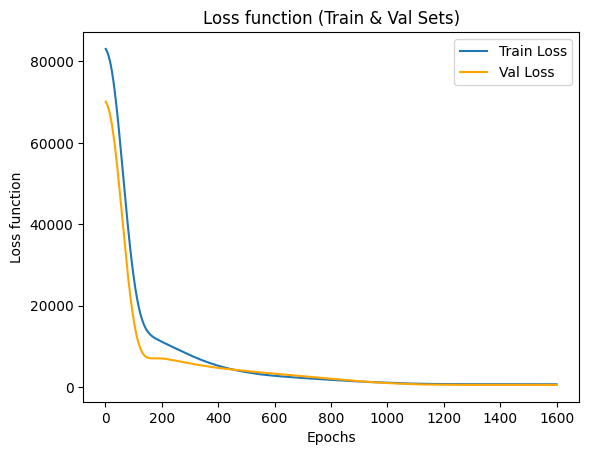

In [28]:

loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()
plt.show()

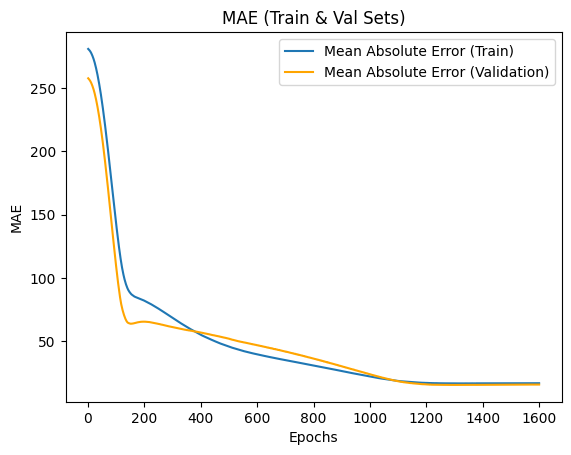

In [29]:
mae = regressor_history.history['mae']
val_mae = regressor_history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('MAE (Train & Val Sets)')
plt.plot(epochs,mae,label='Mean Absolute Error (Train)')
plt.plot(epochs,val_mae,color='orange',label='Mean Absolute Error (Validation)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [30]:
results = regressor.evaluate(X_test,y_test)

5/5 [==============================] - 0s 4ms/step - loss: 653.0930 - mae: 17.4465


In [42]:
mse = results[0]  # Индекс 0 соответствует MSE
mae = results[1]  # Индекс 1 соответствует MAE

print('MSE:', mse)
print('MAE:', mae)

MSE: 653.0929565429688
MAE: 17.4465274810791


5/5 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<ipython-input-32-2ff8455b897e>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, z1, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-32-2ff8455b897e>:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, z2, c='r', cmap='coolwarm', label='Predictions', s=20)


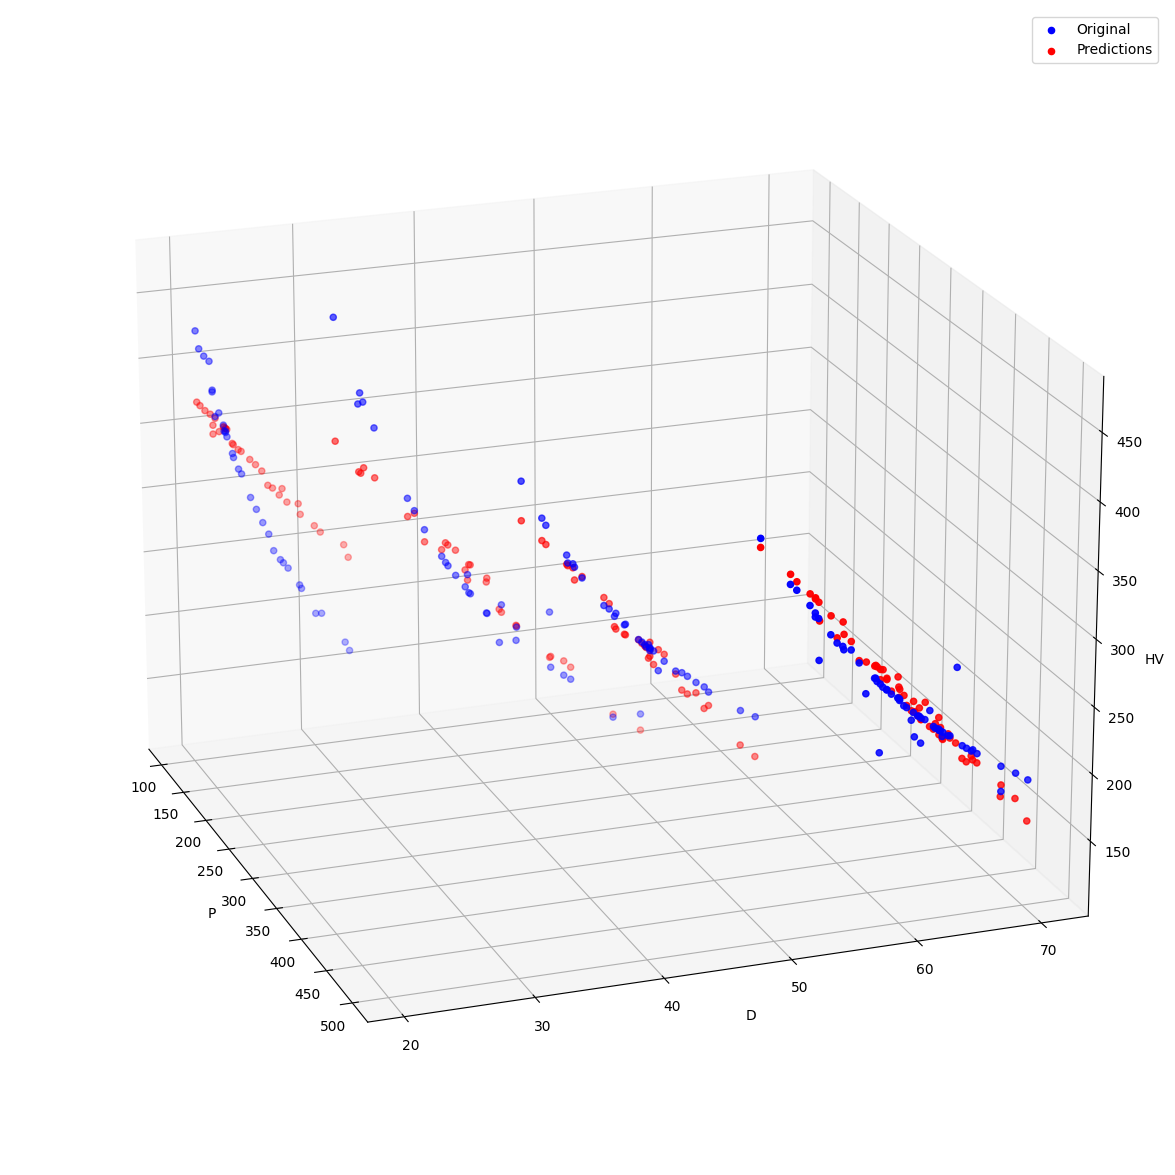

In [32]:
import matplotlib.pyplot as plt

predictions = regressor.predict(X_test)
original = y_test.to_numpy()
print(type(predictions))
print(type(original))

z1 = original
z2 = predictions
x = min_max_scaler.inverse_transform(X_test)[:, 1]
y = (min_max_scaler.inverse_transform(X_test)[:, 2] + min_max_scaler.inverse_transform(X_test)[:, 3]) / 2

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=340, elev=20)
sc1 = ax.scatter(x, y, z1, c='b', cmap='coolwarm', label='Original', s=20)
sc2 = ax.scatter(x, y, z2, c='r', cmap='coolwarm', label='Predictions', s=20)
ax.set_xlabel('P')
ax.set_ylabel('D')
ax.set_zlabel('HV')
ax.legend(handles=[sc1, sc2], loc='best')
plt.show()

5/5 [==============================] - 0s 4ms/step


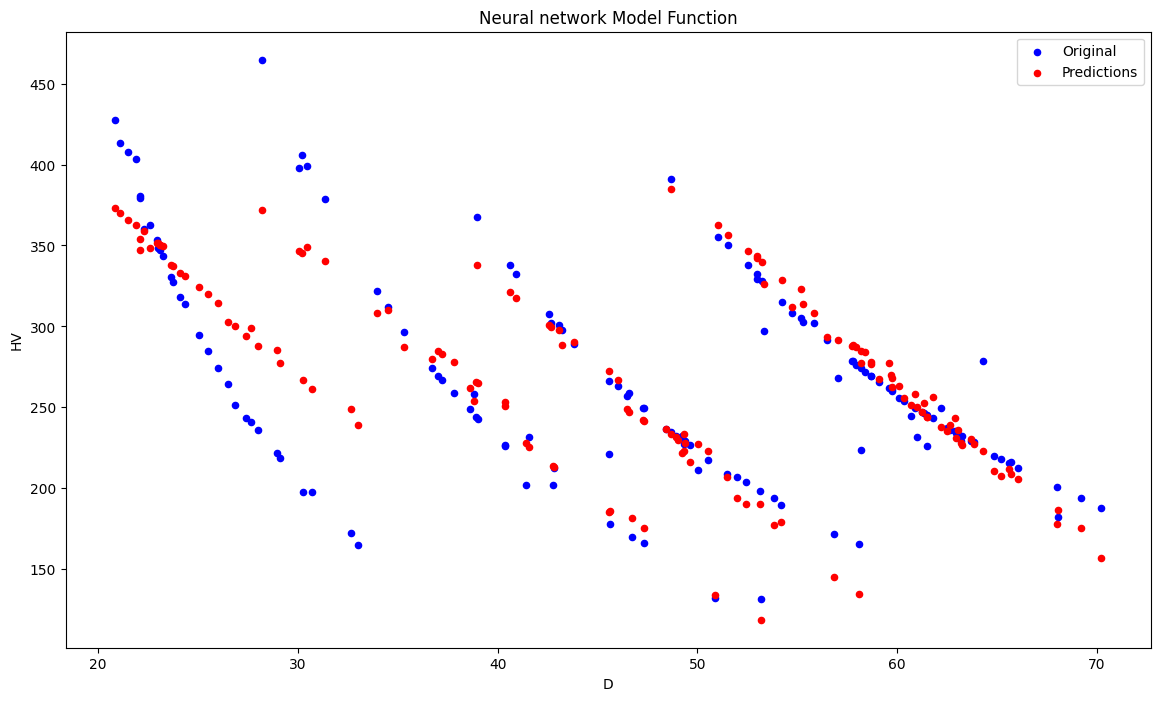

In [33]:
import matplotlib.pyplot as plt

predictions = regressor.predict(X_test)
original = y_test.to_numpy()

z1 = original
z2 = predictions
x = (min_max_scaler.inverse_transform(X_test)[:, 2] + min_max_scaler.inverse_transform(X_test)[:, 3]) / 2

fig = plt.figure(figsize=(14, 8))
plt.scatter(x, z1, c='b', label='Original', s=20)
plt.scatter(x, z2, c='r', label='Predictions', s=20)
plt.xlabel('D')
plt.ylabel('HV')
plt.title('Neural network Model Function')
plt.legend()
plt.show()

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, test_size=0.3,
                                                    random_state=1)

In [35]:
from sklearn.linear_model import LassoCV
LassoRegressor = LassoCV()
LassoRegressor.fit(X_train, Y_train)
calculate_error(LassoRegressor, X_test, Y_test)

R^2 score: 0.8142433859839092
MSE: 812.688
MAE: 18.353
MAPE: 0.069


<ipython-input-9-44e4ea302ba1>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-44e4ea302ba1>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


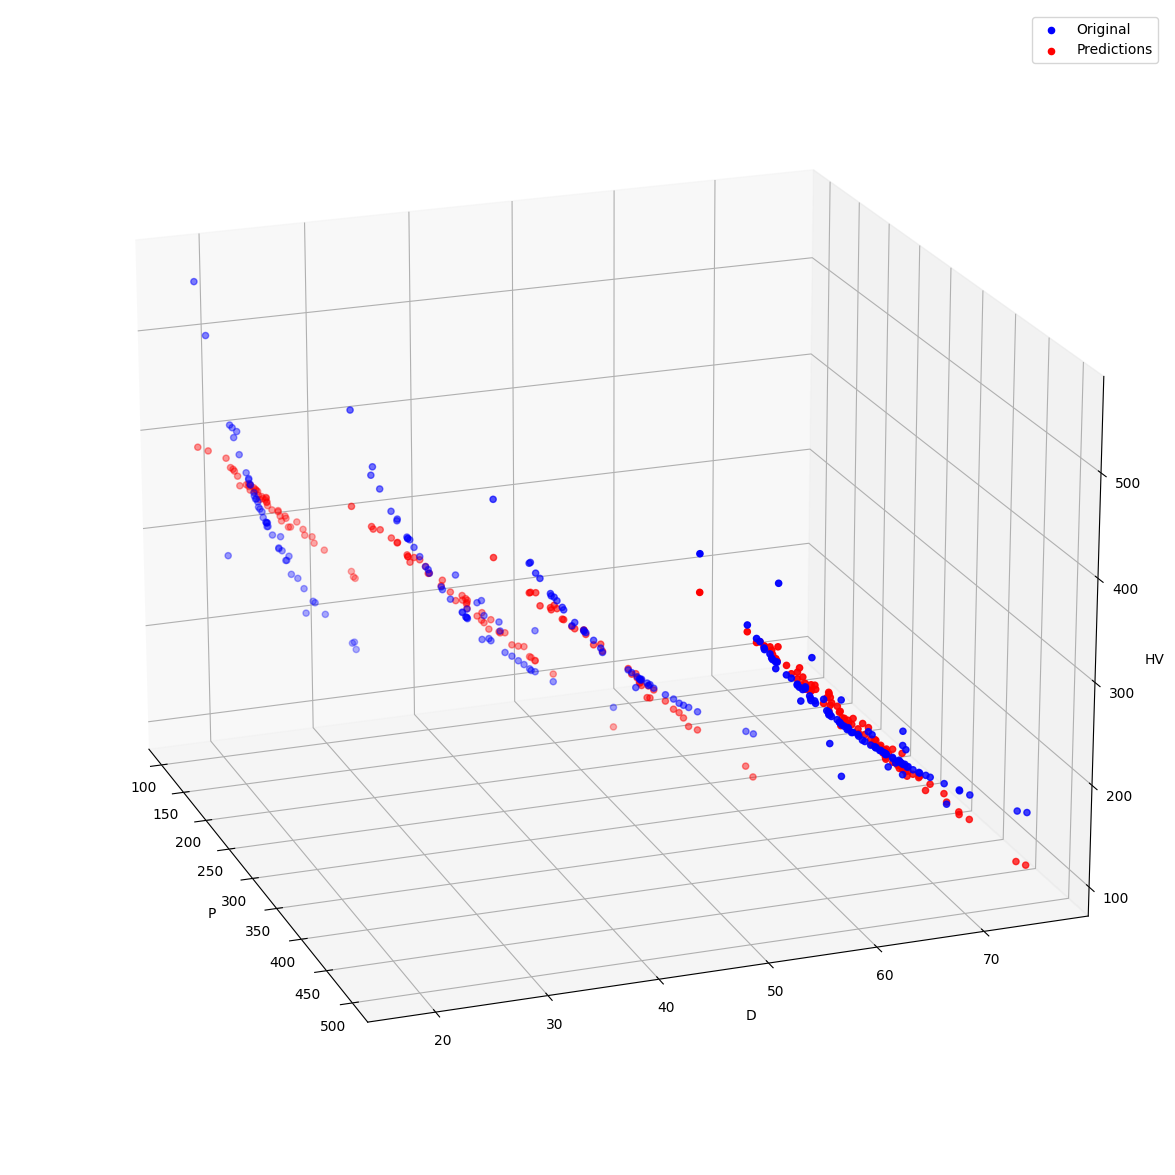

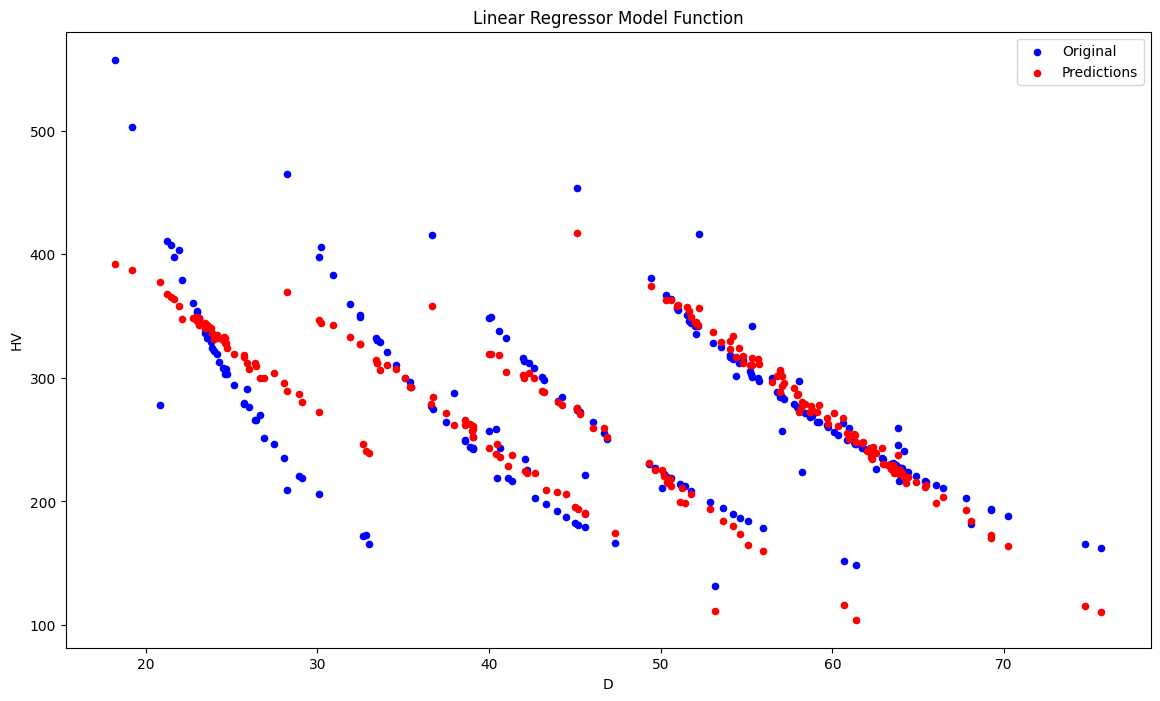

In [36]:
plot_3d_graph(LassoRegressor, X_test, Y_test)
plot_2d_graph(LassoRegressor, X_test, Y_test)

In [37]:
from sklearn.linear_model import RidgeCV
RidgeRegressor = RidgeCV()
RidgeRegressor.fit(X_train, Y_train)
calculate_error(RidgeRegressor, X_test, Y_test)

R^2 score: 0.8163142246511551
MSE: 803.628
MAE: 18.568
MAPE: 0.07


<ipython-input-9-44e4ea302ba1>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-44e4ea302ba1>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


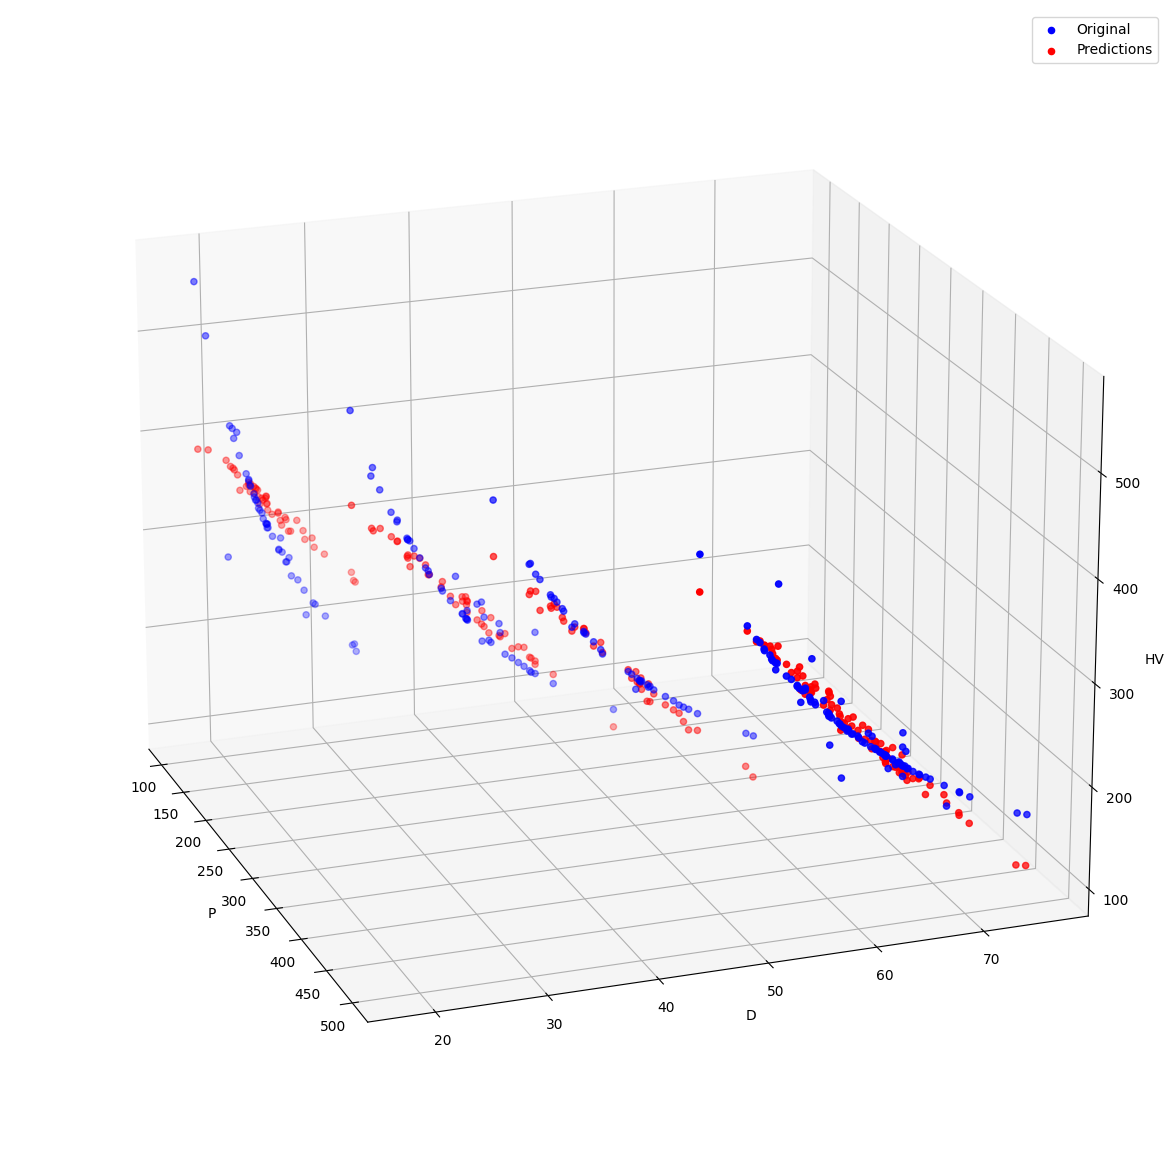

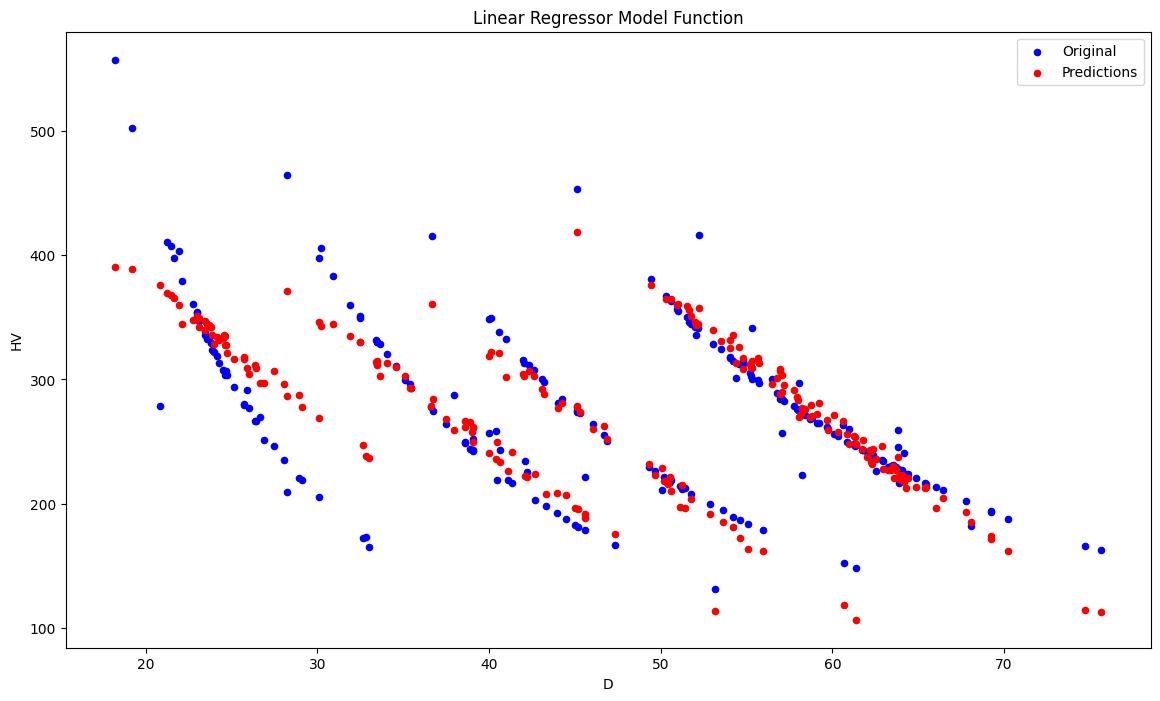

In [41]:
plot_3d_graph(RidgeRegressor, X_test, Y_test)
plot_2d_graph(RidgeRegressor, X_test, Y_test)

In [39]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

# Определение модели
ElasticNetRegressor = ElasticNetCV()

# Определение сетки параметров для перебора
param_grid = {
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    'eps': [1e-3, 1e-4, 1e-5],
    'n_alphas': [50, 100, 200],
    'max_iter': [1000, 2000, 5000],
    'tol': [1e-3, 1e-4, 1e-5],
    'cv': [3, 5, 10],
    'positive': [False, True]
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(ElasticNetRegressor, param_grid)

# Поиск лучших гиперпараметров
grid_search.fit(X_train, Y_train)

# Вывод наилучших параметров
print("Best Parameters: ", grid_search.best_params_)
bestElasticNet = grid_search.best_estimator_


# Предсказание на тестовых данных с использованием наилучших параметров
calculate_error(bestElasticNet, X_test, Y_test)

Best Parameters:  {'cv': 5, 'eps': 1e-05, 'l1_ratio': 1.0, 'max_iter': 1000, 'n_alphas': 50, 'positive': False, 'tol': 0.001}
R^2 score: 0.8163349537134063
MSE: 803.538
MAE: 18.588
MAPE: 0.07


<ipython-input-9-44e4ea302ba1>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-44e4ea302ba1>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


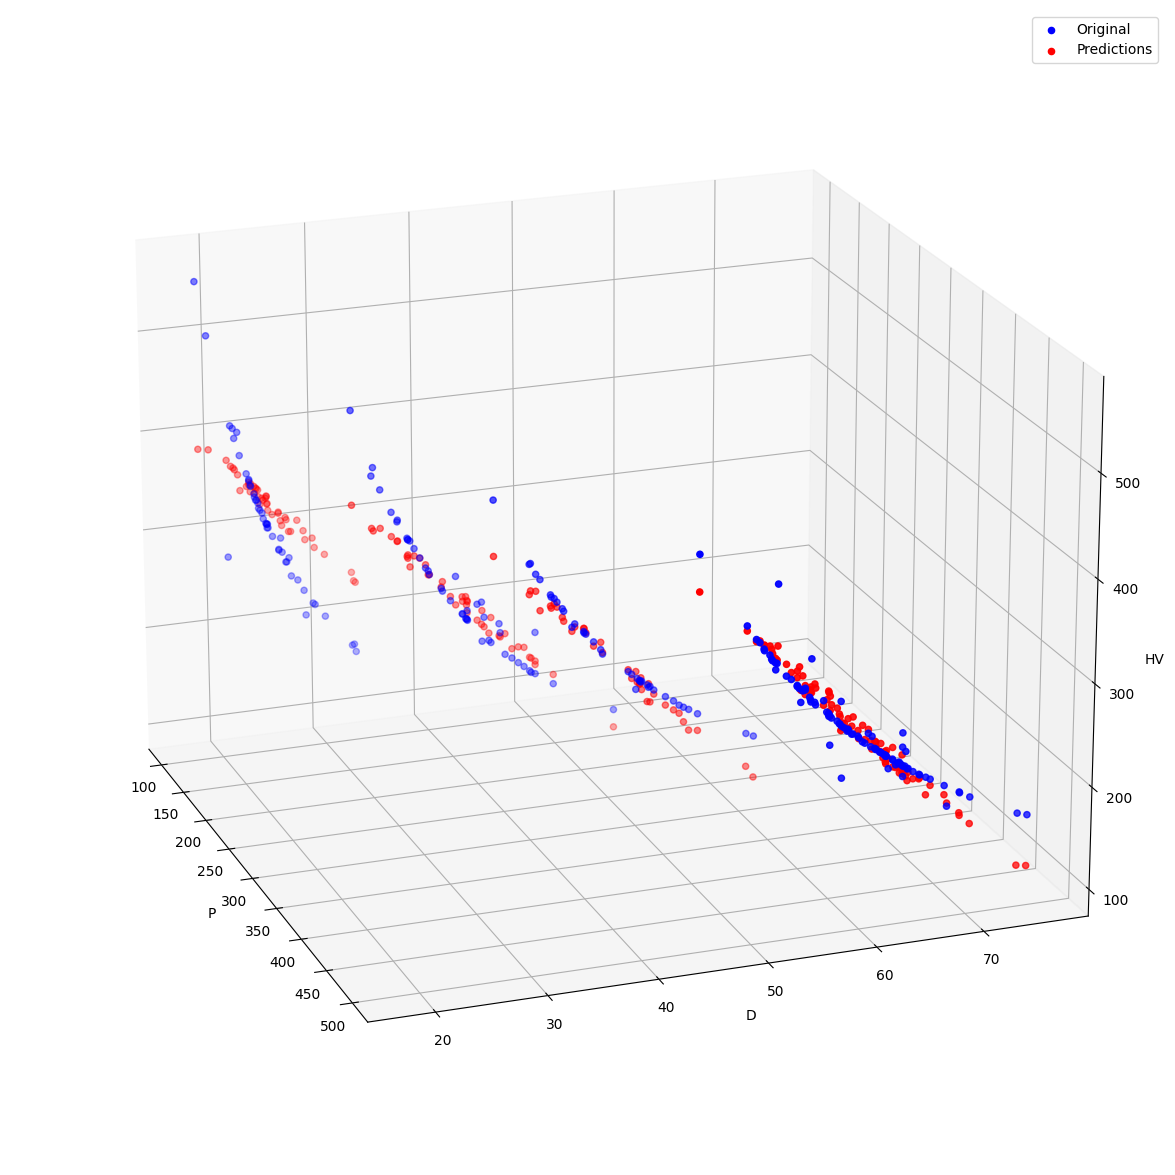

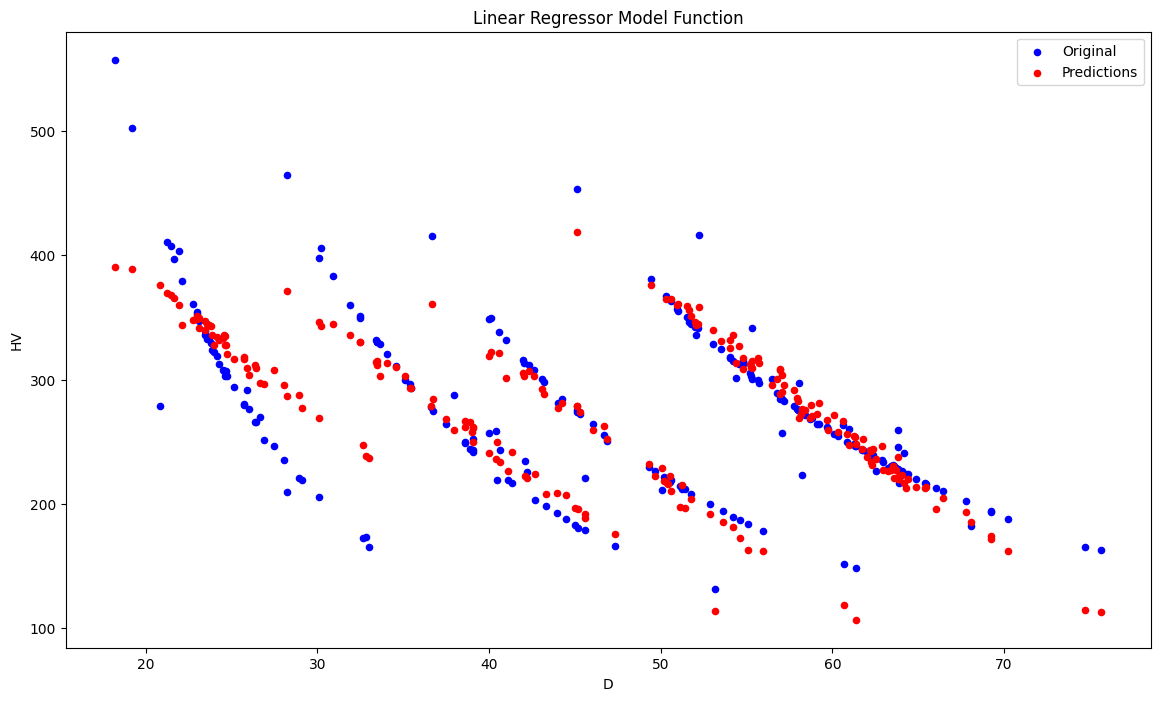

In [40]:
plot_3d_graph(bestElasticNet, X_test, Y_test)
plot_2d_graph(bestElasticNet, X_test, Y_test)